In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/84.1 kB ? eta -:--:--

   ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/84.1 kB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 849.3 kB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

from copy import copy

import shutil
import os
import skimage.io as sk

2024-05-08 03:16:48.813017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 03:16:48.813126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 03:16:49.098855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# List all available models
# timm.list_models("")

In [6]:
model_name = "timm/vit_base_patch16_siglip_512"
# model_name = "timm/maxvit_small_tf_512.in1k"
# model_name = 'timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k'

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import timm
import numpy as np
from tqdm import tqdm

# Settings
num_epochs = 8
num_accumulate = 4

# Criterion and Metric
criterion = nn.CrossEntropyLoss()
metric = evaluate.load("f1")

In [8]:
train_path = '/kaggle/input/ml-dataset/dataset/training'
val_path = '/kaggle/input/ml-dataset/dataset/validation'
# val_path = '/kaggle/input/ml-dataset/dataset/test'

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

train_batch_size =8
eval_batch_size =8

data_transforms = transforms.Compose([
    transforms.Resize((512, 512), interpolation=T.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=data_transforms
)
# validation dataset
valid_dataset = datasets.ImageFolder(
    root=val_path,
    transform=data_transforms
)

# # Function to create a subset consisting of approximately 10% of the dataset
# def sample_subset(dataset, fraction=0.01):
#     total_samples = len(dataset)
#     sampled_indices = np.random.choice(total_samples, int(total_samples * fraction), replace=False)
#     return Subset(dataset, sampled_indices)

# # Create subsets
# train_subset = sample_subset(train_dataset)
# valid_subset = sample_subset(valid_dataset)


train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False)
# train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
# val_dataloader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False)

### EDA

In [10]:
# !pip install stegano

In [11]:
# !pip install jpegio
# import jpegio as jio

In [12]:
# BASE_PATH = "/kaggle/input/ml-dataset/dataset/training"
# train_imageids = pd.Series(os.listdir(BASE_PATH + '/cover')).sort_values(ascending=True).reset_index(drop=True)

In [13]:
# BASE_PATH = "/kaggle/input/ml-dataset/dataset/training"
# cover_images_path = pd.Series(BASE_PATH + '/cover/' + train_imageids ).sort_values(ascending=True)
# JMIPOD_images_path = pd.Series(BASE_PATH + '/jmipod/'+train_imageids).sort_values(ascending=True)
# JUNIWARD_images_path = pd.Series(BASE_PATH + '/juniward/'+train_imageids).sort_values(ascending=True)
# UERD_images_path = pd.Series(BASE_PATH + '/uerd/'+train_imageids).sort_values(ascending=True)

In [14]:
# fig,ax = plt.subplots(4,4,figsize=(20,16))
# plt.tight_layout()


# im1 = Image.open(cover_images_path[0])
# im2 = Image.open(JUNIWARD_images_path[0])
# im3 = Image.open(JMIPOD_images_path[0])
# im4 = Image.open(UERD_images_path[0])

# for i,image in enumerate([im1,im2,im3,im4]):
#     ycbcr = image.convert('YCbCr')
#     (y, cb, cr) = ycbcr.split()

#     ax[i,0].imshow(image)
#     ax[i,0].set_title('Image')
#     ax[i,1].imshow(y)
#     ax[i,1].set_title('Luminance')
#     ax[i,2].imshow(cb)
#     ax[i,2].set_title('Cb:Chroma Blue')
#     ax[i,3].imshow(cr)
#     ax[i,3].set_title('Cr:Chroma Red')

In [15]:
# coverDCT = np.zeros([512,512,3])
# stegoDCT = np.zeros([512,512,3])
# jpeg = jio.read(cover_images_path[0])
# stego_juni = jio.read(JUNIWARD_images_path[0])

In [16]:
# coverDCT[:,:,0] = jpeg.coef_arrays[0] ; coverDCT[:,:,1] = jpeg.coef_arrays[1] ; coverDCT[:,:,2] = jpeg.coef_arrays[2]
# stegoDCT[:,:,0] = stego_juni.coef_arrays[0] ; stegoDCT[:,:,1] = stego_juni.coef_arrays[1] ; stegoDCT[:,:,2] = stego_juni.coef_arrays[2]

# DCT_diff = coverDCT - stegoDCT
# # So since they are not the same Images the DCT_diff would not be zero
# print(len(DCT_diff[np.where(DCT_diff!=0)]))
# print(np.unique(DCT_diff))
# plt.figure(figsize=(16,10))
# plt.imshow( abs(DCT_diff) )
# plt.show()

In [17]:
# coverPixels = np.array(Image.open(cover_images_path[0])).astype('float')
# stegoPixels = np.array(Image.open(JUNIWARD_images_path[0])).astype('float')

# pixelsDiff = coverPixels - stegoPixels

# # So since they are not the same Images the pixels_diff would not be zero
# print(len(pixelsDiff[np.where(pixelsDiff!=0)]))
# print(np.unique(pixelsDiff))
# plt.figure(figsize=(16,10))
# plt.imshow( abs(pixelsDiff) )
# plt.show()

In [18]:
# fig,ax = plt.subplots(1,2,figsize=(16,12))
# ax[0].imshow(abs(DCT_diff))
# ax[1].imshow(abs(pixelsDiff))

In [19]:
# # Check the first few batches
# for inputs, targets in train_dataloader:
#     print("Sample inputs size:", inputs.size())
#     print("Sample targets:", targets)
#     break

0


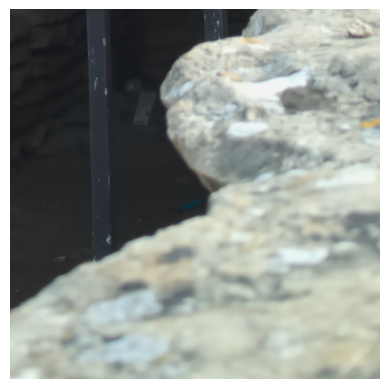

In [20]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_image(tensor):
    to_image = T.ToPILImage()
    img = to_image(tensor)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

img_tensor, label = train_dataset[0]
print(label)
show_image(img_tensor)

## Training

In [21]:
# Model, Optimizer, and Scheduler
model = timm.create_model(model_name, pretrained=True, num_classes=4)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.to(device)

open_clip_model.safetensors:   0%|          | 0.00/815M [00:00<?, ?B/s]

Using 2 GPUs!


In [22]:
from sklearn import metrics
import numpy as np

def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights =        [       2,   1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)
    
    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    
    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric
        
    return competition_metric / normalization

In [23]:
optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)

scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]


for epoch in range(num_epochs):
    model.train()
    
    train_loss_epoch = []
    val_loss_epoch = []
    
    train_preds = []
    train_targets = []
    
    val_preds = []
    val_targets = []
    
    num_updates = epoch * len(train_dataloader)
    
    best_auc = None 
    
    y_pred = []

    # Training Loop
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        
        loss.backward()

        if ((batch_idx + 1) % num_accumulate == 0) or (batch_idx + 1 == len(train_dataloader)):
            optimizer.step()
            scheduler.step_update(num_updates=num_updates)
            optimizer.zero_grad()

        train_loss_epoch.append(loss.item())
        train_preds.extend(outputs.argmax(dim=-1).detach().cpu().tolist())
        train_targets.extend(targets.tolist())
        
    optimizer.sync_lookahead()
    scheduler.step(epoch + 1)

    # Validation Loop
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            val_loss_epoch.append(loss.item())
            
            val_preds.extend(outputs.argmax(dim=-1).detach().cpu().tolist())
            val_targets.extend(targets.tolist())
            
            
            y_pred.extend(1 - torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 0])
            

    # Calculate Metrics
    metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
    metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]
    
    
    auc_score = alaska_weighted_auc(val_targets, y_pred)
    
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(val_loss_epoch)}, Train F1 {metric_train}, Val F1 {metric_val}, AUC weight score {auc_score}")
    
    # Best Model Check
    if best_auc == None:
        best_auc = auc_score
        if torch.cuda.current_device() == 0:
            torch.save(model, f"best_model_{model_name[5::]}_{epoch+1}_epoch.pt")
        continue
        
    if auc_score > best_auc:
        best_auc = auc_score
        if torch.cuda.current_device() == 0:
            torch.save(model, f"best_model_{model_name[5::]}_{epoch+1}_epoch.pt")

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 1/3500 [00:04<4:07:00,  4.24s/it]

  0%|          | 2/3500 [00:05<2:16:55,  2.35s/it]

  0%|          | 3/3500 [00:06<1:41:13,  1.74s/it]

  0%|          | 4/3500 [00:07<1:28:04,  1.51s/it]

  0%|          | 5/3500 [00:08<1:17:37,  1.33s/it]

  0%|          | 6/3500 [00:09<1:11:19,  1.22s/it]

  0%|          | 7/3500 [00:10<1:07:17,  1.16s/it]

  0%|          | 8/3500 [00:11<1:05:09,  1.12s/it]

  0%|          | 9/3500 [00:12<1:03:00,  1.08s/it]

  0%|          | 10/3500 [00:13<1:01:49,  1.06s/it]

  0%|          | 11/3500 [00:14<1:00:58,  1.05s/it]

  0%|          | 12/3500 [00:15<1:00:43,  1.04s/it]

  0%|          | 13/3500 [00:16<1:00:00,  1.03s/it]

  0%|          | 14/3500 [00:17<59:44,  1.03s/it]  

  0%|          | 15/3500 [00:18<59:29,  1.02s/it]

  0%|          | 16/3500 [00:19<59:42,  1.03s/it]

  0%|          | 17/3500 [00:20<59:29,  1.02s/it]

  1%|          | 18/3500 [00:21<59:24,  1.02s/it]

  1%|          | 19/3500 [00:22<59:33,  1.03s/it]

  1%|          | 20/3500 [00:23<59:51,  1.03s/it]

  1%|          | 21/3500 [00:24<59:21,  1.02s/it]

  1%|          | 22/3500 [00:25<59:33,  1.03s/it]

  1%|          | 23/3500 [00:26<59:18,  1.02s/it]

  1%|          | 24/3500 [00:27<1:00:06,  1.04s/it]

  1%|          | 25/3500 [00:28<59:31,  1.03s/it]  

  1%|          | 26/3500 [00:29<59:47,  1.03s/it]

  1%|          | 27/3500 [00:30<59:48,  1.03s/it]

  1%|          | 28/3500 [00:32<59:55,  1.04s/it]

  1%|          | 29/3500 [00:33<59:32,  1.03s/it]

  1%|          | 30/3500 [00:34<59:23,  1.03s/it]

  1%|          | 31/3500 [00:35<59:05,  1.02s/it]

  1%|          | 32/3500 [00:36<59:25,  1.03s/it]

  1%|          | 33/3500 [00:37<59:13,  1.02s/it]

  1%|          | 34/3500 [00:38<59:03,  1.02s/it]

  1%|          | 35/3500 [00:39<58:58,  1.02s/it]

  1%|          | 36/3500 [00:40<59:34,  1.03s/it]

  1%|          | 37/3500 [00:41<59:22,  1.03s/it]

  1%|          | 38/3500 [00:42<59:26,  1.03s/it]

  1%|          | 39/3500 [00:43<59:09,  1.03s/it]

  1%|          | 40/3500 [00:44<59:32,  1.03s/it]

  1%|          | 41/3500 [00:45<59:17,  1.03s/it]

  1%|          | 42/3500 [00:46<59:00,  1.02s/it]

  1%|          | 43/3500 [00:47<58:48,  1.02s/it]

  1%|▏         | 44/3500 [00:48<59:04,  1.03s/it]

  1%|▏         | 45/3500 [00:49<59:17,  1.03s/it]

  1%|▏         | 46/3500 [00:50<59:30,  1.03s/it]

  1%|▏         | 47/3500 [00:51<59:30,  1.03s/it]

  1%|▏         | 48/3500 [00:52<59:52,  1.04s/it]

  1%|▏         | 49/3500 [00:53<59:35,  1.04s/it]

  1%|▏         | 50/3500 [00:54<59:34,  1.04s/it]

  1%|▏         | 51/3500 [00:55<59:27,  1.03s/it]

  1%|▏         | 52/3500 [00:56<59:55,  1.04s/it]

  2%|▏         | 53/3500 [00:57<59:53,  1.04s/it]

  2%|▏         | 54/3500 [00:58<59:33,  1.04s/it]

  2%|▏         | 55/3500 [00:59<59:39,  1.04s/it]

  2%|▏         | 56/3500 [01:00<1:00:07,  1.05s/it]

  2%|▏         | 57/3500 [01:01<1:00:09,  1.05s/it]

  2%|▏         | 58/3500 [01:03<1:00:02,  1.05s/it]

  2%|▏         | 59/3500 [01:04<1:00:08,  1.05s/it]

  2%|▏         | 60/3500 [01:05<1:00:15,  1.05s/it]

  2%|▏         | 61/3500 [01:06<59:49,  1.04s/it]  

  2%|▏         | 62/3500 [01:07<59:39,  1.04s/it]

  2%|▏         | 63/3500 [01:08<59:16,  1.03s/it]

  2%|▏         | 64/3500 [01:09<59:35,  1.04s/it]

  2%|▏         | 65/3500 [01:10<59:08,  1.03s/it]

  2%|▏         | 66/3500 [01:11<59:13,  1.03s/it]

  2%|▏         | 67/3500 [01:12<59:08,  1.03s/it]

  2%|▏         | 68/3500 [01:13<59:37,  1.04s/it]

  2%|▏         | 69/3500 [01:14<59:34,  1.04s/it]

  2%|▏         | 70/3500 [01:15<59:28,  1.04s/it]

  2%|▏         | 71/3500 [01:16<59:35,  1.04s/it]

  2%|▏         | 72/3500 [01:17<1:00:09,  1.05s/it]

  2%|▏         | 73/3500 [01:18<1:00:22,  1.06s/it]

  2%|▏         | 74/3500 [01:19<59:50,  1.05s/it]  

  2%|▏         | 75/3500 [01:20<59:44,  1.05s/it]

  2%|▏         | 76/3500 [01:21<1:00:21,  1.06s/it]

  2%|▏         | 77/3500 [01:22<59:43,  1.05s/it]  

  2%|▏         | 78/3500 [01:23<59:34,  1.04s/it]

  2%|▏         | 79/3500 [01:24<59:44,  1.05s/it]

  2%|▏         | 80/3500 [01:26<1:00:03,  1.05s/it]

  2%|▏         | 81/3500 [01:27<59:39,  1.05s/it]  

  2%|▏         | 82/3500 [01:28<59:35,  1.05s/it]

  2%|▏         | 83/3500 [01:29<59:20,  1.04s/it]

  2%|▏         | 84/3500 [01:30<59:58,  1.05s/it]

  2%|▏         | 85/3500 [01:31<59:45,  1.05s/it]

  2%|▏         | 86/3500 [01:32<59:35,  1.05s/it]

  2%|▏         | 87/3500 [01:33<59:27,  1.05s/it]

  3%|▎         | 88/3500 [01:34<59:57,  1.05s/it]

  3%|▎         | 89/3500 [01:35<59:39,  1.05s/it]

  3%|▎         | 90/3500 [01:36<59:34,  1.05s/it]

  3%|▎         | 91/3500 [01:37<59:32,  1.05s/it]

  3%|▎         | 92/3500 [01:38<59:50,  1.05s/it]

  3%|▎         | 93/3500 [01:39<59:33,  1.05s/it]

  3%|▎         | 94/3500 [01:40<59:36,  1.05s/it]

  3%|▎         | 95/3500 [01:41<59:37,  1.05s/it]

  3%|▎         | 96/3500 [01:42<1:00:20,  1.06s/it]

  3%|▎         | 97/3500 [01:43<1:00:01,  1.06s/it]

  3%|▎         | 98/3500 [01:44<1:00:06,  1.06s/it]

  3%|▎         | 99/3500 [01:46<1:00:00,  1.06s/it]

  3%|▎         | 100/3500 [01:47<1:00:14,  1.06s/it]

  3%|▎         | 101/3500 [01:48<59:35,  1.05s/it]  

  3%|▎         | 102/3500 [01:49<59:40,  1.05s/it]

  3%|▎         | 103/3500 [01:50<59:53,  1.06s/it]

  3%|▎         | 104/3500 [01:51<1:00:20,  1.07s/it]

  3%|▎         | 105/3500 [01:52<59:54,  1.06s/it]  

  3%|▎         | 106/3500 [01:53<59:53,  1.06s/it]

  3%|▎         | 107/3500 [01:54<1:00:04,  1.06s/it]

  3%|▎         | 108/3500 [01:55<1:00:19,  1.07s/it]

  3%|▎         | 109/3500 [01:56<59:55,  1.06s/it]  

  3%|▎         | 110/3500 [01:57<59:49,  1.06s/it]

  3%|▎         | 111/3500 [01:58<59:49,  1.06s/it]

  3%|▎         | 112/3500 [01:59<1:00:07,  1.06s/it]

  3%|▎         | 113/3500 [02:00<59:48,  1.06s/it]  

  3%|▎         | 114/3500 [02:01<59:46,  1.06s/it]

  3%|▎         | 115/3500 [02:02<59:37,  1.06s/it]

  3%|▎         | 116/3500 [02:04<1:00:10,  1.07s/it]

  3%|▎         | 117/3500 [02:05<1:00:03,  1.07s/it]

  3%|▎         | 118/3500 [02:06<59:50,  1.06s/it]  

  3%|▎         | 119/3500 [02:07<59:56,  1.06s/it]

  3%|▎         | 120/3500 [02:08<1:00:32,  1.07s/it]

  3%|▎         | 121/3500 [02:09<1:00:05,  1.07s/it]

  3%|▎         | 122/3500 [02:10<1:00:12,  1.07s/it]

  4%|▎         | 123/3500 [02:11<59:54,  1.06s/it]  

  4%|▎         | 124/3500 [02:12<1:00:16,  1.07s/it]

  4%|▎         | 125/3500 [02:13<1:00:40,  1.08s/it]

  4%|▎         | 126/3500 [02:14<1:00:25,  1.07s/it]

  4%|▎         | 127/3500 [02:15<1:00:12,  1.07s/it]

  4%|▎         | 128/3500 [02:16<1:00:27,  1.08s/it]

  4%|▎         | 129/3500 [02:17<1:00:06,  1.07s/it]

  4%|▎         | 130/3500 [02:19<1:00:20,  1.07s/it]

  4%|▎         | 131/3500 [02:20<1:00:12,  1.07s/it]

  4%|▍         | 132/3500 [02:21<1:00:17,  1.07s/it]

  4%|▍         | 133/3500 [02:22<1:00:03,  1.07s/it]

  4%|▍         | 134/3500 [02:23<1:00:20,  1.08s/it]

  4%|▍         | 135/3500 [02:24<1:00:03,  1.07s/it]

  4%|▍         | 136/3500 [02:25<1:05:51,  1.17s/it]

  4%|▍         | 137/3500 [02:26<1:03:51,  1.14s/it]

  4%|▍         | 138/3500 [02:27<1:02:22,  1.11s/it]

  4%|▍         | 139/3500 [02:29<1:01:59,  1.11s/it]

  4%|▍         | 140/3500 [02:30<1:01:35,  1.10s/it]

  4%|▍         | 141/3500 [02:31<1:00:54,  1.09s/it]

  4%|▍         | 142/3500 [02:32<1:01:03,  1.09s/it]

  4%|▍         | 143/3500 [02:33<1:00:40,  1.08s/it]

  4%|▍         | 144/3500 [02:34<1:01:04,  1.09s/it]

  4%|▍         | 145/3500 [02:35<1:00:42,  1.09s/it]

  4%|▍         | 146/3500 [02:36<1:00:17,  1.08s/it]

  4%|▍         | 147/3500 [02:37<1:00:12,  1.08s/it]

  4%|▍         | 148/3500 [02:38<1:00:25,  1.08s/it]

  4%|▍         | 149/3500 [02:39<59:59,  1.07s/it]  

  4%|▍         | 150/3500 [02:40<1:00:09,  1.08s/it]

  4%|▍         | 151/3500 [02:41<59:54,  1.07s/it]  

  4%|▍         | 152/3500 [02:43<1:00:21,  1.08s/it]

  4%|▍         | 153/3500 [02:44<1:00:01,  1.08s/it]

  4%|▍         | 154/3500 [02:45<59:55,  1.07s/it]  

  4%|▍         | 155/3500 [02:46<59:59,  1.08s/it]

  4%|▍         | 156/3500 [02:47<1:00:04,  1.08s/it]

  4%|▍         | 157/3500 [02:48<59:44,  1.07s/it]  

  5%|▍         | 158/3500 [02:49<59:50,  1.07s/it]

  5%|▍         | 159/3500 [02:50<59:41,  1.07s/it]

  5%|▍         | 160/3500 [02:51<1:00:15,  1.08s/it]

  5%|▍         | 161/3500 [02:52<1:00:11,  1.08s/it]

  5%|▍         | 162/3500 [02:53<1:00:09,  1.08s/it]

  5%|▍         | 163/3500 [02:54<1:00:03,  1.08s/it]

  5%|▍         | 164/3500 [02:56<1:00:33,  1.09s/it]

  5%|▍         | 165/3500 [02:57<1:00:06,  1.08s/it]

  5%|▍         | 166/3500 [02:58<59:46,  1.08s/it]  

  5%|▍         | 167/3500 [02:59<59:39,  1.07s/it]

  5%|▍         | 168/3500 [03:00<1:00:20,  1.09s/it]

  5%|▍         | 169/3500 [03:01<59:57,  1.08s/it]  

  5%|▍         | 170/3500 [03:02<59:46,  1.08s/it]

  5%|▍         | 171/3500 [03:03<59:47,  1.08s/it]

  5%|▍         | 172/3500 [03:04<1:00:24,  1.09s/it]

  5%|▍         | 173/3500 [03:05<1:00:25,  1.09s/it]

  5%|▍         | 174/3500 [03:06<1:00:06,  1.08s/it]

  5%|▌         | 175/3500 [03:07<59:59,  1.08s/it]  

  5%|▌         | 176/3500 [03:09<1:00:34,  1.09s/it]

  5%|▌         | 177/3500 [03:10<1:00:04,  1.08s/it]

  5%|▌         | 178/3500 [03:11<59:34,  1.08s/it]  

  5%|▌         | 179/3500 [03:12<59:31,  1.08s/it]

  5%|▌         | 180/3500 [03:13<59:50,  1.08s/it]

  5%|▌         | 181/3500 [03:14<59:31,  1.08s/it]

  5%|▌         | 182/3500 [03:15<59:22,  1.07s/it]

  5%|▌         | 183/3500 [03:16<59:30,  1.08s/it]

  5%|▌         | 184/3500 [03:17<1:00:10,  1.09s/it]

  5%|▌         | 185/3500 [03:18<1:00:00,  1.09s/it]

  5%|▌         | 186/3500 [03:19<59:52,  1.08s/it]  

  5%|▌         | 187/3500 [03:20<59:40,  1.08s/it]

  5%|▌         | 188/3500 [03:21<1:00:18,  1.09s/it]

  5%|▌         | 189/3500 [03:23<1:00:05,  1.09s/it]

  5%|▌         | 190/3500 [03:24<59:52,  1.09s/it]  

  5%|▌         | 191/3500 [03:25<59:39,  1.08s/it]

  5%|▌         | 192/3500 [03:26<1:00:28,  1.10s/it]

  6%|▌         | 193/3500 [03:27<1:00:00,  1.09s/it]

  6%|▌         | 194/3500 [03:28<59:49,  1.09s/it]  

  6%|▌         | 195/3500 [03:29<59:49,  1.09s/it]

  6%|▌         | 196/3500 [03:30<1:00:12,  1.09s/it]

  6%|▌         | 197/3500 [03:31<59:40,  1.08s/it]  

  6%|▌         | 198/3500 [03:32<59:47,  1.09s/it]

  6%|▌         | 199/3500 [03:33<59:37,  1.08s/it]

  6%|▌         | 200/3500 [03:35<1:00:15,  1.10s/it]

  6%|▌         | 201/3500 [03:36<59:59,  1.09s/it]  

  6%|▌         | 202/3500 [03:37<1:00:06,  1.09s/it]

  6%|▌         | 203/3500 [03:38<59:48,  1.09s/it]  

  6%|▌         | 204/3500 [03:39<1:00:04,  1.09s/it]

  6%|▌         | 205/3500 [03:40<59:57,  1.09s/it]  

  6%|▌         | 206/3500 [03:41<59:49,  1.09s/it]

  6%|▌         | 207/3500 [03:42<59:37,  1.09s/it]

  6%|▌         | 208/3500 [03:43<59:55,  1.09s/it]

  6%|▌         | 209/3500 [03:44<59:23,  1.08s/it]

  6%|▌         | 210/3500 [03:45<59:24,  1.08s/it]

  6%|▌         | 211/3500 [03:47<59:26,  1.08s/it]

  6%|▌         | 212/3500 [03:48<59:59,  1.09s/it]

  6%|▌         | 213/3500 [03:49<59:33,  1.09s/it]

  6%|▌         | 214/3500 [03:50<59:24,  1.08s/it]

  6%|▌         | 215/3500 [03:51<59:23,  1.08s/it]

  6%|▌         | 216/3500 [03:52<1:00:12,  1.10s/it]

  6%|▌         | 217/3500 [03:53<59:59,  1.10s/it]  

  6%|▌         | 218/3500 [03:54<59:55,  1.10s/it]

  6%|▋         | 219/3500 [03:55<59:58,  1.10s/it]

  6%|▋         | 220/3500 [03:56<1:00:25,  1.11s/it]

  6%|▋         | 221/3500 [03:57<59:56,  1.10s/it]  

  6%|▋         | 222/3500 [03:59<59:37,  1.09s/it]

  6%|▋         | 223/3500 [04:00<59:40,  1.09s/it]

  6%|▋         | 224/3500 [04:01<1:00:08,  1.10s/it]

  6%|▋         | 225/3500 [04:02<59:38,  1.09s/it]  

  6%|▋         | 226/3500 [04:03<59:30,  1.09s/it]

  6%|▋         | 227/3500 [04:04<59:14,  1.09s/it]

  7%|▋         | 228/3500 [04:05<59:37,  1.09s/it]

  7%|▋         | 229/3500 [04:06<59:26,  1.09s/it]

  7%|▋         | 230/3500 [04:07<59:20,  1.09s/it]

  7%|▋         | 231/3500 [04:08<59:17,  1.09s/it]

  7%|▋         | 232/3500 [04:09<59:31,  1.09s/it]

  7%|▋         | 233/3500 [04:11<59:19,  1.09s/it]

  7%|▋         | 234/3500 [04:12<59:24,  1.09s/it]

  7%|▋         | 235/3500 [04:13<59:19,  1.09s/it]

  7%|▋         | 236/3500 [04:14<59:36,  1.10s/it]

  7%|▋         | 237/3500 [04:15<59:16,  1.09s/it]

  7%|▋         | 238/3500 [04:16<58:49,  1.08s/it]

  7%|▋         | 239/3500 [04:17<58:57,  1.08s/it]

  7%|▋         | 240/3500 [04:18<59:38,  1.10s/it]

  7%|▋         | 241/3500 [04:19<59:15,  1.09s/it]

  7%|▋         | 242/3500 [04:20<59:17,  1.09s/it]

  7%|▋         | 243/3500 [04:21<59:07,  1.09s/it]

  7%|▋         | 244/3500 [04:23<59:29,  1.10s/it]

  7%|▋         | 245/3500 [04:24<59:19,  1.09s/it]

  7%|▋         | 246/3500 [04:25<59:02,  1.09s/it]

  7%|▋         | 247/3500 [04:26<59:23,  1.10s/it]

  7%|▋         | 248/3500 [04:27<59:32,  1.10s/it]

  7%|▋         | 249/3500 [04:28<59:05,  1.09s/it]

  7%|▋         | 250/3500 [04:29<59:10,  1.09s/it]

  7%|▋         | 251/3500 [04:30<59:15,  1.09s/it]

  7%|▋         | 252/3500 [04:31<59:43,  1.10s/it]

  7%|▋         | 253/3500 [04:32<59:11,  1.09s/it]

  7%|▋         | 254/3500 [04:34<58:59,  1.09s/it]

  7%|▋         | 255/3500 [04:35<59:01,  1.09s/it]

  7%|▋         | 256/3500 [04:36<59:12,  1.10s/it]

  7%|▋         | 257/3500 [04:37<59:09,  1.09s/it]

  7%|▋         | 258/3500 [04:38<59:07,  1.09s/it]

  7%|▋         | 259/3500 [04:39<59:18,  1.10s/it]

  7%|▋         | 260/3500 [04:40<59:38,  1.10s/it]

  7%|▋         | 261/3500 [04:41<59:15,  1.10s/it]

  7%|▋         | 262/3500 [04:42<58:58,  1.09s/it]

  8%|▊         | 263/3500 [04:43<58:51,  1.09s/it]

  8%|▊         | 264/3500 [04:44<59:19,  1.10s/it]

  8%|▊         | 265/3500 [04:46<59:05,  1.10s/it]

  8%|▊         | 266/3500 [04:47<58:56,  1.09s/it]

  8%|▊         | 267/3500 [04:48<58:44,  1.09s/it]

  8%|▊         | 268/3500 [04:49<59:05,  1.10s/it]

  8%|▊         | 269/3500 [04:50<58:45,  1.09s/it]

  8%|▊         | 270/3500 [04:51<58:50,  1.09s/it]

  8%|▊         | 271/3500 [04:52<58:49,  1.09s/it]

  8%|▊         | 272/3500 [04:53<59:03,  1.10s/it]

  8%|▊         | 273/3500 [04:54<58:41,  1.09s/it]

  8%|▊         | 274/3500 [04:55<59:01,  1.10s/it]

  8%|▊         | 275/3500 [04:57<59:02,  1.10s/it]

  8%|▊         | 276/3500 [04:58<59:22,  1.10s/it]

  8%|▊         | 277/3500 [04:59<58:46,  1.09s/it]

  8%|▊         | 278/3500 [05:00<58:37,  1.09s/it]

  8%|▊         | 279/3500 [05:01<58:54,  1.10s/it]

  8%|▊         | 280/3500 [05:02<59:08,  1.10s/it]

  8%|▊         | 281/3500 [05:03<58:46,  1.10s/it]

  8%|▊         | 282/3500 [05:04<59:02,  1.10s/it]

  8%|▊         | 283/3500 [05:05<58:54,  1.10s/it]

  8%|▊         | 284/3500 [05:06<59:33,  1.11s/it]

  8%|▊         | 285/3500 [05:08<59:01,  1.10s/it]

  8%|▊         | 286/3500 [05:09<58:49,  1.10s/it]

  8%|▊         | 287/3500 [05:10<58:41,  1.10s/it]

  8%|▊         | 288/3500 [05:11<59:26,  1.11s/it]

  8%|▊         | 289/3500 [05:12<59:06,  1.10s/it]

  8%|▊         | 290/3500 [05:13<58:44,  1.10s/it]

  8%|▊         | 291/3500 [05:14<58:21,  1.09s/it]

  8%|▊         | 292/3500 [05:15<58:43,  1.10s/it]

  8%|▊         | 293/3500 [05:16<58:28,  1.09s/it]

  8%|▊         | 294/3500 [05:17<58:20,  1.09s/it]

  8%|▊         | 295/3500 [05:18<58:17,  1.09s/it]

  8%|▊         | 296/3500 [05:20<58:54,  1.10s/it]

  8%|▊         | 297/3500 [05:21<58:37,  1.10s/it]

  9%|▊         | 298/3500 [05:22<58:32,  1.10s/it]

  9%|▊         | 299/3500 [05:23<58:26,  1.10s/it]

  9%|▊         | 300/3500 [05:24<58:54,  1.10s/it]

  9%|▊         | 301/3500 [05:25<58:39,  1.10s/it]

  9%|▊         | 302/3500 [05:26<58:47,  1.10s/it]

  9%|▊         | 303/3500 [05:27<58:35,  1.10s/it]

  9%|▊         | 304/3500 [05:28<58:51,  1.11s/it]

  9%|▊         | 305/3500 [05:30<58:40,  1.10s/it]

  9%|▊         | 306/3500 [05:31<58:36,  1.10s/it]

  9%|▉         | 307/3500 [05:32<58:41,  1.10s/it]

  9%|▉         | 308/3500 [05:33<58:50,  1.11s/it]

  9%|▉         | 309/3500 [05:34<58:27,  1.10s/it]

  9%|▉         | 310/3500 [05:35<58:06,  1.09s/it]

  9%|▉         | 311/3500 [05:36<58:07,  1.09s/it]

  9%|▉         | 312/3500 [05:37<58:52,  1.11s/it]

  9%|▉         | 313/3500 [05:38<58:30,  1.10s/it]

  9%|▉         | 314/3500 [05:39<58:19,  1.10s/it]

  9%|▉         | 315/3500 [05:41<58:22,  1.10s/it]

  9%|▉         | 316/3500 [05:42<58:35,  1.10s/it]

  9%|▉         | 317/3500 [05:43<58:27,  1.10s/it]

  9%|▉         | 318/3500 [05:44<58:32,  1.10s/it]

  9%|▉         | 319/3500 [05:45<58:17,  1.10s/it]

  9%|▉         | 320/3500 [05:46<58:32,  1.10s/it]

  9%|▉         | 321/3500 [05:47<58:14,  1.10s/it]

  9%|▉         | 322/3500 [05:48<58:19,  1.10s/it]

  9%|▉         | 323/3500 [05:49<58:05,  1.10s/it]

  9%|▉         | 324/3500 [05:50<58:30,  1.11s/it]

  9%|▉         | 325/3500 [05:52<58:11,  1.10s/it]

  9%|▉         | 326/3500 [05:53<58:04,  1.10s/it]

  9%|▉         | 327/3500 [05:54<58:16,  1.10s/it]

  9%|▉         | 328/3500 [05:55<58:41,  1.11s/it]

  9%|▉         | 329/3500 [05:56<58:59,  1.12s/it]

  9%|▉         | 330/3500 [05:57<58:44,  1.11s/it]

  9%|▉         | 331/3500 [05:58<58:23,  1.11s/it]

  9%|▉         | 332/3500 [05:59<58:47,  1.11s/it]

 10%|▉         | 333/3500 [06:00<58:30,  1.11s/it]

 10%|▉         | 334/3500 [06:02<58:08,  1.10s/it]

 10%|▉         | 335/3500 [06:03<57:56,  1.10s/it]

 10%|▉         | 336/3500 [06:04<58:35,  1.11s/it]

 10%|▉         | 337/3500 [06:05<58:10,  1.10s/it]

 10%|▉         | 338/3500 [06:06<58:09,  1.10s/it]

 10%|▉         | 339/3500 [06:07<57:50,  1.10s/it]

 10%|▉         | 340/3500 [06:08<58:23,  1.11s/it]

 10%|▉         | 341/3500 [06:09<58:01,  1.10s/it]

 10%|▉         | 342/3500 [06:10<58:03,  1.10s/it]

 10%|▉         | 343/3500 [06:11<57:51,  1.10s/it]

 10%|▉         | 344/3500 [06:13<58:59,  1.12s/it]

 10%|▉         | 345/3500 [06:14<58:30,  1.11s/it]

 10%|▉         | 346/3500 [06:15<58:04,  1.10s/it]

 10%|▉         | 347/3500 [06:16<57:55,  1.10s/it]

 10%|▉         | 348/3500 [06:17<58:07,  1.11s/it]

 10%|▉         | 349/3500 [06:18<57:50,  1.10s/it]

 10%|█         | 350/3500 [06:19<57:35,  1.10s/it]

 10%|█         | 351/3500 [06:20<57:42,  1.10s/it]

 10%|█         | 352/3500 [06:21<58:06,  1.11s/it]

 10%|█         | 353/3500 [06:22<57:50,  1.10s/it]

 10%|█         | 354/3500 [06:24<1:02:16,  1.19s/it]

 10%|█         | 355/3500 [06:25<1:00:57,  1.16s/it]

 10%|█         | 356/3500 [06:26<1:00:21,  1.15s/it]

 10%|█         | 357/3500 [06:27<59:09,  1.13s/it]  

 10%|█         | 358/3500 [06:28<58:37,  1.12s/it]

 10%|█         | 359/3500 [06:29<58:17,  1.11s/it]

 10%|█         | 360/3500 [06:31<58:30,  1.12s/it]

 10%|█         | 361/3500 [06:32<58:11,  1.11s/it]

 10%|█         | 362/3500 [06:33<57:48,  1.11s/it]

 10%|█         | 363/3500 [06:34<57:31,  1.10s/it]

 10%|█         | 364/3500 [06:35<57:52,  1.11s/it]

 10%|█         | 365/3500 [06:36<57:40,  1.10s/it]

 10%|█         | 366/3500 [06:37<57:35,  1.10s/it]

 10%|█         | 367/3500 [06:38<57:42,  1.11s/it]

 11%|█         | 368/3500 [06:39<57:50,  1.11s/it]

 11%|█         | 369/3500 [06:40<57:35,  1.10s/it]

 11%|█         | 370/3500 [06:42<57:18,  1.10s/it]

 11%|█         | 371/3500 [06:43<57:13,  1.10s/it]

 11%|█         | 372/3500 [06:44<57:58,  1.11s/it]

 11%|█         | 373/3500 [06:45<57:33,  1.10s/it]

 11%|█         | 374/3500 [06:46<57:27,  1.10s/it]

 11%|█         | 375/3500 [06:47<57:21,  1.10s/it]

 11%|█         | 376/3500 [06:48<57:41,  1.11s/it]

 11%|█         | 377/3500 [06:49<57:08,  1.10s/it]

 11%|█         | 378/3500 [06:50<57:00,  1.10s/it]

 11%|█         | 379/3500 [06:51<57:00,  1.10s/it]

 11%|█         | 380/3500 [06:53<57:19,  1.10s/it]

 11%|█         | 381/3500 [06:54<57:14,  1.10s/it]

 11%|█         | 382/3500 [06:55<57:07,  1.10s/it]

 11%|█         | 383/3500 [06:56<57:08,  1.10s/it]

 11%|█         | 384/3500 [06:57<57:41,  1.11s/it]

 11%|█         | 385/3500 [06:58<57:17,  1.10s/it]

 11%|█         | 386/3500 [06:59<57:02,  1.10s/it]

 11%|█         | 387/3500 [07:00<56:57,  1.10s/it]

 11%|█         | 388/3500 [07:01<57:21,  1.11s/it]

 11%|█         | 389/3500 [07:02<56:55,  1.10s/it]

 11%|█         | 390/3500 [07:04<56:49,  1.10s/it]

 11%|█         | 391/3500 [07:05<56:58,  1.10s/it]

 11%|█         | 392/3500 [07:06<57:16,  1.11s/it]

 11%|█         | 393/3500 [07:07<57:08,  1.10s/it]

 11%|█▏        | 394/3500 [07:08<56:46,  1.10s/it]

 11%|█▏        | 395/3500 [07:09<56:42,  1.10s/it]

 11%|█▏        | 396/3500 [07:10<57:01,  1.10s/it]

 11%|█▏        | 397/3500 [07:11<56:41,  1.10s/it]

 11%|█▏        | 398/3500 [07:12<56:49,  1.10s/it]

 11%|█▏        | 399/3500 [07:13<56:43,  1.10s/it]

 11%|█▏        | 400/3500 [07:15<56:58,  1.10s/it]

 11%|█▏        | 401/3500 [07:16<56:33,  1.09s/it]

 11%|█▏        | 402/3500 [07:17<56:34,  1.10s/it]

 12%|█▏        | 403/3500 [07:18<56:27,  1.09s/it]

 12%|█▏        | 404/3500 [07:19<56:46,  1.10s/it]

 12%|█▏        | 405/3500 [07:20<56:42,  1.10s/it]

 12%|█▏        | 406/3500 [07:21<56:39,  1.10s/it]

 12%|█▏        | 407/3500 [07:22<56:31,  1.10s/it]

 12%|█▏        | 408/3500 [07:23<56:50,  1.10s/it]

 12%|█▏        | 409/3500 [07:24<56:23,  1.09s/it]

 12%|█▏        | 410/3500 [07:25<56:24,  1.10s/it]

 12%|█▏        | 411/3500 [07:27<56:23,  1.10s/it]

 12%|█▏        | 412/3500 [07:28<57:02,  1.11s/it]

 12%|█▏        | 413/3500 [07:29<56:59,  1.11s/it]

 12%|█▏        | 414/3500 [07:30<56:29,  1.10s/it]

 12%|█▏        | 415/3500 [07:31<56:19,  1.10s/it]

 12%|█▏        | 416/3500 [07:32<56:48,  1.11s/it]

 12%|█▏        | 417/3500 [07:33<56:31,  1.10s/it]

 12%|█▏        | 418/3500 [07:34<56:18,  1.10s/it]

 12%|█▏        | 419/3500 [07:35<56:10,  1.09s/it]

 12%|█▏        | 420/3500 [07:37<56:34,  1.10s/it]

 12%|█▏        | 421/3500 [07:38<56:20,  1.10s/it]

 12%|█▏        | 422/3500 [07:39<56:06,  1.09s/it]

 12%|█▏        | 423/3500 [07:40<56:09,  1.10s/it]

 12%|█▏        | 424/3500 [07:41<56:47,  1.11s/it]

 12%|█▏        | 425/3500 [07:42<56:35,  1.10s/it]

 12%|█▏        | 426/3500 [07:43<56:31,  1.10s/it]

 12%|█▏        | 427/3500 [07:44<56:26,  1.10s/it]

 12%|█▏        | 428/3500 [07:45<56:52,  1.11s/it]

 12%|█▏        | 429/3500 [07:46<57:02,  1.11s/it]

 12%|█▏        | 430/3500 [07:48<56:53,  1.11s/it]

 12%|█▏        | 431/3500 [07:49<56:48,  1.11s/it]

 12%|█▏        | 432/3500 [07:50<57:38,  1.13s/it]

 12%|█▏        | 433/3500 [07:51<57:14,  1.12s/it]

 12%|█▏        | 434/3500 [07:52<56:43,  1.11s/it]

 12%|█▏        | 435/3500 [07:53<56:55,  1.11s/it]

 12%|█▏        | 436/3500 [07:54<56:57,  1.12s/it]

 12%|█▏        | 437/3500 [07:55<56:46,  1.11s/it]

 13%|█▎        | 438/3500 [07:56<56:16,  1.10s/it]

 13%|█▎        | 439/3500 [07:58<56:04,  1.10s/it]

 13%|█▎        | 440/3500 [07:59<56:24,  1.11s/it]

 13%|█▎        | 441/3500 [08:00<56:15,  1.10s/it]

 13%|█▎        | 442/3500 [08:01<55:55,  1.10s/it]

 13%|█▎        | 443/3500 [08:02<55:49,  1.10s/it]

 13%|█▎        | 444/3500 [08:03<56:34,  1.11s/it]

 13%|█▎        | 445/3500 [08:04<56:09,  1.10s/it]

 13%|█▎        | 446/3500 [08:05<56:01,  1.10s/it]

 13%|█▎        | 447/3500 [08:06<55:56,  1.10s/it]

 13%|█▎        | 448/3500 [08:07<56:11,  1.10s/it]

 13%|█▎        | 449/3500 [08:09<56:13,  1.11s/it]

 13%|█▎        | 450/3500 [08:10<56:40,  1.11s/it]

 13%|█▎        | 451/3500 [08:11<56:30,  1.11s/it]

 13%|█▎        | 452/3500 [08:12<56:40,  1.12s/it]

 13%|█▎        | 453/3500 [08:13<56:17,  1.11s/it]

 13%|█▎        | 454/3500 [08:14<56:00,  1.10s/it]

 13%|█▎        | 455/3500 [08:15<56:04,  1.10s/it]

 13%|█▎        | 456/3500 [08:16<56:28,  1.11s/it]

 13%|█▎        | 457/3500 [08:17<56:12,  1.11s/it]

 13%|█▎        | 458/3500 [08:19<55:59,  1.10s/it]

 13%|█▎        | 459/3500 [08:20<55:55,  1.10s/it]

 13%|█▎        | 460/3500 [08:21<56:21,  1.11s/it]

 13%|█▎        | 461/3500 [08:22<56:14,  1.11s/it]

 13%|█▎        | 462/3500 [08:23<55:59,  1.11s/it]

 13%|█▎        | 463/3500 [08:24<55:43,  1.10s/it]

 13%|█▎        | 464/3500 [08:25<56:01,  1.11s/it]

 13%|█▎        | 465/3500 [08:26<55:56,  1.11s/it]

 13%|█▎        | 466/3500 [08:27<56:04,  1.11s/it]

 13%|█▎        | 467/3500 [08:29<55:48,  1.10s/it]

 13%|█▎        | 468/3500 [08:30<56:05,  1.11s/it]

 13%|█▎        | 469/3500 [08:31<56:11,  1.11s/it]

 13%|█▎        | 470/3500 [08:32<56:02,  1.11s/it]

 13%|█▎        | 471/3500 [08:33<55:59,  1.11s/it]

 13%|█▎        | 472/3500 [08:34<56:10,  1.11s/it]

 14%|█▎        | 473/3500 [08:35<55:43,  1.10s/it]

 14%|█▎        | 474/3500 [08:36<55:34,  1.10s/it]

 14%|█▎        | 475/3500 [08:37<55:20,  1.10s/it]

 14%|█▎        | 476/3500 [08:39<56:01,  1.11s/it]

 14%|█▎        | 477/3500 [08:40<55:34,  1.10s/it]

 14%|█▎        | 478/3500 [08:41<55:10,  1.10s/it]

 14%|█▎        | 479/3500 [08:42<55:18,  1.10s/it]

 14%|█▎        | 480/3500 [08:43<56:07,  1.12s/it]

 14%|█▎        | 481/3500 [08:44<55:48,  1.11s/it]

 14%|█▍        | 482/3500 [08:45<55:36,  1.11s/it]

 14%|█▍        | 483/3500 [08:46<55:42,  1.11s/it]

 14%|█▍        | 484/3500 [08:47<55:52,  1.11s/it]

 14%|█▍        | 485/3500 [08:48<55:38,  1.11s/it]

 14%|█▍        | 486/3500 [08:50<56:07,  1.12s/it]

 14%|█▍        | 487/3500 [08:51<55:52,  1.11s/it]

 14%|█▍        | 488/3500 [08:52<56:08,  1.12s/it]

 14%|█▍        | 489/3500 [08:53<56:12,  1.12s/it]

 14%|█▍        | 490/3500 [08:54<55:43,  1.11s/it]

 14%|█▍        | 491/3500 [08:55<55:37,  1.11s/it]

 14%|█▍        | 492/3500 [08:56<56:00,  1.12s/it]

 14%|█▍        | 493/3500 [08:57<55:31,  1.11s/it]

 14%|█▍        | 494/3500 [08:59<55:29,  1.11s/it]

 14%|█▍        | 495/3500 [09:00<55:19,  1.10s/it]

 14%|█▍        | 496/3500 [09:01<55:23,  1.11s/it]

 14%|█▍        | 497/3500 [09:02<55:05,  1.10s/it]

 14%|█▍        | 498/3500 [09:03<55:06,  1.10s/it]

 14%|█▍        | 499/3500 [09:04<55:13,  1.10s/it]

 14%|█▍        | 500/3500 [09:05<55:30,  1.11s/it]

 14%|█▍        | 501/3500 [09:06<55:17,  1.11s/it]

 14%|█▍        | 502/3500 [09:07<54:57,  1.10s/it]

 14%|█▍        | 503/3500 [09:08<54:50,  1.10s/it]

 14%|█▍        | 504/3500 [09:10<55:37,  1.11s/it]

 14%|█▍        | 505/3500 [09:11<55:05,  1.10s/it]

 14%|█▍        | 506/3500 [09:12<54:54,  1.10s/it]

 14%|█▍        | 507/3500 [09:13<54:44,  1.10s/it]

 15%|█▍        | 508/3500 [09:14<55:15,  1.11s/it]

 15%|█▍        | 509/3500 [09:15<54:54,  1.10s/it]

 15%|█▍        | 510/3500 [09:16<54:52,  1.10s/it]

 15%|█▍        | 511/3500 [09:17<54:53,  1.10s/it]

 15%|█▍        | 512/3500 [09:18<55:11,  1.11s/it]

 15%|█▍        | 513/3500 [09:19<55:18,  1.11s/it]

 15%|█▍        | 514/3500 [09:21<55:16,  1.11s/it]

 15%|█▍        | 515/3500 [09:22<55:10,  1.11s/it]

 15%|█▍        | 516/3500 [09:23<55:16,  1.11s/it]

 15%|█▍        | 517/3500 [09:24<55:08,  1.11s/it]

 15%|█▍        | 518/3500 [09:25<54:44,  1.10s/it]

 15%|█▍        | 519/3500 [09:26<54:38,  1.10s/it]

 15%|█▍        | 520/3500 [09:27<55:12,  1.11s/it]

 15%|█▍        | 521/3500 [09:28<54:50,  1.10s/it]

 15%|█▍        | 522/3500 [09:29<54:33,  1.10s/it]

 15%|█▍        | 523/3500 [09:31<54:36,  1.10s/it]

 15%|█▍        | 524/3500 [09:32<54:57,  1.11s/it]

 15%|█▌        | 525/3500 [09:33<54:43,  1.10s/it]

 15%|█▌        | 526/3500 [09:34<54:38,  1.10s/it]

 15%|█▌        | 527/3500 [09:35<54:25,  1.10s/it]

 15%|█▌        | 528/3500 [09:36<54:59,  1.11s/it]

 15%|█▌        | 529/3500 [09:37<54:38,  1.10s/it]

 15%|█▌        | 530/3500 [09:38<54:34,  1.10s/it]

 15%|█▌        | 531/3500 [09:39<54:32,  1.10s/it]

 15%|█▌        | 532/3500 [09:40<54:53,  1.11s/it]

 15%|█▌        | 533/3500 [09:42<54:37,  1.10s/it]

 15%|█▌        | 534/3500 [09:43<54:20,  1.10s/it]

 15%|█▌        | 535/3500 [09:44<54:27,  1.10s/it]

 15%|█▌        | 536/3500 [09:45<54:53,  1.11s/it]

 15%|█▌        | 537/3500 [09:46<54:28,  1.10s/it]

 15%|█▌        | 538/3500 [09:47<54:39,  1.11s/it]

 15%|█▌        | 539/3500 [09:48<54:22,  1.10s/it]

 15%|█▌        | 540/3500 [09:49<54:41,  1.11s/it]

 15%|█▌        | 541/3500 [09:50<54:22,  1.10s/it]

 15%|█▌        | 542/3500 [09:52<55:10,  1.12s/it]

 16%|█▌        | 543/3500 [09:53<54:48,  1.11s/it]

 16%|█▌        | 544/3500 [09:54<54:53,  1.11s/it]

 16%|█▌        | 545/3500 [09:55<54:27,  1.11s/it]

 16%|█▌        | 546/3500 [09:56<54:02,  1.10s/it]

 16%|█▌        | 547/3500 [09:57<54:00,  1.10s/it]

 16%|█▌        | 548/3500 [09:58<54:21,  1.10s/it]

 16%|█▌        | 549/3500 [09:59<54:15,  1.10s/it]

 16%|█▌        | 550/3500 [10:00<54:13,  1.10s/it]

 16%|█▌        | 551/3500 [10:01<54:13,  1.10s/it]

 16%|█▌        | 552/3500 [10:03<54:43,  1.11s/it]

 16%|█▌        | 553/3500 [10:04<54:34,  1.11s/it]

 16%|█▌        | 554/3500 [10:05<54:16,  1.11s/it]

 16%|█▌        | 555/3500 [10:06<54:29,  1.11s/it]

 16%|█▌        | 556/3500 [10:07<54:41,  1.11s/it]

 16%|█▌        | 557/3500 [10:08<54:20,  1.11s/it]

 16%|█▌        | 558/3500 [10:09<54:10,  1.11s/it]

 16%|█▌        | 559/3500 [10:10<54:00,  1.10s/it]

 16%|█▌        | 560/3500 [10:11<54:37,  1.11s/it]

 16%|█▌        | 561/3500 [10:13<54:16,  1.11s/it]

 16%|█▌        | 562/3500 [10:14<54:04,  1.10s/it]

 16%|█▌        | 563/3500 [10:15<53:52,  1.10s/it]

 16%|█▌        | 564/3500 [10:16<54:06,  1.11s/it]

 16%|█▌        | 565/3500 [10:17<54:02,  1.10s/it]

 16%|█▌        | 566/3500 [10:18<53:55,  1.10s/it]

 16%|█▌        | 567/3500 [10:19<53:34,  1.10s/it]

 16%|█▌        | 568/3500 [10:20<54:14,  1.11s/it]

 16%|█▋        | 569/3500 [10:21<54:05,  1.11s/it]

 16%|█▋        | 570/3500 [10:23<54:09,  1.11s/it]

 16%|█▋        | 571/3500 [10:24<54:04,  1.11s/it]

 16%|█▋        | 572/3500 [10:25<54:17,  1.11s/it]

 16%|█▋        | 573/3500 [10:26<54:09,  1.11s/it]

 16%|█▋        | 574/3500 [10:27<53:56,  1.11s/it]

 16%|█▋        | 575/3500 [10:28<58:25,  1.20s/it]

 16%|█▋        | 576/3500 [10:29<57:21,  1.18s/it]

 16%|█▋        | 577/3500 [10:31<56:19,  1.16s/it]

 17%|█▋        | 578/3500 [10:32<55:48,  1.15s/it]

 17%|█▋        | 579/3500 [10:33<54:59,  1.13s/it]

 17%|█▋        | 580/3500 [10:34<54:52,  1.13s/it]

 17%|█▋        | 581/3500 [10:35<54:27,  1.12s/it]

 17%|█▋        | 582/3500 [10:36<54:20,  1.12s/it]

 17%|█▋        | 583/3500 [10:37<53:52,  1.11s/it]

 17%|█▋        | 584/3500 [10:38<54:18,  1.12s/it]

 17%|█▋        | 585/3500 [10:39<53:59,  1.11s/it]

 17%|█▋        | 586/3500 [10:41<54:07,  1.11s/it]

 17%|█▋        | 587/3500 [10:42<53:46,  1.11s/it]

 17%|█▋        | 588/3500 [10:43<54:07,  1.12s/it]

 17%|█▋        | 589/3500 [10:44<53:43,  1.11s/it]

 17%|█▋        | 590/3500 [10:45<53:35,  1.10s/it]

 17%|█▋        | 591/3500 [10:46<53:52,  1.11s/it]

 17%|█▋        | 592/3500 [10:47<54:19,  1.12s/it]

 17%|█▋        | 593/3500 [10:48<54:09,  1.12s/it]

 17%|█▋        | 594/3500 [10:49<54:07,  1.12s/it]

 17%|█▋        | 595/3500 [10:51<53:45,  1.11s/it]

 17%|█▋        | 596/3500 [10:52<53:55,  1.11s/it]

 17%|█▋        | 597/3500 [10:53<53:37,  1.11s/it]

 17%|█▋        | 598/3500 [10:54<53:46,  1.11s/it]

 17%|█▋        | 599/3500 [10:55<53:42,  1.11s/it]

 17%|█▋        | 600/3500 [10:56<54:17,  1.12s/it]

 17%|█▋        | 601/3500 [10:57<53:50,  1.11s/it]

 17%|█▋        | 602/3500 [10:58<53:36,  1.11s/it]

 17%|█▋        | 603/3500 [10:59<53:40,  1.11s/it]

 17%|█▋        | 604/3500 [11:01<54:20,  1.13s/it]

 17%|█▋        | 605/3500 [11:02<53:38,  1.11s/it]

 17%|█▋        | 606/3500 [11:03<53:19,  1.11s/it]

 17%|█▋        | 607/3500 [11:04<53:12,  1.10s/it]

 17%|█▋        | 608/3500 [11:05<53:45,  1.12s/it]

 17%|█▋        | 609/3500 [11:06<53:26,  1.11s/it]

 17%|█▋        | 610/3500 [11:07<53:37,  1.11s/it]

 17%|█▋        | 611/3500 [11:08<53:21,  1.11s/it]

 17%|█▋        | 612/3500 [11:10<53:46,  1.12s/it]

 18%|█▊        | 613/3500 [11:11<53:28,  1.11s/it]

 18%|█▊        | 614/3500 [11:12<53:05,  1.10s/it]

 18%|█▊        | 615/3500 [11:13<52:53,  1.10s/it]

 18%|█▊        | 616/3500 [11:14<53:15,  1.11s/it]

 18%|█▊        | 617/3500 [11:15<53:23,  1.11s/it]

 18%|█▊        | 618/3500 [11:16<53:28,  1.11s/it]

 18%|█▊        | 619/3500 [11:17<53:20,  1.11s/it]

 18%|█▊        | 620/3500 [11:18<53:37,  1.12s/it]

 18%|█▊        | 621/3500 [11:20<53:53,  1.12s/it]

 18%|█▊        | 622/3500 [11:21<53:46,  1.12s/it]

 18%|█▊        | 623/3500 [11:22<53:23,  1.11s/it]

 18%|█▊        | 624/3500 [11:23<53:50,  1.12s/it]

 18%|█▊        | 625/3500 [11:24<53:40,  1.12s/it]

 18%|█▊        | 626/3500 [11:25<53:44,  1.12s/it]

 18%|█▊        | 627/3500 [11:26<53:27,  1.12s/it]

 18%|█▊        | 628/3500 [11:27<53:35,  1.12s/it]

 18%|█▊        | 629/3500 [11:28<53:18,  1.11s/it]

 18%|█▊        | 630/3500 [11:30<53:21,  1.12s/it]

 18%|█▊        | 631/3500 [11:31<53:18,  1.11s/it]

 18%|█▊        | 632/3500 [11:32<53:50,  1.13s/it]

 18%|█▊        | 633/3500 [11:33<53:28,  1.12s/it]

 18%|█▊        | 634/3500 [11:34<53:28,  1.12s/it]

 18%|█▊        | 635/3500 [11:35<53:08,  1.11s/it]

 18%|█▊        | 636/3500 [11:36<53:26,  1.12s/it]

 18%|█▊        | 637/3500 [11:37<53:11,  1.11s/it]

 18%|█▊        | 638/3500 [11:39<53:01,  1.11s/it]

 18%|█▊        | 639/3500 [11:40<52:40,  1.10s/it]

 18%|█▊        | 640/3500 [11:41<53:05,  1.11s/it]

 18%|█▊        | 641/3500 [11:42<52:45,  1.11s/it]

 18%|█▊        | 642/3500 [11:43<52:37,  1.10s/it]

 18%|█▊        | 643/3500 [11:44<52:31,  1.10s/it]

 18%|█▊        | 644/3500 [11:45<52:44,  1.11s/it]

 18%|█▊        | 645/3500 [11:46<52:29,  1.10s/it]

 18%|█▊        | 646/3500 [11:47<52:24,  1.10s/it]

 18%|█▊        | 647/3500 [11:48<52:44,  1.11s/it]

 19%|█▊        | 648/3500 [11:50<53:05,  1.12s/it]

 19%|█▊        | 649/3500 [11:51<52:53,  1.11s/it]

 19%|█▊        | 650/3500 [11:52<52:37,  1.11s/it]

 19%|█▊        | 651/3500 [11:53<52:26,  1.10s/it]

 19%|█▊        | 652/3500 [11:54<52:41,  1.11s/it]

 19%|█▊        | 653/3500 [11:55<52:33,  1.11s/it]

 19%|█▊        | 654/3500 [11:56<52:30,  1.11s/it]

 19%|█▊        | 655/3500 [11:57<52:10,  1.10s/it]

 19%|█▊        | 656/3500 [11:58<52:30,  1.11s/it]

 19%|█▉        | 657/3500 [12:00<52:26,  1.11s/it]

 19%|█▉        | 658/3500 [12:01<52:06,  1.10s/it]

 19%|█▉        | 659/3500 [12:02<52:11,  1.10s/it]

 19%|█▉        | 660/3500 [12:03<52:29,  1.11s/it]

 19%|█▉        | 661/3500 [12:04<52:13,  1.10s/it]

 19%|█▉        | 662/3500 [12:05<52:02,  1.10s/it]

 19%|█▉        | 663/3500 [12:06<52:08,  1.10s/it]

 19%|█▉        | 664/3500 [12:07<52:46,  1.12s/it]

 19%|█▉        | 665/3500 [12:08<52:33,  1.11s/it]

 19%|█▉        | 666/3500 [12:09<52:18,  1.11s/it]

 19%|█▉        | 667/3500 [12:11<52:10,  1.11s/it]

 19%|█▉        | 668/3500 [12:12<52:33,  1.11s/it]

 19%|█▉        | 669/3500 [12:13<52:21,  1.11s/it]

 19%|█▉        | 670/3500 [12:14<52:16,  1.11s/it]

 19%|█▉        | 671/3500 [12:15<52:11,  1.11s/it]

 19%|█▉        | 672/3500 [12:16<52:22,  1.11s/it]

 19%|█▉        | 673/3500 [12:17<52:11,  1.11s/it]

 19%|█▉        | 674/3500 [12:18<52:24,  1.11s/it]

 19%|█▉        | 675/3500 [12:19<52:08,  1.11s/it]

 19%|█▉        | 676/3500 [12:21<52:27,  1.11s/it]

 19%|█▉        | 677/3500 [12:22<52:09,  1.11s/it]

 19%|█▉        | 678/3500 [12:23<52:18,  1.11s/it]

 19%|█▉        | 679/3500 [12:24<52:13,  1.11s/it]

 19%|█▉        | 680/3500 [12:25<52:34,  1.12s/it]

 19%|█▉        | 681/3500 [12:26<52:17,  1.11s/it]

 19%|█▉        | 682/3500 [12:27<52:04,  1.11s/it]

 20%|█▉        | 683/3500 [12:28<52:04,  1.11s/it]

 20%|█▉        | 684/3500 [12:30<52:26,  1.12s/it]

 20%|█▉        | 685/3500 [12:31<52:00,  1.11s/it]

 20%|█▉        | 686/3500 [12:32<51:52,  1.11s/it]

 20%|█▉        | 687/3500 [12:33<51:52,  1.11s/it]

 20%|█▉        | 688/3500 [12:34<52:12,  1.11s/it]

 20%|█▉        | 689/3500 [12:35<52:10,  1.11s/it]

 20%|█▉        | 690/3500 [12:36<52:04,  1.11s/it]

 20%|█▉        | 691/3500 [12:37<51:49,  1.11s/it]

 20%|█▉        | 692/3500 [12:38<52:02,  1.11s/it]

 20%|█▉        | 693/3500 [12:39<51:52,  1.11s/it]

 20%|█▉        | 694/3500 [12:41<51:45,  1.11s/it]

 20%|█▉        | 695/3500 [12:42<51:56,  1.11s/it]

 20%|█▉        | 696/3500 [12:43<52:19,  1.12s/it]

 20%|█▉        | 697/3500 [12:44<51:44,  1.11s/it]

 20%|█▉        | 698/3500 [12:45<52:05,  1.12s/it]

 20%|█▉        | 699/3500 [12:46<51:54,  1.11s/it]

 20%|██        | 700/3500 [12:47<52:06,  1.12s/it]

 20%|██        | 701/3500 [12:48<51:59,  1.11s/it]

 20%|██        | 702/3500 [12:49<51:50,  1.11s/it]

 20%|██        | 703/3500 [12:51<51:29,  1.10s/it]

 20%|██        | 704/3500 [12:52<51:46,  1.11s/it]

 20%|██        | 705/3500 [12:53<51:21,  1.10s/it]

 20%|██        | 706/3500 [12:54<51:12,  1.10s/it]

 20%|██        | 707/3500 [12:55<50:55,  1.09s/it]

 20%|██        | 708/3500 [12:56<51:18,  1.10s/it]

 20%|██        | 709/3500 [12:57<51:13,  1.10s/it]

 20%|██        | 710/3500 [12:58<51:26,  1.11s/it]

 20%|██        | 711/3500 [12:59<51:08,  1.10s/it]

 20%|██        | 712/3500 [13:01<51:35,  1.11s/it]

 20%|██        | 713/3500 [13:02<51:21,  1.11s/it]

 20%|██        | 714/3500 [13:03<51:14,  1.10s/it]

 20%|██        | 715/3500 [13:04<51:00,  1.10s/it]

 20%|██        | 716/3500 [13:05<51:22,  1.11s/it]

 20%|██        | 717/3500 [13:06<51:07,  1.10s/it]

 21%|██        | 718/3500 [13:07<50:55,  1.10s/it]

 21%|██        | 719/3500 [13:08<51:00,  1.10s/it]

 21%|██        | 720/3500 [13:09<51:36,  1.11s/it]

 21%|██        | 721/3500 [13:10<51:20,  1.11s/it]

 21%|██        | 722/3500 [13:12<51:22,  1.11s/it]

 21%|██        | 723/3500 [13:13<51:02,  1.10s/it]

 21%|██        | 724/3500 [13:14<51:18,  1.11s/it]

 21%|██        | 725/3500 [13:15<51:10,  1.11s/it]

 21%|██        | 726/3500 [13:16<50:58,  1.10s/it]

 21%|██        | 727/3500 [13:17<50:58,  1.10s/it]

 21%|██        | 728/3500 [13:18<51:13,  1.11s/it]

 21%|██        | 729/3500 [13:19<50:58,  1.10s/it]

 21%|██        | 730/3500 [13:20<50:58,  1.10s/it]

 21%|██        | 731/3500 [13:22<51:10,  1.11s/it]

 21%|██        | 732/3500 [13:23<51:20,  1.11s/it]

 21%|██        | 733/3500 [13:24<51:18,  1.11s/it]

 21%|██        | 734/3500 [13:25<51:09,  1.11s/it]

 21%|██        | 735/3500 [13:26<50:57,  1.11s/it]

 21%|██        | 736/3500 [13:27<51:15,  1.11s/it]

 21%|██        | 737/3500 [13:28<50:59,  1.11s/it]

 21%|██        | 738/3500 [13:29<50:43,  1.10s/it]

 21%|██        | 739/3500 [13:30<50:43,  1.10s/it]

 21%|██        | 740/3500 [13:31<51:01,  1.11s/it]

 21%|██        | 741/3500 [13:33<50:52,  1.11s/it]

 21%|██        | 742/3500 [13:34<50:37,  1.10s/it]

 21%|██        | 743/3500 [13:35<50:26,  1.10s/it]

 21%|██▏       | 744/3500 [13:36<51:05,  1.11s/it]

 21%|██▏       | 745/3500 [13:37<51:09,  1.11s/it]

 21%|██▏       | 746/3500 [13:38<51:06,  1.11s/it]

 21%|██▏       | 747/3500 [13:39<50:47,  1.11s/it]

 21%|██▏       | 748/3500 [13:40<50:58,  1.11s/it]

 21%|██▏       | 749/3500 [13:41<50:40,  1.11s/it]

 21%|██▏       | 750/3500 [13:43<50:48,  1.11s/it]

 21%|██▏       | 751/3500 [13:44<50:36,  1.10s/it]

 21%|██▏       | 752/3500 [13:45<50:51,  1.11s/it]

 22%|██▏       | 753/3500 [13:46<50:29,  1.10s/it]

 22%|██▏       | 754/3500 [13:47<50:38,  1.11s/it]

 22%|██▏       | 755/3500 [13:48<50:45,  1.11s/it]

 22%|██▏       | 756/3500 [13:49<50:52,  1.11s/it]

 22%|██▏       | 757/3500 [13:50<50:41,  1.11s/it]

 22%|██▏       | 758/3500 [13:51<50:38,  1.11s/it]

 22%|██▏       | 759/3500 [13:53<51:21,  1.12s/it]

 22%|██▏       | 760/3500 [13:54<51:19,  1.12s/it]

 22%|██▏       | 761/3500 [13:55<50:51,  1.11s/it]

 22%|██▏       | 762/3500 [13:56<50:42,  1.11s/it]

 22%|██▏       | 763/3500 [13:57<50:31,  1.11s/it]

 22%|██▏       | 764/3500 [13:58<50:51,  1.12s/it]

 22%|██▏       | 765/3500 [13:59<50:29,  1.11s/it]

 22%|██▏       | 766/3500 [14:00<50:30,  1.11s/it]

 22%|██▏       | 767/3500 [14:01<50:32,  1.11s/it]

 22%|██▏       | 768/3500 [14:03<50:49,  1.12s/it]

 22%|██▏       | 769/3500 [14:04<50:30,  1.11s/it]

 22%|██▏       | 770/3500 [14:05<50:15,  1.10s/it]

 22%|██▏       | 771/3500 [14:06<50:06,  1.10s/it]

 22%|██▏       | 772/3500 [14:07<50:20,  1.11s/it]

 22%|██▏       | 773/3500 [14:08<50:23,  1.11s/it]

 22%|██▏       | 774/3500 [14:09<50:11,  1.10s/it]

 22%|██▏       | 775/3500 [14:10<50:12,  1.11s/it]

 22%|██▏       | 776/3500 [14:11<50:39,  1.12s/it]

 22%|██▏       | 777/3500 [14:13<50:21,  1.11s/it]

 22%|██▏       | 778/3500 [14:14<50:23,  1.11s/it]

 22%|██▏       | 779/3500 [14:15<50:23,  1.11s/it]

 22%|██▏       | 780/3500 [14:16<50:29,  1.11s/it]

 22%|██▏       | 781/3500 [14:17<50:10,  1.11s/it]

 22%|██▏       | 782/3500 [14:18<49:56,  1.10s/it]

 22%|██▏       | 783/3500 [14:19<49:59,  1.10s/it]

 22%|██▏       | 784/3500 [14:20<50:29,  1.12s/it]

 22%|██▏       | 785/3500 [14:21<50:11,  1.11s/it]

 22%|██▏       | 786/3500 [14:23<50:12,  1.11s/it]

 22%|██▏       | 787/3500 [14:24<50:12,  1.11s/it]

 23%|██▎       | 788/3500 [14:25<50:32,  1.12s/it]

 23%|██▎       | 789/3500 [14:26<50:02,  1.11s/it]

 23%|██▎       | 790/3500 [14:27<49:55,  1.11s/it]

 23%|██▎       | 791/3500 [14:28<49:38,  1.10s/it]

 23%|██▎       | 792/3500 [14:29<50:13,  1.11s/it]

 23%|██▎       | 793/3500 [14:30<50:05,  1.11s/it]

 23%|██▎       | 794/3500 [14:31<50:12,  1.11s/it]

 23%|██▎       | 795/3500 [14:33<49:54,  1.11s/it]

 23%|██▎       | 796/3500 [14:34<54:16,  1.20s/it]

 23%|██▎       | 797/3500 [14:35<52:45,  1.17s/it]

 23%|██▎       | 798/3500 [14:36<51:37,  1.15s/it]

 23%|██▎       | 799/3500 [14:37<50:58,  1.13s/it]

 23%|██▎       | 800/3500 [14:38<50:51,  1.13s/it]

 23%|██▎       | 801/3500 [14:39<50:24,  1.12s/it]

 23%|██▎       | 802/3500 [14:41<50:04,  1.11s/it]

 23%|██▎       | 803/3500 [14:42<49:48,  1.11s/it]

 23%|██▎       | 804/3500 [14:43<50:12,  1.12s/it]

 23%|██▎       | 805/3500 [14:44<49:56,  1.11s/it]

 23%|██▎       | 806/3500 [14:45<49:48,  1.11s/it]

 23%|██▎       | 807/3500 [14:46<49:45,  1.11s/it]

 23%|██▎       | 808/3500 [14:47<50:15,  1.12s/it]

 23%|██▎       | 809/3500 [14:48<49:52,  1.11s/it]

 23%|██▎       | 810/3500 [14:49<50:05,  1.12s/it]

 23%|██▎       | 811/3500 [14:51<50:01,  1.12s/it]

 23%|██▎       | 812/3500 [14:52<50:15,  1.12s/it]

 23%|██▎       | 813/3500 [14:53<50:07,  1.12s/it]

 23%|██▎       | 814/3500 [14:54<49:50,  1.11s/it]

 23%|██▎       | 815/3500 [14:55<49:34,  1.11s/it]

 23%|██▎       | 816/3500 [14:56<49:54,  1.12s/it]

 23%|██▎       | 817/3500 [14:57<49:33,  1.11s/it]

 23%|██▎       | 818/3500 [14:58<49:15,  1.10s/it]

 23%|██▎       | 819/3500 [14:59<48:58,  1.10s/it]

 23%|██▎       | 820/3500 [15:01<49:37,  1.11s/it]

 23%|██▎       | 821/3500 [15:02<49:19,  1.10s/it]

 23%|██▎       | 822/3500 [15:03<49:25,  1.11s/it]

 24%|██▎       | 823/3500 [15:04<49:33,  1.11s/it]

 24%|██▎       | 824/3500 [15:05<50:13,  1.13s/it]

 24%|██▎       | 825/3500 [15:06<49:42,  1.12s/it]

 24%|██▎       | 826/3500 [15:07<49:40,  1.11s/it]

 24%|██▎       | 827/3500 [15:08<49:31,  1.11s/it]

 24%|██▎       | 828/3500 [15:09<49:56,  1.12s/it]

 24%|██▎       | 829/3500 [15:11<49:37,  1.11s/it]

 24%|██▎       | 830/3500 [15:12<49:26,  1.11s/it]

 24%|██▎       | 831/3500 [15:13<49:07,  1.10s/it]

 24%|██▍       | 832/3500 [15:14<49:43,  1.12s/it]

 24%|██▍       | 833/3500 [15:15<49:25,  1.11s/it]

 24%|██▍       | 834/3500 [15:16<49:04,  1.10s/it]

 24%|██▍       | 835/3500 [15:17<49:03,  1.10s/it]

 24%|██▍       | 836/3500 [15:18<49:17,  1.11s/it]

 24%|██▍       | 837/3500 [15:19<48:58,  1.10s/it]

 24%|██▍       | 838/3500 [15:21<48:54,  1.10s/it]

 24%|██▍       | 839/3500 [15:22<49:12,  1.11s/it]

 24%|██▍       | 840/3500 [15:23<49:52,  1.13s/it]

 24%|██▍       | 841/3500 [15:24<49:32,  1.12s/it]

 24%|██▍       | 842/3500 [15:25<49:14,  1.11s/it]

 24%|██▍       | 843/3500 [15:26<49:00,  1.11s/it]

 24%|██▍       | 844/3500 [15:27<49:13,  1.11s/it]

 24%|██▍       | 845/3500 [15:28<48:57,  1.11s/it]

 24%|██▍       | 846/3500 [15:29<49:22,  1.12s/it]

 24%|██▍       | 847/3500 [15:31<49:19,  1.12s/it]

 24%|██▍       | 848/3500 [15:32<49:16,  1.11s/it]

 24%|██▍       | 849/3500 [15:33<49:04,  1.11s/it]

 24%|██▍       | 850/3500 [15:34<49:16,  1.12s/it]

 24%|██▍       | 851/3500 [15:35<48:53,  1.11s/it]

 24%|██▍       | 852/3500 [15:36<49:07,  1.11s/it]

 24%|██▍       | 853/3500 [15:37<48:57,  1.11s/it]

 24%|██▍       | 854/3500 [15:38<48:45,  1.11s/it]

 24%|██▍       | 855/3500 [15:39<48:54,  1.11s/it]

 24%|██▍       | 856/3500 [15:41<49:02,  1.11s/it]

 24%|██▍       | 857/3500 [15:42<48:49,  1.11s/it]

 25%|██▍       | 858/3500 [15:43<48:39,  1.11s/it]

 25%|██▍       | 859/3500 [15:44<48:37,  1.10s/it]

 25%|██▍       | 860/3500 [15:45<48:52,  1.11s/it]

 25%|██▍       | 861/3500 [15:46<48:31,  1.10s/it]

 25%|██▍       | 862/3500 [15:47<48:16,  1.10s/it]

 25%|██▍       | 863/3500 [15:48<48:25,  1.10s/it]

 25%|██▍       | 864/3500 [15:49<49:01,  1.12s/it]

 25%|██▍       | 865/3500 [15:51<48:46,  1.11s/it]

 25%|██▍       | 866/3500 [15:52<48:33,  1.11s/it]

 25%|██▍       | 867/3500 [15:53<48:35,  1.11s/it]

 25%|██▍       | 868/3500 [15:54<49:07,  1.12s/it]

 25%|██▍       | 869/3500 [15:55<48:43,  1.11s/it]

 25%|██▍       | 870/3500 [15:56<48:34,  1.11s/it]

 25%|██▍       | 871/3500 [15:57<48:25,  1.11s/it]

 25%|██▍       | 872/3500 [15:58<48:36,  1.11s/it]

 25%|██▍       | 873/3500 [15:59<48:28,  1.11s/it]

 25%|██▍       | 874/3500 [16:00<48:13,  1.10s/it]

 25%|██▌       | 875/3500 [16:02<48:06,  1.10s/it]

 25%|██▌       | 876/3500 [16:03<48:29,  1.11s/it]

 25%|██▌       | 877/3500 [16:04<48:26,  1.11s/it]

 25%|██▌       | 878/3500 [16:05<48:49,  1.12s/it]

 25%|██▌       | 879/3500 [16:06<48:44,  1.12s/it]

 25%|██▌       | 880/3500 [16:07<49:13,  1.13s/it]

 25%|██▌       | 881/3500 [16:08<48:50,  1.12s/it]

 25%|██▌       | 882/3500 [16:09<48:34,  1.11s/it]

 25%|██▌       | 883/3500 [16:11<48:28,  1.11s/it]

 25%|██▌       | 884/3500 [16:12<48:44,  1.12s/it]

 25%|██▌       | 885/3500 [16:13<48:27,  1.11s/it]

 25%|██▌       | 886/3500 [16:14<48:19,  1.11s/it]

 25%|██▌       | 887/3500 [16:15<48:04,  1.10s/it]

 25%|██▌       | 888/3500 [16:16<48:37,  1.12s/it]

 25%|██▌       | 889/3500 [16:17<48:28,  1.11s/it]

 25%|██▌       | 890/3500 [16:18<48:24,  1.11s/it]

 25%|██▌       | 891/3500 [16:19<48:12,  1.11s/it]

 25%|██▌       | 892/3500 [16:21<48:31,  1.12s/it]

 26%|██▌       | 893/3500 [16:22<48:19,  1.11s/it]

 26%|██▌       | 894/3500 [16:23<48:11,  1.11s/it]

 26%|██▌       | 895/3500 [16:24<47:55,  1.10s/it]

 26%|██▌       | 896/3500 [16:25<48:10,  1.11s/it]

 26%|██▌       | 897/3500 [16:26<47:56,  1.11s/it]

 26%|██▌       | 898/3500 [16:27<48:06,  1.11s/it]

 26%|██▌       | 899/3500 [16:28<47:48,  1.10s/it]

 26%|██▌       | 900/3500 [16:29<48:29,  1.12s/it]

 26%|██▌       | 901/3500 [16:31<48:12,  1.11s/it]

 26%|██▌       | 902/3500 [16:32<47:56,  1.11s/it]

 26%|██▌       | 903/3500 [16:33<47:55,  1.11s/it]

 26%|██▌       | 904/3500 [16:34<48:16,  1.12s/it]

 26%|██▌       | 905/3500 [16:35<47:53,  1.11s/it]

 26%|██▌       | 906/3500 [16:36<47:58,  1.11s/it]

 26%|██▌       | 907/3500 [16:37<48:04,  1.11s/it]

 26%|██▌       | 908/3500 [16:38<48:24,  1.12s/it]

 26%|██▌       | 909/3500 [16:39<48:00,  1.11s/it]

 26%|██▌       | 910/3500 [16:41<47:56,  1.11s/it]

 26%|██▌       | 911/3500 [16:42<47:57,  1.11s/it]

 26%|██▌       | 912/3500 [16:43<49:01,  1.14s/it]

 26%|██▌       | 913/3500 [16:44<48:51,  1.13s/it]

 26%|██▌       | 914/3500 [16:45<48:17,  1.12s/it]

 26%|██▌       | 915/3500 [16:46<47:56,  1.11s/it]

 26%|██▌       | 916/3500 [16:47<48:17,  1.12s/it]

 26%|██▌       | 917/3500 [16:48<48:03,  1.12s/it]

 26%|██▌       | 918/3500 [16:50<48:05,  1.12s/it]

 26%|██▋       | 919/3500 [16:51<48:02,  1.12s/it]

 26%|██▋       | 920/3500 [16:52<48:08,  1.12s/it]

 26%|██▋       | 921/3500 [16:53<47:46,  1.11s/it]

 26%|██▋       | 922/3500 [16:54<47:36,  1.11s/it]

 26%|██▋       | 923/3500 [16:55<47:40,  1.11s/it]

 26%|██▋       | 924/3500 [16:56<48:00,  1.12s/it]

 26%|██▋       | 925/3500 [16:57<47:41,  1.11s/it]

 26%|██▋       | 926/3500 [16:58<47:35,  1.11s/it]

 26%|██▋       | 927/3500 [16:59<47:21,  1.10s/it]

 27%|██▋       | 928/3500 [17:01<47:38,  1.11s/it]

 27%|██▋       | 929/3500 [17:02<47:41,  1.11s/it]

 27%|██▋       | 930/3500 [17:03<47:28,  1.11s/it]

 27%|██▋       | 931/3500 [17:04<47:27,  1.11s/it]

 27%|██▋       | 932/3500 [17:05<47:59,  1.12s/it]

 27%|██▋       | 933/3500 [17:06<47:59,  1.12s/it]

 27%|██▋       | 934/3500 [17:07<47:41,  1.12s/it]

 27%|██▋       | 935/3500 [17:08<47:35,  1.11s/it]

 27%|██▋       | 936/3500 [17:10<48:08,  1.13s/it]

 27%|██▋       | 937/3500 [17:11<47:49,  1.12s/it]

 27%|██▋       | 938/3500 [17:12<47:24,  1.11s/it]

 27%|██▋       | 939/3500 [17:13<47:12,  1.11s/it]

 27%|██▋       | 940/3500 [17:14<47:27,  1.11s/it]

 27%|██▋       | 941/3500 [17:15<47:15,  1.11s/it]

 27%|██▋       | 942/3500 [17:16<47:10,  1.11s/it]

 27%|██▋       | 943/3500 [17:17<46:57,  1.10s/it]

 27%|██▋       | 944/3500 [17:18<47:16,  1.11s/it]

 27%|██▋       | 945/3500 [17:20<47:22,  1.11s/it]

 27%|██▋       | 946/3500 [17:21<47:12,  1.11s/it]

 27%|██▋       | 947/3500 [17:22<47:01,  1.11s/it]

 27%|██▋       | 948/3500 [17:23<47:26,  1.12s/it]

 27%|██▋       | 949/3500 [17:24<47:08,  1.11s/it]

 27%|██▋       | 950/3500 [17:25<47:03,  1.11s/it]

 27%|██▋       | 951/3500 [17:26<47:08,  1.11s/it]

 27%|██▋       | 952/3500 [17:27<47:31,  1.12s/it]

 27%|██▋       | 953/3500 [17:28<47:16,  1.11s/it]

 27%|██▋       | 954/3500 [17:30<47:09,  1.11s/it]

 27%|██▋       | 955/3500 [17:31<47:05,  1.11s/it]

 27%|██▋       | 956/3500 [17:32<47:16,  1.12s/it]

 27%|██▋       | 957/3500 [17:33<47:13,  1.11s/it]

 27%|██▋       | 958/3500 [17:34<46:57,  1.11s/it]

 27%|██▋       | 959/3500 [17:35<47:06,  1.11s/it]

 27%|██▋       | 960/3500 [17:36<47:33,  1.12s/it]

 27%|██▋       | 961/3500 [17:37<47:05,  1.11s/it]

 27%|██▋       | 962/3500 [17:38<47:08,  1.11s/it]

 28%|██▊       | 963/3500 [17:40<46:49,  1.11s/it]

 28%|██▊       | 964/3500 [17:41<47:12,  1.12s/it]

 28%|██▊       | 965/3500 [17:42<46:59,  1.11s/it]

 28%|██▊       | 966/3500 [17:43<46:49,  1.11s/it]

 28%|██▊       | 967/3500 [17:44<46:42,  1.11s/it]

 28%|██▊       | 968/3500 [17:45<46:57,  1.11s/it]

 28%|██▊       | 969/3500 [17:46<47:08,  1.12s/it]

 28%|██▊       | 970/3500 [17:47<46:55,  1.11s/it]

 28%|██▊       | 971/3500 [17:48<47:12,  1.12s/it]

 28%|██▊       | 972/3500 [17:50<47:35,  1.13s/it]

 28%|██▊       | 973/3500 [17:51<47:03,  1.12s/it]

 28%|██▊       | 974/3500 [17:52<46:41,  1.11s/it]

 28%|██▊       | 975/3500 [17:53<46:33,  1.11s/it]

 28%|██▊       | 976/3500 [17:54<47:10,  1.12s/it]

 28%|██▊       | 977/3500 [17:55<47:07,  1.12s/it]

 28%|██▊       | 978/3500 [17:56<46:51,  1.11s/it]

 28%|██▊       | 979/3500 [17:57<46:31,  1.11s/it]

 28%|██▊       | 980/3500 [17:59<46:58,  1.12s/it]

 28%|██▊       | 981/3500 [18:00<46:43,  1.11s/it]

 28%|██▊       | 982/3500 [18:01<46:34,  1.11s/it]

 28%|██▊       | 983/3500 [18:02<46:35,  1.11s/it]

 28%|██▊       | 984/3500 [18:03<47:04,  1.12s/it]

 28%|██▊       | 985/3500 [18:04<46:53,  1.12s/it]

 28%|██▊       | 986/3500 [18:05<46:37,  1.11s/it]

 28%|██▊       | 987/3500 [18:06<46:32,  1.11s/it]

 28%|██▊       | 988/3500 [18:07<46:43,  1.12s/it]

 28%|██▊       | 989/3500 [18:09<46:32,  1.11s/it]

 28%|██▊       | 990/3500 [18:10<46:50,  1.12s/it]

 28%|██▊       | 991/3500 [18:11<46:44,  1.12s/it]

 28%|██▊       | 992/3500 [18:12<47:01,  1.12s/it]

 28%|██▊       | 993/3500 [18:13<46:44,  1.12s/it]

 28%|██▊       | 994/3500 [18:14<46:47,  1.12s/it]

 28%|██▊       | 995/3500 [18:15<46:48,  1.12s/it]

 28%|██▊       | 996/3500 [18:16<46:52,  1.12s/it]

 28%|██▊       | 997/3500 [18:18<46:38,  1.12s/it]

 29%|██▊       | 998/3500 [18:19<46:23,  1.11s/it]

 29%|██▊       | 999/3500 [18:20<46:06,  1.11s/it]

 29%|██▊       | 1000/3500 [18:21<46:16,  1.11s/it]

 29%|██▊       | 1001/3500 [18:22<46:07,  1.11s/it]

 29%|██▊       | 1002/3500 [18:23<45:56,  1.10s/it]

 29%|██▊       | 1003/3500 [18:24<45:54,  1.10s/it]

 29%|██▊       | 1004/3500 [18:25<46:19,  1.11s/it]

 29%|██▊       | 1005/3500 [18:26<46:19,  1.11s/it]

 29%|██▊       | 1006/3500 [18:27<46:05,  1.11s/it]

 29%|██▉       | 1007/3500 [18:29<46:07,  1.11s/it]

 29%|██▉       | 1008/3500 [18:30<47:06,  1.13s/it]

 29%|██▉       | 1009/3500 [18:31<46:34,  1.12s/it]

 29%|██▉       | 1010/3500 [18:32<46:30,  1.12s/it]

 29%|██▉       | 1011/3500 [18:33<46:23,  1.12s/it]

 29%|██▉       | 1012/3500 [18:34<46:40,  1.13s/it]

 29%|██▉       | 1013/3500 [18:35<46:31,  1.12s/it]

 29%|██▉       | 1014/3500 [18:36<46:13,  1.12s/it]

 29%|██▉       | 1015/3500 [18:38<46:12,  1.12s/it]

 29%|██▉       | 1016/3500 [18:39<46:14,  1.12s/it]

 29%|██▉       | 1017/3500 [18:40<50:15,  1.21s/it]

 29%|██▉       | 1018/3500 [18:41<48:57,  1.18s/it]

 29%|██▉       | 1019/3500 [18:42<47:57,  1.16s/it]

 29%|██▉       | 1020/3500 [18:43<47:26,  1.15s/it]

 29%|██▉       | 1021/3500 [18:45<46:52,  1.13s/it]

 29%|██▉       | 1022/3500 [18:46<46:34,  1.13s/it]

 29%|██▉       | 1023/3500 [18:47<46:05,  1.12s/it]

 29%|██▉       | 1024/3500 [18:48<46:13,  1.12s/it]

 29%|██▉       | 1025/3500 [18:49<45:52,  1.11s/it]

 29%|██▉       | 1026/3500 [18:50<46:02,  1.12s/it]

 29%|██▉       | 1027/3500 [18:51<46:05,  1.12s/it]

 29%|██▉       | 1028/3500 [18:52<46:28,  1.13s/it]

 29%|██▉       | 1029/3500 [18:53<45:53,  1.11s/it]

 29%|██▉       | 1030/3500 [18:55<45:40,  1.11s/it]

 29%|██▉       | 1031/3500 [18:56<46:11,  1.12s/it]

 29%|██▉       | 1032/3500 [18:57<46:36,  1.13s/it]

 30%|██▉       | 1033/3500 [18:58<45:53,  1.12s/it]

 30%|██▉       | 1034/3500 [18:59<45:48,  1.11s/it]

 30%|██▉       | 1035/3500 [19:00<45:39,  1.11s/it]

 30%|██▉       | 1036/3500 [19:01<46:01,  1.12s/it]

 30%|██▉       | 1037/3500 [19:02<45:50,  1.12s/it]

 30%|██▉       | 1038/3500 [19:04<45:34,  1.11s/it]

 30%|██▉       | 1039/3500 [19:05<45:33,  1.11s/it]

 30%|██▉       | 1040/3500 [19:06<45:45,  1.12s/it]

 30%|██▉       | 1041/3500 [19:07<45:27,  1.11s/it]

 30%|██▉       | 1042/3500 [19:08<45:19,  1.11s/it]

 30%|██▉       | 1043/3500 [19:09<45:10,  1.10s/it]

 30%|██▉       | 1044/3500 [19:10<45:47,  1.12s/it]

 30%|██▉       | 1045/3500 [19:11<45:16,  1.11s/it]

 30%|██▉       | 1046/3500 [19:12<45:25,  1.11s/it]

 30%|██▉       | 1047/3500 [19:14<45:27,  1.11s/it]

 30%|██▉       | 1048/3500 [19:15<46:04,  1.13s/it]

 30%|██▉       | 1049/3500 [19:16<45:41,  1.12s/it]

 30%|███       | 1050/3500 [19:17<45:29,  1.11s/it]

 30%|███       | 1051/3500 [19:18<45:17,  1.11s/it]

 30%|███       | 1052/3500 [19:19<45:25,  1.11s/it]

 30%|███       | 1053/3500 [19:20<45:17,  1.11s/it]

 30%|███       | 1054/3500 [19:21<45:16,  1.11s/it]

 30%|███       | 1055/3500 [19:22<45:35,  1.12s/it]

 30%|███       | 1056/3500 [19:24<46:12,  1.13s/it]

 30%|███       | 1057/3500 [19:25<45:40,  1.12s/it]

 30%|███       | 1058/3500 [19:26<45:18,  1.11s/it]

 30%|███       | 1059/3500 [19:27<45:26,  1.12s/it]

 30%|███       | 1060/3500 [19:28<46:12,  1.14s/it]

 30%|███       | 1061/3500 [19:29<45:55,  1.13s/it]

 30%|███       | 1062/3500 [19:30<45:31,  1.12s/it]

 30%|███       | 1063/3500 [19:31<45:39,  1.12s/it]

 30%|███       | 1064/3500 [19:33<45:47,  1.13s/it]

 30%|███       | 1065/3500 [19:34<45:27,  1.12s/it]

 30%|███       | 1066/3500 [19:35<45:12,  1.11s/it]

 30%|███       | 1067/3500 [19:36<44:56,  1.11s/it]

 31%|███       | 1068/3500 [19:37<45:29,  1.12s/it]

 31%|███       | 1069/3500 [19:38<45:22,  1.12s/it]

 31%|███       | 1070/3500 [19:39<45:01,  1.11s/it]

 31%|███       | 1071/3500 [19:40<44:56,  1.11s/it]

 31%|███       | 1072/3500 [19:41<45:07,  1.11s/it]

 31%|███       | 1073/3500 [19:43<45:10,  1.12s/it]

 31%|███       | 1074/3500 [19:44<45:03,  1.11s/it]

 31%|███       | 1075/3500 [19:45<44:58,  1.11s/it]

 31%|███       | 1076/3500 [19:46<44:59,  1.11s/it]

 31%|███       | 1077/3500 [19:47<44:43,  1.11s/it]

 31%|███       | 1078/3500 [19:48<44:43,  1.11s/it]

 31%|███       | 1079/3500 [19:49<44:43,  1.11s/it]

 31%|███       | 1080/3500 [19:50<45:08,  1.12s/it]

 31%|███       | 1081/3500 [19:51<44:36,  1.11s/it]

 31%|███       | 1082/3500 [19:53<44:29,  1.10s/it]

 31%|███       | 1083/3500 [19:54<44:36,  1.11s/it]

 31%|███       | 1084/3500 [19:55<44:58,  1.12s/it]

 31%|███       | 1085/3500 [19:56<44:32,  1.11s/it]

 31%|███       | 1086/3500 [19:57<44:41,  1.11s/it]

 31%|███       | 1087/3500 [19:58<44:31,  1.11s/it]

 31%|███       | 1088/3500 [19:59<44:40,  1.11s/it]

 31%|███       | 1089/3500 [20:00<44:40,  1.11s/it]

 31%|███       | 1090/3500 [20:01<44:33,  1.11s/it]

 31%|███       | 1091/3500 [20:03<44:46,  1.12s/it]

 31%|███       | 1092/3500 [20:04<44:51,  1.12s/it]

 31%|███       | 1093/3500 [20:05<44:38,  1.11s/it]

 31%|███▏      | 1094/3500 [20:06<44:22,  1.11s/it]

 31%|███▏      | 1095/3500 [20:07<44:16,  1.10s/it]

 31%|███▏      | 1096/3500 [20:08<44:27,  1.11s/it]

 31%|███▏      | 1097/3500 [20:09<44:20,  1.11s/it]

 31%|███▏      | 1098/3500 [20:10<44:12,  1.10s/it]

 31%|███▏      | 1099/3500 [20:11<44:10,  1.10s/it]

 31%|███▏      | 1100/3500 [20:13<44:31,  1.11s/it]

 31%|███▏      | 1101/3500 [20:14<44:20,  1.11s/it]

 31%|███▏      | 1102/3500 [20:15<44:27,  1.11s/it]

 32%|███▏      | 1103/3500 [20:16<44:26,  1.11s/it]

 32%|███▏      | 1104/3500 [20:17<44:54,  1.12s/it]

 32%|███▏      | 1105/3500 [20:18<44:41,  1.12s/it]

 32%|███▏      | 1106/3500 [20:19<44:22,  1.11s/it]

 32%|███▏      | 1107/3500 [20:20<44:10,  1.11s/it]

 32%|███▏      | 1108/3500 [20:22<44:35,  1.12s/it]

 32%|███▏      | 1109/3500 [20:23<44:08,  1.11s/it]

 32%|███▏      | 1110/3500 [20:24<44:07,  1.11s/it]

 32%|███▏      | 1111/3500 [20:25<44:01,  1.11s/it]

 32%|███▏      | 1112/3500 [20:26<44:25,  1.12s/it]

 32%|███▏      | 1113/3500 [20:27<44:16,  1.11s/it]

 32%|███▏      | 1114/3500 [20:28<44:05,  1.11s/it]

 32%|███▏      | 1115/3500 [20:29<44:07,  1.11s/it]

 32%|███▏      | 1116/3500 [20:30<44:29,  1.12s/it]

 32%|███▏      | 1117/3500 [20:32<44:32,  1.12s/it]

 32%|███▏      | 1118/3500 [20:33<44:13,  1.11s/it]

 32%|███▏      | 1119/3500 [20:34<43:57,  1.11s/it]

 32%|███▏      | 1120/3500 [20:35<44:09,  1.11s/it]

 32%|███▏      | 1121/3500 [20:36<43:52,  1.11s/it]

 32%|███▏      | 1122/3500 [20:37<44:04,  1.11s/it]

 32%|███▏      | 1123/3500 [20:38<43:57,  1.11s/it]

 32%|███▏      | 1124/3500 [20:39<44:04,  1.11s/it]

 32%|███▏      | 1125/3500 [20:40<43:58,  1.11s/it]

 32%|███▏      | 1126/3500 [20:42<44:04,  1.11s/it]

 32%|███▏      | 1127/3500 [20:43<44:02,  1.11s/it]

 32%|███▏      | 1128/3500 [20:44<44:22,  1.12s/it]

 32%|███▏      | 1129/3500 [20:45<44:05,  1.12s/it]

 32%|███▏      | 1130/3500 [20:46<44:06,  1.12s/it]

 32%|███▏      | 1131/3500 [20:47<43:49,  1.11s/it]

 32%|███▏      | 1132/3500 [20:48<43:56,  1.11s/it]

 32%|███▏      | 1133/3500 [20:49<43:36,  1.11s/it]

 32%|███▏      | 1134/3500 [20:50<43:41,  1.11s/it]

 32%|███▏      | 1135/3500 [20:51<43:25,  1.10s/it]

 32%|███▏      | 1136/3500 [20:53<43:41,  1.11s/it]

 32%|███▏      | 1137/3500 [20:54<43:31,  1.10s/it]

 33%|███▎      | 1138/3500 [20:55<43:44,  1.11s/it]

 33%|███▎      | 1139/3500 [20:56<43:44,  1.11s/it]

 33%|███▎      | 1140/3500 [20:57<44:03,  1.12s/it]

 33%|███▎      | 1141/3500 [20:58<43:49,  1.11s/it]

 33%|███▎      | 1142/3500 [20:59<43:36,  1.11s/it]

 33%|███▎      | 1143/3500 [21:00<43:23,  1.10s/it]

 33%|███▎      | 1144/3500 [21:02<43:52,  1.12s/it]

 33%|███▎      | 1145/3500 [21:03<43:45,  1.11s/it]

 33%|███▎      | 1146/3500 [21:04<43:35,  1.11s/it]

 33%|███▎      | 1147/3500 [21:05<43:20,  1.11s/it]

 33%|███▎      | 1148/3500 [21:06<43:43,  1.12s/it]

 33%|███▎      | 1149/3500 [21:07<43:33,  1.11s/it]

 33%|███▎      | 1150/3500 [21:08<43:15,  1.10s/it]

 33%|███▎      | 1151/3500 [21:09<43:13,  1.10s/it]

 33%|███▎      | 1152/3500 [21:10<43:47,  1.12s/it]

 33%|███▎      | 1153/3500 [21:12<43:26,  1.11s/it]

 33%|███▎      | 1154/3500 [21:13<43:32,  1.11s/it]

 33%|███▎      | 1155/3500 [21:14<43:30,  1.11s/it]

 33%|███▎      | 1156/3500 [21:15<43:37,  1.12s/it]

 33%|███▎      | 1157/3500 [21:16<43:12,  1.11s/it]

 33%|███▎      | 1158/3500 [21:17<43:31,  1.11s/it]

 33%|███▎      | 1159/3500 [21:18<43:18,  1.11s/it]

 33%|███▎      | 1160/3500 [21:19<43:35,  1.12s/it]

 33%|███▎      | 1161/3500 [21:20<43:20,  1.11s/it]

 33%|███▎      | 1162/3500 [21:22<43:09,  1.11s/it]

 33%|███▎      | 1163/3500 [21:23<43:06,  1.11s/it]

 33%|███▎      | 1164/3500 [21:24<43:21,  1.11s/it]

 33%|███▎      | 1165/3500 [21:25<43:05,  1.11s/it]

 33%|███▎      | 1166/3500 [21:26<43:42,  1.12s/it]

 33%|███▎      | 1167/3500 [21:27<43:18,  1.11s/it]

 33%|███▎      | 1168/3500 [21:28<43:36,  1.12s/it]

 33%|███▎      | 1169/3500 [21:29<43:12,  1.11s/it]

 33%|███▎      | 1170/3500 [21:30<43:16,  1.11s/it]

 33%|███▎      | 1171/3500 [21:32<43:01,  1.11s/it]

 33%|███▎      | 1172/3500 [21:33<43:14,  1.11s/it]

 34%|███▎      | 1173/3500 [21:34<43:00,  1.11s/it]

 34%|███▎      | 1174/3500 [21:35<43:00,  1.11s/it]

 34%|███▎      | 1175/3500 [21:36<42:54,  1.11s/it]

 34%|███▎      | 1176/3500 [21:37<43:15,  1.12s/it]

 34%|███▎      | 1177/3500 [21:38<42:51,  1.11s/it]

 34%|███▎      | 1178/3500 [21:39<42:45,  1.10s/it]

 34%|███▎      | 1179/3500 [21:40<42:52,  1.11s/it]

 34%|███▎      | 1180/3500 [21:42<42:59,  1.11s/it]

 34%|███▎      | 1181/3500 [21:43<42:39,  1.10s/it]

 34%|███▍      | 1182/3500 [21:44<42:50,  1.11s/it]

 34%|███▍      | 1183/3500 [21:45<42:43,  1.11s/it]

 34%|███▍      | 1184/3500 [21:46<42:54,  1.11s/it]

 34%|███▍      | 1185/3500 [21:47<42:45,  1.11s/it]

 34%|███▍      | 1186/3500 [21:48<42:33,  1.10s/it]

 34%|███▍      | 1187/3500 [21:49<42:34,  1.10s/it]

 34%|███▍      | 1188/3500 [21:50<42:55,  1.11s/it]

 34%|███▍      | 1189/3500 [21:51<42:32,  1.10s/it]

 34%|███▍      | 1190/3500 [21:53<42:34,  1.11s/it]

 34%|███▍      | 1191/3500 [21:54<43:01,  1.12s/it]

 34%|███▍      | 1192/3500 [21:55<43:10,  1.12s/it]

 34%|███▍      | 1193/3500 [21:56<42:47,  1.11s/it]

 34%|███▍      | 1194/3500 [21:57<42:35,  1.11s/it]

 34%|███▍      | 1195/3500 [21:58<42:32,  1.11s/it]

 34%|███▍      | 1196/3500 [21:59<42:42,  1.11s/it]

 34%|███▍      | 1197/3500 [22:00<42:40,  1.11s/it]

 34%|███▍      | 1198/3500 [22:02<42:48,  1.12s/it]

 34%|███▍      | 1199/3500 [22:03<42:40,  1.11s/it]

 34%|███▍      | 1200/3500 [22:04<42:57,  1.12s/it]

 34%|███▍      | 1201/3500 [22:05<42:52,  1.12s/it]

 34%|███▍      | 1202/3500 [22:06<42:37,  1.11s/it]

 34%|███▍      | 1203/3500 [22:07<42:38,  1.11s/it]

 34%|███▍      | 1204/3500 [22:08<43:03,  1.13s/it]

 34%|███▍      | 1205/3500 [22:09<43:08,  1.13s/it]

 34%|███▍      | 1206/3500 [22:10<42:51,  1.12s/it]

 34%|███▍      | 1207/3500 [22:12<42:31,  1.11s/it]

 35%|███▍      | 1208/3500 [22:13<42:47,  1.12s/it]

 35%|███▍      | 1209/3500 [22:14<42:21,  1.11s/it]

 35%|███▍      | 1210/3500 [22:15<42:10,  1.10s/it]

 35%|███▍      | 1211/3500 [22:16<42:04,  1.10s/it]

 35%|███▍      | 1212/3500 [22:17<42:22,  1.11s/it]

 35%|███▍      | 1213/3500 [22:18<42:11,  1.11s/it]

 35%|███▍      | 1214/3500 [22:19<42:28,  1.11s/it]

 35%|███▍      | 1215/3500 [22:20<42:26,  1.11s/it]

 35%|███▍      | 1216/3500 [22:22<42:32,  1.12s/it]

 35%|███▍      | 1217/3500 [22:23<42:20,  1.11s/it]

 35%|███▍      | 1218/3500 [22:24<42:15,  1.11s/it]

 35%|███▍      | 1219/3500 [22:25<42:07,  1.11s/it]

 35%|███▍      | 1220/3500 [22:26<42:12,  1.11s/it]

 35%|███▍      | 1221/3500 [22:27<42:07,  1.11s/it]

 35%|███▍      | 1222/3500 [22:28<41:52,  1.10s/it]

 35%|███▍      | 1223/3500 [22:29<41:51,  1.10s/it]

 35%|███▍      | 1224/3500 [22:30<42:24,  1.12s/it]

 35%|███▌      | 1225/3500 [22:32<42:11,  1.11s/it]

 35%|███▌      | 1226/3500 [22:33<42:02,  1.11s/it]

 35%|███▌      | 1227/3500 [22:34<41:54,  1.11s/it]

 35%|███▌      | 1228/3500 [22:35<42:15,  1.12s/it]

 35%|███▌      | 1229/3500 [22:36<42:06,  1.11s/it]

 35%|███▌      | 1230/3500 [22:37<41:55,  1.11s/it]

 35%|███▌      | 1231/3500 [22:38<41:45,  1.10s/it]

 35%|███▌      | 1232/3500 [22:39<41:59,  1.11s/it]

 35%|███▌      | 1233/3500 [22:40<41:46,  1.11s/it]

 35%|███▌      | 1234/3500 [22:42<41:52,  1.11s/it]

 35%|███▌      | 1235/3500 [22:43<41:39,  1.10s/it]

 35%|███▌      | 1236/3500 [22:44<42:00,  1.11s/it]

 35%|███▌      | 1237/3500 [22:45<41:48,  1.11s/it]

 35%|███▌      | 1238/3500 [22:46<45:13,  1.20s/it]

 35%|███▌      | 1239/3500 [22:47<43:55,  1.17s/it]

 35%|███▌      | 1240/3500 [22:48<43:23,  1.15s/it]

 35%|███▌      | 1241/3500 [22:50<43:00,  1.14s/it]

 35%|███▌      | 1242/3500 [22:51<42:30,  1.13s/it]

 36%|███▌      | 1243/3500 [22:52<42:04,  1.12s/it]

 36%|███▌      | 1244/3500 [22:53<42:06,  1.12s/it]

 36%|███▌      | 1245/3500 [22:54<41:54,  1.12s/it]

 36%|███▌      | 1246/3500 [22:55<41:48,  1.11s/it]

 36%|███▌      | 1247/3500 [22:56<41:52,  1.12s/it]

 36%|███▌      | 1248/3500 [22:57<42:08,  1.12s/it]

 36%|███▌      | 1249/3500 [22:58<41:51,  1.12s/it]

 36%|███▌      | 1250/3500 [23:00<41:39,  1.11s/it]

 36%|███▌      | 1251/3500 [23:01<41:33,  1.11s/it]

 36%|███▌      | 1252/3500 [23:02<41:47,  1.12s/it]

 36%|███▌      | 1253/3500 [23:03<41:29,  1.11s/it]

 36%|███▌      | 1254/3500 [23:04<41:35,  1.11s/it]

 36%|███▌      | 1255/3500 [23:05<41:34,  1.11s/it]

 36%|███▌      | 1256/3500 [23:06<42:07,  1.13s/it]

 36%|███▌      | 1257/3500 [23:07<41:48,  1.12s/it]

 36%|███▌      | 1258/3500 [23:09<42:00,  1.12s/it]

 36%|███▌      | 1259/3500 [23:10<41:48,  1.12s/it]

 36%|███▌      | 1260/3500 [23:11<41:59,  1.12s/it]

 36%|███▌      | 1261/3500 [23:12<42:02,  1.13s/it]

 36%|███▌      | 1262/3500 [23:13<41:43,  1.12s/it]

 36%|███▌      | 1263/3500 [23:14<41:25,  1.11s/it]

 36%|███▌      | 1264/3500 [23:15<41:29,  1.11s/it]

 36%|███▌      | 1265/3500 [23:16<41:23,  1.11s/it]

 36%|███▌      | 1266/3500 [23:17<41:28,  1.11s/it]

 36%|███▌      | 1267/3500 [23:19<41:24,  1.11s/it]

 36%|███▌      | 1268/3500 [23:20<41:21,  1.11s/it]

 36%|███▋      | 1269/3500 [23:21<41:10,  1.11s/it]

 36%|███▋      | 1270/3500 [23:22<40:57,  1.10s/it]

 36%|███▋      | 1271/3500 [23:23<41:07,  1.11s/it]

 36%|███▋      | 1272/3500 [23:24<41:36,  1.12s/it]

 36%|███▋      | 1273/3500 [23:25<41:33,  1.12s/it]

 36%|███▋      | 1274/3500 [23:26<41:16,  1.11s/it]

 36%|███▋      | 1275/3500 [23:27<41:03,  1.11s/it]

 36%|███▋      | 1276/3500 [23:29<41:10,  1.11s/it]

 36%|███▋      | 1277/3500 [23:30<40:57,  1.11s/it]

 37%|███▋      | 1278/3500 [23:31<40:51,  1.10s/it]

 37%|███▋      | 1279/3500 [23:32<40:43,  1.10s/it]

 37%|███▋      | 1280/3500 [23:33<40:57,  1.11s/it]

 37%|███▋      | 1281/3500 [23:34<40:51,  1.10s/it]

 37%|███▋      | 1282/3500 [23:35<40:43,  1.10s/it]

 37%|███▋      | 1283/3500 [23:36<40:45,  1.10s/it]

 37%|███▋      | 1284/3500 [23:37<41:10,  1.11s/it]

 37%|███▋      | 1285/3500 [23:39<41:04,  1.11s/it]

 37%|███▋      | 1286/3500 [23:40<40:48,  1.11s/it]

 37%|███▋      | 1287/3500 [23:41<40:43,  1.10s/it]

 37%|███▋      | 1288/3500 [23:42<40:56,  1.11s/it]

 37%|███▋      | 1289/3500 [23:43<40:44,  1.11s/it]

 37%|███▋      | 1290/3500 [23:44<40:36,  1.10s/it]

 37%|███▋      | 1291/3500 [23:45<40:30,  1.10s/it]

 37%|███▋      | 1292/3500 [23:46<40:48,  1.11s/it]

 37%|███▋      | 1293/3500 [23:47<40:41,  1.11s/it]

 37%|███▋      | 1294/3500 [23:48<40:37,  1.10s/it]

 37%|███▋      | 1295/3500 [23:50<40:29,  1.10s/it]

 37%|███▋      | 1296/3500 [23:51<40:57,  1.11s/it]

 37%|███▋      | 1297/3500 [23:52<40:29,  1.10s/it]

 37%|███▋      | 1298/3500 [23:53<40:38,  1.11s/it]

 37%|███▋      | 1299/3500 [23:54<40:45,  1.11s/it]

 37%|███▋      | 1300/3500 [23:55<40:51,  1.11s/it]

 37%|███▋      | 1301/3500 [23:56<40:50,  1.11s/it]

 37%|███▋      | 1302/3500 [23:57<40:37,  1.11s/it]

 37%|███▋      | 1303/3500 [23:58<40:30,  1.11s/it]

 37%|███▋      | 1304/3500 [24:00<40:34,  1.11s/it]

 37%|███▋      | 1305/3500 [24:01<40:29,  1.11s/it]

 37%|███▋      | 1306/3500 [24:02<40:18,  1.10s/it]

 37%|███▋      | 1307/3500 [24:03<40:08,  1.10s/it]

 37%|███▋      | 1308/3500 [24:04<40:15,  1.10s/it]

 37%|███▋      | 1309/3500 [24:05<40:02,  1.10s/it]

 37%|███▋      | 1310/3500 [24:06<40:00,  1.10s/it]

 37%|███▋      | 1311/3500 [24:07<39:54,  1.09s/it]

 37%|███▋      | 1312/3500 [24:08<40:20,  1.11s/it]

 38%|███▊      | 1313/3500 [24:09<40:12,  1.10s/it]

 38%|███▊      | 1314/3500 [24:11<40:14,  1.10s/it]

 38%|███▊      | 1315/3500 [24:12<40:09,  1.10s/it]

 38%|███▊      | 1316/3500 [24:13<40:23,  1.11s/it]

 38%|███▊      | 1317/3500 [24:14<40:12,  1.11s/it]

 38%|███▊      | 1318/3500 [24:15<40:21,  1.11s/it]

 38%|███▊      | 1319/3500 [24:16<40:34,  1.12s/it]

 38%|███▊      | 1320/3500 [24:17<40:42,  1.12s/it]

 38%|███▊      | 1321/3500 [24:18<40:20,  1.11s/it]

 38%|███▊      | 1322/3500 [24:19<40:10,  1.11s/it]

 38%|███▊      | 1323/3500 [24:21<40:17,  1.11s/it]

 38%|███▊      | 1324/3500 [24:22<40:36,  1.12s/it]

 38%|███▊      | 1325/3500 [24:23<40:24,  1.11s/it]

 38%|███▊      | 1326/3500 [24:24<40:19,  1.11s/it]

 38%|███▊      | 1327/3500 [24:25<40:25,  1.12s/it]

 38%|███▊      | 1328/3500 [24:26<40:29,  1.12s/it]

 38%|███▊      | 1329/3500 [24:27<40:03,  1.11s/it]

 38%|███▊      | 1330/3500 [24:28<39:58,  1.11s/it]

 38%|███▊      | 1331/3500 [24:29<39:56,  1.10s/it]

 38%|███▊      | 1332/3500 [24:31<40:11,  1.11s/it]

 38%|███▊      | 1333/3500 [24:32<39:55,  1.11s/it]

 38%|███▊      | 1334/3500 [24:33<39:46,  1.10s/it]

 38%|███▊      | 1335/3500 [24:34<39:45,  1.10s/it]

 38%|███▊      | 1336/3500 [24:35<40:11,  1.11s/it]

 38%|███▊      | 1337/3500 [24:36<40:20,  1.12s/it]

 38%|███▊      | 1338/3500 [24:37<40:21,  1.12s/it]

 38%|███▊      | 1339/3500 [24:38<40:04,  1.11s/it]

 38%|███▊      | 1340/3500 [24:39<40:19,  1.12s/it]

 38%|███▊      | 1341/3500 [24:41<39:57,  1.11s/it]

 38%|███▊      | 1342/3500 [24:42<39:48,  1.11s/it]

 38%|███▊      | 1343/3500 [24:43<39:51,  1.11s/it]

 38%|███▊      | 1344/3500 [24:44<40:07,  1.12s/it]

 38%|███▊      | 1345/3500 [24:45<39:47,  1.11s/it]

 38%|███▊      | 1346/3500 [24:46<39:36,  1.10s/it]

 38%|███▊      | 1347/3500 [24:47<39:30,  1.10s/it]

 39%|███▊      | 1348/3500 [24:48<39:39,  1.11s/it]

 39%|███▊      | 1349/3500 [24:49<39:28,  1.10s/it]

 39%|███▊      | 1350/3500 [24:50<39:21,  1.10s/it]

 39%|███▊      | 1351/3500 [24:52<39:20,  1.10s/it]

 39%|███▊      | 1352/3500 [24:53<39:34,  1.11s/it]

 39%|███▊      | 1353/3500 [24:54<39:32,  1.11s/it]

 39%|███▊      | 1354/3500 [24:55<39:45,  1.11s/it]

 39%|███▊      | 1355/3500 [24:56<39:40,  1.11s/it]

 39%|███▊      | 1356/3500 [24:57<39:57,  1.12s/it]

 39%|███▉      | 1357/3500 [24:58<39:36,  1.11s/it]

 39%|███▉      | 1358/3500 [24:59<39:30,  1.11s/it]

 39%|███▉      | 1359/3500 [25:00<39:20,  1.10s/it]

 39%|███▉      | 1360/3500 [25:02<39:32,  1.11s/it]

 39%|███▉      | 1361/3500 [25:03<39:13,  1.10s/it]

 39%|███▉      | 1362/3500 [25:04<39:23,  1.11s/it]

 39%|███▉      | 1363/3500 [25:05<39:15,  1.10s/it]

 39%|███▉      | 1364/3500 [25:06<39:29,  1.11s/it]

 39%|███▉      | 1365/3500 [25:07<39:23,  1.11s/it]

 39%|███▉      | 1366/3500 [25:08<39:14,  1.10s/it]

 39%|███▉      | 1367/3500 [25:09<39:08,  1.10s/it]

 39%|███▉      | 1368/3500 [25:10<39:29,  1.11s/it]

 39%|███▉      | 1369/3500 [25:12<39:26,  1.11s/it]

 39%|███▉      | 1370/3500 [25:13<39:36,  1.12s/it]

 39%|███▉      | 1371/3500 [25:14<39:35,  1.12s/it]

 39%|███▉      | 1372/3500 [25:15<39:37,  1.12s/it]

 39%|███▉      | 1373/3500 [25:16<39:25,  1.11s/it]

 39%|███▉      | 1374/3500 [25:17<39:17,  1.11s/it]

 39%|███▉      | 1375/3500 [25:18<39:19,  1.11s/it]

 39%|███▉      | 1376/3500 [25:19<39:21,  1.11s/it]

 39%|███▉      | 1377/3500 [25:20<39:03,  1.10s/it]

 39%|███▉      | 1378/3500 [25:22<38:49,  1.10s/it]

 39%|███▉      | 1379/3500 [25:23<38:56,  1.10s/it]

 39%|███▉      | 1380/3500 [25:24<39:07,  1.11s/it]

 39%|███▉      | 1381/3500 [25:25<38:55,  1.10s/it]

 39%|███▉      | 1382/3500 [25:26<38:57,  1.10s/it]

 40%|███▉      | 1383/3500 [25:27<39:09,  1.11s/it]

 40%|███▉      | 1384/3500 [25:28<39:32,  1.12s/it]

 40%|███▉      | 1385/3500 [25:29<39:20,  1.12s/it]

 40%|███▉      | 1386/3500 [25:30<38:56,  1.11s/it]

 40%|███▉      | 1387/3500 [25:32<39:00,  1.11s/it]

 40%|███▉      | 1388/3500 [25:33<39:22,  1.12s/it]

 40%|███▉      | 1389/3500 [25:34<39:18,  1.12s/it]

 40%|███▉      | 1390/3500 [25:35<39:04,  1.11s/it]

 40%|███▉      | 1391/3500 [25:36<38:59,  1.11s/it]

 40%|███▉      | 1392/3500 [25:37<39:25,  1.12s/it]

 40%|███▉      | 1393/3500 [25:38<39:02,  1.11s/it]

 40%|███▉      | 1394/3500 [25:39<38:50,  1.11s/it]

 40%|███▉      | 1395/3500 [25:40<38:53,  1.11s/it]

 40%|███▉      | 1396/3500 [25:42<39:10,  1.12s/it]

 40%|███▉      | 1397/3500 [25:43<39:01,  1.11s/it]

 40%|███▉      | 1398/3500 [25:44<39:06,  1.12s/it]

 40%|███▉      | 1399/3500 [25:45<39:04,  1.12s/it]

 40%|████      | 1400/3500 [25:46<39:20,  1.12s/it]

 40%|████      | 1401/3500 [25:47<39:01,  1.12s/it]

 40%|████      | 1402/3500 [25:48<38:43,  1.11s/it]

 40%|████      | 1403/3500 [25:49<38:39,  1.11s/it]

 40%|████      | 1404/3500 [25:50<38:59,  1.12s/it]

 40%|████      | 1405/3500 [25:52<38:51,  1.11s/it]

 40%|████      | 1406/3500 [25:53<38:53,  1.11s/it]

 40%|████      | 1407/3500 [25:54<38:39,  1.11s/it]

 40%|████      | 1408/3500 [25:55<38:45,  1.11s/it]

 40%|████      | 1409/3500 [25:56<38:25,  1.10s/it]

 40%|████      | 1410/3500 [25:57<38:39,  1.11s/it]

 40%|████      | 1411/3500 [25:58<38:25,  1.10s/it]

 40%|████      | 1412/3500 [25:59<38:43,  1.11s/it]

 40%|████      | 1413/3500 [26:00<38:37,  1.11s/it]

 40%|████      | 1414/3500 [26:02<38:37,  1.11s/it]

 40%|████      | 1415/3500 [26:03<38:28,  1.11s/it]

 40%|████      | 1416/3500 [26:04<38:45,  1.12s/it]

 40%|████      | 1417/3500 [26:05<38:33,  1.11s/it]

 41%|████      | 1418/3500 [26:06<38:17,  1.10s/it]

 41%|████      | 1419/3500 [26:07<38:20,  1.11s/it]

 41%|████      | 1420/3500 [26:08<38:33,  1.11s/it]

 41%|████      | 1421/3500 [26:09<38:24,  1.11s/it]

 41%|████      | 1422/3500 [26:10<38:17,  1.11s/it]

 41%|████      | 1423/3500 [26:12<38:08,  1.10s/it]

 41%|████      | 1424/3500 [26:13<38:36,  1.12s/it]

 41%|████      | 1425/3500 [26:14<38:23,  1.11s/it]

 41%|████      | 1426/3500 [26:15<38:11,  1.10s/it]

 41%|████      | 1427/3500 [26:16<38:05,  1.10s/it]

 41%|████      | 1428/3500 [26:17<38:32,  1.12s/it]

 41%|████      | 1429/3500 [26:18<38:18,  1.11s/it]

 41%|████      | 1430/3500 [26:19<38:18,  1.11s/it]

 41%|████      | 1431/3500 [26:20<38:09,  1.11s/it]

 41%|████      | 1432/3500 [26:22<38:28,  1.12s/it]

 41%|████      | 1433/3500 [26:23<38:09,  1.11s/it]

 41%|████      | 1434/3500 [26:24<37:59,  1.10s/it]

 41%|████      | 1435/3500 [26:25<38:06,  1.11s/it]

 41%|████      | 1436/3500 [26:26<38:09,  1.11s/it]

 41%|████      | 1437/3500 [26:27<38:04,  1.11s/it]

 41%|████      | 1438/3500 [26:28<38:00,  1.11s/it]

 41%|████      | 1439/3500 [26:29<37:48,  1.10s/it]

 41%|████      | 1440/3500 [26:30<38:09,  1.11s/it]

 41%|████      | 1441/3500 [26:31<38:03,  1.11s/it]

 41%|████      | 1442/3500 [26:33<38:03,  1.11s/it]

 41%|████      | 1443/3500 [26:34<37:57,  1.11s/it]

 41%|████▏     | 1444/3500 [26:35<38:06,  1.11s/it]

 41%|████▏     | 1445/3500 [26:36<37:57,  1.11s/it]

 41%|████▏     | 1446/3500 [26:37<37:50,  1.11s/it]

 41%|████▏     | 1447/3500 [26:38<37:37,  1.10s/it]

 41%|████▏     | 1448/3500 [26:39<38:05,  1.11s/it]

 41%|████▏     | 1449/3500 [26:40<38:00,  1.11s/it]

 41%|████▏     | 1450/3500 [26:41<37:47,  1.11s/it]

 41%|████▏     | 1451/3500 [26:43<37:38,  1.10s/it]

 41%|████▏     | 1452/3500 [26:44<37:59,  1.11s/it]

 42%|████▏     | 1453/3500 [26:45<37:40,  1.10s/it]

 42%|████▏     | 1454/3500 [26:46<37:35,  1.10s/it]

 42%|████▏     | 1455/3500 [26:47<37:27,  1.10s/it]

 42%|████▏     | 1456/3500 [26:48<37:47,  1.11s/it]

 42%|████▏     | 1457/3500 [26:49<37:44,  1.11s/it]

 42%|████▏     | 1458/3500 [26:50<37:46,  1.11s/it]

 42%|████▏     | 1459/3500 [26:52<40:55,  1.20s/it]

 42%|████▏     | 1460/3500 [26:53<40:14,  1.18s/it]

 42%|████▏     | 1461/3500 [26:54<39:32,  1.16s/it]

 42%|████▏     | 1462/3500 [26:55<38:45,  1.14s/it]

 42%|████▏     | 1463/3500 [26:56<38:15,  1.13s/it]

 42%|████▏     | 1464/3500 [26:57<38:31,  1.14s/it]

 42%|████▏     | 1465/3500 [26:58<38:08,  1.12s/it]

 42%|████▏     | 1466/3500 [27:00<37:58,  1.12s/it]

 42%|████▏     | 1467/3500 [27:01<37:47,  1.12s/it]

 42%|████▏     | 1468/3500 [27:02<37:50,  1.12s/it]

 42%|████▏     | 1469/3500 [27:03<37:30,  1.11s/it]

 42%|████▏     | 1470/3500 [27:04<37:19,  1.10s/it]

 42%|████▏     | 1471/3500 [27:05<37:30,  1.11s/it]

 42%|████▏     | 1472/3500 [27:06<37:42,  1.12s/it]

 42%|████▏     | 1473/3500 [27:07<37:37,  1.11s/it]

 42%|████▏     | 1474/3500 [27:08<37:25,  1.11s/it]

 42%|████▏     | 1475/3500 [27:09<37:16,  1.10s/it]

 42%|████▏     | 1476/3500 [27:11<37:33,  1.11s/it]

 42%|████▏     | 1477/3500 [27:12<37:19,  1.11s/it]

 42%|████▏     | 1478/3500 [27:13<37:14,  1.11s/it]

 42%|████▏     | 1479/3500 [27:14<37:06,  1.10s/it]

 42%|████▏     | 1480/3500 [27:15<37:24,  1.11s/it]

 42%|████▏     | 1481/3500 [27:16<37:04,  1.10s/it]

 42%|████▏     | 1482/3500 [27:17<36:58,  1.10s/it]

 42%|████▏     | 1483/3500 [27:18<37:06,  1.10s/it]

 42%|████▏     | 1484/3500 [27:19<37:13,  1.11s/it]

 42%|████▏     | 1485/3500 [27:21<37:01,  1.10s/it]

 42%|████▏     | 1486/3500 [27:22<36:55,  1.10s/it]

 42%|████▏     | 1487/3500 [27:23<36:46,  1.10s/it]

 43%|████▎     | 1488/3500 [27:24<37:12,  1.11s/it]

 43%|████▎     | 1489/3500 [27:25<37:11,  1.11s/it]

 43%|████▎     | 1490/3500 [27:26<36:59,  1.10s/it]

 43%|████▎     | 1491/3500 [27:27<36:44,  1.10s/it]

 43%|████▎     | 1492/3500 [27:28<36:57,  1.10s/it]

 43%|████▎     | 1493/3500 [27:29<36:45,  1.10s/it]

 43%|████▎     | 1494/3500 [27:30<36:54,  1.10s/it]

 43%|████▎     | 1495/3500 [27:32<36:47,  1.10s/it]

 43%|████▎     | 1496/3500 [27:33<36:58,  1.11s/it]

 43%|████▎     | 1497/3500 [27:34<36:54,  1.11s/it]

 43%|████▎     | 1498/3500 [27:35<36:47,  1.10s/it]

 43%|████▎     | 1499/3500 [27:36<36:38,  1.10s/it]

 43%|████▎     | 1500/3500 [27:37<36:54,  1.11s/it]

 43%|████▎     | 1501/3500 [27:38<36:37,  1.10s/it]

 43%|████▎     | 1502/3500 [27:39<36:44,  1.10s/it]

 43%|████▎     | 1503/3500 [27:40<36:53,  1.11s/it]

 43%|████▎     | 1504/3500 [27:42<37:06,  1.12s/it]

 43%|████▎     | 1505/3500 [27:43<36:50,  1.11s/it]

 43%|████▎     | 1506/3500 [27:44<36:33,  1.10s/it]

 43%|████▎     | 1507/3500 [27:45<36:32,  1.10s/it]

 43%|████▎     | 1508/3500 [27:46<36:49,  1.11s/it]

 43%|████▎     | 1509/3500 [27:47<36:46,  1.11s/it]

 43%|████▎     | 1510/3500 [27:48<36:39,  1.11s/it]

 43%|████▎     | 1511/3500 [27:49<36:43,  1.11s/it]

 43%|████▎     | 1512/3500 [27:50<36:58,  1.12s/it]

 43%|████▎     | 1513/3500 [27:51<36:48,  1.11s/it]

 43%|████▎     | 1514/3500 [27:53<36:40,  1.11s/it]

 43%|████▎     | 1515/3500 [27:54<36:43,  1.11s/it]

 43%|████▎     | 1516/3500 [27:55<36:57,  1.12s/it]

 43%|████▎     | 1517/3500 [27:56<36:49,  1.11s/it]

 43%|████▎     | 1518/3500 [27:57<36:37,  1.11s/it]

 43%|████▎     | 1519/3500 [27:58<36:26,  1.10s/it]

 43%|████▎     | 1520/3500 [27:59<36:47,  1.11s/it]

 43%|████▎     | 1521/3500 [28:00<36:40,  1.11s/it]

 43%|████▎     | 1522/3500 [28:01<36:31,  1.11s/it]

 44%|████▎     | 1523/3500 [28:03<36:28,  1.11s/it]

 44%|████▎     | 1524/3500 [28:04<36:37,  1.11s/it]

 44%|████▎     | 1525/3500 [28:05<36:33,  1.11s/it]

 44%|████▎     | 1526/3500 [28:06<36:34,  1.11s/it]

 44%|████▎     | 1527/3500 [28:07<36:16,  1.10s/it]

 44%|████▎     | 1528/3500 [28:08<36:22,  1.11s/it]

 44%|████▎     | 1529/3500 [28:09<36:21,  1.11s/it]

 44%|████▎     | 1530/3500 [28:10<36:13,  1.10s/it]

 44%|████▎     | 1531/3500 [28:11<36:17,  1.11s/it]

 44%|████▍     | 1532/3500 [28:13<36:23,  1.11s/it]

 44%|████▍     | 1533/3500 [28:14<36:17,  1.11s/it]

 44%|████▍     | 1534/3500 [28:15<36:11,  1.10s/it]

 44%|████▍     | 1535/3500 [28:16<36:20,  1.11s/it]

 44%|████▍     | 1536/3500 [28:17<36:53,  1.13s/it]

 44%|████▍     | 1537/3500 [28:18<36:38,  1.12s/it]

 44%|████▍     | 1538/3500 [28:19<36:24,  1.11s/it]

 44%|████▍     | 1539/3500 [28:20<36:24,  1.11s/it]

 44%|████▍     | 1540/3500 [28:21<36:28,  1.12s/it]

 44%|████▍     | 1541/3500 [28:23<36:20,  1.11s/it]

 44%|████▍     | 1542/3500 [28:24<36:06,  1.11s/it]

 44%|████▍     | 1543/3500 [28:25<36:05,  1.11s/it]

 44%|████▍     | 1544/3500 [28:26<36:35,  1.12s/it]

 44%|████▍     | 1545/3500 [28:27<36:18,  1.11s/it]

 44%|████▍     | 1546/3500 [28:28<36:04,  1.11s/it]

 44%|████▍     | 1547/3500 [28:29<36:08,  1.11s/it]

 44%|████▍     | 1548/3500 [28:30<36:28,  1.12s/it]

 44%|████▍     | 1549/3500 [28:31<36:14,  1.11s/it]

 44%|████▍     | 1550/3500 [28:33<36:05,  1.11s/it]

 44%|████▍     | 1551/3500 [28:34<36:08,  1.11s/it]

 44%|████▍     | 1552/3500 [28:35<36:23,  1.12s/it]

 44%|████▍     | 1553/3500 [28:36<36:13,  1.12s/it]

 44%|████▍     | 1554/3500 [28:37<36:00,  1.11s/it]

 44%|████▍     | 1555/3500 [28:38<35:45,  1.10s/it]

 44%|████▍     | 1556/3500 [28:39<35:59,  1.11s/it]

 44%|████▍     | 1557/3500 [28:40<35:59,  1.11s/it]

 45%|████▍     | 1558/3500 [28:42<35:59,  1.11s/it]

 45%|████▍     | 1559/3500 [28:43<35:44,  1.10s/it]

 45%|████▍     | 1560/3500 [28:44<36:01,  1.11s/it]

 45%|████▍     | 1561/3500 [28:45<35:44,  1.11s/it]

 45%|████▍     | 1562/3500 [28:46<35:38,  1.10s/it]

 45%|████▍     | 1563/3500 [28:47<35:37,  1.10s/it]

 45%|████▍     | 1564/3500 [28:48<35:48,  1.11s/it]

 45%|████▍     | 1565/3500 [28:49<35:41,  1.11s/it]

 45%|████▍     | 1566/3500 [28:50<35:35,  1.10s/it]

 45%|████▍     | 1567/3500 [28:51<35:25,  1.10s/it]

 45%|████▍     | 1568/3500 [28:53<35:39,  1.11s/it]

 45%|████▍     | 1569/3500 [28:54<35:39,  1.11s/it]

 45%|████▍     | 1570/3500 [28:55<35:33,  1.11s/it]

 45%|████▍     | 1571/3500 [28:56<35:27,  1.10s/it]

 45%|████▍     | 1572/3500 [28:57<35:39,  1.11s/it]

 45%|████▍     | 1573/3500 [28:58<35:28,  1.10s/it]

 45%|████▍     | 1574/3500 [28:59<35:21,  1.10s/it]

 45%|████▌     | 1575/3500 [29:00<35:27,  1.11s/it]

 45%|████▌     | 1576/3500 [29:01<35:35,  1.11s/it]

 45%|████▌     | 1577/3500 [29:02<35:18,  1.10s/it]

 45%|████▌     | 1578/3500 [29:04<35:14,  1.10s/it]

 45%|████▌     | 1579/3500 [29:05<35:10,  1.10s/it]

 45%|████▌     | 1580/3500 [29:06<35:39,  1.11s/it]

 45%|████▌     | 1581/3500 [29:07<35:25,  1.11s/it]

 45%|████▌     | 1582/3500 [29:08<35:19,  1.10s/it]

 45%|████▌     | 1583/3500 [29:09<35:15,  1.10s/it]

 45%|████▌     | 1584/3500 [29:10<35:41,  1.12s/it]

 45%|████▌     | 1585/3500 [29:11<35:28,  1.11s/it]

 45%|████▌     | 1586/3500 [29:12<35:29,  1.11s/it]

 45%|████▌     | 1587/3500 [29:14<35:23,  1.11s/it]

 45%|████▌     | 1588/3500 [29:15<35:33,  1.12s/it]

 45%|████▌     | 1589/3500 [29:16<35:22,  1.11s/it]

 45%|████▌     | 1590/3500 [29:17<35:13,  1.11s/it]

 45%|████▌     | 1591/3500 [29:18<35:09,  1.11s/it]

 45%|████▌     | 1592/3500 [29:19<35:22,  1.11s/it]

 46%|████▌     | 1593/3500 [29:20<35:18,  1.11s/it]

 46%|████▌     | 1594/3500 [29:21<35:08,  1.11s/it]

 46%|████▌     | 1595/3500 [29:22<35:05,  1.11s/it]

 46%|████▌     | 1596/3500 [29:24<35:22,  1.11s/it]

 46%|████▌     | 1597/3500 [29:25<35:08,  1.11s/it]

 46%|████▌     | 1598/3500 [29:26<35:03,  1.11s/it]

 46%|████▌     | 1599/3500 [29:27<34:50,  1.10s/it]

 46%|████▌     | 1600/3500 [29:28<35:10,  1.11s/it]

 46%|████▌     | 1601/3500 [29:29<35:01,  1.11s/it]

 46%|████▌     | 1602/3500 [29:30<35:00,  1.11s/it]

 46%|████▌     | 1603/3500 [29:31<34:45,  1.10s/it]

 46%|████▌     | 1604/3500 [29:32<34:57,  1.11s/it]

 46%|████▌     | 1605/3500 [29:34<34:59,  1.11s/it]

 46%|████▌     | 1606/3500 [29:35<34:52,  1.10s/it]

 46%|████▌     | 1607/3500 [29:36<34:57,  1.11s/it]

 46%|████▌     | 1608/3500 [29:37<35:16,  1.12s/it]

 46%|████▌     | 1609/3500 [29:38<34:54,  1.11s/it]

 46%|████▌     | 1610/3500 [29:39<34:42,  1.10s/it]

 46%|████▌     | 1611/3500 [29:40<34:34,  1.10s/it]

 46%|████▌     | 1612/3500 [29:41<34:43,  1.10s/it]

 46%|████▌     | 1613/3500 [29:42<34:28,  1.10s/it]

 46%|████▌     | 1614/3500 [29:43<34:28,  1.10s/it]

 46%|████▌     | 1615/3500 [29:45<34:28,  1.10s/it]

 46%|████▌     | 1616/3500 [29:46<34:41,  1.10s/it]

 46%|████▌     | 1617/3500 [29:47<34:28,  1.10s/it]

 46%|████▌     | 1618/3500 [29:48<34:41,  1.11s/it]

 46%|████▋     | 1619/3500 [29:49<34:44,  1.11s/it]

 46%|████▋     | 1620/3500 [29:50<35:01,  1.12s/it]

 46%|████▋     | 1621/3500 [29:51<34:52,  1.11s/it]

 46%|████▋     | 1622/3500 [29:52<34:46,  1.11s/it]

 46%|████▋     | 1623/3500 [29:53<34:40,  1.11s/it]

 46%|████▋     | 1624/3500 [29:55<34:50,  1.11s/it]

 46%|████▋     | 1625/3500 [29:56<34:34,  1.11s/it]

 46%|████▋     | 1626/3500 [29:57<34:27,  1.10s/it]

 46%|████▋     | 1627/3500 [29:58<34:21,  1.10s/it]

 47%|████▋     | 1628/3500 [29:59<34:41,  1.11s/it]

 47%|████▋     | 1629/3500 [30:00<34:34,  1.11s/it]

 47%|████▋     | 1630/3500 [30:01<34:29,  1.11s/it]

 47%|████▋     | 1631/3500 [30:02<34:37,  1.11s/it]

 47%|████▋     | 1632/3500 [30:03<34:56,  1.12s/it]

 47%|████▋     | 1633/3500 [30:05<34:38,  1.11s/it]

 47%|████▋     | 1634/3500 [30:06<34:23,  1.11s/it]

 47%|████▋     | 1635/3500 [30:07<34:28,  1.11s/it]

 47%|████▋     | 1636/3500 [30:08<34:34,  1.11s/it]

 47%|████▋     | 1637/3500 [30:09<34:14,  1.10s/it]

 47%|████▋     | 1638/3500 [30:10<34:10,  1.10s/it]

 47%|████▋     | 1639/3500 [30:11<34:04,  1.10s/it]

 47%|████▋     | 1640/3500 [30:12<34:13,  1.10s/it]

 47%|████▋     | 1641/3500 [30:13<33:59,  1.10s/it]

 47%|████▋     | 1642/3500 [30:14<34:00,  1.10s/it]

 47%|████▋     | 1643/3500 [30:16<34:10,  1.10s/it]

 47%|████▋     | 1644/3500 [30:17<34:25,  1.11s/it]

 47%|████▋     | 1645/3500 [30:18<34:22,  1.11s/it]

 47%|████▋     | 1646/3500 [30:19<34:09,  1.11s/it]

 47%|████▋     | 1647/3500 [30:20<34:05,  1.10s/it]

 47%|████▋     | 1648/3500 [30:21<34:13,  1.11s/it]

 47%|████▋     | 1649/3500 [30:22<34:01,  1.10s/it]

 47%|████▋     | 1650/3500 [30:23<34:02,  1.10s/it]

 47%|████▋     | 1651/3500 [30:24<33:59,  1.10s/it]

 47%|████▋     | 1652/3500 [30:26<34:04,  1.11s/it]

 47%|████▋     | 1653/3500 [30:27<34:00,  1.10s/it]

 47%|████▋     | 1654/3500 [30:28<34:02,  1.11s/it]

 47%|████▋     | 1655/3500 [30:29<33:58,  1.11s/it]

 47%|████▋     | 1656/3500 [30:30<34:13,  1.11s/it]

 47%|████▋     | 1657/3500 [30:31<33:56,  1.10s/it]

 47%|████▋     | 1658/3500 [30:32<34:05,  1.11s/it]

 47%|████▋     | 1659/3500 [30:33<33:57,  1.11s/it]

 47%|████▋     | 1660/3500 [30:34<34:06,  1.11s/it]

 47%|████▋     | 1661/3500 [30:35<33:56,  1.11s/it]

 47%|████▋     | 1662/3500 [30:37<33:50,  1.10s/it]

 48%|████▊     | 1663/3500 [30:38<33:56,  1.11s/it]

 48%|████▊     | 1664/3500 [30:39<34:14,  1.12s/it]

 48%|████▊     | 1665/3500 [30:40<34:12,  1.12s/it]

 48%|████▊     | 1666/3500 [30:41<33:53,  1.11s/it]

 48%|████▊     | 1667/3500 [30:42<33:47,  1.11s/it]

 48%|████▊     | 1668/3500 [30:43<33:53,  1.11s/it]

 48%|████▊     | 1669/3500 [30:44<33:44,  1.11s/it]

 48%|████▊     | 1670/3500 [30:45<33:30,  1.10s/it]

 48%|████▊     | 1671/3500 [30:47<33:28,  1.10s/it]

 48%|████▊     | 1672/3500 [30:48<33:39,  1.10s/it]

 48%|████▊     | 1673/3500 [30:49<33:40,  1.11s/it]

 48%|████▊     | 1674/3500 [30:50<33:52,  1.11s/it]

 48%|████▊     | 1675/3500 [30:51<33:47,  1.11s/it]

 48%|████▊     | 1676/3500 [30:52<33:55,  1.12s/it]

 48%|████▊     | 1677/3500 [30:53<33:40,  1.11s/it]

 48%|████▊     | 1678/3500 [30:54<33:33,  1.11s/it]

 48%|████▊     | 1679/3500 [30:55<33:33,  1.11s/it]

 48%|████▊     | 1680/3500 [30:57<36:36,  1.21s/it]

 48%|████▊     | 1681/3500 [30:58<35:40,  1.18s/it]

 48%|████▊     | 1682/3500 [30:59<35:01,  1.16s/it]

 48%|████▊     | 1683/3500 [31:00<34:31,  1.14s/it]

 48%|████▊     | 1684/3500 [31:01<34:21,  1.14s/it]

 48%|████▊     | 1685/3500 [31:02<33:49,  1.12s/it]

 48%|████▊     | 1686/3500 [31:03<33:40,  1.11s/it]

 48%|████▊     | 1687/3500 [31:05<33:26,  1.11s/it]

 48%|████▊     | 1688/3500 [31:06<33:31,  1.11s/it]

 48%|████▊     | 1689/3500 [31:07<33:22,  1.11s/it]

 48%|████▊     | 1690/3500 [31:08<33:15,  1.10s/it]

 48%|████▊     | 1691/3500 [31:09<33:15,  1.10s/it]

 48%|████▊     | 1692/3500 [31:10<33:27,  1.11s/it]

 48%|████▊     | 1693/3500 [31:11<33:15,  1.10s/it]

 48%|████▊     | 1694/3500 [31:12<33:06,  1.10s/it]

 48%|████▊     | 1695/3500 [31:13<32:58,  1.10s/it]

 48%|████▊     | 1696/3500 [31:15<33:17,  1.11s/it]

 48%|████▊     | 1697/3500 [31:16<33:04,  1.10s/it]

 49%|████▊     | 1698/3500 [31:17<33:04,  1.10s/it]

 49%|████▊     | 1699/3500 [31:18<33:06,  1.10s/it]

 49%|████▊     | 1700/3500 [31:19<33:17,  1.11s/it]

 49%|████▊     | 1701/3500 [31:20<33:12,  1.11s/it]

 49%|████▊     | 1702/3500 [31:21<33:06,  1.11s/it]

 49%|████▊     | 1703/3500 [31:22<33:09,  1.11s/it]

 49%|████▊     | 1704/3500 [31:23<33:23,  1.12s/it]

 49%|████▊     | 1705/3500 [31:24<33:06,  1.11s/it]

 49%|████▊     | 1706/3500 [31:26<33:02,  1.11s/it]

 49%|████▉     | 1707/3500 [31:27<32:54,  1.10s/it]

 49%|████▉     | 1708/3500 [31:28<33:15,  1.11s/it]

 49%|████▉     | 1709/3500 [31:29<33:16,  1.11s/it]

 49%|████▉     | 1710/3500 [31:30<33:07,  1.11s/it]

 49%|████▉     | 1711/3500 [31:31<33:07,  1.11s/it]

 49%|████▉     | 1712/3500 [31:32<33:27,  1.12s/it]

 49%|████▉     | 1713/3500 [31:33<33:09,  1.11s/it]

 49%|████▉     | 1714/3500 [31:35<33:17,  1.12s/it]

 49%|████▉     | 1715/3500 [31:36<33:05,  1.11s/it]

 49%|████▉     | 1716/3500 [31:37<33:01,  1.11s/it]

 49%|████▉     | 1717/3500 [31:38<32:44,  1.10s/it]

 49%|████▉     | 1718/3500 [31:39<32:53,  1.11s/it]

 49%|████▉     | 1719/3500 [31:40<32:57,  1.11s/it]

 49%|████▉     | 1720/3500 [31:41<33:00,  1.11s/it]

 49%|████▉     | 1721/3500 [31:42<32:54,  1.11s/it]

 49%|████▉     | 1722/3500 [31:43<32:43,  1.10s/it]

 49%|████▉     | 1723/3500 [31:44<32:37,  1.10s/it]

 49%|████▉     | 1724/3500 [31:46<32:51,  1.11s/it]

 49%|████▉     | 1725/3500 [31:47<32:37,  1.10s/it]

 49%|████▉     | 1726/3500 [31:48<32:43,  1.11s/it]

 49%|████▉     | 1727/3500 [31:49<32:35,  1.10s/it]

 49%|████▉     | 1728/3500 [31:50<32:50,  1.11s/it]

 49%|████▉     | 1729/3500 [31:51<32:35,  1.10s/it]

 49%|████▉     | 1730/3500 [31:52<32:34,  1.10s/it]

 49%|████▉     | 1731/3500 [31:53<32:30,  1.10s/it]

 49%|████▉     | 1732/3500 [31:54<32:50,  1.11s/it]

 50%|████▉     | 1733/3500 [31:56<32:40,  1.11s/it]

 50%|████▉     | 1734/3500 [31:57<32:34,  1.11s/it]

 50%|████▉     | 1735/3500 [31:58<32:45,  1.11s/it]

 50%|████▉     | 1736/3500 [31:59<32:53,  1.12s/it]

 50%|████▉     | 1737/3500 [32:00<32:42,  1.11s/it]

 50%|████▉     | 1738/3500 [32:01<32:43,  1.11s/it]

 50%|████▉     | 1739/3500 [32:02<32:43,  1.12s/it]

 50%|████▉     | 1740/3500 [32:03<32:46,  1.12s/it]

 50%|████▉     | 1741/3500 [32:04<32:32,  1.11s/it]

 50%|████▉     | 1742/3500 [32:06<32:37,  1.11s/it]

 50%|████▉     | 1743/3500 [32:07<32:28,  1.11s/it]

 50%|████▉     | 1744/3500 [32:08<32:30,  1.11s/it]

 50%|████▉     | 1745/3500 [32:09<32:26,  1.11s/it]

 50%|████▉     | 1746/3500 [32:10<32:18,  1.10s/it]

 50%|████▉     | 1747/3500 [32:11<32:10,  1.10s/it]

 50%|████▉     | 1748/3500 [32:12<32:19,  1.11s/it]

 50%|████▉     | 1749/3500 [32:13<32:11,  1.10s/it]

 50%|█████     | 1750/3500 [32:14<32:12,  1.10s/it]

 50%|█████     | 1751/3500 [32:15<32:05,  1.10s/it]

 50%|█████     | 1752/3500 [32:17<32:22,  1.11s/it]

 50%|█████     | 1753/3500 [32:18<32:08,  1.10s/it]

 50%|█████     | 1754/3500 [32:19<32:05,  1.10s/it]

 50%|█████     | 1755/3500 [32:20<32:03,  1.10s/it]

 50%|█████     | 1756/3500 [32:21<32:15,  1.11s/it]

 50%|█████     | 1757/3500 [32:22<32:10,  1.11s/it]

 50%|█████     | 1758/3500 [32:23<32:05,  1.11s/it]

 50%|█████     | 1759/3500 [32:24<32:08,  1.11s/it]

 50%|█████     | 1760/3500 [32:25<32:07,  1.11s/it]

 50%|█████     | 1761/3500 [32:27<31:48,  1.10s/it]

 50%|█████     | 1762/3500 [32:28<31:47,  1.10s/it]

 50%|█████     | 1763/3500 [32:29<31:49,  1.10s/it]

 50%|█████     | 1764/3500 [32:30<31:58,  1.11s/it]

 50%|█████     | 1765/3500 [32:31<31:50,  1.10s/it]

 50%|█████     | 1766/3500 [32:32<31:48,  1.10s/it]

 50%|█████     | 1767/3500 [32:33<31:42,  1.10s/it]

 51%|█████     | 1768/3500 [32:34<31:52,  1.10s/it]

 51%|█████     | 1769/3500 [32:35<31:40,  1.10s/it]

 51%|█████     | 1770/3500 [32:36<31:40,  1.10s/it]

 51%|█████     | 1771/3500 [32:38<31:48,  1.10s/it]

 51%|█████     | 1772/3500 [32:39<31:54,  1.11s/it]

 51%|█████     | 1773/3500 [32:40<31:41,  1.10s/it]

 51%|█████     | 1774/3500 [32:41<31:36,  1.10s/it]

 51%|█████     | 1775/3500 [32:42<31:53,  1.11s/it]

 51%|█████     | 1776/3500 [32:43<32:08,  1.12s/it]

 51%|█████     | 1777/3500 [32:44<31:59,  1.11s/it]

 51%|█████     | 1778/3500 [32:45<31:49,  1.11s/it]

 51%|█████     | 1779/3500 [32:46<31:42,  1.11s/it]

 51%|█████     | 1780/3500 [32:48<31:59,  1.12s/it]

 51%|█████     | 1781/3500 [32:49<31:48,  1.11s/it]

 51%|█████     | 1782/3500 [32:50<31:42,  1.11s/it]

 51%|█████     | 1783/3500 [32:51<31:36,  1.10s/it]

 51%|█████     | 1784/3500 [32:52<31:46,  1.11s/it]

 51%|█████     | 1785/3500 [32:53<31:49,  1.11s/it]

 51%|█████     | 1786/3500 [32:54<31:40,  1.11s/it]

 51%|█████     | 1787/3500 [32:55<31:39,  1.11s/it]

 51%|█████     | 1788/3500 [32:56<31:44,  1.11s/it]

 51%|█████     | 1789/3500 [32:58<31:33,  1.11s/it]

 51%|█████     | 1790/3500 [32:59<31:24,  1.10s/it]

 51%|█████     | 1791/3500 [33:00<31:25,  1.10s/it]

 51%|█████     | 1792/3500 [33:01<31:36,  1.11s/it]

 51%|█████     | 1793/3500 [33:02<31:31,  1.11s/it]

 51%|█████▏    | 1794/3500 [33:03<31:25,  1.10s/it]

 51%|█████▏    | 1795/3500 [33:04<31:21,  1.10s/it]

 51%|█████▏    | 1796/3500 [33:05<31:36,  1.11s/it]

 51%|█████▏    | 1797/3500 [33:06<31:38,  1.11s/it]

 51%|█████▏    | 1798/3500 [33:08<31:27,  1.11s/it]

 51%|█████▏    | 1799/3500 [33:09<31:21,  1.11s/it]

 51%|█████▏    | 1800/3500 [33:10<31:35,  1.11s/it]

 51%|█████▏    | 1801/3500 [33:11<31:31,  1.11s/it]

 51%|█████▏    | 1802/3500 [33:12<31:21,  1.11s/it]

 52%|█████▏    | 1803/3500 [33:13<31:16,  1.11s/it]

 52%|█████▏    | 1804/3500 [33:14<31:29,  1.11s/it]

 52%|█████▏    | 1805/3500 [33:15<31:19,  1.11s/it]

 52%|█████▏    | 1806/3500 [33:16<31:17,  1.11s/it]

 52%|█████▏    | 1807/3500 [33:17<31:08,  1.10s/it]

 52%|█████▏    | 1808/3500 [33:19<31:24,  1.11s/it]

 52%|█████▏    | 1809/3500 [33:20<31:14,  1.11s/it]

 52%|█████▏    | 1810/3500 [33:21<31:11,  1.11s/it]

 52%|█████▏    | 1811/3500 [33:22<31:11,  1.11s/it]

 52%|█████▏    | 1812/3500 [33:23<31:16,  1.11s/it]

 52%|█████▏    | 1813/3500 [33:24<31:09,  1.11s/it]

 52%|█████▏    | 1814/3500 [33:25<31:14,  1.11s/it]

 52%|█████▏    | 1815/3500 [33:26<31:06,  1.11s/it]

 52%|█████▏    | 1816/3500 [33:27<31:14,  1.11s/it]

 52%|█████▏    | 1817/3500 [33:29<31:00,  1.11s/it]

 52%|█████▏    | 1818/3500 [33:30<30:54,  1.10s/it]

 52%|█████▏    | 1819/3500 [33:31<30:50,  1.10s/it]

 52%|█████▏    | 1820/3500 [33:32<31:11,  1.11s/it]

 52%|█████▏    | 1821/3500 [33:33<31:03,  1.11s/it]

 52%|█████▏    | 1822/3500 [33:34<30:57,  1.11s/it]

 52%|█████▏    | 1823/3500 [33:35<30:53,  1.11s/it]

 52%|█████▏    | 1824/3500 [33:36<31:06,  1.11s/it]

 52%|█████▏    | 1825/3500 [33:37<30:59,  1.11s/it]

 52%|█████▏    | 1826/3500 [33:39<31:08,  1.12s/it]

 52%|█████▏    | 1827/3500 [33:40<30:50,  1.11s/it]

 52%|█████▏    | 1828/3500 [33:41<30:56,  1.11s/it]

 52%|█████▏    | 1829/3500 [33:42<30:51,  1.11s/it]

 52%|█████▏    | 1830/3500 [33:43<30:38,  1.10s/it]

 52%|█████▏    | 1831/3500 [33:44<30:40,  1.10s/it]

 52%|█████▏    | 1832/3500 [33:45<30:52,  1.11s/it]

 52%|█████▏    | 1833/3500 [33:46<30:42,  1.11s/it]

 52%|█████▏    | 1834/3500 [33:47<30:37,  1.10s/it]

 52%|█████▏    | 1835/3500 [33:48<30:36,  1.10s/it]

 52%|█████▏    | 1836/3500 [33:50<30:49,  1.11s/it]

 52%|█████▏    | 1837/3500 [33:51<30:32,  1.10s/it]

 53%|█████▎    | 1838/3500 [33:52<30:30,  1.10s/it]

 53%|█████▎    | 1839/3500 [33:53<30:37,  1.11s/it]

 53%|█████▎    | 1840/3500 [33:54<30:43,  1.11s/it]

 53%|█████▎    | 1841/3500 [33:55<30:34,  1.11s/it]

 53%|█████▎    | 1842/3500 [33:56<30:29,  1.10s/it]

 53%|█████▎    | 1843/3500 [33:57<30:22,  1.10s/it]

 53%|█████▎    | 1844/3500 [33:58<30:34,  1.11s/it]

 53%|█████▎    | 1845/3500 [34:00<30:24,  1.10s/it]

 53%|█████▎    | 1846/3500 [34:01<30:27,  1.10s/it]

 53%|█████▎    | 1847/3500 [34:02<30:26,  1.10s/it]

 53%|█████▎    | 1848/3500 [34:03<30:47,  1.12s/it]

 53%|█████▎    | 1849/3500 [34:04<30:33,  1.11s/it]

 53%|█████▎    | 1850/3500 [34:05<30:24,  1.11s/it]

 53%|█████▎    | 1851/3500 [34:06<30:16,  1.10s/it]

 53%|█████▎    | 1852/3500 [34:07<30:25,  1.11s/it]

 53%|█████▎    | 1853/3500 [34:08<30:23,  1.11s/it]

 53%|█████▎    | 1854/3500 [34:10<30:18,  1.10s/it]

 53%|█████▎    | 1855/3500 [34:11<30:10,  1.10s/it]

 53%|█████▎    | 1856/3500 [34:12<30:33,  1.12s/it]

 53%|█████▎    | 1857/3500 [34:13<30:19,  1.11s/it]

 53%|█████▎    | 1858/3500 [34:14<30:08,  1.10s/it]

 53%|█████▎    | 1859/3500 [34:15<30:09,  1.10s/it]

 53%|█████▎    | 1860/3500 [34:16<30:22,  1.11s/it]

 53%|█████▎    | 1861/3500 [34:17<30:09,  1.10s/it]

 53%|█████▎    | 1862/3500 [34:18<30:04,  1.10s/it]

 53%|█████▎    | 1863/3500 [34:19<29:58,  1.10s/it]

 53%|█████▎    | 1864/3500 [34:21<30:07,  1.11s/it]

 53%|█████▎    | 1865/3500 [34:22<29:55,  1.10s/it]

 53%|█████▎    | 1866/3500 [34:23<29:57,  1.10s/it]

 53%|█████▎    | 1867/3500 [34:24<29:58,  1.10s/it]

 53%|█████▎    | 1868/3500 [34:25<30:07,  1.11s/it]

 53%|█████▎    | 1869/3500 [34:26<29:54,  1.10s/it]

 53%|█████▎    | 1870/3500 [34:27<29:52,  1.10s/it]

 53%|█████▎    | 1871/3500 [34:28<29:59,  1.10s/it]

 53%|█████▎    | 1872/3500 [34:29<30:11,  1.11s/it]

 54%|█████▎    | 1873/3500 [34:31<30:01,  1.11s/it]

 54%|█████▎    | 1874/3500 [34:32<29:49,  1.10s/it]

 54%|█████▎    | 1875/3500 [34:33<29:44,  1.10s/it]

 54%|█████▎    | 1876/3500 [34:34<29:55,  1.11s/it]

 54%|█████▎    | 1877/3500 [34:35<29:48,  1.10s/it]

 54%|█████▎    | 1878/3500 [34:36<29:40,  1.10s/it]

 54%|█████▎    | 1879/3500 [34:37<29:38,  1.10s/it]

 54%|█████▎    | 1880/3500 [34:38<29:48,  1.10s/it]

 54%|█████▎    | 1881/3500 [34:39<29:38,  1.10s/it]

 54%|█████▍    | 1882/3500 [34:40<29:35,  1.10s/it]

 54%|█████▍    | 1883/3500 [34:41<29:30,  1.10s/it]

 54%|█████▍    | 1884/3500 [34:43<29:44,  1.10s/it]

 54%|█████▍    | 1885/3500 [34:44<29:40,  1.10s/it]

 54%|█████▍    | 1886/3500 [34:45<29:32,  1.10s/it]

 54%|█████▍    | 1887/3500 [34:46<29:32,  1.10s/it]

 54%|█████▍    | 1888/3500 [34:47<29:55,  1.11s/it]

 54%|█████▍    | 1889/3500 [34:48<29:47,  1.11s/it]

 54%|█████▍    | 1890/3500 [34:49<29:40,  1.11s/it]

 54%|█████▍    | 1891/3500 [34:50<29:41,  1.11s/it]

 54%|█████▍    | 1892/3500 [34:51<30:06,  1.12s/it]

 54%|█████▍    | 1893/3500 [34:53<29:53,  1.12s/it]

 54%|█████▍    | 1894/3500 [34:54<29:53,  1.12s/it]

 54%|█████▍    | 1895/3500 [34:55<29:42,  1.11s/it]

 54%|█████▍    | 1896/3500 [34:56<29:54,  1.12s/it]

 54%|█████▍    | 1897/3500 [34:57<29:39,  1.11s/it]

 54%|█████▍    | 1898/3500 [34:58<29:30,  1.11s/it]

 54%|█████▍    | 1899/3500 [34:59<29:33,  1.11s/it]

 54%|█████▍    | 1900/3500 [35:00<29:55,  1.12s/it]

 54%|█████▍    | 1901/3500 [35:02<32:00,  1.20s/it]

 54%|█████▍    | 1902/3500 [35:03<31:08,  1.17s/it]

 54%|█████▍    | 1903/3500 [35:04<30:27,  1.14s/it]

 54%|█████▍    | 1904/3500 [35:05<30:16,  1.14s/it]

 54%|█████▍    | 1905/3500 [35:06<30:11,  1.14s/it]

 54%|█████▍    | 1906/3500 [35:07<29:55,  1.13s/it]

 54%|█████▍    | 1907/3500 [35:08<29:38,  1.12s/it]

 55%|█████▍    | 1908/3500 [35:10<29:37,  1.12s/it]

 55%|█████▍    | 1909/3500 [35:11<29:26,  1.11s/it]

 55%|█████▍    | 1910/3500 [35:12<29:13,  1.10s/it]

 55%|█████▍    | 1911/3500 [35:13<29:16,  1.11s/it]

 55%|█████▍    | 1912/3500 [35:14<29:23,  1.11s/it]

 55%|█████▍    | 1913/3500 [35:15<29:11,  1.10s/it]

 55%|█████▍    | 1914/3500 [35:16<29:05,  1.10s/it]

 55%|█████▍    | 1915/3500 [35:17<29:00,  1.10s/it]

 55%|█████▍    | 1916/3500 [35:18<29:15,  1.11s/it]

 55%|█████▍    | 1917/3500 [35:19<29:06,  1.10s/it]

 55%|█████▍    | 1918/3500 [35:21<29:00,  1.10s/it]

 55%|█████▍    | 1919/3500 [35:22<29:10,  1.11s/it]

 55%|█████▍    | 1920/3500 [35:23<29:30,  1.12s/it]

 55%|█████▍    | 1921/3500 [35:24<29:18,  1.11s/it]

 55%|█████▍    | 1922/3500 [35:25<29:05,  1.11s/it]

 55%|█████▍    | 1923/3500 [35:26<29:02,  1.10s/it]

 55%|█████▍    | 1924/3500 [35:27<29:10,  1.11s/it]

 55%|█████▌    | 1925/3500 [35:28<29:05,  1.11s/it]

 55%|█████▌    | 1926/3500 [35:29<28:56,  1.10s/it]

 55%|█████▌    | 1927/3500 [35:31<28:56,  1.10s/it]

 55%|█████▌    | 1928/3500 [35:32<29:14,  1.12s/it]

 55%|█████▌    | 1929/3500 [35:33<29:07,  1.11s/it]

 55%|█████▌    | 1930/3500 [35:34<29:07,  1.11s/it]

 55%|█████▌    | 1931/3500 [35:35<28:55,  1.11s/it]

 55%|█████▌    | 1932/3500 [35:36<29:03,  1.11s/it]

 55%|█████▌    | 1933/3500 [35:37<28:57,  1.11s/it]

 55%|█████▌    | 1934/3500 [35:38<28:59,  1.11s/it]

 55%|█████▌    | 1935/3500 [35:39<28:59,  1.11s/it]

 55%|█████▌    | 1936/3500 [35:41<29:05,  1.12s/it]

 55%|█████▌    | 1937/3500 [35:42<28:55,  1.11s/it]

 55%|█████▌    | 1938/3500 [35:43<28:39,  1.10s/it]

 55%|█████▌    | 1939/3500 [35:44<28:36,  1.10s/it]

 55%|█████▌    | 1940/3500 [35:45<29:10,  1.12s/it]

 55%|█████▌    | 1941/3500 [35:46<28:55,  1.11s/it]

 55%|█████▌    | 1942/3500 [35:47<28:53,  1.11s/it]

 56%|█████▌    | 1943/3500 [35:48<28:56,  1.11s/it]

 56%|█████▌    | 1944/3500 [35:50<29:22,  1.13s/it]

 56%|█████▌    | 1945/3500 [35:51<29:08,  1.12s/it]

 56%|█████▌    | 1946/3500 [35:52<29:00,  1.12s/it]

 56%|█████▌    | 1947/3500 [35:53<28:56,  1.12s/it]

 56%|█████▌    | 1948/3500 [35:54<29:08,  1.13s/it]

 56%|█████▌    | 1949/3500 [35:55<29:00,  1.12s/it]

 56%|█████▌    | 1950/3500 [35:56<28:51,  1.12s/it]

 56%|█████▌    | 1951/3500 [35:57<28:43,  1.11s/it]

 56%|█████▌    | 1952/3500 [35:58<28:56,  1.12s/it]

 56%|█████▌    | 1953/3500 [36:00<29:12,  1.13s/it]

 56%|█████▌    | 1954/3500 [36:01<29:05,  1.13s/it]

 56%|█████▌    | 1955/3500 [36:02<29:03,  1.13s/it]

 56%|█████▌    | 1956/3500 [36:03<29:11,  1.13s/it]

 56%|█████▌    | 1957/3500 [36:04<29:02,  1.13s/it]

 56%|█████▌    | 1958/3500 [36:05<29:05,  1.13s/it]

 56%|█████▌    | 1959/3500 [36:06<29:00,  1.13s/it]

 56%|█████▌    | 1960/3500 [36:08<29:14,  1.14s/it]

 56%|█████▌    | 1961/3500 [36:09<29:04,  1.13s/it]

 56%|█████▌    | 1962/3500 [36:10<28:56,  1.13s/it]

 56%|█████▌    | 1963/3500 [36:11<29:08,  1.14s/it]

 56%|█████▌    | 1964/3500 [36:12<29:20,  1.15s/it]

 56%|█████▌    | 1965/3500 [36:13<29:07,  1.14s/it]

 56%|█████▌    | 1966/3500 [36:14<28:58,  1.13s/it]

 56%|█████▌    | 1967/3500 [36:15<28:51,  1.13s/it]

 56%|█████▌    | 1968/3500 [36:17<29:11,  1.14s/it]

 56%|█████▋    | 1969/3500 [36:18<29:01,  1.14s/it]

 56%|█████▋    | 1970/3500 [36:19<28:54,  1.13s/it]

 56%|█████▋    | 1971/3500 [36:20<29:04,  1.14s/it]

 56%|█████▋    | 1972/3500 [36:21<29:10,  1.15s/it]

 56%|█████▋    | 1973/3500 [36:22<28:51,  1.13s/it]

 56%|█████▋    | 1974/3500 [36:23<28:52,  1.14s/it]

 56%|█████▋    | 1975/3500 [36:25<28:46,  1.13s/it]

 56%|█████▋    | 1976/3500 [36:26<28:54,  1.14s/it]

 56%|█████▋    | 1977/3500 [36:27<28:46,  1.13s/it]

 57%|█████▋    | 1978/3500 [36:28<28:40,  1.13s/it]

 57%|█████▋    | 1979/3500 [36:29<28:49,  1.14s/it]

 57%|█████▋    | 1980/3500 [36:30<28:56,  1.14s/it]

 57%|█████▋    | 1981/3500 [36:31<28:46,  1.14s/it]

 57%|█████▋    | 1982/3500 [36:33<28:47,  1.14s/it]

 57%|█████▋    | 1983/3500 [36:34<28:43,  1.14s/it]

 57%|█████▋    | 1984/3500 [36:35<28:54,  1.14s/it]

 57%|█████▋    | 1985/3500 [36:36<28:37,  1.13s/it]

 57%|█████▋    | 1986/3500 [36:37<28:23,  1.13s/it]

 57%|█████▋    | 1987/3500 [36:38<28:22,  1.13s/it]

 57%|█████▋    | 1988/3500 [36:39<28:29,  1.13s/it]

 57%|█████▋    | 1989/3500 [36:40<28:16,  1.12s/it]

 57%|█████▋    | 1990/3500 [36:42<28:10,  1.12s/it]

 57%|█████▋    | 1991/3500 [36:43<28:14,  1.12s/it]

 57%|█████▋    | 1992/3500 [36:44<28:29,  1.13s/it]

 57%|█████▋    | 1993/3500 [36:45<28:13,  1.12s/it]

 57%|█████▋    | 1994/3500 [36:46<27:58,  1.11s/it]

 57%|█████▋    | 1995/3500 [36:47<27:55,  1.11s/it]

 57%|█████▋    | 1996/3500 [36:48<28:02,  1.12s/it]

 57%|█████▋    | 1997/3500 [36:49<28:00,  1.12s/it]

 57%|█████▋    | 1998/3500 [36:51<27:58,  1.12s/it]

 57%|█████▋    | 1999/3500 [36:52<27:56,  1.12s/it]

 57%|█████▋    | 2000/3500 [36:53<28:12,  1.13s/it]

 57%|█████▋    | 2001/3500 [36:54<28:05,  1.12s/it]

 57%|█████▋    | 2002/3500 [36:55<27:58,  1.12s/it]

 57%|█████▋    | 2003/3500 [36:56<27:47,  1.11s/it]

 57%|█████▋    | 2004/3500 [36:57<27:56,  1.12s/it]

 57%|█████▋    | 2005/3500 [36:58<27:45,  1.11s/it]

 57%|█████▋    | 2006/3500 [36:59<27:42,  1.11s/it]

 57%|█████▋    | 2007/3500 [37:01<27:58,  1.12s/it]

 57%|█████▋    | 2008/3500 [37:02<28:20,  1.14s/it]

 57%|█████▋    | 2009/3500 [37:03<28:01,  1.13s/it]

 57%|█████▋    | 2010/3500 [37:04<27:52,  1.12s/it]

 57%|█████▋    | 2011/3500 [37:05<27:41,  1.12s/it]

 57%|█████▋    | 2012/3500 [37:06<27:49,  1.12s/it]

 58%|█████▊    | 2013/3500 [37:07<27:40,  1.12s/it]

 58%|█████▊    | 2014/3500 [37:08<27:32,  1.11s/it]

 58%|█████▊    | 2015/3500 [37:10<27:30,  1.11s/it]

 58%|█████▊    | 2016/3500 [37:11<27:49,  1.13s/it]

 58%|█████▊    | 2017/3500 [37:12<27:41,  1.12s/it]

 58%|█████▊    | 2018/3500 [37:13<27:35,  1.12s/it]

 58%|█████▊    | 2019/3500 [37:14<27:31,  1.11s/it]

 58%|█████▊    | 2020/3500 [37:15<27:43,  1.12s/it]

 58%|█████▊    | 2021/3500 [37:16<27:36,  1.12s/it]

 58%|█████▊    | 2022/3500 [37:17<27:29,  1.12s/it]

 58%|█████▊    | 2023/3500 [37:18<27:25,  1.11s/it]

 58%|█████▊    | 2024/3500 [37:20<27:33,  1.12s/it]

 58%|█████▊    | 2025/3500 [37:21<27:25,  1.12s/it]

 58%|█████▊    | 2026/3500 [37:22<27:24,  1.12s/it]

 58%|█████▊    | 2027/3500 [37:23<27:33,  1.12s/it]

 58%|█████▊    | 2028/3500 [37:24<27:45,  1.13s/it]

 58%|█████▊    | 2029/3500 [37:25<27:34,  1.13s/it]

 58%|█████▊    | 2030/3500 [37:26<27:38,  1.13s/it]

 58%|█████▊    | 2031/3500 [37:27<27:32,  1.12s/it]

 58%|█████▊    | 2032/3500 [37:29<27:43,  1.13s/it]

 58%|█████▊    | 2033/3500 [37:30<27:38,  1.13s/it]

 58%|█████▊    | 2034/3500 [37:31<27:29,  1.12s/it]

 58%|█████▊    | 2035/3500 [37:32<27:37,  1.13s/it]

 58%|█████▊    | 2036/3500 [37:33<27:46,  1.14s/it]

 58%|█████▊    | 2037/3500 [37:34<27:31,  1.13s/it]

 58%|█████▊    | 2038/3500 [37:35<27:24,  1.12s/it]

 58%|█████▊    | 2039/3500 [37:37<27:21,  1.12s/it]

 58%|█████▊    | 2040/3500 [37:38<27:39,  1.14s/it]

 58%|█████▊    | 2041/3500 [37:39<27:34,  1.13s/it]

 58%|█████▊    | 2042/3500 [37:40<27:27,  1.13s/it]

 58%|█████▊    | 2043/3500 [37:41<27:20,  1.13s/it]

 58%|█████▊    | 2044/3500 [37:42<27:26,  1.13s/it]

 58%|█████▊    | 2045/3500 [37:43<27:17,  1.13s/it]

 58%|█████▊    | 2046/3500 [37:44<27:16,  1.13s/it]

 58%|█████▊    | 2047/3500 [37:46<27:07,  1.12s/it]

 59%|█████▊    | 2048/3500 [37:47<27:16,  1.13s/it]

 59%|█████▊    | 2049/3500 [37:48<27:10,  1.12s/it]

 59%|█████▊    | 2050/3500 [37:49<27:13,  1.13s/it]

 59%|█████▊    | 2051/3500 [37:50<27:10,  1.13s/it]

 59%|█████▊    | 2052/3500 [37:51<27:17,  1.13s/it]

 59%|█████▊    | 2053/3500 [37:52<27:14,  1.13s/it]

 59%|█████▊    | 2054/3500 [37:53<27:19,  1.13s/it]

 59%|█████▊    | 2055/3500 [37:55<27:26,  1.14s/it]

 59%|█████▊    | 2056/3500 [37:56<27:24,  1.14s/it]

 59%|█████▉    | 2057/3500 [37:57<27:11,  1.13s/it]

 59%|█████▉    | 2058/3500 [37:58<27:06,  1.13s/it]

 59%|█████▉    | 2059/3500 [37:59<26:55,  1.12s/it]

 59%|█████▉    | 2060/3500 [38:00<27:22,  1.14s/it]

 59%|█████▉    | 2061/3500 [38:01<27:08,  1.13s/it]

 59%|█████▉    | 2062/3500 [38:03<27:01,  1.13s/it]

 59%|█████▉    | 2063/3500 [38:04<27:05,  1.13s/it]

 59%|█████▉    | 2064/3500 [38:05<27:16,  1.14s/it]

 59%|█████▉    | 2065/3500 [38:06<27:02,  1.13s/it]

 59%|█████▉    | 2066/3500 [38:07<26:57,  1.13s/it]

 59%|█████▉    | 2067/3500 [38:08<26:51,  1.12s/it]

 59%|█████▉    | 2068/3500 [38:09<27:01,  1.13s/it]

 59%|█████▉    | 2069/3500 [38:10<26:53,  1.13s/it]

 59%|█████▉    | 2070/3500 [38:12<26:47,  1.12s/it]

 59%|█████▉    | 2071/3500 [38:13<26:39,  1.12s/it]

 59%|█████▉    | 2072/3500 [38:14<26:51,  1.13s/it]

 59%|█████▉    | 2073/3500 [38:15<26:45,  1.13s/it]

 59%|█████▉    | 2074/3500 [38:16<26:38,  1.12s/it]

 59%|█████▉    | 2075/3500 [38:17<26:34,  1.12s/it]

 59%|█████▉    | 2076/3500 [38:18<26:55,  1.13s/it]

 59%|█████▉    | 2077/3500 [38:19<26:43,  1.13s/it]

 59%|█████▉    | 2078/3500 [38:21<26:44,  1.13s/it]

 59%|█████▉    | 2079/3500 [38:22<26:45,  1.13s/it]

 59%|█████▉    | 2080/3500 [38:23<26:53,  1.14s/it]

 59%|█████▉    | 2081/3500 [38:24<26:43,  1.13s/it]

 59%|█████▉    | 2082/3500 [38:25<26:35,  1.13s/it]

 60%|█████▉    | 2083/3500 [38:26<26:30,  1.12s/it]

 60%|█████▉    | 2084/3500 [38:27<26:37,  1.13s/it]

 60%|█████▉    | 2085/3500 [38:28<26:28,  1.12s/it]

 60%|█████▉    | 2086/3500 [38:30<26:27,  1.12s/it]

 60%|█████▉    | 2087/3500 [38:31<26:22,  1.12s/it]

 60%|█████▉    | 2088/3500 [38:32<26:38,  1.13s/it]

 60%|█████▉    | 2089/3500 [38:33<26:26,  1.12s/it]

 60%|█████▉    | 2090/3500 [38:34<26:32,  1.13s/it]

 60%|█████▉    | 2091/3500 [38:35<26:23,  1.12s/it]

 60%|█████▉    | 2092/3500 [38:36<26:27,  1.13s/it]

 60%|█████▉    | 2093/3500 [38:37<26:15,  1.12s/it]

 60%|█████▉    | 2094/3500 [38:39<26:29,  1.13s/it]

 60%|█████▉    | 2095/3500 [38:40<26:22,  1.13s/it]

 60%|█████▉    | 2096/3500 [38:41<26:34,  1.14s/it]

 60%|█████▉    | 2097/3500 [38:42<26:25,  1.13s/it]

 60%|█████▉    | 2098/3500 [38:43<26:29,  1.13s/it]

 60%|█████▉    | 2099/3500 [38:44<26:23,  1.13s/it]

 60%|██████    | 2100/3500 [38:45<26:40,  1.14s/it]

 60%|██████    | 2101/3500 [38:47<26:31,  1.14s/it]

 60%|██████    | 2102/3500 [38:48<26:22,  1.13s/it]

 60%|██████    | 2103/3500 [38:49<26:13,  1.13s/it]

 60%|██████    | 2104/3500 [38:50<26:25,  1.14s/it]

 60%|██████    | 2105/3500 [38:51<26:19,  1.13s/it]

 60%|██████    | 2106/3500 [38:52<26:23,  1.14s/it]

 60%|██████    | 2107/3500 [38:53<26:19,  1.13s/it]

 60%|██████    | 2108/3500 [38:54<26:27,  1.14s/it]

 60%|██████    | 2109/3500 [38:56<26:16,  1.13s/it]

 60%|██████    | 2110/3500 [38:57<26:13,  1.13s/it]

 60%|██████    | 2111/3500 [38:58<26:07,  1.13s/it]

 60%|██████    | 2112/3500 [38:59<26:23,  1.14s/it]

 60%|██████    | 2113/3500 [39:00<26:11,  1.13s/it]

 60%|██████    | 2114/3500 [39:01<26:04,  1.13s/it]

 60%|██████    | 2115/3500 [39:02<26:02,  1.13s/it]

 60%|██████    | 2116/3500 [39:04<26:07,  1.13s/it]

 60%|██████    | 2117/3500 [39:05<26:03,  1.13s/it]

 61%|██████    | 2118/3500 [39:06<26:02,  1.13s/it]

 61%|██████    | 2119/3500 [39:07<26:22,  1.15s/it]

 61%|██████    | 2120/3500 [39:08<26:28,  1.15s/it]

 61%|██████    | 2121/3500 [39:09<26:13,  1.14s/it]

 61%|██████    | 2122/3500 [39:11<28:10,  1.23s/it]

 61%|██████    | 2123/3500 [39:12<27:22,  1.19s/it]

 61%|██████    | 2124/3500 [39:13<27:05,  1.18s/it]

 61%|██████    | 2125/3500 [39:14<26:37,  1.16s/it]

 61%|██████    | 2126/3500 [39:15<26:18,  1.15s/it]

 61%|██████    | 2127/3500 [39:16<26:19,  1.15s/it]

 61%|██████    | 2128/3500 [39:17<26:14,  1.15s/it]

 61%|██████    | 2129/3500 [39:19<25:59,  1.14s/it]

 61%|██████    | 2130/3500 [39:20<25:56,  1.14s/it]

 61%|██████    | 2131/3500 [39:21<25:45,  1.13s/it]

 61%|██████    | 2132/3500 [39:22<25:47,  1.13s/it]

 61%|██████    | 2133/3500 [39:23<25:41,  1.13s/it]

 61%|██████    | 2134/3500 [39:24<25:35,  1.12s/it]

 61%|██████    | 2135/3500 [39:25<25:29,  1.12s/it]

 61%|██████    | 2136/3500 [39:26<25:51,  1.14s/it]

 61%|██████    | 2137/3500 [39:28<25:40,  1.13s/it]

 61%|██████    | 2138/3500 [39:29<25:29,  1.12s/it]

 61%|██████    | 2139/3500 [39:30<25:27,  1.12s/it]

 61%|██████    | 2140/3500 [39:31<25:36,  1.13s/it]

 61%|██████    | 2141/3500 [39:32<25:24,  1.12s/it]

 61%|██████    | 2142/3500 [39:33<25:17,  1.12s/it]

 61%|██████    | 2143/3500 [39:34<25:14,  1.12s/it]

 61%|██████▏   | 2144/3500 [39:35<25:32,  1.13s/it]

 61%|██████▏   | 2145/3500 [39:37<25:29,  1.13s/it]

 61%|██████▏   | 2146/3500 [39:38<25:22,  1.12s/it]

 61%|██████▏   | 2147/3500 [39:39<25:16,  1.12s/it]

 61%|██████▏   | 2148/3500 [39:40<25:20,  1.12s/it]

 61%|██████▏   | 2149/3500 [39:41<25:12,  1.12s/it]

 61%|██████▏   | 2150/3500 [39:42<25:05,  1.12s/it]

 61%|██████▏   | 2151/3500 [39:43<25:09,  1.12s/it]

 61%|██████▏   | 2152/3500 [39:44<25:18,  1.13s/it]

 62%|██████▏   | 2153/3500 [39:46<25:10,  1.12s/it]

 62%|██████▏   | 2154/3500 [39:47<25:12,  1.12s/it]

 62%|██████▏   | 2155/3500 [39:48<25:04,  1.12s/it]

 62%|██████▏   | 2156/3500 [39:49<25:15,  1.13s/it]

 62%|██████▏   | 2157/3500 [39:50<25:11,  1.13s/it]

 62%|██████▏   | 2158/3500 [39:51<25:08,  1.12s/it]

 62%|██████▏   | 2159/3500 [39:52<25:01,  1.12s/it]

 62%|██████▏   | 2160/3500 [39:53<25:23,  1.14s/it]

 62%|██████▏   | 2161/3500 [39:55<25:26,  1.14s/it]

 62%|██████▏   | 2162/3500 [39:56<25:16,  1.13s/it]

 62%|██████▏   | 2163/3500 [39:57<25:07,  1.13s/it]

 62%|██████▏   | 2164/3500 [39:58<25:14,  1.13s/it]

 62%|██████▏   | 2165/3500 [39:59<25:13,  1.13s/it]

 62%|██████▏   | 2166/3500 [40:00<25:14,  1.14s/it]

 62%|██████▏   | 2167/3500 [40:01<25:10,  1.13s/it]

 62%|██████▏   | 2168/3500 [40:03<25:14,  1.14s/it]

 62%|██████▏   | 2169/3500 [40:04<25:07,  1.13s/it]

 62%|██████▏   | 2170/3500 [40:05<25:03,  1.13s/it]

 62%|██████▏   | 2171/3500 [40:06<25:11,  1.14s/it]

 62%|██████▏   | 2172/3500 [40:07<25:21,  1.15s/it]

 62%|██████▏   | 2173/3500 [40:08<25:05,  1.13s/it]

 62%|██████▏   | 2174/3500 [40:09<25:00,  1.13s/it]

 62%|██████▏   | 2175/3500 [40:10<25:09,  1.14s/it]

 62%|██████▏   | 2176/3500 [40:12<25:14,  1.14s/it]

 62%|██████▏   | 2177/3500 [40:13<24:59,  1.13s/it]

 62%|██████▏   | 2178/3500 [40:14<25:00,  1.13s/it]

 62%|██████▏   | 2179/3500 [40:15<25:02,  1.14s/it]

 62%|██████▏   | 2180/3500 [40:16<25:00,  1.14s/it]

 62%|██████▏   | 2181/3500 [40:17<25:01,  1.14s/it]

 62%|██████▏   | 2182/3500 [40:18<25:02,  1.14s/it]

 62%|██████▏   | 2183/3500 [40:20<24:50,  1.13s/it]

 62%|██████▏   | 2184/3500 [40:21<24:53,  1.13s/it]

 62%|██████▏   | 2185/3500 [40:22<24:45,  1.13s/it]

 62%|██████▏   | 2186/3500 [40:23<24:43,  1.13s/it]

 62%|██████▏   | 2187/3500 [40:24<24:37,  1.13s/it]

 63%|██████▎   | 2188/3500 [40:25<24:47,  1.13s/it]

 63%|██████▎   | 2189/3500 [40:26<24:38,  1.13s/it]

 63%|██████▎   | 2190/3500 [40:27<24:33,  1.13s/it]

 63%|██████▎   | 2191/3500 [40:29<24:34,  1.13s/it]

 63%|██████▎   | 2192/3500 [40:30<24:55,  1.14s/it]

 63%|██████▎   | 2193/3500 [40:31<24:44,  1.14s/it]

 63%|██████▎   | 2194/3500 [40:32<24:31,  1.13s/it]

 63%|██████▎   | 2195/3500 [40:33<24:25,  1.12s/it]

 63%|██████▎   | 2196/3500 [40:34<24:27,  1.13s/it]

 63%|██████▎   | 2197/3500 [40:35<24:25,  1.13s/it]

 63%|██████▎   | 2198/3500 [40:37<24:30,  1.13s/it]

 63%|██████▎   | 2199/3500 [40:38<24:24,  1.13s/it]

 63%|██████▎   | 2200/3500 [40:39<24:34,  1.13s/it]

 63%|██████▎   | 2201/3500 [40:40<24:24,  1.13s/it]

 63%|██████▎   | 2202/3500 [40:41<24:17,  1.12s/it]

 63%|██████▎   | 2203/3500 [40:42<24:14,  1.12s/it]

 63%|██████▎   | 2204/3500 [40:43<24:29,  1.13s/it]

 63%|██████▎   | 2205/3500 [40:44<24:28,  1.13s/it]

 63%|██████▎   | 2206/3500 [40:46<24:26,  1.13s/it]

 63%|██████▎   | 2207/3500 [40:47<24:31,  1.14s/it]

 63%|██████▎   | 2208/3500 [40:48<24:37,  1.14s/it]

 63%|██████▎   | 2209/3500 [40:49<24:25,  1.14s/it]

 63%|██████▎   | 2210/3500 [40:50<24:19,  1.13s/it]

 63%|██████▎   | 2211/3500 [40:51<24:14,  1.13s/it]

 63%|██████▎   | 2212/3500 [40:52<24:15,  1.13s/it]

 63%|██████▎   | 2213/3500 [40:53<24:05,  1.12s/it]

 63%|██████▎   | 2214/3500 [40:55<24:03,  1.12s/it]

 63%|██████▎   | 2215/3500 [40:56<24:01,  1.12s/it]

 63%|██████▎   | 2216/3500 [40:57<24:05,  1.13s/it]

 63%|██████▎   | 2217/3500 [40:58<23:55,  1.12s/it]

 63%|██████▎   | 2218/3500 [40:59<23:53,  1.12s/it]

 63%|██████▎   | 2219/3500 [41:00<23:51,  1.12s/it]

 63%|██████▎   | 2220/3500 [41:01<24:08,  1.13s/it]

 63%|██████▎   | 2221/3500 [41:02<23:56,  1.12s/it]

 63%|██████▎   | 2222/3500 [41:04<23:53,  1.12s/it]

 64%|██████▎   | 2223/3500 [41:05<23:54,  1.12s/it]

 64%|██████▎   | 2224/3500 [41:06<24:11,  1.14s/it]

 64%|██████▎   | 2225/3500 [41:07<24:12,  1.14s/it]

 64%|██████▎   | 2226/3500 [41:08<24:02,  1.13s/it]

 64%|██████▎   | 2227/3500 [41:09<23:55,  1.13s/it]

 64%|██████▎   | 2228/3500 [41:10<23:57,  1.13s/it]

 64%|██████▎   | 2229/3500 [41:11<23:45,  1.12s/it]

 64%|██████▎   | 2230/3500 [41:13<23:41,  1.12s/it]

 64%|██████▎   | 2231/3500 [41:14<23:38,  1.12s/it]

 64%|██████▍   | 2232/3500 [41:15<23:53,  1.13s/it]

 64%|██████▍   | 2233/3500 [41:16<23:44,  1.12s/it]

 64%|██████▍   | 2234/3500 [41:17<23:38,  1.12s/it]

 64%|██████▍   | 2235/3500 [41:18<23:37,  1.12s/it]

 64%|██████▍   | 2236/3500 [41:19<23:48,  1.13s/it]

 64%|██████▍   | 2237/3500 [41:20<23:38,  1.12s/it]

 64%|██████▍   | 2238/3500 [41:22<23:36,  1.12s/it]

 64%|██████▍   | 2239/3500 [41:23<23:33,  1.12s/it]

 64%|██████▍   | 2240/3500 [41:24<23:42,  1.13s/it]

 64%|██████▍   | 2241/3500 [41:25<23:29,  1.12s/it]

 64%|██████▍   | 2242/3500 [41:26<23:24,  1.12s/it]

 64%|██████▍   | 2243/3500 [41:27<23:25,  1.12s/it]

 64%|██████▍   | 2244/3500 [41:28<23:32,  1.12s/it]

 64%|██████▍   | 2245/3500 [41:29<23:24,  1.12s/it]

 64%|██████▍   | 2246/3500 [41:31<23:21,  1.12s/it]

 64%|██████▍   | 2247/3500 [41:32<23:27,  1.12s/it]

 64%|██████▍   | 2248/3500 [41:33<23:33,  1.13s/it]

 64%|██████▍   | 2249/3500 [41:34<23:27,  1.12s/it]

 64%|██████▍   | 2250/3500 [41:35<23:25,  1.12s/it]

 64%|██████▍   | 2251/3500 [41:36<23:22,  1.12s/it]

 64%|██████▍   | 2252/3500 [41:37<23:35,  1.13s/it]

 64%|██████▍   | 2253/3500 [41:38<23:25,  1.13s/it]

 64%|██████▍   | 2254/3500 [41:40<23:21,  1.12s/it]

 64%|██████▍   | 2255/3500 [41:41<23:17,  1.12s/it]

 64%|██████▍   | 2256/3500 [41:42<23:36,  1.14s/it]

 64%|██████▍   | 2257/3500 [41:43<23:28,  1.13s/it]

 65%|██████▍   | 2258/3500 [41:44<23:31,  1.14s/it]

 65%|██████▍   | 2259/3500 [41:45<23:22,  1.13s/it]

 65%|██████▍   | 2260/3500 [41:46<23:28,  1.14s/it]

 65%|██████▍   | 2261/3500 [41:48<23:25,  1.13s/it]

 65%|██████▍   | 2262/3500 [41:49<23:24,  1.13s/it]

 65%|██████▍   | 2263/3500 [41:50<23:19,  1.13s/it]

 65%|██████▍   | 2264/3500 [41:51<23:29,  1.14s/it]

 65%|██████▍   | 2265/3500 [41:52<23:23,  1.14s/it]

 65%|██████▍   | 2266/3500 [41:53<23:14,  1.13s/it]

 65%|██████▍   | 2267/3500 [41:54<23:08,  1.13s/it]

 65%|██████▍   | 2268/3500 [41:55<23:14,  1.13s/it]

 65%|██████▍   | 2269/3500 [41:57<23:12,  1.13s/it]

 65%|██████▍   | 2270/3500 [41:58<23:02,  1.12s/it]

 65%|██████▍   | 2271/3500 [41:59<22:57,  1.12s/it]

 65%|██████▍   | 2272/3500 [42:00<23:01,  1.13s/it]

 65%|██████▍   | 2273/3500 [42:01<22:58,  1.12s/it]

 65%|██████▍   | 2274/3500 [42:02<22:53,  1.12s/it]

 65%|██████▌   | 2275/3500 [42:03<22:54,  1.12s/it]

 65%|██████▌   | 2276/3500 [42:04<22:59,  1.13s/it]

 65%|██████▌   | 2277/3500 [42:06<22:54,  1.12s/it]

 65%|██████▌   | 2278/3500 [42:07<22:53,  1.12s/it]

 65%|██████▌   | 2279/3500 [42:08<22:49,  1.12s/it]

 65%|██████▌   | 2280/3500 [42:09<23:00,  1.13s/it]

 65%|██████▌   | 2281/3500 [42:10<22:50,  1.12s/it]

 65%|██████▌   | 2282/3500 [42:11<22:41,  1.12s/it]

 65%|██████▌   | 2283/3500 [42:12<22:38,  1.12s/it]

 65%|██████▌   | 2284/3500 [42:13<22:53,  1.13s/it]

 65%|██████▌   | 2285/3500 [42:15<22:45,  1.12s/it]

 65%|██████▌   | 2286/3500 [42:16<22:41,  1.12s/it]

 65%|██████▌   | 2287/3500 [42:17<22:34,  1.12s/it]

 65%|██████▌   | 2288/3500 [42:18<22:41,  1.12s/it]

 65%|██████▌   | 2289/3500 [42:19<22:46,  1.13s/it]

 65%|██████▌   | 2290/3500 [42:20<22:41,  1.13s/it]

 65%|██████▌   | 2291/3500 [42:21<22:40,  1.13s/it]

 65%|██████▌   | 2292/3500 [42:22<22:46,  1.13s/it]

 66%|██████▌   | 2293/3500 [42:24<22:41,  1.13s/it]

 66%|██████▌   | 2294/3500 [42:25<22:37,  1.13s/it]

 66%|██████▌   | 2295/3500 [42:26<22:32,  1.12s/it]

 66%|██████▌   | 2296/3500 [42:27<22:38,  1.13s/it]

 66%|██████▌   | 2297/3500 [42:28<22:26,  1.12s/it]

 66%|██████▌   | 2298/3500 [42:29<22:24,  1.12s/it]

 66%|██████▌   | 2299/3500 [42:30<22:23,  1.12s/it]

 66%|██████▌   | 2300/3500 [42:31<22:33,  1.13s/it]

 66%|██████▌   | 2301/3500 [42:32<22:25,  1.12s/it]

 66%|██████▌   | 2302/3500 [42:34<22:20,  1.12s/it]

 66%|██████▌   | 2303/3500 [42:35<22:21,  1.12s/it]

 66%|██████▌   | 2304/3500 [42:36<22:34,  1.13s/it]

 66%|██████▌   | 2305/3500 [42:37<22:25,  1.13s/it]

 66%|██████▌   | 2306/3500 [42:38<22:30,  1.13s/it]

 66%|██████▌   | 2307/3500 [42:39<22:25,  1.13s/it]

 66%|██████▌   | 2308/3500 [42:40<22:31,  1.13s/it]

 66%|██████▌   | 2309/3500 [42:42<22:23,  1.13s/it]

 66%|██████▌   | 2310/3500 [42:43<22:17,  1.12s/it]

 66%|██████▌   | 2311/3500 [42:44<22:12,  1.12s/it]

 66%|██████▌   | 2312/3500 [42:45<22:22,  1.13s/it]

 66%|██████▌   | 2313/3500 [42:46<22:12,  1.12s/it]

 66%|██████▌   | 2314/3500 [42:47<22:09,  1.12s/it]

 66%|██████▌   | 2315/3500 [42:48<22:02,  1.12s/it]

 66%|██████▌   | 2316/3500 [42:49<22:11,  1.12s/it]

 66%|██████▌   | 2317/3500 [42:50<22:04,  1.12s/it]

 66%|██████▌   | 2318/3500 [42:52<22:01,  1.12s/it]

 66%|██████▋   | 2319/3500 [42:53<22:03,  1.12s/it]

 66%|██████▋   | 2320/3500 [42:54<22:23,  1.14s/it]

 66%|██████▋   | 2321/3500 [42:55<22:15,  1.13s/it]

 66%|██████▋   | 2322/3500 [42:56<22:06,  1.13s/it]

 66%|██████▋   | 2323/3500 [42:57<22:01,  1.12s/it]

 66%|██████▋   | 2324/3500 [42:58<22:09,  1.13s/it]

 66%|██████▋   | 2325/3500 [43:00<22:11,  1.13s/it]

 66%|██████▋   | 2326/3500 [43:01<22:09,  1.13s/it]

 66%|██████▋   | 2327/3500 [43:02<22:06,  1.13s/it]

 67%|██████▋   | 2328/3500 [43:03<22:13,  1.14s/it]

 67%|██████▋   | 2329/3500 [43:04<22:04,  1.13s/it]

 67%|██████▋   | 2330/3500 [43:05<22:05,  1.13s/it]

 67%|██████▋   | 2331/3500 [43:06<21:59,  1.13s/it]

 67%|██████▋   | 2332/3500 [43:07<22:02,  1.13s/it]

 67%|██████▋   | 2333/3500 [43:09<21:59,  1.13s/it]

 67%|██████▋   | 2334/3500 [43:10<21:53,  1.13s/it]

 67%|██████▋   | 2335/3500 [43:11<21:46,  1.12s/it]

 67%|██████▋   | 2336/3500 [43:12<21:55,  1.13s/it]

 67%|██████▋   | 2337/3500 [43:13<21:48,  1.12s/it]

 67%|██████▋   | 2338/3500 [43:14<21:45,  1.12s/it]

 67%|██████▋   | 2339/3500 [43:15<21:43,  1.12s/it]

 67%|██████▋   | 2340/3500 [43:16<21:49,  1.13s/it]

 67%|██████▋   | 2341/3500 [43:18<21:41,  1.12s/it]

 67%|██████▋   | 2342/3500 [43:19<21:37,  1.12s/it]

 67%|██████▋   | 2343/3500 [43:20<23:31,  1.22s/it]

 67%|██████▋   | 2344/3500 [43:21<23:02,  1.20s/it]

 67%|██████▋   | 2345/3500 [43:22<22:35,  1.17s/it]

 67%|██████▋   | 2346/3500 [43:24<22:16,  1.16s/it]

 67%|██████▋   | 2347/3500 [43:25<21:59,  1.14s/it]

 67%|██████▋   | 2348/3500 [43:26<22:07,  1.15s/it]

 67%|██████▋   | 2349/3500 [43:27<21:51,  1.14s/it]

 67%|██████▋   | 2350/3500 [43:28<21:44,  1.13s/it]

 67%|██████▋   | 2351/3500 [43:29<21:38,  1.13s/it]

 67%|██████▋   | 2352/3500 [43:30<21:58,  1.15s/it]

 67%|██████▋   | 2353/3500 [43:31<21:43,  1.14s/it]

 67%|██████▋   | 2354/3500 [43:33<21:36,  1.13s/it]

 67%|██████▋   | 2355/3500 [43:34<21:29,  1.13s/it]

 67%|██████▋   | 2356/3500 [43:35<21:34,  1.13s/it]

 67%|██████▋   | 2357/3500 [43:36<21:42,  1.14s/it]

 67%|██████▋   | 2358/3500 [43:37<21:34,  1.13s/it]

 67%|██████▋   | 2359/3500 [43:38<21:32,  1.13s/it]

 67%|██████▋   | 2360/3500 [43:39<21:42,  1.14s/it]

 67%|██████▋   | 2361/3500 [43:41<21:28,  1.13s/it]

 67%|██████▋   | 2362/3500 [43:42<21:23,  1.13s/it]

 68%|██████▊   | 2363/3500 [43:43<21:23,  1.13s/it]

 68%|██████▊   | 2364/3500 [43:44<21:32,  1.14s/it]

 68%|██████▊   | 2365/3500 [43:45<21:23,  1.13s/it]

 68%|██████▊   | 2366/3500 [43:46<21:20,  1.13s/it]

 68%|██████▊   | 2367/3500 [43:47<21:16,  1.13s/it]

 68%|██████▊   | 2368/3500 [43:48<21:26,  1.14s/it]

 68%|██████▊   | 2369/3500 [43:50<21:20,  1.13s/it]

 68%|██████▊   | 2370/3500 [43:51<21:14,  1.13s/it]

 68%|██████▊   | 2371/3500 [43:52<21:08,  1.12s/it]

 68%|██████▊   | 2372/3500 [43:53<21:14,  1.13s/it]

 68%|██████▊   | 2373/3500 [43:54<21:17,  1.13s/it]

 68%|██████▊   | 2374/3500 [43:55<21:14,  1.13s/it]

 68%|██████▊   | 2375/3500 [43:56<21:13,  1.13s/it]

 68%|██████▊   | 2376/3500 [43:58<21:22,  1.14s/it]

 68%|██████▊   | 2377/3500 [43:59<21:16,  1.14s/it]

 68%|██████▊   | 2378/3500 [44:00<21:10,  1.13s/it]

 68%|██████▊   | 2379/3500 [44:01<21:04,  1.13s/it]

 68%|██████▊   | 2380/3500 [44:02<21:09,  1.13s/it]

 68%|██████▊   | 2381/3500 [44:03<21:04,  1.13s/it]

 68%|██████▊   | 2382/3500 [44:04<21:09,  1.14s/it]

 68%|██████▊   | 2383/3500 [44:05<21:08,  1.14s/it]

 68%|██████▊   | 2384/3500 [44:07<21:11,  1.14s/it]

 68%|██████▊   | 2385/3500 [44:08<21:08,  1.14s/it]

 68%|██████▊   | 2386/3500 [44:09<21:00,  1.13s/it]

 68%|██████▊   | 2387/3500 [44:10<20:54,  1.13s/it]

 68%|██████▊   | 2388/3500 [44:11<21:00,  1.13s/it]

 68%|██████▊   | 2389/3500 [44:12<20:50,  1.13s/it]

 68%|██████▊   | 2390/3500 [44:13<20:46,  1.12s/it]

 68%|██████▊   | 2391/3500 [44:14<20:44,  1.12s/it]

 68%|██████▊   | 2392/3500 [44:16<20:54,  1.13s/it]

 68%|██████▊   | 2393/3500 [44:17<20:49,  1.13s/it]

 68%|██████▊   | 2394/3500 [44:18<20:46,  1.13s/it]

 68%|██████▊   | 2395/3500 [44:19<20:43,  1.13s/it]

 68%|██████▊   | 2396/3500 [44:20<20:56,  1.14s/it]

 68%|██████▊   | 2397/3500 [44:21<20:48,  1.13s/it]

 69%|██████▊   | 2398/3500 [44:22<20:43,  1.13s/it]

 69%|██████▊   | 2399/3500 [44:23<20:39,  1.13s/it]

 69%|██████▊   | 2400/3500 [44:25<20:50,  1.14s/it]

 69%|██████▊   | 2401/3500 [44:26<20:42,  1.13s/it]

 69%|██████▊   | 2402/3500 [44:27<20:35,  1.12s/it]

 69%|██████▊   | 2403/3500 [44:28<20:32,  1.12s/it]

 69%|██████▊   | 2404/3500 [44:29<20:38,  1.13s/it]

 69%|██████▊   | 2405/3500 [44:30<20:44,  1.14s/it]

 69%|██████▊   | 2406/3500 [44:31<20:39,  1.13s/it]

 69%|██████▉   | 2407/3500 [44:33<20:38,  1.13s/it]

 69%|██████▉   | 2408/3500 [44:34<20:51,  1.15s/it]

 69%|██████▉   | 2409/3500 [44:35<20:40,  1.14s/it]

 69%|██████▉   | 2410/3500 [44:36<20:34,  1.13s/it]

 69%|██████▉   | 2411/3500 [44:37<20:33,  1.13s/it]

 69%|██████▉   | 2412/3500 [44:38<20:36,  1.14s/it]

 69%|██████▉   | 2413/3500 [44:39<20:29,  1.13s/it]

 69%|██████▉   | 2414/3500 [44:41<20:32,  1.13s/it]

 69%|██████▉   | 2415/3500 [44:42<20:27,  1.13s/it]

 69%|██████▉   | 2416/3500 [44:43<20:37,  1.14s/it]

 69%|██████▉   | 2417/3500 [44:44<20:25,  1.13s/it]

 69%|██████▉   | 2418/3500 [44:45<20:20,  1.13s/it]

 69%|██████▉   | 2419/3500 [44:46<20:21,  1.13s/it]

 69%|██████▉   | 2420/3500 [44:47<20:23,  1.13s/it]

 69%|██████▉   | 2421/3500 [44:48<20:17,  1.13s/it]

 69%|██████▉   | 2422/3500 [44:50<20:13,  1.13s/it]

 69%|██████▉   | 2423/3500 [44:51<20:14,  1.13s/it]

 69%|██████▉   | 2424/3500 [44:52<20:26,  1.14s/it]

 69%|██████▉   | 2425/3500 [44:53<20:24,  1.14s/it]

 69%|██████▉   | 2426/3500 [44:54<20:16,  1.13s/it]

 69%|██████▉   | 2427/3500 [44:55<20:10,  1.13s/it]

 69%|██████▉   | 2428/3500 [44:56<20:14,  1.13s/it]

 69%|██████▉   | 2429/3500 [44:57<20:04,  1.12s/it]

 69%|██████▉   | 2430/3500 [44:59<20:04,  1.13s/it]

 69%|██████▉   | 2431/3500 [45:00<20:02,  1.12s/it]

 69%|██████▉   | 2432/3500 [45:01<20:09,  1.13s/it]

 70%|██████▉   | 2433/3500 [45:02<19:59,  1.12s/it]

 70%|██████▉   | 2434/3500 [45:03<19:56,  1.12s/it]

 70%|██████▉   | 2435/3500 [45:04<19:54,  1.12s/it]

 70%|██████▉   | 2436/3500 [45:05<20:01,  1.13s/it]

 70%|██████▉   | 2437/3500 [45:06<19:58,  1.13s/it]

 70%|██████▉   | 2438/3500 [45:08<19:56,  1.13s/it]

 70%|██████▉   | 2439/3500 [45:09<19:59,  1.13s/it]

 70%|██████▉   | 2440/3500 [45:10<20:14,  1.15s/it]

 70%|██████▉   | 2441/3500 [45:11<20:08,  1.14s/it]

 70%|██████▉   | 2442/3500 [45:12<19:56,  1.13s/it]

 70%|██████▉   | 2443/3500 [45:13<19:52,  1.13s/it]

 70%|██████▉   | 2444/3500 [45:14<19:59,  1.14s/it]

 70%|██████▉   | 2445/3500 [45:16<19:53,  1.13s/it]

 70%|██████▉   | 2446/3500 [45:17<19:47,  1.13s/it]

 70%|██████▉   | 2447/3500 [45:18<19:46,  1.13s/it]

 70%|██████▉   | 2448/3500 [45:19<19:55,  1.14s/it]

 70%|██████▉   | 2449/3500 [45:20<19:51,  1.13s/it]

 70%|███████   | 2450/3500 [45:21<19:49,  1.13s/it]

 70%|███████   | 2451/3500 [45:22<19:42,  1.13s/it]

 70%|███████   | 2452/3500 [45:23<19:50,  1.14s/it]

 70%|███████   | 2453/3500 [45:25<19:43,  1.13s/it]

 70%|███████   | 2454/3500 [45:26<19:40,  1.13s/it]

 70%|███████   | 2455/3500 [45:27<19:43,  1.13s/it]

 70%|███████   | 2456/3500 [45:28<19:49,  1.14s/it]

 70%|███████   | 2457/3500 [45:29<19:41,  1.13s/it]

 70%|███████   | 2458/3500 [45:30<19:36,  1.13s/it]

 70%|███████   | 2459/3500 [45:31<19:32,  1.13s/it]

 70%|███████   | 2460/3500 [45:33<19:37,  1.13s/it]

 70%|███████   | 2461/3500 [45:34<19:33,  1.13s/it]

 70%|███████   | 2462/3500 [45:35<19:33,  1.13s/it]

 70%|███████   | 2463/3500 [45:36<19:38,  1.14s/it]

 70%|███████   | 2464/3500 [45:37<19:45,  1.14s/it]

 70%|███████   | 2465/3500 [45:38<19:43,  1.14s/it]

 70%|███████   | 2466/3500 [45:39<19:35,  1.14s/it]

 70%|███████   | 2467/3500 [45:40<19:33,  1.14s/it]

 71%|███████   | 2468/3500 [45:42<19:39,  1.14s/it]

 71%|███████   | 2469/3500 [45:43<19:32,  1.14s/it]

 71%|███████   | 2470/3500 [45:44<19:28,  1.13s/it]

 71%|███████   | 2471/3500 [45:45<19:24,  1.13s/it]

 71%|███████   | 2472/3500 [45:46<19:30,  1.14s/it]

 71%|███████   | 2473/3500 [45:47<19:25,  1.14s/it]

 71%|███████   | 2474/3500 [45:48<19:20,  1.13s/it]

 71%|███████   | 2475/3500 [45:50<19:14,  1.13s/it]

 71%|███████   | 2476/3500 [45:51<19:18,  1.13s/it]

 71%|███████   | 2477/3500 [45:52<19:10,  1.12s/it]

 71%|███████   | 2478/3500 [45:53<19:06,  1.12s/it]

 71%|███████   | 2479/3500 [45:54<19:05,  1.12s/it]

 71%|███████   | 2480/3500 [45:55<19:12,  1.13s/it]

 71%|███████   | 2481/3500 [45:56<19:03,  1.12s/it]

 71%|███████   | 2482/3500 [45:57<19:07,  1.13s/it]

 71%|███████   | 2483/3500 [45:59<19:07,  1.13s/it]

 71%|███████   | 2484/3500 [46:00<19:14,  1.14s/it]

 71%|███████   | 2485/3500 [46:01<19:07,  1.13s/it]

 71%|███████   | 2486/3500 [46:02<19:03,  1.13s/it]

 71%|███████   | 2487/3500 [46:03<19:03,  1.13s/it]

 71%|███████   | 2488/3500 [46:04<19:07,  1.13s/it]

 71%|███████   | 2489/3500 [46:05<19:02,  1.13s/it]

 71%|███████   | 2490/3500 [46:06<19:06,  1.14s/it]

 71%|███████   | 2491/3500 [46:08<19:03,  1.13s/it]

 71%|███████   | 2492/3500 [46:09<19:07,  1.14s/it]

 71%|███████   | 2493/3500 [46:10<19:08,  1.14s/it]

 71%|███████▏  | 2494/3500 [46:11<19:00,  1.13s/it]

 71%|███████▏  | 2495/3500 [46:12<19:01,  1.14s/it]

 71%|███████▏  | 2496/3500 [46:13<19:04,  1.14s/it]

 71%|███████▏  | 2497/3500 [46:14<18:53,  1.13s/it]

 71%|███████▏  | 2498/3500 [46:16<18:52,  1.13s/it]

 71%|███████▏  | 2499/3500 [46:17<18:48,  1.13s/it]

 71%|███████▏  | 2500/3500 [46:18<18:51,  1.13s/it]

 71%|███████▏  | 2501/3500 [46:19<18:42,  1.12s/it]

 71%|███████▏  | 2502/3500 [46:20<18:42,  1.12s/it]

 72%|███████▏  | 2503/3500 [46:21<18:43,  1.13s/it]

 72%|███████▏  | 2504/3500 [46:22<18:52,  1.14s/it]

 72%|███████▏  | 2505/3500 [46:23<18:42,  1.13s/it]

 72%|███████▏  | 2506/3500 [46:25<18:41,  1.13s/it]

 72%|███████▏  | 2507/3500 [46:26<18:39,  1.13s/it]

 72%|███████▏  | 2508/3500 [46:27<18:45,  1.13s/it]

 72%|███████▏  | 2509/3500 [46:28<18:37,  1.13s/it]

 72%|███████▏  | 2510/3500 [46:29<18:34,  1.13s/it]

 72%|███████▏  | 2511/3500 [46:30<18:32,  1.12s/it]

 72%|███████▏  | 2512/3500 [46:31<18:43,  1.14s/it]

 72%|███████▏  | 2513/3500 [46:32<18:34,  1.13s/it]

 72%|███████▏  | 2514/3500 [46:34<18:26,  1.12s/it]

 72%|███████▏  | 2515/3500 [46:35<18:28,  1.13s/it]

 72%|███████▏  | 2516/3500 [46:36<18:34,  1.13s/it]

 72%|███████▏  | 2517/3500 [46:37<18:27,  1.13s/it]

 72%|███████▏  | 2518/3500 [46:38<18:24,  1.12s/it]

 72%|███████▏  | 2519/3500 [46:39<18:17,  1.12s/it]

 72%|███████▏  | 2520/3500 [46:40<18:44,  1.15s/it]

 72%|███████▏  | 2521/3500 [46:42<18:31,  1.14s/it]

 72%|███████▏  | 2522/3500 [46:43<18:37,  1.14s/it]

 72%|███████▏  | 2523/3500 [46:44<18:32,  1.14s/it]

 72%|███████▏  | 2524/3500 [46:45<18:33,  1.14s/it]

 72%|███████▏  | 2525/3500 [46:46<18:22,  1.13s/it]

 72%|███████▏  | 2526/3500 [46:47<18:14,  1.12s/it]

 72%|███████▏  | 2527/3500 [46:48<18:07,  1.12s/it]

 72%|███████▏  | 2528/3500 [46:49<18:10,  1.12s/it]

 72%|███████▏  | 2529/3500 [46:51<18:09,  1.12s/it]

 72%|███████▏  | 2530/3500 [46:52<18:07,  1.12s/it]

 72%|███████▏  | 2531/3500 [46:53<18:00,  1.11s/it]

 72%|███████▏  | 2532/3500 [46:54<18:09,  1.13s/it]

 72%|███████▏  | 2533/3500 [46:55<18:05,  1.12s/it]

 72%|███████▏  | 2534/3500 [46:56<18:02,  1.12s/it]

 72%|███████▏  | 2535/3500 [46:57<17:59,  1.12s/it]

 72%|███████▏  | 2536/3500 [46:58<18:07,  1.13s/it]

 72%|███████▏  | 2537/3500 [47:00<18:01,  1.12s/it]

 73%|███████▎  | 2538/3500 [47:01<18:02,  1.13s/it]

 73%|███████▎  | 2539/3500 [47:02<17:57,  1.12s/it]

 73%|███████▎  | 2540/3500 [47:03<18:07,  1.13s/it]

 73%|███████▎  | 2541/3500 [47:04<17:57,  1.12s/it]

 73%|███████▎  | 2542/3500 [47:05<17:54,  1.12s/it]

 73%|███████▎  | 2543/3500 [47:06<17:47,  1.12s/it]

 73%|███████▎  | 2544/3500 [47:07<17:57,  1.13s/it]

 73%|███████▎  | 2545/3500 [47:09<17:55,  1.13s/it]

 73%|███████▎  | 2546/3500 [47:10<17:47,  1.12s/it]

 73%|███████▎  | 2547/3500 [47:11<17:45,  1.12s/it]

 73%|███████▎  | 2548/3500 [47:12<17:49,  1.12s/it]

 73%|███████▎  | 2549/3500 [47:13<17:46,  1.12s/it]

 73%|███████▎  | 2550/3500 [47:14<17:44,  1.12s/it]

 73%|███████▎  | 2551/3500 [47:15<17:45,  1.12s/it]

 73%|███████▎  | 2552/3500 [47:16<17:47,  1.13s/it]

 73%|███████▎  | 2553/3500 [47:17<17:41,  1.12s/it]

 73%|███████▎  | 2554/3500 [47:19<17:38,  1.12s/it]

 73%|███████▎  | 2555/3500 [47:20<17:36,  1.12s/it]

 73%|███████▎  | 2556/3500 [47:21<17:42,  1.13s/it]

 73%|███████▎  | 2557/3500 [47:22<17:34,  1.12s/it]

 73%|███████▎  | 2558/3500 [47:23<17:39,  1.12s/it]

 73%|███████▎  | 2559/3500 [47:24<17:33,  1.12s/it]

 73%|███████▎  | 2560/3500 [47:25<17:40,  1.13s/it]

 73%|███████▎  | 2561/3500 [47:26<17:31,  1.12s/it]

 73%|███████▎  | 2562/3500 [47:28<17:25,  1.11s/it]

 73%|███████▎  | 2563/3500 [47:29<17:21,  1.11s/it]

 73%|███████▎  | 2564/3500 [47:30<18:55,  1.21s/it]

 73%|███████▎  | 2565/3500 [47:31<18:23,  1.18s/it]

 73%|███████▎  | 2566/3500 [47:32<18:05,  1.16s/it]

 73%|███████▎  | 2567/3500 [47:33<17:44,  1.14s/it]

 73%|███████▎  | 2568/3500 [47:35<17:44,  1.14s/it]

 73%|███████▎  | 2569/3500 [47:36<17:31,  1.13s/it]

 73%|███████▎  | 2570/3500 [47:37<17:25,  1.12s/it]

 73%|███████▎  | 2571/3500 [47:38<17:19,  1.12s/it]

 73%|███████▎  | 2572/3500 [47:39<17:26,  1.13s/it]

 74%|███████▎  | 2573/3500 [47:40<17:20,  1.12s/it]

 74%|███████▎  | 2574/3500 [47:41<17:11,  1.11s/it]

 74%|███████▎  | 2575/3500 [47:42<17:07,  1.11s/it]

 74%|███████▎  | 2576/3500 [47:43<17:13,  1.12s/it]

 74%|███████▎  | 2577/3500 [47:45<17:04,  1.11s/it]

 74%|███████▎  | 2578/3500 [47:46<17:09,  1.12s/it]

 74%|███████▎  | 2579/3500 [47:47<17:09,  1.12s/it]

 74%|███████▎  | 2580/3500 [47:48<17:13,  1.12s/it]

 74%|███████▎  | 2581/3500 [47:49<17:07,  1.12s/it]

 74%|███████▍  | 2582/3500 [47:50<17:00,  1.11s/it]

 74%|███████▍  | 2583/3500 [47:51<17:02,  1.12s/it]

 74%|███████▍  | 2584/3500 [47:52<17:05,  1.12s/it]

 74%|███████▍  | 2585/3500 [47:54<17:00,  1.12s/it]

 74%|███████▍  | 2586/3500 [47:55<16:54,  1.11s/it]

 74%|███████▍  | 2587/3500 [47:56<16:48,  1.10s/it]

 74%|███████▍  | 2588/3500 [47:57<16:53,  1.11s/it]

 74%|███████▍  | 2589/3500 [47:58<16:48,  1.11s/it]

 74%|███████▍  | 2590/3500 [47:59<16:45,  1.11s/it]

 74%|███████▍  | 2591/3500 [48:00<16:51,  1.11s/it]

 74%|███████▍  | 2592/3500 [48:01<16:58,  1.12s/it]

 74%|███████▍  | 2593/3500 [48:02<16:52,  1.12s/it]

 74%|███████▍  | 2594/3500 [48:04<16:45,  1.11s/it]

 74%|███████▍  | 2595/3500 [48:05<16:40,  1.11s/it]

 74%|███████▍  | 2596/3500 [48:06<16:51,  1.12s/it]

 74%|███████▍  | 2597/3500 [48:07<16:49,  1.12s/it]

 74%|███████▍  | 2598/3500 [48:08<16:46,  1.12s/it]

 74%|███████▍  | 2599/3500 [48:09<16:45,  1.12s/it]

 74%|███████▍  | 2600/3500 [48:10<16:50,  1.12s/it]

 74%|███████▍  | 2601/3500 [48:11<16:44,  1.12s/it]

 74%|███████▍  | 2602/3500 [48:12<16:43,  1.12s/it]

 74%|███████▍  | 2603/3500 [48:14<16:42,  1.12s/it]

 74%|███████▍  | 2604/3500 [48:15<16:55,  1.13s/it]

 74%|███████▍  | 2605/3500 [48:16<16:46,  1.12s/it]

 74%|███████▍  | 2606/3500 [48:17<16:45,  1.12s/it]

 74%|███████▍  | 2607/3500 [48:18<16:39,  1.12s/it]

 75%|███████▍  | 2608/3500 [48:19<16:40,  1.12s/it]

 75%|███████▍  | 2609/3500 [48:20<16:35,  1.12s/it]

 75%|███████▍  | 2610/3500 [48:21<16:30,  1.11s/it]

 75%|███████▍  | 2611/3500 [48:23<16:27,  1.11s/it]

 75%|███████▍  | 2612/3500 [48:24<16:36,  1.12s/it]

 75%|███████▍  | 2613/3500 [48:25<16:27,  1.11s/it]

 75%|███████▍  | 2614/3500 [48:26<16:21,  1.11s/it]

 75%|███████▍  | 2615/3500 [48:27<16:21,  1.11s/it]

 75%|███████▍  | 2616/3500 [48:28<16:28,  1.12s/it]

 75%|███████▍  | 2617/3500 [48:29<16:18,  1.11s/it]

 75%|███████▍  | 2618/3500 [48:30<16:15,  1.11s/it]

 75%|███████▍  | 2619/3500 [48:31<16:10,  1.10s/it]

 75%|███████▍  | 2620/3500 [48:33<16:19,  1.11s/it]

 75%|███████▍  | 2621/3500 [48:34<16:10,  1.10s/it]

 75%|███████▍  | 2622/3500 [48:35<16:09,  1.10s/it]

 75%|███████▍  | 2623/3500 [48:36<16:07,  1.10s/it]

 75%|███████▍  | 2624/3500 [48:37<16:13,  1.11s/it]

 75%|███████▌  | 2625/3500 [48:38<16:13,  1.11s/it]

 75%|███████▌  | 2626/3500 [48:39<16:07,  1.11s/it]

 75%|███████▌  | 2627/3500 [48:40<16:07,  1.11s/it]

 75%|███████▌  | 2628/3500 [48:41<16:09,  1.11s/it]

 75%|███████▌  | 2629/3500 [48:42<16:06,  1.11s/it]

 75%|███████▌  | 2630/3500 [48:44<15:59,  1.10s/it]

 75%|███████▌  | 2631/3500 [48:45<15:55,  1.10s/it]

 75%|███████▌  | 2632/3500 [48:46<16:04,  1.11s/it]

 75%|███████▌  | 2633/3500 [48:47<16:03,  1.11s/it]

 75%|███████▌  | 2634/3500 [48:48<16:08,  1.12s/it]

 75%|███████▌  | 2635/3500 [48:49<16:04,  1.12s/it]

 75%|███████▌  | 2636/3500 [48:50<16:07,  1.12s/it]

 75%|███████▌  | 2637/3500 [48:51<16:01,  1.11s/it]

 75%|███████▌  | 2638/3500 [48:52<15:55,  1.11s/it]

 75%|███████▌  | 2639/3500 [48:54<15:56,  1.11s/it]

 75%|███████▌  | 2640/3500 [48:55<16:00,  1.12s/it]

 75%|███████▌  | 2641/3500 [48:56<15:52,  1.11s/it]

 75%|███████▌  | 2642/3500 [48:57<15:49,  1.11s/it]

 76%|███████▌  | 2643/3500 [48:58<15:58,  1.12s/it]

 76%|███████▌  | 2644/3500 [48:59<15:59,  1.12s/it]

 76%|███████▌  | 2645/3500 [49:00<15:52,  1.11s/it]

 76%|███████▌  | 2646/3500 [49:01<15:45,  1.11s/it]

 76%|███████▌  | 2647/3500 [49:02<15:42,  1.11s/it]

 76%|███████▌  | 2648/3500 [49:04<15:50,  1.12s/it]

 76%|███████▌  | 2649/3500 [49:05<15:46,  1.11s/it]

 76%|███████▌  | 2650/3500 [49:06<15:47,  1.11s/it]

 76%|███████▌  | 2651/3500 [49:07<15:39,  1.11s/it]

 76%|███████▌  | 2652/3500 [49:08<15:49,  1.12s/it]

 76%|███████▌  | 2653/3500 [49:09<15:51,  1.12s/it]

 76%|███████▌  | 2654/3500 [49:10<15:46,  1.12s/it]

 76%|███████▌  | 2655/3500 [49:11<15:46,  1.12s/it]

 76%|███████▌  | 2656/3500 [49:13<15:46,  1.12s/it]

 76%|███████▌  | 2657/3500 [49:14<15:40,  1.12s/it]

 76%|███████▌  | 2658/3500 [49:15<15:39,  1.12s/it]

 76%|███████▌  | 2659/3500 [49:16<15:37,  1.11s/it]

 76%|███████▌  | 2660/3500 [49:17<15:44,  1.12s/it]

 76%|███████▌  | 2661/3500 [49:18<15:36,  1.12s/it]

 76%|███████▌  | 2662/3500 [49:19<15:36,  1.12s/it]

 76%|███████▌  | 2663/3500 [49:20<15:32,  1.11s/it]

 76%|███████▌  | 2664/3500 [49:22<15:38,  1.12s/it]

 76%|███████▌  | 2665/3500 [49:23<15:32,  1.12s/it]

 76%|███████▌  | 2666/3500 [49:24<15:31,  1.12s/it]

 76%|███████▌  | 2667/3500 [49:25<15:29,  1.12s/it]

 76%|███████▌  | 2668/3500 [49:26<15:30,  1.12s/it]

 76%|███████▋  | 2669/3500 [49:27<15:24,  1.11s/it]

 76%|███████▋  | 2670/3500 [49:28<15:19,  1.11s/it]

 76%|███████▋  | 2671/3500 [49:29<15:18,  1.11s/it]

 76%|███████▋  | 2672/3500 [49:30<15:24,  1.12s/it]

 76%|███████▋  | 2673/3500 [49:32<15:16,  1.11s/it]

 76%|███████▋  | 2674/3500 [49:33<15:13,  1.11s/it]

 76%|███████▋  | 2675/3500 [49:34<15:16,  1.11s/it]

 76%|███████▋  | 2676/3500 [49:35<15:21,  1.12s/it]

 76%|███████▋  | 2677/3500 [49:36<15:16,  1.11s/it]

 77%|███████▋  | 2678/3500 [49:37<15:11,  1.11s/it]

 77%|███████▋  | 2679/3500 [49:38<15:06,  1.10s/it]

 77%|███████▋  | 2680/3500 [49:39<15:11,  1.11s/it]

 77%|███████▋  | 2681/3500 [49:40<15:04,  1.10s/it]

 77%|███████▋  | 2682/3500 [49:41<15:00,  1.10s/it]

 77%|███████▋  | 2683/3500 [49:43<15:01,  1.10s/it]

 77%|███████▋  | 2684/3500 [49:44<15:05,  1.11s/it]

 77%|███████▋  | 2685/3500 [49:45<14:59,  1.10s/it]

 77%|███████▋  | 2686/3500 [49:46<14:55,  1.10s/it]

 77%|███████▋  | 2687/3500 [49:47<14:56,  1.10s/it]

 77%|███████▋  | 2688/3500 [49:48<15:10,  1.12s/it]

 77%|███████▋  | 2689/3500 [49:49<15:01,  1.11s/it]

 77%|███████▋  | 2690/3500 [49:50<15:06,  1.12s/it]

 77%|███████▋  | 2691/3500 [49:51<14:59,  1.11s/it]

 77%|███████▋  | 2692/3500 [49:53<15:03,  1.12s/it]

 77%|███████▋  | 2693/3500 [49:54<14:56,  1.11s/it]

 77%|███████▋  | 2694/3500 [49:55<14:57,  1.11s/it]

 77%|███████▋  | 2695/3500 [49:56<14:51,  1.11s/it]

 77%|███████▋  | 2696/3500 [49:57<14:56,  1.11s/it]

 77%|███████▋  | 2697/3500 [49:58<14:50,  1.11s/it]

 77%|███████▋  | 2698/3500 [49:59<14:45,  1.10s/it]

 77%|███████▋  | 2699/3500 [50:00<14:40,  1.10s/it]

 77%|███████▋  | 2700/3500 [50:01<14:50,  1.11s/it]

 77%|███████▋  | 2701/3500 [50:03<14:47,  1.11s/it]

 77%|███████▋  | 2702/3500 [50:04<14:42,  1.11s/it]

 77%|███████▋  | 2703/3500 [50:05<14:46,  1.11s/it]

 77%|███████▋  | 2704/3500 [50:06<14:50,  1.12s/it]

 77%|███████▋  | 2705/3500 [50:07<14:45,  1.11s/it]

 77%|███████▋  | 2706/3500 [50:08<14:40,  1.11s/it]

 77%|███████▋  | 2707/3500 [50:09<14:34,  1.10s/it]

 77%|███████▋  | 2708/3500 [50:10<14:38,  1.11s/it]

 77%|███████▋  | 2709/3500 [50:11<14:34,  1.11s/it]

 77%|███████▋  | 2710/3500 [50:13<14:33,  1.11s/it]

 77%|███████▋  | 2711/3500 [50:14<14:28,  1.10s/it]

 77%|███████▋  | 2712/3500 [50:15<14:35,  1.11s/it]

 78%|███████▊  | 2713/3500 [50:16<14:29,  1.11s/it]

 78%|███████▊  | 2714/3500 [50:17<14:23,  1.10s/it]

 78%|███████▊  | 2715/3500 [50:18<14:20,  1.10s/it]

 78%|███████▊  | 2716/3500 [50:19<14:24,  1.10s/it]

 78%|███████▊  | 2717/3500 [50:20<14:27,  1.11s/it]

 78%|███████▊  | 2718/3500 [50:21<14:27,  1.11s/it]

 78%|███████▊  | 2719/3500 [50:22<14:23,  1.11s/it]

 78%|███████▊  | 2720/3500 [50:24<14:23,  1.11s/it]

 78%|███████▊  | 2721/3500 [50:25<14:21,  1.11s/it]

 78%|███████▊  | 2722/3500 [50:26<14:19,  1.11s/it]

 78%|███████▊  | 2723/3500 [50:27<14:17,  1.10s/it]

 78%|███████▊  | 2724/3500 [50:28<14:27,  1.12s/it]

 78%|███████▊  | 2725/3500 [50:29<14:20,  1.11s/it]

 78%|███████▊  | 2726/3500 [50:30<14:17,  1.11s/it]

 78%|███████▊  | 2727/3500 [50:31<14:14,  1.11s/it]

 78%|███████▊  | 2728/3500 [50:32<14:18,  1.11s/it]

 78%|███████▊  | 2729/3500 [50:34<14:12,  1.11s/it]

 78%|███████▊  | 2730/3500 [50:35<14:07,  1.10s/it]

 78%|███████▊  | 2731/3500 [50:36<14:04,  1.10s/it]

 78%|███████▊  | 2732/3500 [50:37<14:11,  1.11s/it]

 78%|███████▊  | 2733/3500 [50:38<14:10,  1.11s/it]

 78%|███████▊  | 2734/3500 [50:39<14:07,  1.11s/it]

 78%|███████▊  | 2735/3500 [50:40<14:05,  1.11s/it]

 78%|███████▊  | 2736/3500 [50:41<14:11,  1.11s/it]

 78%|███████▊  | 2737/3500 [50:42<14:11,  1.12s/it]

 78%|███████▊  | 2738/3500 [50:44<14:05,  1.11s/it]

 78%|███████▊  | 2739/3500 [50:45<14:01,  1.11s/it]

 78%|███████▊  | 2740/3500 [50:46<14:05,  1.11s/it]

 78%|███████▊  | 2741/3500 [50:47<13:57,  1.10s/it]

 78%|███████▊  | 2742/3500 [50:48<13:54,  1.10s/it]

 78%|███████▊  | 2743/3500 [50:49<13:56,  1.10s/it]

 78%|███████▊  | 2744/3500 [50:50<14:08,  1.12s/it]

 78%|███████▊  | 2745/3500 [50:51<14:01,  1.11s/it]

 78%|███████▊  | 2746/3500 [50:52<14:02,  1.12s/it]

 78%|███████▊  | 2747/3500 [50:54<13:56,  1.11s/it]

 79%|███████▊  | 2748/3500 [50:55<14:08,  1.13s/it]

 79%|███████▊  | 2749/3500 [50:56<14:03,  1.12s/it]

 79%|███████▊  | 2750/3500 [50:57<13:59,  1.12s/it]

 79%|███████▊  | 2751/3500 [50:58<13:53,  1.11s/it]

 79%|███████▊  | 2752/3500 [50:59<13:56,  1.12s/it]

 79%|███████▊  | 2753/3500 [51:00<13:51,  1.11s/it]

 79%|███████▊  | 2754/3500 [51:01<13:48,  1.11s/it]

 79%|███████▊  | 2755/3500 [51:02<13:45,  1.11s/it]

 79%|███████▊  | 2756/3500 [51:04<13:50,  1.12s/it]

 79%|███████▉  | 2757/3500 [51:05<13:45,  1.11s/it]

 79%|███████▉  | 2758/3500 [51:06<13:41,  1.11s/it]

 79%|███████▉  | 2759/3500 [51:07<13:41,  1.11s/it]

 79%|███████▉  | 2760/3500 [51:08<13:47,  1.12s/it]

 79%|███████▉  | 2761/3500 [51:09<13:39,  1.11s/it]

 79%|███████▉  | 2762/3500 [51:10<13:35,  1.11s/it]

 79%|███████▉  | 2763/3500 [51:11<13:32,  1.10s/it]

 79%|███████▉  | 2764/3500 [51:12<13:37,  1.11s/it]

 79%|███████▉  | 2765/3500 [51:14<13:34,  1.11s/it]

 79%|███████▉  | 2766/3500 [51:15<13:32,  1.11s/it]

 79%|███████▉  | 2767/3500 [51:16<13:28,  1.10s/it]

 79%|███████▉  | 2768/3500 [51:17<13:31,  1.11s/it]

 79%|███████▉  | 2769/3500 [51:18<13:27,  1.10s/it]

 79%|███████▉  | 2770/3500 [51:19<13:25,  1.10s/it]

 79%|███████▉  | 2771/3500 [51:20<13:24,  1.10s/it]

 79%|███████▉  | 2772/3500 [51:21<13:28,  1.11s/it]

 79%|███████▉  | 2773/3500 [51:22<13:22,  1.10s/it]

 79%|███████▉  | 2774/3500 [51:24<13:19,  1.10s/it]

 79%|███████▉  | 2775/3500 [51:25<13:17,  1.10s/it]

 79%|███████▉  | 2776/3500 [51:26<13:20,  1.11s/it]

 79%|███████▉  | 2777/3500 [51:27<13:18,  1.10s/it]

 79%|███████▉  | 2778/3500 [51:28<13:15,  1.10s/it]

 79%|███████▉  | 2779/3500 [51:29<13:11,  1.10s/it]

 79%|███████▉  | 2780/3500 [51:30<13:17,  1.11s/it]

 79%|███████▉  | 2781/3500 [51:31<13:13,  1.10s/it]

 79%|███████▉  | 2782/3500 [51:32<13:11,  1.10s/it]

 80%|███████▉  | 2783/3500 [51:33<13:08,  1.10s/it]

 80%|███████▉  | 2784/3500 [51:35<13:19,  1.12s/it]

 80%|███████▉  | 2785/3500 [51:36<14:16,  1.20s/it]

 80%|███████▉  | 2786/3500 [51:37<13:57,  1.17s/it]

 80%|███████▉  | 2787/3500 [51:38<13:41,  1.15s/it]

 80%|███████▉  | 2788/3500 [51:39<13:34,  1.14s/it]

 80%|███████▉  | 2789/3500 [51:40<13:21,  1.13s/it]

 80%|███████▉  | 2790/3500 [51:41<13:11,  1.11s/it]

 80%|███████▉  | 2791/3500 [51:43<13:06,  1.11s/it]

 80%|███████▉  | 2792/3500 [51:44<13:06,  1.11s/it]

 80%|███████▉  | 2793/3500 [51:45<12:59,  1.10s/it]

 80%|███████▉  | 2794/3500 [51:46<12:55,  1.10s/it]

 80%|███████▉  | 2795/3500 [51:47<12:51,  1.09s/it]

 80%|███████▉  | 2796/3500 [51:48<12:55,  1.10s/it]

 80%|███████▉  | 2797/3500 [51:49<12:56,  1.10s/it]

 80%|███████▉  | 2798/3500 [51:50<12:55,  1.11s/it]

 80%|███████▉  | 2799/3500 [51:51<12:59,  1.11s/it]

 80%|████████  | 2800/3500 [51:53<13:03,  1.12s/it]

 80%|████████  | 2801/3500 [51:54<12:53,  1.11s/it]

 80%|████████  | 2802/3500 [51:55<12:55,  1.11s/it]

 80%|████████  | 2803/3500 [51:56<12:49,  1.10s/it]

 80%|████████  | 2804/3500 [51:57<12:52,  1.11s/it]

 80%|████████  | 2805/3500 [51:58<12:50,  1.11s/it]

 80%|████████  | 2806/3500 [51:59<12:46,  1.10s/it]

 80%|████████  | 2807/3500 [52:00<12:45,  1.10s/it]

 80%|████████  | 2808/3500 [52:01<12:54,  1.12s/it]

 80%|████████  | 2809/3500 [52:03<12:49,  1.11s/it]

 80%|████████  | 2810/3500 [52:04<12:50,  1.12s/it]

 80%|████████  | 2811/3500 [52:05<12:41,  1.10s/it]

 80%|████████  | 2812/3500 [52:06<12:43,  1.11s/it]

 80%|████████  | 2813/3500 [52:07<12:45,  1.11s/it]

 80%|████████  | 2814/3500 [52:08<12:40,  1.11s/it]

 80%|████████  | 2815/3500 [52:09<12:36,  1.10s/it]

 80%|████████  | 2816/3500 [52:10<12:39,  1.11s/it]

 80%|████████  | 2817/3500 [52:11<12:35,  1.11s/it]

 81%|████████  | 2818/3500 [52:12<12:32,  1.10s/it]

 81%|████████  | 2819/3500 [52:14<12:29,  1.10s/it]

 81%|████████  | 2820/3500 [52:15<12:34,  1.11s/it]

 81%|████████  | 2821/3500 [52:16<12:30,  1.10s/it]

 81%|████████  | 2822/3500 [52:17<12:25,  1.10s/it]

 81%|████████  | 2823/3500 [52:18<12:22,  1.10s/it]

 81%|████████  | 2824/3500 [52:19<12:23,  1.10s/it]

 81%|████████  | 2825/3500 [52:20<12:23,  1.10s/it]

 81%|████████  | 2826/3500 [52:21<12:24,  1.10s/it]

 81%|████████  | 2827/3500 [52:22<12:23,  1.10s/it]

 81%|████████  | 2828/3500 [52:24<12:27,  1.11s/it]

 81%|████████  | 2829/3500 [52:25<12:22,  1.11s/it]

 81%|████████  | 2830/3500 [52:26<12:21,  1.11s/it]

 81%|████████  | 2831/3500 [52:27<12:18,  1.10s/it]

 81%|████████  | 2832/3500 [52:28<12:22,  1.11s/it]

 81%|████████  | 2833/3500 [52:29<12:17,  1.11s/it]

 81%|████████  | 2834/3500 [52:30<12:19,  1.11s/it]

 81%|████████  | 2835/3500 [52:31<12:18,  1.11s/it]

 81%|████████  | 2836/3500 [52:32<12:19,  1.11s/it]

 81%|████████  | 2837/3500 [52:34<12:19,  1.12s/it]

 81%|████████  | 2838/3500 [52:35<12:15,  1.11s/it]

 81%|████████  | 2839/3500 [52:36<12:11,  1.11s/it]

 81%|████████  | 2840/3500 [52:37<12:13,  1.11s/it]

 81%|████████  | 2841/3500 [52:38<12:10,  1.11s/it]

 81%|████████  | 2842/3500 [52:39<12:04,  1.10s/it]

 81%|████████  | 2843/3500 [52:40<12:02,  1.10s/it]

 81%|████████▏ | 2844/3500 [52:41<12:08,  1.11s/it]

 81%|████████▏ | 2845/3500 [52:42<12:06,  1.11s/it]

 81%|████████▏ | 2846/3500 [52:43<12:00,  1.10s/it]

 81%|████████▏ | 2847/3500 [52:45<11:57,  1.10s/it]

 81%|████████▏ | 2848/3500 [52:46<12:00,  1.10s/it]

 81%|████████▏ | 2849/3500 [52:47<11:57,  1.10s/it]

 81%|████████▏ | 2850/3500 [52:48<11:56,  1.10s/it]

 81%|████████▏ | 2851/3500 [52:49<11:53,  1.10s/it]

 81%|████████▏ | 2852/3500 [52:50<12:05,  1.12s/it]

 82%|████████▏ | 2853/3500 [52:51<11:58,  1.11s/it]

 82%|████████▏ | 2854/3500 [52:52<11:56,  1.11s/it]

 82%|████████▏ | 2855/3500 [52:53<11:50,  1.10s/it]

 82%|████████▏ | 2856/3500 [52:55<12:01,  1.12s/it]

 82%|████████▏ | 2857/3500 [52:56<11:58,  1.12s/it]

 82%|████████▏ | 2858/3500 [52:57<11:52,  1.11s/it]

 82%|████████▏ | 2859/3500 [52:58<11:54,  1.11s/it]

 82%|████████▏ | 2860/3500 [52:59<11:56,  1.12s/it]

 82%|████████▏ | 2861/3500 [53:00<11:51,  1.11s/it]

 82%|████████▏ | 2862/3500 [53:01<11:48,  1.11s/it]

 82%|████████▏ | 2863/3500 [53:02<11:45,  1.11s/it]

 82%|████████▏ | 2864/3500 [53:03<11:45,  1.11s/it]

 82%|████████▏ | 2865/3500 [53:05<11:41,  1.10s/it]

 82%|████████▏ | 2866/3500 [53:06<11:42,  1.11s/it]

 82%|████████▏ | 2867/3500 [53:07<11:36,  1.10s/it]

 82%|████████▏ | 2868/3500 [53:08<11:42,  1.11s/it]

 82%|████████▏ | 2869/3500 [53:09<11:38,  1.11s/it]

 82%|████████▏ | 2870/3500 [53:10<11:34,  1.10s/it]

 82%|████████▏ | 2871/3500 [53:11<11:36,  1.11s/it]

 82%|████████▏ | 2872/3500 [53:12<11:38,  1.11s/it]

 82%|████████▏ | 2873/3500 [53:13<11:35,  1.11s/it]

 82%|████████▏ | 2874/3500 [53:15<11:32,  1.11s/it]

 82%|████████▏ | 2875/3500 [53:16<11:31,  1.11s/it]

 82%|████████▏ | 2876/3500 [53:17<11:32,  1.11s/it]

 82%|████████▏ | 2877/3500 [53:18<11:27,  1.10s/it]

 82%|████████▏ | 2878/3500 [53:19<11:23,  1.10s/it]

 82%|████████▏ | 2879/3500 [53:20<11:19,  1.09s/it]

 82%|████████▏ | 2880/3500 [53:21<11:27,  1.11s/it]

 82%|████████▏ | 2881/3500 [53:22<11:22,  1.10s/it]

 82%|████████▏ | 2882/3500 [53:23<11:21,  1.10s/it]

 82%|████████▏ | 2883/3500 [53:24<11:24,  1.11s/it]

 82%|████████▏ | 2884/3500 [53:26<11:30,  1.12s/it]

 82%|████████▏ | 2885/3500 [53:27<11:26,  1.12s/it]

 82%|████████▏ | 2886/3500 [53:28<11:23,  1.11s/it]

 82%|████████▏ | 2887/3500 [53:29<11:21,  1.11s/it]

 83%|████████▎ | 2888/3500 [53:30<11:22,  1.12s/it]

 83%|████████▎ | 2889/3500 [53:31<11:16,  1.11s/it]

 83%|████████▎ | 2890/3500 [53:32<11:13,  1.10s/it]

 83%|████████▎ | 2891/3500 [53:33<11:10,  1.10s/it]

 83%|████████▎ | 2892/3500 [53:34<11:20,  1.12s/it]

 83%|████████▎ | 2893/3500 [53:36<11:15,  1.11s/it]

 83%|████████▎ | 2894/3500 [53:37<11:12,  1.11s/it]

 83%|████████▎ | 2895/3500 [53:38<11:08,  1.11s/it]

 83%|████████▎ | 2896/3500 [53:39<11:12,  1.11s/it]

 83%|████████▎ | 2897/3500 [53:40<11:07,  1.11s/it]

 83%|████████▎ | 2898/3500 [53:41<11:07,  1.11s/it]

 83%|████████▎ | 2899/3500 [53:42<11:03,  1.10s/it]

 83%|████████▎ | 2900/3500 [53:43<11:09,  1.12s/it]

 83%|████████▎ | 2901/3500 [53:44<11:03,  1.11s/it]

 83%|████████▎ | 2902/3500 [53:46<11:02,  1.11s/it]

 83%|████████▎ | 2903/3500 [53:47<10:58,  1.10s/it]

 83%|████████▎ | 2904/3500 [53:48<11:03,  1.11s/it]

 83%|████████▎ | 2905/3500 [53:49<11:01,  1.11s/it]

 83%|████████▎ | 2906/3500 [53:50<10:57,  1.11s/it]

 83%|████████▎ | 2907/3500 [53:51<10:58,  1.11s/it]

 83%|████████▎ | 2908/3500 [53:52<11:03,  1.12s/it]

 83%|████████▎ | 2909/3500 [53:53<10:57,  1.11s/it]

 83%|████████▎ | 2910/3500 [53:54<10:55,  1.11s/it]

 83%|████████▎ | 2911/3500 [53:56<10:51,  1.11s/it]

 83%|████████▎ | 2912/3500 [53:57<11:00,  1.12s/it]

 83%|████████▎ | 2913/3500 [53:58<11:01,  1.13s/it]

 83%|████████▎ | 2914/3500 [53:59<10:55,  1.12s/it]

 83%|████████▎ | 2915/3500 [54:00<10:55,  1.12s/it]

 83%|████████▎ | 2916/3500 [54:01<11:02,  1.13s/it]

 83%|████████▎ | 2917/3500 [54:02<10:53,  1.12s/it]

 83%|████████▎ | 2918/3500 [54:03<10:49,  1.12s/it]

 83%|████████▎ | 2919/3500 [54:05<10:45,  1.11s/it]

 83%|████████▎ | 2920/3500 [54:06<10:46,  1.11s/it]

 83%|████████▎ | 2921/3500 [54:07<10:39,  1.11s/it]

 83%|████████▎ | 2922/3500 [54:08<10:37,  1.10s/it]

 84%|████████▎ | 2923/3500 [54:09<10:36,  1.10s/it]

 84%|████████▎ | 2924/3500 [54:10<10:38,  1.11s/it]

 84%|████████▎ | 2925/3500 [54:11<10:33,  1.10s/it]

 84%|████████▎ | 2926/3500 [54:12<10:31,  1.10s/it]

 84%|████████▎ | 2927/3500 [54:13<10:31,  1.10s/it]

 84%|████████▎ | 2928/3500 [54:14<10:35,  1.11s/it]

 84%|████████▎ | 2929/3500 [54:16<10:36,  1.11s/it]

 84%|████████▎ | 2930/3500 [54:17<10:36,  1.12s/it]

 84%|████████▎ | 2931/3500 [54:18<10:32,  1.11s/it]

 84%|████████▍ | 2932/3500 [54:19<10:36,  1.12s/it]

 84%|████████▍ | 2933/3500 [54:20<10:31,  1.11s/it]

 84%|████████▍ | 2934/3500 [54:21<10:29,  1.11s/it]

 84%|████████▍ | 2935/3500 [54:22<10:25,  1.11s/it]

 84%|████████▍ | 2936/3500 [54:23<10:29,  1.12s/it]

 84%|████████▍ | 2937/3500 [54:24<10:23,  1.11s/it]

 84%|████████▍ | 2938/3500 [54:26<10:20,  1.10s/it]

 84%|████████▍ | 2939/3500 [54:27<10:17,  1.10s/it]

 84%|████████▍ | 2940/3500 [54:28<10:22,  1.11s/it]

 84%|████████▍ | 2941/3500 [54:29<10:20,  1.11s/it]

 84%|████████▍ | 2942/3500 [54:30<10:18,  1.11s/it]

 84%|████████▍ | 2943/3500 [54:31<10:18,  1.11s/it]

 84%|████████▍ | 2944/3500 [54:32<10:18,  1.11s/it]

 84%|████████▍ | 2945/3500 [54:33<10:14,  1.11s/it]

 84%|████████▍ | 2946/3500 [54:34<10:11,  1.10s/it]

 84%|████████▍ | 2947/3500 [54:36<10:07,  1.10s/it]

 84%|████████▍ | 2948/3500 [54:37<10:10,  1.11s/it]

 84%|████████▍ | 2949/3500 [54:38<10:07,  1.10s/it]

 84%|████████▍ | 2950/3500 [54:39<10:05,  1.10s/it]

 84%|████████▍ | 2951/3500 [54:40<10:02,  1.10s/it]

 84%|████████▍ | 2952/3500 [54:41<10:09,  1.11s/it]

 84%|████████▍ | 2953/3500 [54:42<10:08,  1.11s/it]

 84%|████████▍ | 2954/3500 [54:43<10:06,  1.11s/it]

 84%|████████▍ | 2955/3500 [54:44<10:02,  1.11s/it]

 84%|████████▍ | 2956/3500 [54:46<10:03,  1.11s/it]

 84%|████████▍ | 2957/3500 [54:47<10:00,  1.11s/it]

 85%|████████▍ | 2958/3500 [54:48<09:58,  1.10s/it]

 85%|████████▍ | 2959/3500 [54:49<09:55,  1.10s/it]

 85%|████████▍ | 2960/3500 [54:50<09:58,  1.11s/it]

 85%|████████▍ | 2961/3500 [54:51<09:55,  1.10s/it]

 85%|████████▍ | 2962/3500 [54:52<09:54,  1.11s/it]

 85%|████████▍ | 2963/3500 [54:53<09:51,  1.10s/it]

 85%|████████▍ | 2964/3500 [54:54<09:53,  1.11s/it]

 85%|████████▍ | 2965/3500 [54:55<09:49,  1.10s/it]

 85%|████████▍ | 2966/3500 [54:57<09:49,  1.10s/it]

 85%|████████▍ | 2967/3500 [54:58<09:48,  1.10s/it]

 85%|████████▍ | 2968/3500 [54:59<09:49,  1.11s/it]

 85%|████████▍ | 2969/3500 [55:00<09:46,  1.10s/it]

 85%|████████▍ | 2970/3500 [55:01<09:43,  1.10s/it]

 85%|████████▍ | 2971/3500 [55:02<09:44,  1.11s/it]

 85%|████████▍ | 2972/3500 [55:03<09:46,  1.11s/it]

 85%|████████▍ | 2973/3500 [55:04<09:42,  1.11s/it]

 85%|████████▍ | 2974/3500 [55:05<09:39,  1.10s/it]

 85%|████████▌ | 2975/3500 [55:06<09:36,  1.10s/it]

 85%|████████▌ | 2976/3500 [55:08<09:42,  1.11s/it]

 85%|████████▌ | 2977/3500 [55:09<09:38,  1.11s/it]

 85%|████████▌ | 2978/3500 [55:10<09:36,  1.10s/it]

 85%|████████▌ | 2979/3500 [55:11<09:35,  1.10s/it]

 85%|████████▌ | 2980/3500 [55:12<09:41,  1.12s/it]

 85%|████████▌ | 2981/3500 [55:13<09:36,  1.11s/it]

 85%|████████▌ | 2982/3500 [55:14<09:34,  1.11s/it]

 85%|████████▌ | 2983/3500 [55:15<09:34,  1.11s/it]

 85%|████████▌ | 2984/3500 [55:17<09:37,  1.12s/it]

 85%|████████▌ | 2985/3500 [55:18<09:33,  1.11s/it]

 85%|████████▌ | 2986/3500 [55:19<09:30,  1.11s/it]

 85%|████████▌ | 2987/3500 [55:20<09:27,  1.11s/it]

 85%|████████▌ | 2988/3500 [55:21<09:29,  1.11s/it]

 85%|████████▌ | 2989/3500 [55:22<09:26,  1.11s/it]

 85%|████████▌ | 2990/3500 [55:23<09:23,  1.10s/it]

 85%|████████▌ | 2991/3500 [55:24<09:20,  1.10s/it]

 85%|████████▌ | 2992/3500 [55:25<09:23,  1.11s/it]

 86%|████████▌ | 2993/3500 [55:26<09:23,  1.11s/it]

 86%|████████▌ | 2994/3500 [55:28<09:21,  1.11s/it]

 86%|████████▌ | 2995/3500 [55:29<09:16,  1.10s/it]

 86%|████████▌ | 2996/3500 [55:30<09:25,  1.12s/it]

 86%|████████▌ | 2997/3500 [55:31<09:19,  1.11s/it]

 86%|████████▌ | 2998/3500 [55:32<09:16,  1.11s/it]

 86%|████████▌ | 2999/3500 [55:33<09:16,  1.11s/it]

 86%|████████▌ | 3000/3500 [55:34<09:20,  1.12s/it]

 86%|████████▌ | 3001/3500 [55:35<09:14,  1.11s/it]

 86%|████████▌ | 3002/3500 [55:36<09:13,  1.11s/it]

 86%|████████▌ | 3003/3500 [55:38<09:09,  1.11s/it]

 86%|████████▌ | 3004/3500 [55:39<09:11,  1.11s/it]

 86%|████████▌ | 3005/3500 [55:40<09:05,  1.10s/it]

 86%|████████▌ | 3006/3500 [55:41<09:47,  1.19s/it]

 86%|████████▌ | 3007/3500 [55:42<09:31,  1.16s/it]

 86%|████████▌ | 3008/3500 [55:43<09:23,  1.14s/it]

 86%|████████▌ | 3009/3500 [55:44<09:11,  1.12s/it]

 86%|████████▌ | 3010/3500 [55:46<09:06,  1.12s/it]

 86%|████████▌ | 3011/3500 [55:47<09:02,  1.11s/it]

 86%|████████▌ | 3012/3500 [55:48<09:01,  1.11s/it]

 86%|████████▌ | 3013/3500 [55:49<08:57,  1.10s/it]

 86%|████████▌ | 3014/3500 [55:50<08:58,  1.11s/it]

 86%|████████▌ | 3015/3500 [55:51<08:56,  1.11s/it]

 86%|████████▌ | 3016/3500 [55:52<08:58,  1.11s/it]

 86%|████████▌ | 3017/3500 [55:53<08:54,  1.11s/it]

 86%|████████▌ | 3018/3500 [55:54<08:53,  1.11s/it]

 86%|████████▋ | 3019/3500 [55:55<08:50,  1.10s/it]

 86%|████████▋ | 3020/3500 [55:57<08:52,  1.11s/it]

 86%|████████▋ | 3021/3500 [55:58<08:46,  1.10s/it]

 86%|████████▋ | 3022/3500 [55:59<08:46,  1.10s/it]

 86%|████████▋ | 3023/3500 [56:00<08:51,  1.11s/it]

 86%|████████▋ | 3024/3500 [56:01<08:53,  1.12s/it]

 86%|████████▋ | 3025/3500 [56:02<08:50,  1.12s/it]

 86%|████████▋ | 3026/3500 [56:03<08:46,  1.11s/it]

 86%|████████▋ | 3027/3500 [56:04<08:45,  1.11s/it]

 87%|████████▋ | 3028/3500 [56:06<08:47,  1.12s/it]

 87%|████████▋ | 3029/3500 [56:07<08:41,  1.11s/it]

 87%|████████▋ | 3030/3500 [56:08<08:36,  1.10s/it]

 87%|████████▋ | 3031/3500 [56:09<08:33,  1.09s/it]

 87%|████████▋ | 3032/3500 [56:10<08:38,  1.11s/it]

 87%|████████▋ | 3033/3500 [56:11<08:35,  1.10s/it]

 87%|████████▋ | 3034/3500 [56:12<08:33,  1.10s/it]

 87%|████████▋ | 3035/3500 [56:13<08:32,  1.10s/it]

 87%|████████▋ | 3036/3500 [56:14<08:32,  1.10s/it]

 87%|████████▋ | 3037/3500 [56:15<08:29,  1.10s/it]

 87%|████████▋ | 3038/3500 [56:16<08:27,  1.10s/it]

 87%|████████▋ | 3039/3500 [56:18<08:26,  1.10s/it]

 87%|████████▋ | 3040/3500 [56:19<08:28,  1.11s/it]

 87%|████████▋ | 3041/3500 [56:20<08:23,  1.10s/it]

 87%|████████▋ | 3042/3500 [56:21<08:22,  1.10s/it]

 87%|████████▋ | 3043/3500 [56:22<08:22,  1.10s/it]

 87%|████████▋ | 3044/3500 [56:23<08:25,  1.11s/it]

 87%|████████▋ | 3045/3500 [56:24<08:24,  1.11s/it]

 87%|████████▋ | 3046/3500 [56:25<08:20,  1.10s/it]

 87%|████████▋ | 3047/3500 [56:26<08:19,  1.10s/it]

 87%|████████▋ | 3048/3500 [56:28<08:23,  1.11s/it]

 87%|████████▋ | 3049/3500 [56:29<08:20,  1.11s/it]

 87%|████████▋ | 3050/3500 [56:30<08:17,  1.11s/it]

 87%|████████▋ | 3051/3500 [56:31<08:14,  1.10s/it]

 87%|████████▋ | 3052/3500 [56:32<08:19,  1.12s/it]

 87%|████████▋ | 3053/3500 [56:33<08:15,  1.11s/it]

 87%|████████▋ | 3054/3500 [56:34<08:13,  1.11s/it]

 87%|████████▋ | 3055/3500 [56:35<08:10,  1.10s/it]

 87%|████████▋ | 3056/3500 [56:36<08:12,  1.11s/it]

 87%|████████▋ | 3057/3500 [56:37<08:08,  1.10s/it]

 87%|████████▋ | 3058/3500 [56:39<08:06,  1.10s/it]

 87%|████████▋ | 3059/3500 [56:40<08:04,  1.10s/it]

 87%|████████▋ | 3060/3500 [56:41<08:08,  1.11s/it]

 87%|████████▋ | 3061/3500 [56:42<08:05,  1.11s/it]

 87%|████████▋ | 3062/3500 [56:43<08:03,  1.10s/it]

 88%|████████▊ | 3063/3500 [56:44<08:00,  1.10s/it]

 88%|████████▊ | 3064/3500 [56:45<08:04,  1.11s/it]

 88%|████████▊ | 3065/3500 [56:46<08:02,  1.11s/it]

 88%|████████▊ | 3066/3500 [56:47<07:59,  1.10s/it]

 88%|████████▊ | 3067/3500 [56:49<07:58,  1.10s/it]

 88%|████████▊ | 3068/3500 [56:50<07:58,  1.11s/it]

 88%|████████▊ | 3069/3500 [56:51<07:56,  1.11s/it]

 88%|████████▊ | 3070/3500 [56:52<07:54,  1.10s/it]

 88%|████████▊ | 3071/3500 [56:53<07:53,  1.10s/it]

 88%|████████▊ | 3072/3500 [56:54<07:57,  1.11s/it]

 88%|████████▊ | 3073/3500 [56:55<07:51,  1.10s/it]

 88%|████████▊ | 3074/3500 [56:56<07:48,  1.10s/it]

 88%|████████▊ | 3075/3500 [56:57<07:47,  1.10s/it]

 88%|████████▊ | 3076/3500 [56:58<07:48,  1.10s/it]

 88%|████████▊ | 3077/3500 [57:00<07:45,  1.10s/it]

 88%|████████▊ | 3078/3500 [57:01<07:44,  1.10s/it]

 88%|████████▊ | 3079/3500 [57:02<07:46,  1.11s/it]

 88%|████████▊ | 3080/3500 [57:03<07:48,  1.12s/it]

 88%|████████▊ | 3081/3500 [57:04<07:45,  1.11s/it]

 88%|████████▊ | 3082/3500 [57:05<07:43,  1.11s/it]

 88%|████████▊ | 3083/3500 [57:06<07:40,  1.10s/it]

 88%|████████▊ | 3084/3500 [57:07<07:43,  1.11s/it]

 88%|████████▊ | 3085/3500 [57:08<07:42,  1.11s/it]

 88%|████████▊ | 3086/3500 [57:10<07:38,  1.11s/it]

 88%|████████▊ | 3087/3500 [57:11<07:36,  1.10s/it]

 88%|████████▊ | 3088/3500 [57:12<07:37,  1.11s/it]

 88%|████████▊ | 3089/3500 [57:13<07:36,  1.11s/it]

 88%|████████▊ | 3090/3500 [57:14<07:33,  1.11s/it]

 88%|████████▊ | 3091/3500 [57:15<07:30,  1.10s/it]

 88%|████████▊ | 3092/3500 [57:16<07:31,  1.11s/it]

 88%|████████▊ | 3093/3500 [57:17<07:27,  1.10s/it]

 88%|████████▊ | 3094/3500 [57:18<07:26,  1.10s/it]

 88%|████████▊ | 3095/3500 [57:19<07:24,  1.10s/it]

 88%|████████▊ | 3096/3500 [57:21<07:27,  1.11s/it]

 88%|████████▊ | 3097/3500 [57:22<07:23,  1.10s/it]

 89%|████████▊ | 3098/3500 [57:23<07:21,  1.10s/it]

 89%|████████▊ | 3099/3500 [57:24<07:18,  1.09s/it]

 89%|████████▊ | 3100/3500 [57:25<07:22,  1.11s/it]

 89%|████████▊ | 3101/3500 [57:26<07:23,  1.11s/it]

 89%|████████▊ | 3102/3500 [57:27<07:20,  1.11s/it]

 89%|████████▊ | 3103/3500 [57:28<07:18,  1.10s/it]

 89%|████████▊ | 3104/3500 [57:29<07:19,  1.11s/it]

 89%|████████▊ | 3105/3500 [57:31<07:14,  1.10s/it]

 89%|████████▊ | 3106/3500 [57:32<07:12,  1.10s/it]

 89%|████████▉ | 3107/3500 [57:33<07:10,  1.10s/it]

 89%|████████▉ | 3108/3500 [57:34<07:14,  1.11s/it]

 89%|████████▉ | 3109/3500 [57:35<07:12,  1.11s/it]

 89%|████████▉ | 3110/3500 [57:36<07:10,  1.10s/it]

 89%|████████▉ | 3111/3500 [57:37<07:08,  1.10s/it]

 89%|████████▉ | 3112/3500 [57:38<07:12,  1.11s/it]

 89%|████████▉ | 3113/3500 [57:39<07:09,  1.11s/it]

 89%|████████▉ | 3114/3500 [57:40<07:07,  1.11s/it]

 89%|████████▉ | 3115/3500 [57:42<07:04,  1.10s/it]

 89%|████████▉ | 3116/3500 [57:43<07:05,  1.11s/it]

 89%|████████▉ | 3117/3500 [57:44<07:01,  1.10s/it]

 89%|████████▉ | 3118/3500 [57:45<07:00,  1.10s/it]

 89%|████████▉ | 3119/3500 [57:46<06:58,  1.10s/it]

 89%|████████▉ | 3120/3500 [57:47<07:02,  1.11s/it]

 89%|████████▉ | 3121/3500 [57:48<07:00,  1.11s/it]

 89%|████████▉ | 3122/3500 [57:49<06:59,  1.11s/it]

 89%|████████▉ | 3123/3500 [57:50<06:58,  1.11s/it]

 89%|████████▉ | 3124/3500 [57:52<07:01,  1.12s/it]

 89%|████████▉ | 3125/3500 [57:53<06:57,  1.11s/it]

 89%|████████▉ | 3126/3500 [57:54<06:54,  1.11s/it]

 89%|████████▉ | 3127/3500 [57:55<06:52,  1.10s/it]

 89%|████████▉ | 3128/3500 [57:56<06:53,  1.11s/it]

 89%|████████▉ | 3129/3500 [57:57<06:50,  1.11s/it]

 89%|████████▉ | 3130/3500 [57:58<06:48,  1.10s/it]

 89%|████████▉ | 3131/3500 [57:59<06:47,  1.10s/it]

 89%|████████▉ | 3132/3500 [58:00<06:50,  1.11s/it]

 90%|████████▉ | 3133/3500 [58:02<06:48,  1.11s/it]

 90%|████████▉ | 3134/3500 [58:03<06:45,  1.11s/it]

 90%|████████▉ | 3135/3500 [58:04<06:42,  1.10s/it]

 90%|████████▉ | 3136/3500 [58:05<06:43,  1.11s/it]

 90%|████████▉ | 3137/3500 [58:06<06:39,  1.10s/it]

 90%|████████▉ | 3138/3500 [58:07<06:38,  1.10s/it]

 90%|████████▉ | 3139/3500 [58:08<06:36,  1.10s/it]

 90%|████████▉ | 3140/3500 [58:09<06:39,  1.11s/it]

 90%|████████▉ | 3141/3500 [58:10<06:35,  1.10s/it]

 90%|████████▉ | 3142/3500 [58:11<06:36,  1.11s/it]

 90%|████████▉ | 3143/3500 [58:13<06:34,  1.10s/it]

 90%|████████▉ | 3144/3500 [58:14<06:37,  1.12s/it]

 90%|████████▉ | 3145/3500 [58:15<06:35,  1.11s/it]

 90%|████████▉ | 3146/3500 [58:16<06:31,  1.11s/it]

 90%|████████▉ | 3147/3500 [58:17<06:30,  1.11s/it]

 90%|████████▉ | 3148/3500 [58:18<06:32,  1.12s/it]

 90%|████████▉ | 3149/3500 [58:19<06:29,  1.11s/it]

 90%|█████████ | 3150/3500 [58:20<06:26,  1.10s/it]

 90%|█████████ | 3151/3500 [58:21<06:23,  1.10s/it]

 90%|█████████ | 3152/3500 [58:23<06:26,  1.11s/it]

 90%|█████████ | 3153/3500 [58:24<06:22,  1.10s/it]

 90%|█████████ | 3154/3500 [58:25<06:20,  1.10s/it]

 90%|█████████ | 3155/3500 [58:26<06:19,  1.10s/it]

 90%|█████████ | 3156/3500 [58:27<06:21,  1.11s/it]

 90%|█████████ | 3157/3500 [58:28<06:17,  1.10s/it]

 90%|█████████ | 3158/3500 [58:29<06:15,  1.10s/it]

 90%|█████████ | 3159/3500 [58:30<06:15,  1.10s/it]

 90%|█████████ | 3160/3500 [58:31<06:15,  1.11s/it]

 90%|█████████ | 3161/3500 [58:32<06:13,  1.10s/it]

 90%|█████████ | 3162/3500 [58:34<06:11,  1.10s/it]

 90%|█████████ | 3163/3500 [58:35<06:10,  1.10s/it]

 90%|█████████ | 3164/3500 [58:36<06:15,  1.12s/it]

 90%|█████████ | 3165/3500 [58:37<06:10,  1.11s/it]

 90%|█████████ | 3166/3500 [58:38<06:11,  1.11s/it]

 90%|█████████ | 3167/3500 [58:39<06:08,  1.11s/it]

 91%|█████████ | 3168/3500 [58:40<06:13,  1.12s/it]

 91%|█████████ | 3169/3500 [58:41<06:08,  1.11s/it]

 91%|█████████ | 3170/3500 [58:42<06:05,  1.11s/it]

 91%|█████████ | 3171/3500 [58:44<06:03,  1.10s/it]

 91%|█████████ | 3172/3500 [58:45<06:04,  1.11s/it]

 91%|█████████ | 3173/3500 [58:46<06:02,  1.11s/it]

 91%|█████████ | 3174/3500 [58:47<05:58,  1.10s/it]

 91%|█████████ | 3175/3500 [58:48<05:57,  1.10s/it]

 91%|█████████ | 3176/3500 [58:49<05:58,  1.11s/it]

 91%|█████████ | 3177/3500 [58:50<05:57,  1.11s/it]

 91%|█████████ | 3178/3500 [58:51<05:54,  1.10s/it]

 91%|█████████ | 3179/3500 [58:52<05:53,  1.10s/it]

 91%|█████████ | 3180/3500 [58:54<05:54,  1.11s/it]

 91%|█████████ | 3181/3500 [58:55<05:52,  1.11s/it]

 91%|█████████ | 3182/3500 [58:56<05:51,  1.10s/it]

 91%|█████████ | 3183/3500 [58:57<05:49,  1.10s/it]

 91%|█████████ | 3184/3500 [58:58<05:50,  1.11s/it]

 91%|█████████ | 3185/3500 [58:59<05:47,  1.10s/it]

 91%|█████████ | 3186/3500 [59:00<05:45,  1.10s/it]

 91%|█████████ | 3187/3500 [59:01<05:44,  1.10s/it]

 91%|█████████ | 3188/3500 [59:02<05:47,  1.11s/it]

 91%|█████████ | 3189/3500 [59:03<05:44,  1.11s/it]

 91%|█████████ | 3190/3500 [59:05<05:43,  1.11s/it]

 91%|█████████ | 3191/3500 [59:06<05:40,  1.10s/it]

 91%|█████████ | 3192/3500 [59:07<05:44,  1.12s/it]

 91%|█████████ | 3193/3500 [59:08<05:44,  1.12s/it]

 91%|█████████▏| 3194/3500 [59:09<05:40,  1.11s/it]

 91%|█████████▏| 3195/3500 [59:10<05:37,  1.11s/it]

 91%|█████████▏| 3196/3500 [59:11<05:38,  1.11s/it]

 91%|█████████▏| 3197/3500 [59:12<05:35,  1.11s/it]

 91%|█████████▏| 3198/3500 [59:13<05:34,  1.11s/it]

 91%|█████████▏| 3199/3500 [59:15<05:34,  1.11s/it]

 91%|█████████▏| 3200/3500 [59:16<05:36,  1.12s/it]

 91%|█████████▏| 3201/3500 [59:17<05:32,  1.11s/it]

 91%|█████████▏| 3202/3500 [59:18<05:30,  1.11s/it]

 92%|█████████▏| 3203/3500 [59:19<05:27,  1.10s/it]

 92%|█████████▏| 3204/3500 [59:20<05:29,  1.11s/it]

 92%|█████████▏| 3205/3500 [59:21<05:26,  1.11s/it]

 92%|█████████▏| 3206/3500 [59:22<05:24,  1.10s/it]

 92%|█████████▏| 3207/3500 [59:23<05:22,  1.10s/it]

 92%|█████████▏| 3208/3500 [59:25<05:22,  1.11s/it]

 92%|█████████▏| 3209/3500 [59:26<05:20,  1.10s/it]

 92%|█████████▏| 3210/3500 [59:27<05:18,  1.10s/it]

 92%|█████████▏| 3211/3500 [59:28<05:16,  1.10s/it]

 92%|█████████▏| 3212/3500 [59:29<05:18,  1.10s/it]

 92%|█████████▏| 3213/3500 [59:30<05:16,  1.10s/it]

 92%|█████████▏| 3214/3500 [59:31<05:14,  1.10s/it]

 92%|█████████▏| 3215/3500 [59:32<05:15,  1.11s/it]

 92%|█████████▏| 3216/3500 [59:33<05:15,  1.11s/it]

 92%|█████████▏| 3217/3500 [59:34<05:12,  1.10s/it]

 92%|█████████▏| 3218/3500 [59:36<05:11,  1.11s/it]

 92%|█████████▏| 3219/3500 [59:37<05:10,  1.10s/it]

 92%|█████████▏| 3220/3500 [59:38<05:10,  1.11s/it]

 92%|█████████▏| 3221/3500 [59:39<05:08,  1.10s/it]

 92%|█████████▏| 3222/3500 [59:40<05:06,  1.10s/it]

 92%|█████████▏| 3223/3500 [59:41<05:05,  1.10s/it]

 92%|█████████▏| 3224/3500 [59:42<05:06,  1.11s/it]

 92%|█████████▏| 3225/3500 [59:43<05:04,  1.11s/it]

 92%|█████████▏| 3226/3500 [59:44<05:03,  1.11s/it]

 92%|█████████▏| 3227/3500 [59:46<05:27,  1.20s/it]

 92%|█████████▏| 3228/3500 [59:47<05:19,  1.18s/it]

 92%|█████████▏| 3229/3500 [59:48<05:13,  1.16s/it]

 92%|█████████▏| 3230/3500 [59:49<05:07,  1.14s/it]

 92%|█████████▏| 3231/3500 [59:50<05:06,  1.14s/it]

 92%|█████████▏| 3232/3500 [59:51<05:05,  1.14s/it]

 92%|█████████▏| 3233/3500 [59:53<04:59,  1.12s/it]

 92%|█████████▏| 3234/3500 [59:54<04:57,  1.12s/it]

 92%|█████████▏| 3235/3500 [59:55<04:55,  1.11s/it]

 92%|█████████▏| 3236/3500 [59:56<04:56,  1.12s/it]

 92%|█████████▏| 3237/3500 [59:57<04:53,  1.12s/it]

 93%|█████████▎| 3238/3500 [59:58<04:51,  1.11s/it]

 93%|█████████▎| 3239/3500 [59:59<04:49,  1.11s/it]

 93%|█████████▎| 3240/3500 [1:00:00<04:53,  1.13s/it]

 93%|█████████▎| 3241/3500 [1:00:01<04:49,  1.12s/it]

 93%|█████████▎| 3242/3500 [1:00:03<04:48,  1.12s/it]

 93%|█████████▎| 3243/3500 [1:00:04<04:46,  1.11s/it]

 93%|█████████▎| 3244/3500 [1:00:05<04:46,  1.12s/it]

 93%|█████████▎| 3245/3500 [1:00:06<04:44,  1.11s/it]

 93%|█████████▎| 3246/3500 [1:00:07<04:41,  1.11s/it]

 93%|█████████▎| 3247/3500 [1:00:08<04:40,  1.11s/it]

 93%|█████████▎| 3248/3500 [1:00:09<04:41,  1.12s/it]

 93%|█████████▎| 3249/3500 [1:00:10<04:37,  1.11s/it]

 93%|█████████▎| 3250/3500 [1:00:11<04:37,  1.11s/it]

 93%|█████████▎| 3251/3500 [1:00:13<04:35,  1.11s/it]

 93%|█████████▎| 3252/3500 [1:00:14<04:36,  1.12s/it]

 93%|█████████▎| 3253/3500 [1:00:15<04:34,  1.11s/it]

 93%|█████████▎| 3254/3500 [1:00:16<04:31,  1.10s/it]

 93%|█████████▎| 3255/3500 [1:00:17<04:29,  1.10s/it]

 93%|█████████▎| 3256/3500 [1:00:18<04:29,  1.11s/it]

 93%|█████████▎| 3257/3500 [1:00:19<04:27,  1.10s/it]

 93%|█████████▎| 3258/3500 [1:00:20<04:26,  1.10s/it]

 93%|█████████▎| 3259/3500 [1:00:21<04:24,  1.10s/it]

 93%|█████████▎| 3260/3500 [1:00:23<04:27,  1.11s/it]

 93%|█████████▎| 3261/3500 [1:00:24<04:26,  1.11s/it]

 93%|█████████▎| 3262/3500 [1:00:25<04:23,  1.11s/it]

 93%|█████████▎| 3263/3500 [1:00:26<04:23,  1.11s/it]

 93%|█████████▎| 3264/3500 [1:00:27<04:25,  1.12s/it]

 93%|█████████▎| 3265/3500 [1:00:28<04:21,  1.11s/it]

 93%|█████████▎| 3266/3500 [1:00:29<04:19,  1.11s/it]

 93%|█████████▎| 3267/3500 [1:00:30<04:17,  1.10s/it]

 93%|█████████▎| 3268/3500 [1:00:31<04:19,  1.12s/it]

 93%|█████████▎| 3269/3500 [1:00:33<04:16,  1.11s/it]

 93%|█████████▎| 3270/3500 [1:00:34<04:15,  1.11s/it]

 93%|█████████▎| 3271/3500 [1:00:35<04:14,  1.11s/it]

 93%|█████████▎| 3272/3500 [1:00:36<04:14,  1.11s/it]

 94%|█████████▎| 3273/3500 [1:00:37<04:11,  1.11s/it]

 94%|█████████▎| 3274/3500 [1:00:38<04:09,  1.10s/it]

 94%|█████████▎| 3275/3500 [1:00:39<04:07,  1.10s/it]

 94%|█████████▎| 3276/3500 [1:00:40<04:10,  1.12s/it]

 94%|█████████▎| 3277/3500 [1:00:41<04:06,  1.11s/it]

 94%|█████████▎| 3278/3500 [1:00:42<04:05,  1.11s/it]

 94%|█████████▎| 3279/3500 [1:00:44<04:04,  1.11s/it]

 94%|█████████▎| 3280/3500 [1:00:45<04:05,  1.12s/it]

 94%|█████████▎| 3281/3500 [1:00:46<04:05,  1.12s/it]

 94%|█████████▍| 3282/3500 [1:00:47<04:03,  1.12s/it]

 94%|█████████▍| 3283/3500 [1:00:48<04:01,  1.11s/it]

 94%|█████████▍| 3284/3500 [1:00:49<04:02,  1.12s/it]

 94%|█████████▍| 3285/3500 [1:00:50<03:59,  1.11s/it]

 94%|█████████▍| 3286/3500 [1:00:51<03:57,  1.11s/it]

 94%|█████████▍| 3287/3500 [1:00:53<03:57,  1.11s/it]

 94%|█████████▍| 3288/3500 [1:00:54<04:01,  1.14s/it]

 94%|█████████▍| 3289/3500 [1:00:55<03:57,  1.13s/it]

 94%|█████████▍| 3290/3500 [1:00:56<03:54,  1.12s/it]

 94%|█████████▍| 3291/3500 [1:00:57<03:51,  1.11s/it]

 94%|█████████▍| 3292/3500 [1:00:58<03:51,  1.11s/it]

 94%|█████████▍| 3293/3500 [1:00:59<03:49,  1.11s/it]

 94%|█████████▍| 3294/3500 [1:01:00<03:47,  1.11s/it]

 94%|█████████▍| 3295/3500 [1:01:01<03:47,  1.11s/it]

 94%|█████████▍| 3296/3500 [1:01:03<03:48,  1.12s/it]

 94%|█████████▍| 3297/3500 [1:01:04<03:46,  1.11s/it]

 94%|█████████▍| 3298/3500 [1:01:05<03:44,  1.11s/it]

 94%|█████████▍| 3299/3500 [1:01:06<03:42,  1.11s/it]

 94%|█████████▍| 3300/3500 [1:01:07<03:42,  1.11s/it]

 94%|█████████▍| 3301/3500 [1:01:08<03:40,  1.11s/it]

 94%|█████████▍| 3302/3500 [1:01:09<03:38,  1.11s/it]

 94%|█████████▍| 3303/3500 [1:01:10<03:37,  1.11s/it]

 94%|█████████▍| 3304/3500 [1:01:11<03:37,  1.11s/it]

 94%|█████████▍| 3305/3500 [1:01:13<03:35,  1.10s/it]

 94%|█████████▍| 3306/3500 [1:01:14<03:34,  1.10s/it]

 94%|█████████▍| 3307/3500 [1:01:15<03:32,  1.10s/it]

 95%|█████████▍| 3308/3500 [1:01:16<03:33,  1.11s/it]

 95%|█████████▍| 3309/3500 [1:01:17<03:33,  1.12s/it]

 95%|█████████▍| 3310/3500 [1:01:18<03:30,  1.11s/it]

 95%|█████████▍| 3311/3500 [1:01:19<03:29,  1.11s/it]

 95%|█████████▍| 3312/3500 [1:01:20<03:30,  1.12s/it]

 95%|█████████▍| 3313/3500 [1:01:21<03:27,  1.11s/it]

 95%|█████████▍| 3314/3500 [1:01:23<03:25,  1.10s/it]

 95%|█████████▍| 3315/3500 [1:01:24<03:23,  1.10s/it]

 95%|█████████▍| 3316/3500 [1:01:25<03:23,  1.11s/it]

 95%|█████████▍| 3317/3500 [1:01:26<03:22,  1.11s/it]

 95%|█████████▍| 3318/3500 [1:01:27<03:21,  1.11s/it]

 95%|█████████▍| 3319/3500 [1:01:28<03:20,  1.11s/it]

 95%|█████████▍| 3320/3500 [1:01:29<03:21,  1.12s/it]

 95%|█████████▍| 3321/3500 [1:01:30<03:19,  1.11s/it]

 95%|█████████▍| 3322/3500 [1:01:31<03:17,  1.11s/it]

 95%|█████████▍| 3323/3500 [1:01:33<03:15,  1.10s/it]

 95%|█████████▍| 3324/3500 [1:01:34<03:14,  1.11s/it]

 95%|█████████▌| 3325/3500 [1:01:35<03:14,  1.11s/it]

 95%|█████████▌| 3326/3500 [1:01:36<03:12,  1.11s/it]

 95%|█████████▌| 3327/3500 [1:01:37<03:10,  1.10s/it]

 95%|█████████▌| 3328/3500 [1:01:38<03:10,  1.11s/it]

 95%|█████████▌| 3329/3500 [1:01:39<03:08,  1.10s/it]

 95%|█████████▌| 3330/3500 [1:01:40<03:07,  1.10s/it]

 95%|█████████▌| 3331/3500 [1:01:41<03:05,  1.10s/it]

 95%|█████████▌| 3332/3500 [1:01:42<03:05,  1.11s/it]

 95%|█████████▌| 3333/3500 [1:01:44<03:03,  1.10s/it]

 95%|█████████▌| 3334/3500 [1:01:45<03:02,  1.10s/it]

 95%|█████████▌| 3335/3500 [1:01:46<03:00,  1.10s/it]

 95%|█████████▌| 3336/3500 [1:01:47<03:01,  1.11s/it]

 95%|█████████▌| 3337/3500 [1:01:48<02:59,  1.10s/it]

 95%|█████████▌| 3338/3500 [1:01:49<02:57,  1.10s/it]

 95%|█████████▌| 3339/3500 [1:01:50<02:56,  1.10s/it]

 95%|█████████▌| 3340/3500 [1:01:51<02:57,  1.11s/it]

 95%|█████████▌| 3341/3500 [1:01:52<02:56,  1.11s/it]

 95%|█████████▌| 3342/3500 [1:01:53<02:54,  1.10s/it]

 96%|█████████▌| 3343/3500 [1:01:55<02:53,  1.10s/it]

 96%|█████████▌| 3344/3500 [1:01:56<02:52,  1.11s/it]

 96%|█████████▌| 3345/3500 [1:01:57<02:50,  1.10s/it]

 96%|█████████▌| 3346/3500 [1:01:58<02:50,  1.11s/it]

 96%|█████████▌| 3347/3500 [1:01:59<02:49,  1.11s/it]

 96%|█████████▌| 3348/3500 [1:02:00<02:49,  1.11s/it]

 96%|█████████▌| 3349/3500 [1:02:01<02:47,  1.11s/it]

 96%|█████████▌| 3350/3500 [1:02:02<02:45,  1.10s/it]

 96%|█████████▌| 3351/3500 [1:02:03<02:43,  1.10s/it]

 96%|█████████▌| 3352/3500 [1:02:05<02:44,  1.11s/it]

 96%|█████████▌| 3353/3500 [1:02:06<02:42,  1.11s/it]

 96%|█████████▌| 3354/3500 [1:02:07<02:41,  1.10s/it]

 96%|█████████▌| 3355/3500 [1:02:08<02:39,  1.10s/it]

 96%|█████████▌| 3356/3500 [1:02:09<02:39,  1.11s/it]

 96%|█████████▌| 3357/3500 [1:02:10<02:38,  1.11s/it]

 96%|█████████▌| 3358/3500 [1:02:11<02:36,  1.10s/it]

 96%|█████████▌| 3359/3500 [1:02:12<02:35,  1.10s/it]

 96%|█████████▌| 3360/3500 [1:02:13<02:36,  1.12s/it]

 96%|█████████▌| 3361/3500 [1:02:14<02:33,  1.11s/it]

 96%|█████████▌| 3362/3500 [1:02:16<02:32,  1.10s/it]

 96%|█████████▌| 3363/3500 [1:02:17<02:30,  1.10s/it]

 96%|█████████▌| 3364/3500 [1:02:18<02:31,  1.11s/it]

 96%|█████████▌| 3365/3500 [1:02:19<02:29,  1.11s/it]

 96%|█████████▌| 3366/3500 [1:02:20<02:29,  1.11s/it]

 96%|█████████▌| 3367/3500 [1:02:21<02:28,  1.12s/it]

 96%|█████████▌| 3368/3500 [1:02:22<02:27,  1.12s/it]

 96%|█████████▋| 3369/3500 [1:02:23<02:27,  1.12s/it]

 96%|█████████▋| 3370/3500 [1:02:25<02:25,  1.12s/it]

 96%|█████████▋| 3371/3500 [1:02:26<02:24,  1.12s/it]

 96%|█████████▋| 3372/3500 [1:02:27<02:23,  1.12s/it]

 96%|█████████▋| 3373/3500 [1:02:28<02:21,  1.11s/it]

 96%|█████████▋| 3374/3500 [1:02:29<02:19,  1.10s/it]

 96%|█████████▋| 3375/3500 [1:02:30<02:18,  1.11s/it]

 96%|█████████▋| 3376/3500 [1:02:31<02:17,  1.11s/it]

 96%|█████████▋| 3377/3500 [1:02:32<02:16,  1.11s/it]

 97%|█████████▋| 3378/3500 [1:02:33<02:15,  1.11s/it]

 97%|█████████▋| 3379/3500 [1:02:34<02:13,  1.11s/it]

 97%|█████████▋| 3380/3500 [1:02:36<02:13,  1.11s/it]

 97%|█████████▋| 3381/3500 [1:02:37<02:11,  1.11s/it]

 97%|█████████▋| 3382/3500 [1:02:38<02:09,  1.10s/it]

 97%|█████████▋| 3383/3500 [1:02:39<02:08,  1.10s/it]

 97%|█████████▋| 3384/3500 [1:02:40<02:09,  1.12s/it]

 97%|█████████▋| 3385/3500 [1:02:41<02:08,  1.11s/it]

 97%|█████████▋| 3386/3500 [1:02:42<02:06,  1.11s/it]

 97%|█████████▋| 3387/3500 [1:02:43<02:04,  1.11s/it]

 97%|█████████▋| 3388/3500 [1:02:44<02:04,  1.12s/it]

 97%|█████████▋| 3389/3500 [1:02:46<02:03,  1.12s/it]

 97%|█████████▋| 3390/3500 [1:02:47<02:02,  1.11s/it]

 97%|█████████▋| 3391/3500 [1:02:48<02:00,  1.11s/it]

 97%|█████████▋| 3392/3500 [1:02:49<02:00,  1.12s/it]

 97%|█████████▋| 3393/3500 [1:02:50<01:59,  1.11s/it]

 97%|█████████▋| 3394/3500 [1:02:51<01:58,  1.11s/it]

 97%|█████████▋| 3395/3500 [1:02:52<01:56,  1.11s/it]

 97%|█████████▋| 3396/3500 [1:02:53<01:55,  1.11s/it]

 97%|█████████▋| 3397/3500 [1:02:54<01:53,  1.10s/it]

 97%|█████████▋| 3398/3500 [1:02:56<01:52,  1.10s/it]

 97%|█████████▋| 3399/3500 [1:02:57<01:51,  1.10s/it]

 97%|█████████▋| 3400/3500 [1:02:58<01:50,  1.10s/it]

 97%|█████████▋| 3401/3500 [1:02:59<01:49,  1.10s/it]

 97%|█████████▋| 3402/3500 [1:03:00<01:48,  1.10s/it]

 97%|█████████▋| 3403/3500 [1:03:01<01:46,  1.10s/it]

 97%|█████████▋| 3404/3500 [1:03:02<01:46,  1.11s/it]

 97%|█████████▋| 3405/3500 [1:03:03<01:44,  1.11s/it]

 97%|█████████▋| 3406/3500 [1:03:04<01:44,  1.11s/it]

 97%|█████████▋| 3407/3500 [1:03:06<01:42,  1.10s/it]

 97%|█████████▋| 3408/3500 [1:03:07<01:42,  1.11s/it]

 97%|█████████▋| 3409/3500 [1:03:08<01:40,  1.10s/it]

 97%|█████████▋| 3410/3500 [1:03:09<01:39,  1.10s/it]

 97%|█████████▋| 3411/3500 [1:03:10<01:38,  1.10s/it]

 97%|█████████▋| 3412/3500 [1:03:11<01:37,  1.11s/it]

 98%|█████████▊| 3413/3500 [1:03:12<01:36,  1.10s/it]

 98%|█████████▊| 3414/3500 [1:03:13<01:34,  1.10s/it]

 98%|█████████▊| 3415/3500 [1:03:14<01:33,  1.10s/it]

 98%|█████████▊| 3416/3500 [1:03:15<01:32,  1.11s/it]

 98%|█████████▊| 3417/3500 [1:03:17<01:31,  1.10s/it]

 98%|█████████▊| 3418/3500 [1:03:18<01:30,  1.10s/it]

 98%|█████████▊| 3419/3500 [1:03:19<01:28,  1.09s/it]

 98%|█████████▊| 3420/3500 [1:03:20<01:28,  1.10s/it]

 98%|█████████▊| 3421/3500 [1:03:21<01:27,  1.10s/it]

 98%|█████████▊| 3422/3500 [1:03:22<01:26,  1.10s/it]

 98%|█████████▊| 3423/3500 [1:03:23<01:24,  1.10s/it]

 98%|█████████▊| 3424/3500 [1:03:24<01:24,  1.11s/it]

 98%|█████████▊| 3425/3500 [1:03:25<01:22,  1.10s/it]

 98%|█████████▊| 3426/3500 [1:03:26<01:21,  1.10s/it]

 98%|█████████▊| 3427/3500 [1:03:28<01:20,  1.10s/it]

 98%|█████████▊| 3428/3500 [1:03:29<01:19,  1.10s/it]

 98%|█████████▊| 3429/3500 [1:03:30<01:18,  1.10s/it]

 98%|█████████▊| 3430/3500 [1:03:31<01:16,  1.10s/it]

 98%|█████████▊| 3431/3500 [1:03:32<01:15,  1.10s/it]

 98%|█████████▊| 3432/3500 [1:03:33<01:15,  1.12s/it]

 98%|█████████▊| 3433/3500 [1:03:34<01:14,  1.11s/it]

 98%|█████████▊| 3434/3500 [1:03:35<01:13,  1.11s/it]

 98%|█████████▊| 3435/3500 [1:03:36<01:12,  1.11s/it]

 98%|█████████▊| 3436/3500 [1:03:38<01:11,  1.11s/it]

 98%|█████████▊| 3437/3500 [1:03:39<01:09,  1.11s/it]

 98%|█████████▊| 3438/3500 [1:03:40<01:08,  1.11s/it]

 98%|█████████▊| 3439/3500 [1:03:41<01:07,  1.10s/it]

 98%|█████████▊| 3440/3500 [1:03:42<01:06,  1.11s/it]

 98%|█████████▊| 3441/3500 [1:03:43<01:05,  1.12s/it]

 98%|█████████▊| 3442/3500 [1:03:44<01:04,  1.10s/it]

 98%|█████████▊| 3443/3500 [1:03:45<01:02,  1.10s/it]

 98%|█████████▊| 3444/3500 [1:03:46<01:02,  1.11s/it]

 98%|█████████▊| 3445/3500 [1:03:47<01:00,  1.10s/it]

 98%|█████████▊| 3446/3500 [1:03:49<00:59,  1.10s/it]

 98%|█████████▊| 3447/3500 [1:03:50<00:58,  1.10s/it]

 99%|█████████▊| 3448/3500 [1:03:51<01:02,  1.20s/it]

 99%|█████████▊| 3449/3500 [1:03:52<00:59,  1.17s/it]

 99%|█████████▊| 3450/3500 [1:03:53<00:57,  1.15s/it]

 99%|█████████▊| 3451/3500 [1:03:54<00:55,  1.14s/it]

 99%|█████████▊| 3452/3500 [1:03:56<00:54,  1.14s/it]

 99%|█████████▊| 3453/3500 [1:03:57<00:53,  1.13s/it]

 99%|█████████▊| 3454/3500 [1:03:58<00:51,  1.12s/it]

 99%|█████████▊| 3455/3500 [1:03:59<00:50,  1.12s/it]

 99%|█████████▊| 3456/3500 [1:04:00<00:49,  1.12s/it]

 99%|█████████▉| 3457/3500 [1:04:01<00:48,  1.12s/it]

 99%|█████████▉| 3458/3500 [1:04:02<00:46,  1.11s/it]

 99%|█████████▉| 3459/3500 [1:04:03<00:45,  1.11s/it]

 99%|█████████▉| 3460/3500 [1:04:04<00:44,  1.11s/it]

 99%|█████████▉| 3461/3500 [1:04:06<00:43,  1.10s/it]

 99%|█████████▉| 3462/3500 [1:04:07<00:41,  1.10s/it]

 99%|█████████▉| 3463/3500 [1:04:08<00:40,  1.10s/it]

 99%|█████████▉| 3464/3500 [1:04:09<00:39,  1.11s/it]

 99%|█████████▉| 3465/3500 [1:04:10<00:38,  1.10s/it]

 99%|█████████▉| 3466/3500 [1:04:11<00:37,  1.10s/it]

 99%|█████████▉| 3467/3500 [1:04:12<00:36,  1.10s/it]

 99%|█████████▉| 3468/3500 [1:04:13<00:35,  1.12s/it]

 99%|█████████▉| 3469/3500 [1:04:14<00:34,  1.11s/it]

 99%|█████████▉| 3470/3500 [1:04:16<00:33,  1.11s/it]

 99%|█████████▉| 3471/3500 [1:04:17<00:32,  1.11s/it]

 99%|█████████▉| 3472/3500 [1:04:18<00:31,  1.13s/it]

 99%|█████████▉| 3473/3500 [1:04:19<00:30,  1.12s/it]

 99%|█████████▉| 3474/3500 [1:04:20<00:28,  1.11s/it]

 99%|█████████▉| 3475/3500 [1:04:21<00:27,  1.10s/it]

 99%|█████████▉| 3476/3500 [1:04:22<00:26,  1.11s/it]

 99%|█████████▉| 3477/3500 [1:04:23<00:25,  1.11s/it]

 99%|█████████▉| 3478/3500 [1:04:24<00:24,  1.11s/it]

 99%|█████████▉| 3479/3500 [1:04:26<00:23,  1.11s/it]

 99%|█████████▉| 3480/3500 [1:04:27<00:22,  1.12s/it]

 99%|█████████▉| 3481/3500 [1:04:28<00:21,  1.11s/it]

 99%|█████████▉| 3482/3500 [1:04:29<00:20,  1.11s/it]

100%|█████████▉| 3483/3500 [1:04:30<00:18,  1.11s/it]

100%|█████████▉| 3484/3500 [1:04:31<00:17,  1.11s/it]

100%|█████████▉| 3485/3500 [1:04:32<00:16,  1.11s/it]

100%|█████████▉| 3486/3500 [1:04:33<00:15,  1.11s/it]

100%|█████████▉| 3487/3500 [1:04:34<00:14,  1.10s/it]

100%|█████████▉| 3488/3500 [1:04:35<00:13,  1.11s/it]

100%|█████████▉| 3489/3500 [1:04:37<00:12,  1.10s/it]

100%|█████████▉| 3490/3500 [1:04:38<00:11,  1.10s/it]

100%|█████████▉| 3491/3500 [1:04:39<00:09,  1.10s/it]

100%|█████████▉| 3492/3500 [1:04:40<00:08,  1.11s/it]

100%|█████████▉| 3493/3500 [1:04:41<00:07,  1.10s/it]

100%|█████████▉| 3494/3500 [1:04:42<00:06,  1.10s/it]

100%|█████████▉| 3495/3500 [1:04:43<00:05,  1.11s/it]

100%|█████████▉| 3496/3500 [1:04:44<00:04,  1.11s/it]

100%|█████████▉| 3497/3500 [1:04:45<00:03,  1.10s/it]

100%|█████████▉| 3498/3500 [1:04:47<00:02,  1.10s/it]

100%|█████████▉| 3499/3500 [1:04:48<00:01,  1.10s/it]

100%|██████████| 3500/3500 [1:04:49<00:00,  1.11s/it]

100%|██████████| 3500/3500 [1:04:49<00:00,  1.11s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<06:59,  2.38it/s]

  0%|          | 2/1000 [00:00<06:42,  2.48it/s]

  0%|          | 3/1000 [00:01<06:34,  2.53it/s]

  0%|          | 4/1000 [00:01<06:27,  2.57it/s]

  0%|          | 5/1000 [00:01<06:26,  2.57it/s]

  1%|          | 6/1000 [00:02<06:24,  2.58it/s]

  1%|          | 7/1000 [00:02<06:21,  2.60it/s]

  1%|          | 8/1000 [00:03<06:20,  2.60it/s]

  1%|          | 9/1000 [00:03<06:21,  2.59it/s]

  1%|          | 10/1000 [00:03<06:23,  2.58it/s]

  1%|          | 11/1000 [00:04<06:25,  2.56it/s]

  1%|          | 12/1000 [00:04<06:32,  2.52it/s]

  1%|▏         | 13/1000 [00:05<06:30,  2.53it/s]

  1%|▏         | 14/1000 [00:05<06:33,  2.50it/s]

  2%|▏         | 15/1000 [00:05<06:31,  2.51it/s]

  2%|▏         | 16/1000 [00:06<06:28,  2.53it/s]

  2%|▏         | 17/1000 [00:06<06:30,  2.52it/s]

  2%|▏         | 18/1000 [00:07<06:31,  2.51it/s]

  2%|▏         | 19/1000 [00:07<06:28,  2.52it/s]

  2%|▏         | 20/1000 [00:07<06:24,  2.55it/s]

  2%|▏         | 21/1000 [00:08<06:25,  2.54it/s]

  2%|▏         | 22/1000 [00:08<06:29,  2.51it/s]

  2%|▏         | 23/1000 [00:09<06:31,  2.50it/s]

  2%|▏         | 24/1000 [00:09<06:28,  2.51it/s]

  2%|▎         | 25/1000 [00:09<06:26,  2.52it/s]

  3%|▎         | 26/1000 [00:10<06:25,  2.53it/s]

  3%|▎         | 27/1000 [00:10<06:22,  2.54it/s]

  3%|▎         | 28/1000 [00:11<06:23,  2.53it/s]

  3%|▎         | 29/1000 [00:11<06:22,  2.54it/s]

  3%|▎         | 30/1000 [00:11<06:25,  2.52it/s]

  3%|▎         | 31/1000 [00:12<06:28,  2.50it/s]

  3%|▎         | 32/1000 [00:12<06:24,  2.52it/s]

  3%|▎         | 33/1000 [00:13<06:23,  2.52it/s]

  3%|▎         | 34/1000 [00:13<06:22,  2.53it/s]

  4%|▎         | 35/1000 [00:13<06:21,  2.53it/s]

  4%|▎         | 36/1000 [00:14<06:24,  2.50it/s]

  4%|▎         | 37/1000 [00:14<06:27,  2.48it/s]

  4%|▍         | 38/1000 [00:15<06:32,  2.45it/s]

  4%|▍         | 39/1000 [00:15<06:26,  2.49it/s]

  4%|▍         | 40/1000 [00:15<06:24,  2.50it/s]

  4%|▍         | 41/1000 [00:16<06:25,  2.49it/s]

  4%|▍         | 42/1000 [00:16<06:21,  2.51it/s]

  4%|▍         | 43/1000 [00:17<06:20,  2.51it/s]

  4%|▍         | 44/1000 [00:17<06:18,  2.52it/s]

  4%|▍         | 45/1000 [00:17<06:18,  2.52it/s]

  5%|▍         | 46/1000 [00:18<06:19,  2.52it/s]

  5%|▍         | 47/1000 [00:18<06:18,  2.52it/s]

  5%|▍         | 48/1000 [00:19<06:17,  2.52it/s]

  5%|▍         | 49/1000 [00:19<06:16,  2.53it/s]

  5%|▌         | 50/1000 [00:19<06:18,  2.51it/s]

  5%|▌         | 51/1000 [00:20<06:19,  2.50it/s]

  5%|▌         | 52/1000 [00:20<06:18,  2.51it/s]

  5%|▌         | 53/1000 [00:21<06:15,  2.52it/s]

  5%|▌         | 54/1000 [00:21<06:13,  2.53it/s]

  6%|▌         | 55/1000 [00:21<06:14,  2.52it/s]

  6%|▌         | 56/1000 [00:22<06:10,  2.55it/s]

  6%|▌         | 57/1000 [00:22<06:11,  2.54it/s]

  6%|▌         | 58/1000 [00:22<06:10,  2.54it/s]

  6%|▌         | 59/1000 [00:23<06:08,  2.55it/s]

  6%|▌         | 60/1000 [00:23<06:08,  2.55it/s]

  6%|▌         | 61/1000 [00:24<06:10,  2.53it/s]

  6%|▌         | 62/1000 [00:24<06:09,  2.54it/s]

  6%|▋         | 63/1000 [00:24<06:07,  2.55it/s]

  6%|▋         | 64/1000 [00:25<06:05,  2.56it/s]

  6%|▋         | 65/1000 [00:25<06:03,  2.57it/s]

  7%|▋         | 66/1000 [00:26<06:05,  2.56it/s]

  7%|▋         | 67/1000 [00:26<06:07,  2.54it/s]

  7%|▋         | 68/1000 [00:26<06:11,  2.51it/s]

  7%|▋         | 69/1000 [00:27<06:09,  2.52it/s]

  7%|▋         | 70/1000 [00:27<06:10,  2.51it/s]

  7%|▋         | 71/1000 [00:28<06:08,  2.52it/s]

  7%|▋         | 72/1000 [00:28<06:05,  2.54it/s]

  7%|▋         | 73/1000 [00:28<06:06,  2.53it/s]

  7%|▋         | 74/1000 [00:29<06:01,  2.56it/s]

  8%|▊         | 75/1000 [00:29<06:07,  2.52it/s]

  8%|▊         | 76/1000 [00:30<06:06,  2.52it/s]

  8%|▊         | 77/1000 [00:30<06:05,  2.52it/s]

  8%|▊         | 78/1000 [00:30<06:06,  2.52it/s]

  8%|▊         | 79/1000 [00:31<06:06,  2.52it/s]

  8%|▊         | 80/1000 [00:31<06:04,  2.52it/s]

  8%|▊         | 81/1000 [00:32<06:04,  2.52it/s]

  8%|▊         | 82/1000 [00:32<06:03,  2.53it/s]

  8%|▊         | 83/1000 [00:32<06:01,  2.54it/s]

  8%|▊         | 84/1000 [00:33<06:05,  2.51it/s]

  8%|▊         | 85/1000 [00:33<06:06,  2.50it/s]

  9%|▊         | 86/1000 [00:34<06:05,  2.50it/s]

  9%|▊         | 87/1000 [00:34<06:01,  2.53it/s]

  9%|▉         | 88/1000 [00:34<05:57,  2.55it/s]

  9%|▉         | 89/1000 [00:35<05:54,  2.57it/s]

  9%|▉         | 90/1000 [00:35<05:59,  2.53it/s]

  9%|▉         | 91/1000 [00:35<05:57,  2.54it/s]

  9%|▉         | 92/1000 [00:36<06:01,  2.51it/s]

  9%|▉         | 93/1000 [00:36<06:01,  2.51it/s]

  9%|▉         | 94/1000 [00:37<06:02,  2.50it/s]

 10%|▉         | 95/1000 [00:37<05:59,  2.52it/s]

 10%|▉         | 96/1000 [00:37<05:58,  2.52it/s]

 10%|▉         | 97/1000 [00:38<05:56,  2.53it/s]

 10%|▉         | 98/1000 [00:38<05:52,  2.56it/s]

 10%|▉         | 99/1000 [00:39<05:52,  2.55it/s]

 10%|█         | 100/1000 [00:39<05:53,  2.55it/s]

 10%|█         | 101/1000 [00:39<05:49,  2.57it/s]

 10%|█         | 102/1000 [00:40<05:53,  2.54it/s]

 10%|█         | 103/1000 [00:40<05:54,  2.53it/s]

 10%|█         | 104/1000 [00:41<05:54,  2.53it/s]

 10%|█         | 105/1000 [00:41<05:53,  2.53it/s]

 11%|█         | 106/1000 [00:41<05:51,  2.54it/s]

 11%|█         | 107/1000 [00:42<05:48,  2.56it/s]

 11%|█         | 108/1000 [00:42<05:49,  2.55it/s]

 11%|█         | 109/1000 [00:43<05:47,  2.56it/s]

 11%|█         | 110/1000 [00:43<05:50,  2.54it/s]

 11%|█         | 111/1000 [00:43<05:47,  2.56it/s]

 11%|█         | 112/1000 [00:44<05:44,  2.58it/s]

 11%|█▏        | 113/1000 [00:44<05:49,  2.54it/s]

 11%|█▏        | 114/1000 [00:45<05:47,  2.55it/s]

 12%|█▏        | 115/1000 [00:45<05:44,  2.57it/s]

 12%|█▏        | 116/1000 [00:45<05:50,  2.52it/s]

 12%|█▏        | 117/1000 [00:46<05:50,  2.52it/s]

 12%|█▏        | 118/1000 [00:46<05:48,  2.53it/s]

 12%|█▏        | 119/1000 [00:47<05:47,  2.54it/s]

 12%|█▏        | 120/1000 [00:47<05:45,  2.54it/s]

 12%|█▏        | 121/1000 [00:47<05:42,  2.57it/s]

 12%|█▏        | 122/1000 [00:48<05:46,  2.53it/s]

 12%|█▏        | 123/1000 [00:48<05:44,  2.54it/s]

 12%|█▏        | 124/1000 [00:48<05:41,  2.56it/s]

 12%|█▎        | 125/1000 [00:49<05:42,  2.56it/s]

 13%|█▎        | 126/1000 [00:49<05:45,  2.53it/s]

 13%|█▎        | 127/1000 [00:50<05:45,  2.52it/s]

 13%|█▎        | 128/1000 [00:50<05:42,  2.54it/s]

 13%|█▎        | 129/1000 [00:50<05:41,  2.55it/s]

 13%|█▎        | 130/1000 [00:51<05:43,  2.53it/s]

 13%|█▎        | 131/1000 [00:51<05:41,  2.54it/s]

 13%|█▎        | 132/1000 [00:52<05:46,  2.51it/s]

 13%|█▎        | 133/1000 [00:52<05:42,  2.53it/s]

 13%|█▎        | 134/1000 [00:52<05:40,  2.54it/s]

 14%|█▎        | 135/1000 [00:53<05:46,  2.50it/s]

 14%|█▎        | 136/1000 [00:53<05:45,  2.50it/s]

 14%|█▎        | 137/1000 [00:54<05:41,  2.53it/s]

 14%|█▍        | 138/1000 [00:54<05:40,  2.53it/s]

 14%|█▍        | 139/1000 [00:54<05:39,  2.54it/s]

 14%|█▍        | 140/1000 [00:55<05:36,  2.56it/s]

 14%|█▍        | 141/1000 [00:55<05:32,  2.59it/s]

 14%|█▍        | 142/1000 [00:56<05:32,  2.58it/s]

 14%|█▍        | 143/1000 [00:56<05:36,  2.55it/s]

 14%|█▍        | 144/1000 [00:56<05:37,  2.54it/s]

 14%|█▍        | 145/1000 [00:57<05:33,  2.56it/s]

 15%|█▍        | 146/1000 [00:57<05:32,  2.57it/s]

 15%|█▍        | 147/1000 [00:58<05:32,  2.57it/s]

 15%|█▍        | 148/1000 [00:58<05:31,  2.57it/s]

 15%|█▍        | 149/1000 [00:58<05:29,  2.58it/s]

 15%|█▌        | 150/1000 [00:59<05:30,  2.57it/s]

 15%|█▌        | 151/1000 [00:59<05:29,  2.58it/s]

 15%|█▌        | 152/1000 [00:59<05:28,  2.58it/s]

 15%|█▌        | 153/1000 [01:00<05:34,  2.53it/s]

 15%|█▌        | 154/1000 [01:00<05:36,  2.52it/s]

 16%|█▌        | 155/1000 [01:01<05:33,  2.54it/s]

 16%|█▌        | 156/1000 [01:01<05:30,  2.55it/s]

 16%|█▌        | 157/1000 [01:01<05:27,  2.57it/s]

 16%|█▌        | 158/1000 [01:02<05:26,  2.58it/s]

 16%|█▌        | 159/1000 [01:02<05:25,  2.58it/s]

 16%|█▌        | 160/1000 [01:03<05:27,  2.56it/s]

 16%|█▌        | 161/1000 [01:03<05:26,  2.57it/s]

 16%|█▌        | 162/1000 [01:03<05:29,  2.54it/s]

 16%|█▋        | 163/1000 [01:04<05:32,  2.52it/s]

 16%|█▋        | 164/1000 [01:04<05:33,  2.50it/s]

 16%|█▋        | 165/1000 [01:05<05:33,  2.50it/s]

 17%|█▋        | 166/1000 [01:05<05:30,  2.52it/s]

 17%|█▋        | 167/1000 [01:05<05:27,  2.54it/s]

 17%|█▋        | 168/1000 [01:06<05:28,  2.54it/s]

 17%|█▋        | 169/1000 [01:07<06:57,  1.99it/s]

 17%|█▋        | 170/1000 [01:07<06:30,  2.12it/s]

 17%|█▋        | 171/1000 [01:07<06:14,  2.21it/s]

 17%|█▋        | 172/1000 [01:08<06:05,  2.26it/s]

 17%|█▋        | 173/1000 [01:08<05:55,  2.33it/s]

 17%|█▋        | 174/1000 [01:09<05:45,  2.39it/s]

 18%|█▊        | 175/1000 [01:09<05:40,  2.42it/s]

 18%|█▊        | 176/1000 [01:09<05:36,  2.45it/s]

 18%|█▊        | 177/1000 [01:10<05:30,  2.49it/s]

 18%|█▊        | 178/1000 [01:10<05:28,  2.50it/s]

 18%|█▊        | 179/1000 [01:10<05:23,  2.54it/s]

 18%|█▊        | 180/1000 [01:11<05:21,  2.55it/s]

 18%|█▊        | 181/1000 [01:11<05:18,  2.57it/s]

 18%|█▊        | 182/1000 [01:12<05:17,  2.58it/s]

 18%|█▊        | 183/1000 [01:12<05:17,  2.57it/s]

 18%|█▊        | 184/1000 [01:12<05:18,  2.56it/s]

 18%|█▊        | 185/1000 [01:13<05:20,  2.54it/s]

 19%|█▊        | 186/1000 [01:13<05:18,  2.55it/s]

 19%|█▊        | 187/1000 [01:14<05:16,  2.57it/s]

 19%|█▉        | 188/1000 [01:14<05:19,  2.54it/s]

 19%|█▉        | 189/1000 [01:14<05:18,  2.55it/s]

 19%|█▉        | 190/1000 [01:15<05:26,  2.48it/s]

 19%|█▉        | 191/1000 [01:15<05:29,  2.46it/s]

 19%|█▉        | 192/1000 [01:16<05:29,  2.45it/s]

 19%|█▉        | 193/1000 [01:16<05:27,  2.46it/s]

 19%|█▉        | 194/1000 [01:16<05:28,  2.46it/s]

 20%|█▉        | 195/1000 [01:17<05:24,  2.48it/s]

 20%|█▉        | 196/1000 [01:17<05:22,  2.49it/s]

 20%|█▉        | 197/1000 [01:18<05:22,  2.49it/s]

 20%|█▉        | 198/1000 [01:18<05:20,  2.50it/s]

 20%|█▉        | 199/1000 [01:18<05:22,  2.48it/s]

 20%|██        | 200/1000 [01:19<05:26,  2.45it/s]

 20%|██        | 201/1000 [01:19<05:22,  2.48it/s]

 20%|██        | 202/1000 [01:20<05:20,  2.49it/s]

 20%|██        | 203/1000 [01:20<05:17,  2.51it/s]

 20%|██        | 204/1000 [01:20<05:18,  2.50it/s]

 20%|██        | 205/1000 [01:21<05:16,  2.51it/s]

 21%|██        | 206/1000 [01:21<05:13,  2.53it/s]

 21%|██        | 207/1000 [01:22<05:12,  2.54it/s]

 21%|██        | 208/1000 [01:22<05:12,  2.53it/s]

 21%|██        | 209/1000 [01:22<05:16,  2.50it/s]

 21%|██        | 210/1000 [01:23<05:19,  2.47it/s]

 21%|██        | 211/1000 [01:23<05:16,  2.49it/s]

 21%|██        | 212/1000 [01:24<05:18,  2.47it/s]

 21%|██▏       | 213/1000 [01:24<05:16,  2.48it/s]

 21%|██▏       | 214/1000 [01:24<05:16,  2.48it/s]

 22%|██▏       | 215/1000 [01:25<05:19,  2.46it/s]

 22%|██▏       | 216/1000 [01:25<05:18,  2.46it/s]

 22%|██▏       | 217/1000 [01:26<05:17,  2.47it/s]

 22%|██▏       | 218/1000 [01:26<05:13,  2.49it/s]

 22%|██▏       | 219/1000 [01:26<05:12,  2.50it/s]

 22%|██▏       | 220/1000 [01:27<05:08,  2.53it/s]

 22%|██▏       | 221/1000 [01:27<05:07,  2.53it/s]

 22%|██▏       | 222/1000 [01:28<05:03,  2.57it/s]

 22%|██▏       | 223/1000 [01:28<05:03,  2.56it/s]

 22%|██▏       | 224/1000 [01:28<05:00,  2.59it/s]

 22%|██▎       | 225/1000 [01:29<05:05,  2.54it/s]

 23%|██▎       | 226/1000 [01:29<05:01,  2.56it/s]

 23%|██▎       | 227/1000 [01:30<05:01,  2.57it/s]

 23%|██▎       | 228/1000 [01:30<04:59,  2.58it/s]

 23%|██▎       | 229/1000 [01:30<05:00,  2.57it/s]

 23%|██▎       | 230/1000 [01:31<05:01,  2.55it/s]

 23%|██▎       | 231/1000 [01:31<04:59,  2.57it/s]

 23%|██▎       | 232/1000 [01:32<05:00,  2.55it/s]

 23%|██▎       | 233/1000 [01:32<05:02,  2.53it/s]

 23%|██▎       | 234/1000 [01:32<05:04,  2.52it/s]

 24%|██▎       | 235/1000 [01:33<05:02,  2.53it/s]

 24%|██▎       | 236/1000 [01:33<05:03,  2.52it/s]

 24%|██▎       | 237/1000 [01:34<04:59,  2.55it/s]

 24%|██▍       | 238/1000 [01:34<04:59,  2.55it/s]

 24%|██▍       | 239/1000 [01:34<04:56,  2.56it/s]

 24%|██▍       | 240/1000 [01:35<04:56,  2.56it/s]

 24%|██▍       | 241/1000 [01:35<04:56,  2.56it/s]

 24%|██▍       | 242/1000 [01:35<04:56,  2.56it/s]

 24%|██▍       | 243/1000 [01:36<04:54,  2.57it/s]

 24%|██▍       | 244/1000 [01:36<04:56,  2.55it/s]

 24%|██▍       | 245/1000 [01:37<04:55,  2.56it/s]

 25%|██▍       | 246/1000 [01:37<04:53,  2.57it/s]

 25%|██▍       | 247/1000 [01:37<04:54,  2.56it/s]

 25%|██▍       | 248/1000 [01:38<04:57,  2.53it/s]

 25%|██▍       | 249/1000 [01:38<05:09,  2.43it/s]

 25%|██▌       | 250/1000 [01:39<05:04,  2.46it/s]

 25%|██▌       | 251/1000 [01:39<05:03,  2.47it/s]

 25%|██▌       | 252/1000 [01:39<04:59,  2.50it/s]

 25%|██▌       | 253/1000 [01:40<04:56,  2.52it/s]

 25%|██▌       | 254/1000 [01:40<04:56,  2.51it/s]

 26%|██▌       | 255/1000 [01:41<04:57,  2.51it/s]

 26%|██▌       | 256/1000 [01:41<04:55,  2.51it/s]

 26%|██▌       | 257/1000 [01:41<04:54,  2.52it/s]

 26%|██▌       | 258/1000 [01:42<04:52,  2.54it/s]

 26%|██▌       | 259/1000 [01:42<04:51,  2.54it/s]

 26%|██▌       | 260/1000 [01:43<04:49,  2.56it/s]

 26%|██▌       | 261/1000 [01:43<04:47,  2.57it/s]

 26%|██▌       | 262/1000 [01:43<04:47,  2.57it/s]

 26%|██▋       | 263/1000 [01:44<04:45,  2.58it/s]

 26%|██▋       | 264/1000 [01:44<04:49,  2.54it/s]

 26%|██▋       | 265/1000 [01:45<04:49,  2.54it/s]

 27%|██▋       | 266/1000 [01:45<04:49,  2.54it/s]

 27%|██▋       | 267/1000 [01:45<04:48,  2.54it/s]

 27%|██▋       | 268/1000 [01:46<04:46,  2.56it/s]

 27%|██▋       | 269/1000 [01:46<04:47,  2.54it/s]

 27%|██▋       | 270/1000 [01:47<04:48,  2.53it/s]

 27%|██▋       | 271/1000 [01:47<04:50,  2.51it/s]

 27%|██▋       | 272/1000 [01:47<04:52,  2.49it/s]

 27%|██▋       | 273/1000 [01:48<04:50,  2.50it/s]

 27%|██▋       | 274/1000 [01:48<04:49,  2.51it/s]

 28%|██▊       | 275/1000 [01:49<04:47,  2.52it/s]

 28%|██▊       | 276/1000 [01:49<04:46,  2.52it/s]

 28%|██▊       | 277/1000 [01:49<04:44,  2.54it/s]

 28%|██▊       | 278/1000 [01:50<04:45,  2.53it/s]

 28%|██▊       | 279/1000 [01:50<04:44,  2.54it/s]

 28%|██▊       | 280/1000 [01:51<04:42,  2.55it/s]

 28%|██▊       | 281/1000 [01:51<04:43,  2.53it/s]

 28%|██▊       | 282/1000 [01:51<04:46,  2.50it/s]

 28%|██▊       | 283/1000 [01:52<04:46,  2.51it/s]

 28%|██▊       | 284/1000 [01:52<04:43,  2.52it/s]

 28%|██▊       | 285/1000 [01:53<04:44,  2.51it/s]

 29%|██▊       | 286/1000 [01:53<04:42,  2.53it/s]

 29%|██▊       | 287/1000 [01:53<04:39,  2.55it/s]

 29%|██▉       | 288/1000 [01:54<04:40,  2.53it/s]

 29%|██▉       | 289/1000 [01:54<04:40,  2.54it/s]

 29%|██▉       | 290/1000 [01:54<04:40,  2.53it/s]

 29%|██▉       | 291/1000 [01:55<04:40,  2.53it/s]

 29%|██▉       | 292/1000 [01:55<04:40,  2.52it/s]

 29%|██▉       | 293/1000 [01:56<04:39,  2.53it/s]

 29%|██▉       | 294/1000 [01:56<04:39,  2.53it/s]

 30%|██▉       | 295/1000 [01:56<04:39,  2.52it/s]

 30%|██▉       | 296/1000 [01:57<04:38,  2.53it/s]

 30%|██▉       | 297/1000 [01:57<04:38,  2.53it/s]

 30%|██▉       | 298/1000 [01:58<04:35,  2.54it/s]

 30%|██▉       | 299/1000 [01:58<04:33,  2.56it/s]

 30%|███       | 300/1000 [01:58<04:37,  2.52it/s]

 30%|███       | 301/1000 [01:59<04:37,  2.52it/s]

 30%|███       | 302/1000 [01:59<04:36,  2.52it/s]

 30%|███       | 303/1000 [02:00<04:37,  2.51it/s]

 30%|███       | 304/1000 [02:00<04:36,  2.52it/s]

 30%|███       | 305/1000 [02:00<04:36,  2.51it/s]

 31%|███       | 306/1000 [02:01<04:36,  2.51it/s]

 31%|███       | 307/1000 [02:01<04:34,  2.53it/s]

 31%|███       | 308/1000 [02:02<04:30,  2.55it/s]

 31%|███       | 309/1000 [02:02<04:33,  2.53it/s]

 31%|███       | 310/1000 [02:02<04:31,  2.54it/s]

 31%|███       | 311/1000 [02:03<04:32,  2.53it/s]

 31%|███       | 312/1000 [02:03<04:30,  2.54it/s]

 31%|███▏      | 313/1000 [02:04<04:32,  2.52it/s]

 31%|███▏      | 314/1000 [02:04<04:33,  2.51it/s]

 32%|███▏      | 315/1000 [02:04<04:33,  2.50it/s]

 32%|███▏      | 316/1000 [02:05<04:32,  2.51it/s]

 32%|███▏      | 317/1000 [02:05<04:29,  2.53it/s]

 32%|███▏      | 318/1000 [02:06<04:32,  2.50it/s]

 32%|███▏      | 319/1000 [02:06<04:29,  2.53it/s]

 32%|███▏      | 320/1000 [02:06<04:29,  2.52it/s]

 32%|███▏      | 321/1000 [02:07<04:30,  2.51it/s]

 32%|███▏      | 322/1000 [02:07<04:28,  2.53it/s]

 32%|███▏      | 323/1000 [02:08<04:28,  2.52it/s]

 32%|███▏      | 324/1000 [02:08<04:28,  2.52it/s]

 32%|███▎      | 325/1000 [02:08<04:28,  2.51it/s]

 33%|███▎      | 326/1000 [02:09<04:31,  2.48it/s]

 33%|███▎      | 327/1000 [02:09<04:28,  2.50it/s]

 33%|███▎      | 328/1000 [02:10<04:29,  2.49it/s]

 33%|███▎      | 329/1000 [02:10<04:27,  2.50it/s]

 33%|███▎      | 330/1000 [02:10<04:24,  2.53it/s]

 33%|███▎      | 331/1000 [02:11<04:22,  2.54it/s]

 33%|███▎      | 332/1000 [02:11<04:21,  2.55it/s]

 33%|███▎      | 333/1000 [02:12<04:20,  2.56it/s]

 33%|███▎      | 334/1000 [02:12<04:20,  2.56it/s]

 34%|███▎      | 335/1000 [02:12<04:25,  2.51it/s]

 34%|███▎      | 336/1000 [02:13<04:24,  2.51it/s]

 34%|███▎      | 337/1000 [02:13<04:22,  2.53it/s]

 34%|███▍      | 338/1000 [02:13<04:19,  2.56it/s]

 34%|███▍      | 339/1000 [02:14<04:16,  2.57it/s]

 34%|███▍      | 340/1000 [02:14<04:19,  2.54it/s]

 34%|███▍      | 341/1000 [02:15<04:17,  2.55it/s]

 34%|███▍      | 342/1000 [02:15<04:16,  2.57it/s]

 34%|███▍      | 343/1000 [02:15<04:18,  2.54it/s]

 34%|███▍      | 344/1000 [02:16<04:20,  2.52it/s]

 34%|███▍      | 345/1000 [02:16<04:19,  2.52it/s]

 35%|███▍      | 346/1000 [02:17<04:15,  2.56it/s]

 35%|███▍      | 347/1000 [02:17<04:15,  2.56it/s]

 35%|███▍      | 348/1000 [02:17<04:14,  2.56it/s]

 35%|███▍      | 349/1000 [02:18<04:12,  2.58it/s]

 35%|███▌      | 350/1000 [02:18<04:12,  2.58it/s]

 35%|███▌      | 351/1000 [02:19<04:10,  2.59it/s]

 35%|███▌      | 352/1000 [02:19<04:14,  2.55it/s]

 35%|███▌      | 353/1000 [02:19<04:12,  2.56it/s]

 35%|███▌      | 354/1000 [02:20<04:11,  2.57it/s]

 36%|███▌      | 355/1000 [02:20<04:11,  2.56it/s]

 36%|███▌      | 356/1000 [02:21<04:10,  2.57it/s]

 36%|███▌      | 357/1000 [02:21<04:09,  2.58it/s]

 36%|███▌      | 358/1000 [02:21<04:12,  2.55it/s]

 36%|███▌      | 359/1000 [02:22<04:11,  2.55it/s]

 36%|███▌      | 360/1000 [02:22<04:09,  2.56it/s]

 36%|███▌      | 361/1000 [02:22<04:10,  2.55it/s]

 36%|███▌      | 362/1000 [02:23<04:09,  2.56it/s]

 36%|███▋      | 363/1000 [02:23<04:07,  2.57it/s]

 36%|███▋      | 364/1000 [02:24<04:10,  2.54it/s]

 36%|███▋      | 365/1000 [02:24<04:08,  2.56it/s]

 37%|███▋      | 366/1000 [02:24<04:12,  2.51it/s]

 37%|███▋      | 367/1000 [02:25<04:11,  2.52it/s]

 37%|███▋      | 368/1000 [02:25<04:11,  2.51it/s]

 37%|███▋      | 369/1000 [02:26<04:11,  2.51it/s]

 37%|███▋      | 370/1000 [02:26<04:08,  2.53it/s]

 37%|███▋      | 371/1000 [02:26<04:06,  2.55it/s]

 37%|███▋      | 372/1000 [02:27<04:09,  2.51it/s]

 37%|███▋      | 373/1000 [02:27<04:08,  2.52it/s]

 37%|███▋      | 374/1000 [02:28<04:05,  2.54it/s]

 38%|███▊      | 375/1000 [02:28<04:05,  2.54it/s]

 38%|███▊      | 376/1000 [02:28<04:05,  2.54it/s]

 38%|███▊      | 377/1000 [02:29<04:05,  2.54it/s]

 38%|███▊      | 378/1000 [02:29<04:04,  2.54it/s]

 38%|███▊      | 379/1000 [02:30<04:05,  2.53it/s]

 38%|███▊      | 380/1000 [02:30<04:04,  2.53it/s]

 38%|███▊      | 381/1000 [02:30<04:02,  2.55it/s]

 38%|███▊      | 382/1000 [02:31<04:01,  2.55it/s]

 38%|███▊      | 383/1000 [02:31<04:01,  2.56it/s]

 38%|███▊      | 384/1000 [02:32<04:02,  2.54it/s]

 38%|███▊      | 385/1000 [02:32<04:00,  2.56it/s]

 39%|███▊      | 386/1000 [02:32<04:01,  2.54it/s]

 39%|███▊      | 387/1000 [02:33<04:00,  2.54it/s]

 39%|███▉      | 388/1000 [02:33<04:02,  2.53it/s]

 39%|███▉      | 389/1000 [02:34<04:03,  2.51it/s]

 39%|███▉      | 390/1000 [02:34<04:56,  2.06it/s]

 39%|███▉      | 391/1000 [02:35<04:38,  2.18it/s]

 39%|███▉      | 392/1000 [02:35<04:26,  2.28it/s]

 39%|███▉      | 393/1000 [02:35<04:19,  2.34it/s]

 39%|███▉      | 394/1000 [02:36<04:12,  2.40it/s]

 40%|███▉      | 395/1000 [02:36<04:05,  2.46it/s]

 40%|███▉      | 396/1000 [02:37<04:04,  2.47it/s]

 40%|███▉      | 397/1000 [02:37<04:00,  2.51it/s]

 40%|███▉      | 398/1000 [02:37<03:57,  2.53it/s]

 40%|███▉      | 399/1000 [02:38<03:56,  2.54it/s]

 40%|████      | 400/1000 [02:38<04:00,  2.49it/s]

 40%|████      | 401/1000 [02:39<03:57,  2.53it/s]

 40%|████      | 402/1000 [02:39<03:57,  2.52it/s]

 40%|████      | 403/1000 [02:39<03:55,  2.53it/s]

 40%|████      | 404/1000 [02:40<03:57,  2.51it/s]

 40%|████      | 405/1000 [02:40<03:57,  2.51it/s]

 41%|████      | 406/1000 [02:41<03:57,  2.50it/s]

 41%|████      | 407/1000 [02:41<03:54,  2.53it/s]

 41%|████      | 408/1000 [02:41<03:54,  2.52it/s]

 41%|████      | 409/1000 [02:42<03:54,  2.52it/s]

 41%|████      | 410/1000 [02:42<03:53,  2.53it/s]

 41%|████      | 411/1000 [02:43<03:51,  2.54it/s]

 41%|████      | 412/1000 [02:43<03:52,  2.53it/s]

 41%|████▏     | 413/1000 [02:43<03:51,  2.53it/s]

 41%|████▏     | 414/1000 [02:44<03:51,  2.53it/s]

 42%|████▏     | 415/1000 [02:44<03:51,  2.53it/s]

 42%|████▏     | 416/1000 [02:44<03:49,  2.54it/s]

 42%|████▏     | 417/1000 [02:45<03:48,  2.55it/s]

 42%|████▏     | 418/1000 [02:45<03:48,  2.55it/s]

 42%|████▏     | 419/1000 [02:46<03:47,  2.56it/s]

 42%|████▏     | 420/1000 [02:46<03:48,  2.53it/s]

 42%|████▏     | 421/1000 [02:46<03:48,  2.53it/s]

 42%|████▏     | 422/1000 [02:47<03:47,  2.54it/s]

 42%|████▏     | 423/1000 [02:47<03:47,  2.53it/s]

 42%|████▏     | 424/1000 [02:48<03:46,  2.54it/s]

 42%|████▎     | 425/1000 [02:48<03:47,  2.53it/s]

 43%|████▎     | 426/1000 [02:48<03:50,  2.49it/s]

 43%|████▎     | 427/1000 [02:49<03:49,  2.50it/s]

 43%|████▎     | 428/1000 [02:49<03:46,  2.52it/s]

 43%|████▎     | 429/1000 [02:50<03:44,  2.55it/s]

 43%|████▎     | 430/1000 [02:50<03:43,  2.55it/s]

 43%|████▎     | 431/1000 [02:50<03:42,  2.56it/s]

 43%|████▎     | 432/1000 [02:51<03:41,  2.57it/s]

 43%|████▎     | 433/1000 [02:51<03:43,  2.54it/s]

 43%|████▎     | 434/1000 [02:52<03:46,  2.50it/s]

 44%|████▎     | 435/1000 [02:52<03:44,  2.52it/s]

 44%|████▎     | 436/1000 [02:52<03:46,  2.49it/s]

 44%|████▎     | 437/1000 [02:53<03:44,  2.51it/s]

 44%|████▍     | 438/1000 [02:53<03:41,  2.54it/s]

 44%|████▍     | 439/1000 [02:54<03:45,  2.49it/s]

 44%|████▍     | 440/1000 [02:54<03:46,  2.47it/s]

 44%|████▍     | 441/1000 [02:54<03:48,  2.44it/s]

 44%|████▍     | 442/1000 [02:55<03:49,  2.43it/s]

 44%|████▍     | 443/1000 [02:55<03:48,  2.44it/s]

 44%|████▍     | 444/1000 [02:56<03:48,  2.44it/s]

 44%|████▍     | 445/1000 [02:56<03:45,  2.46it/s]

 45%|████▍     | 446/1000 [02:56<03:46,  2.45it/s]

 45%|████▍     | 447/1000 [02:57<03:44,  2.46it/s]

 45%|████▍     | 448/1000 [02:57<03:42,  2.48it/s]

 45%|████▍     | 449/1000 [02:58<03:43,  2.47it/s]

 45%|████▌     | 450/1000 [02:58<03:43,  2.47it/s]

 45%|████▌     | 451/1000 [02:59<03:52,  2.36it/s]

 45%|████▌     | 452/1000 [02:59<03:48,  2.39it/s]

 45%|████▌     | 453/1000 [02:59<03:46,  2.41it/s]

 45%|████▌     | 454/1000 [03:00<03:47,  2.40it/s]

 46%|████▌     | 455/1000 [03:00<03:42,  2.45it/s]

 46%|████▌     | 456/1000 [03:01<03:41,  2.46it/s]

 46%|████▌     | 457/1000 [03:01<03:39,  2.47it/s]

 46%|████▌     | 458/1000 [03:01<03:38,  2.48it/s]

 46%|████▌     | 459/1000 [03:02<03:46,  2.39it/s]

 46%|████▌     | 460/1000 [03:02<03:46,  2.39it/s]

 46%|████▌     | 461/1000 [03:03<03:42,  2.42it/s]

 46%|████▌     | 462/1000 [03:03<03:43,  2.41it/s]

 46%|████▋     | 463/1000 [03:03<03:41,  2.42it/s]

 46%|████▋     | 464/1000 [03:04<03:37,  2.46it/s]

 46%|████▋     | 465/1000 [03:04<03:45,  2.38it/s]

 47%|████▋     | 466/1000 [03:05<03:44,  2.38it/s]

 47%|████▋     | 467/1000 [03:05<03:41,  2.41it/s]

 47%|████▋     | 468/1000 [03:06<03:37,  2.45it/s]

 47%|████▋     | 469/1000 [03:06<03:35,  2.46it/s]

 47%|████▋     | 470/1000 [03:06<03:44,  2.36it/s]

 47%|████▋     | 471/1000 [03:07<03:38,  2.42it/s]

 47%|████▋     | 472/1000 [03:07<03:39,  2.40it/s]

 47%|████▋     | 473/1000 [03:08<03:35,  2.45it/s]

 47%|████▋     | 474/1000 [03:08<03:32,  2.47it/s]

 48%|████▊     | 475/1000 [03:08<03:30,  2.49it/s]

 48%|████▊     | 476/1000 [03:09<03:28,  2.51it/s]

 48%|████▊     | 477/1000 [03:09<03:27,  2.52it/s]

 48%|████▊     | 478/1000 [03:10<03:29,  2.50it/s]

 48%|████▊     | 479/1000 [03:10<03:28,  2.49it/s]

 48%|████▊     | 480/1000 [03:10<03:28,  2.50it/s]

 48%|████▊     | 481/1000 [03:11<03:26,  2.51it/s]

 48%|████▊     | 482/1000 [03:11<03:27,  2.50it/s]

 48%|████▊     | 483/1000 [03:12<03:29,  2.47it/s]

 48%|████▊     | 484/1000 [03:12<03:31,  2.44it/s]

 48%|████▊     | 485/1000 [03:12<03:28,  2.47it/s]

 49%|████▊     | 486/1000 [03:13<03:28,  2.47it/s]

 49%|████▊     | 487/1000 [03:13<03:24,  2.51it/s]

 49%|████▉     | 488/1000 [03:14<03:22,  2.53it/s]

 49%|████▉     | 489/1000 [03:14<03:28,  2.45it/s]

 49%|████▉     | 490/1000 [03:14<03:25,  2.48it/s]

 49%|████▉     | 491/1000 [03:15<03:24,  2.49it/s]

 49%|████▉     | 492/1000 [03:15<03:22,  2.51it/s]

 49%|████▉     | 493/1000 [03:16<03:20,  2.53it/s]

 49%|████▉     | 494/1000 [03:16<03:20,  2.52it/s]

 50%|████▉     | 495/1000 [03:16<03:20,  2.51it/s]

 50%|████▉     | 496/1000 [03:17<03:21,  2.50it/s]

 50%|████▉     | 497/1000 [03:17<03:21,  2.49it/s]

 50%|████▉     | 498/1000 [03:18<03:20,  2.50it/s]

 50%|████▉     | 499/1000 [03:18<03:21,  2.49it/s]

 50%|█████     | 500/1000 [03:18<03:19,  2.50it/s]

 50%|█████     | 501/1000 [03:19<03:18,  2.51it/s]

 50%|█████     | 502/1000 [03:19<03:15,  2.54it/s]

 50%|█████     | 503/1000 [03:20<03:15,  2.55it/s]

 50%|█████     | 504/1000 [03:20<03:12,  2.57it/s]

 50%|█████     | 505/1000 [03:20<03:11,  2.58it/s]

 51%|█████     | 506/1000 [03:21<03:11,  2.58it/s]

 51%|█████     | 507/1000 [03:21<03:15,  2.53it/s]

 51%|█████     | 508/1000 [03:22<03:13,  2.54it/s]

 51%|█████     | 509/1000 [03:22<03:13,  2.54it/s]

 51%|█████     | 510/1000 [03:22<03:22,  2.42it/s]

 51%|█████     | 511/1000 [03:23<03:20,  2.44it/s]

 51%|█████     | 512/1000 [03:23<03:18,  2.46it/s]

 51%|█████▏    | 513/1000 [03:24<03:16,  2.48it/s]

 51%|█████▏    | 514/1000 [03:24<03:15,  2.48it/s]

 52%|█████▏    | 515/1000 [03:24<03:14,  2.49it/s]

 52%|█████▏    | 516/1000 [03:25<03:13,  2.50it/s]

 52%|█████▏    | 517/1000 [03:25<03:10,  2.53it/s]

 52%|█████▏    | 518/1000 [03:26<03:09,  2.54it/s]

 52%|█████▏    | 519/1000 [03:26<03:18,  2.42it/s]

 52%|█████▏    | 520/1000 [03:26<03:15,  2.46it/s]

 52%|█████▏    | 521/1000 [03:27<03:12,  2.49it/s]

 52%|█████▏    | 522/1000 [03:27<03:11,  2.49it/s]

 52%|█████▏    | 523/1000 [03:28<03:10,  2.51it/s]

 52%|█████▏    | 524/1000 [03:28<03:11,  2.49it/s]

 52%|█████▎    | 525/1000 [03:28<03:13,  2.46it/s]

 53%|█████▎    | 526/1000 [03:29<03:11,  2.47it/s]

 53%|█████▎    | 527/1000 [03:29<03:16,  2.41it/s]

 53%|█████▎    | 528/1000 [03:30<03:24,  2.31it/s]

 53%|█████▎    | 529/1000 [03:30<03:20,  2.35it/s]

 53%|█████▎    | 530/1000 [03:31<03:15,  2.40it/s]

 53%|█████▎    | 531/1000 [03:31<03:20,  2.34it/s]

 53%|█████▎    | 532/1000 [03:31<03:26,  2.27it/s]

 53%|█████▎    | 533/1000 [03:32<03:32,  2.20it/s]

 53%|█████▎    | 534/1000 [03:32<03:22,  2.30it/s]

 54%|█████▎    | 535/1000 [03:33<03:21,  2.30it/s]

 54%|█████▎    | 536/1000 [03:33<03:25,  2.26it/s]

 54%|█████▎    | 537/1000 [03:34<03:19,  2.32it/s]

 54%|█████▍    | 538/1000 [03:34<03:26,  2.24it/s]

 54%|█████▍    | 539/1000 [03:34<03:18,  2.32it/s]

 54%|█████▍    | 540/1000 [03:35<03:12,  2.39it/s]

 54%|█████▍    | 541/1000 [03:35<03:12,  2.39it/s]

 54%|█████▍    | 542/1000 [03:36<03:08,  2.43it/s]

 54%|█████▍    | 543/1000 [03:36<03:06,  2.46it/s]

 54%|█████▍    | 544/1000 [03:36<03:03,  2.48it/s]

 55%|█████▍    | 545/1000 [03:37<03:03,  2.49it/s]

 55%|█████▍    | 546/1000 [03:37<03:01,  2.51it/s]

 55%|█████▍    | 547/1000 [03:38<02:59,  2.52it/s]

 55%|█████▍    | 548/1000 [03:38<02:58,  2.53it/s]

 55%|█████▍    | 549/1000 [03:38<02:56,  2.55it/s]

 55%|█████▌    | 550/1000 [03:39<02:58,  2.52it/s]

 55%|█████▌    | 551/1000 [03:39<02:57,  2.53it/s]

 55%|█████▌    | 552/1000 [03:40<02:57,  2.53it/s]

 55%|█████▌    | 553/1000 [03:40<02:56,  2.54it/s]

 55%|█████▌    | 554/1000 [03:40<02:54,  2.55it/s]

 56%|█████▌    | 555/1000 [03:41<02:57,  2.51it/s]

 56%|█████▌    | 556/1000 [03:41<02:55,  2.53it/s]

 56%|█████▌    | 557/1000 [03:42<02:53,  2.55it/s]

 56%|█████▌    | 558/1000 [03:42<02:55,  2.52it/s]

 56%|█████▌    | 559/1000 [03:42<02:58,  2.48it/s]

 56%|█████▌    | 560/1000 [03:43<02:55,  2.51it/s]

 56%|█████▌    | 561/1000 [03:43<03:00,  2.43it/s]

 56%|█████▌    | 562/1000 [03:44<03:01,  2.42it/s]

 56%|█████▋    | 563/1000 [03:44<03:04,  2.37it/s]

 56%|█████▋    | 564/1000 [03:45<03:21,  2.17it/s]

 56%|█████▋    | 565/1000 [03:45<03:13,  2.25it/s]

 57%|█████▋    | 566/1000 [03:45<03:07,  2.31it/s]

 57%|█████▋    | 567/1000 [03:46<03:02,  2.37it/s]

 57%|█████▋    | 568/1000 [03:46<02:58,  2.42it/s]

 57%|█████▋    | 569/1000 [03:47<02:56,  2.44it/s]

 57%|█████▋    | 570/1000 [03:47<03:00,  2.39it/s]

 57%|█████▋    | 571/1000 [03:48<02:56,  2.44it/s]

 57%|█████▋    | 572/1000 [03:48<02:58,  2.40it/s]

 57%|█████▋    | 573/1000 [03:48<02:56,  2.42it/s]

 57%|█████▋    | 574/1000 [03:49<02:54,  2.45it/s]

 57%|█████▊    | 575/1000 [03:49<02:57,  2.40it/s]

 58%|█████▊    | 576/1000 [03:50<03:00,  2.34it/s]

 58%|█████▊    | 577/1000 [03:50<02:55,  2.41it/s]

 58%|█████▊    | 578/1000 [03:50<02:55,  2.41it/s]

 58%|█████▊    | 579/1000 [03:51<02:52,  2.44it/s]

 58%|█████▊    | 580/1000 [03:51<02:49,  2.48it/s]

 58%|█████▊    | 581/1000 [03:52<02:50,  2.46it/s]

 58%|█████▊    | 582/1000 [03:52<02:53,  2.41it/s]

 58%|█████▊    | 583/1000 [03:52<02:50,  2.45it/s]

 58%|█████▊    | 584/1000 [03:53<02:48,  2.47it/s]

 58%|█████▊    | 585/1000 [03:53<02:47,  2.48it/s]

 59%|█████▊    | 586/1000 [03:54<02:49,  2.45it/s]

 59%|█████▊    | 587/1000 [03:54<02:46,  2.48it/s]

 59%|█████▉    | 588/1000 [03:54<02:45,  2.49it/s]

 59%|█████▉    | 589/1000 [03:55<02:43,  2.52it/s]

 59%|█████▉    | 590/1000 [03:55<02:42,  2.53it/s]

 59%|█████▉    | 591/1000 [03:56<02:41,  2.54it/s]

 59%|█████▉    | 592/1000 [03:56<02:42,  2.52it/s]

 59%|█████▉    | 593/1000 [03:56<02:41,  2.51it/s]

 59%|█████▉    | 594/1000 [03:57<02:41,  2.52it/s]

 60%|█████▉    | 595/1000 [03:57<02:41,  2.51it/s]

 60%|█████▉    | 596/1000 [03:58<02:39,  2.54it/s]

 60%|█████▉    | 597/1000 [03:58<02:41,  2.50it/s]

 60%|█████▉    | 598/1000 [03:59<02:57,  2.27it/s]

 60%|█████▉    | 599/1000 [03:59<02:49,  2.36it/s]

 60%|██████    | 600/1000 [03:59<02:47,  2.39it/s]

 60%|██████    | 601/1000 [04:00<02:43,  2.43it/s]

 60%|██████    | 602/1000 [04:00<02:43,  2.43it/s]

 60%|██████    | 603/1000 [04:01<02:40,  2.48it/s]

 60%|██████    | 604/1000 [04:01<02:39,  2.49it/s]

 60%|██████    | 605/1000 [04:01<02:37,  2.52it/s]

 61%|██████    | 606/1000 [04:02<02:34,  2.55it/s]

 61%|██████    | 607/1000 [04:02<02:34,  2.55it/s]

 61%|██████    | 608/1000 [04:03<02:35,  2.51it/s]

 61%|██████    | 609/1000 [04:03<02:34,  2.53it/s]

 61%|██████    | 610/1000 [04:03<02:34,  2.53it/s]

 61%|██████    | 611/1000 [04:04<03:15,  1.99it/s]

 61%|██████    | 612/1000 [04:04<03:04,  2.10it/s]

 61%|██████▏   | 613/1000 [04:05<02:58,  2.17it/s]

 61%|██████▏   | 614/1000 [04:05<02:50,  2.26it/s]

 62%|██████▏   | 615/1000 [04:06<02:45,  2.32it/s]

 62%|██████▏   | 616/1000 [04:06<02:48,  2.28it/s]

 62%|██████▏   | 617/1000 [04:07<02:43,  2.35it/s]

 62%|██████▏   | 618/1000 [04:07<02:41,  2.37it/s]

 62%|██████▏   | 619/1000 [04:07<02:39,  2.39it/s]

 62%|██████▏   | 620/1000 [04:08<02:34,  2.46it/s]

 62%|██████▏   | 621/1000 [04:08<02:31,  2.50it/s]

 62%|██████▏   | 622/1000 [04:09<02:34,  2.44it/s]

 62%|██████▏   | 623/1000 [04:09<02:31,  2.48it/s]

 62%|██████▏   | 624/1000 [04:09<02:31,  2.49it/s]

 62%|██████▎   | 625/1000 [04:10<02:30,  2.50it/s]

 63%|██████▎   | 626/1000 [04:10<02:34,  2.43it/s]

 63%|██████▎   | 627/1000 [04:11<02:31,  2.46it/s]

 63%|██████▎   | 628/1000 [04:11<02:30,  2.46it/s]

 63%|██████▎   | 629/1000 [04:11<02:28,  2.50it/s]

 63%|██████▎   | 630/1000 [04:12<02:26,  2.52it/s]

 63%|██████▎   | 631/1000 [04:12<02:26,  2.51it/s]

 63%|██████▎   | 632/1000 [04:13<02:32,  2.42it/s]

 63%|██████▎   | 633/1000 [04:13<02:28,  2.46it/s]

 63%|██████▎   | 634/1000 [04:13<02:30,  2.44it/s]

 64%|██████▎   | 635/1000 [04:14<02:29,  2.45it/s]

 64%|██████▎   | 636/1000 [04:14<02:27,  2.47it/s]

 64%|██████▎   | 637/1000 [04:15<02:25,  2.49it/s]

 64%|██████▍   | 638/1000 [04:15<02:25,  2.48it/s]

 64%|██████▍   | 639/1000 [04:15<02:23,  2.51it/s]

 64%|██████▍   | 640/1000 [04:16<02:25,  2.47it/s]

 64%|██████▍   | 641/1000 [04:16<02:24,  2.48it/s]

 64%|██████▍   | 642/1000 [04:17<02:22,  2.52it/s]

 64%|██████▍   | 643/1000 [04:17<02:22,  2.51it/s]

 64%|██████▍   | 644/1000 [04:17<02:22,  2.51it/s]

 64%|██████▍   | 645/1000 [04:18<02:20,  2.53it/s]

 65%|██████▍   | 646/1000 [04:18<02:19,  2.55it/s]

 65%|██████▍   | 647/1000 [04:19<02:20,  2.51it/s]

 65%|██████▍   | 648/1000 [04:19<02:20,  2.50it/s]

 65%|██████▍   | 649/1000 [04:19<02:26,  2.40it/s]

 65%|██████▌   | 650/1000 [04:20<02:22,  2.45it/s]

 65%|██████▌   | 651/1000 [04:20<02:21,  2.47it/s]

 65%|██████▌   | 652/1000 [04:21<02:19,  2.50it/s]

 65%|██████▌   | 653/1000 [04:21<02:25,  2.39it/s]

 65%|██████▌   | 654/1000 [04:21<02:21,  2.44it/s]

 66%|██████▌   | 655/1000 [04:22<02:19,  2.48it/s]

 66%|██████▌   | 656/1000 [04:22<02:19,  2.47it/s]

 66%|██████▌   | 657/1000 [04:23<02:19,  2.46it/s]

 66%|██████▌   | 658/1000 [04:23<02:21,  2.42it/s]

 66%|██████▌   | 659/1000 [04:24<02:17,  2.48it/s]

 66%|██████▌   | 660/1000 [04:24<02:17,  2.48it/s]

 66%|██████▌   | 661/1000 [04:24<02:15,  2.51it/s]

 66%|██████▌   | 662/1000 [04:25<02:13,  2.52it/s]

 66%|██████▋   | 663/1000 [04:25<02:12,  2.54it/s]

 66%|██████▋   | 664/1000 [04:25<02:11,  2.55it/s]

 66%|██████▋   | 665/1000 [04:26<02:11,  2.55it/s]

 67%|██████▋   | 666/1000 [04:26<02:11,  2.55it/s]

 67%|██████▋   | 667/1000 [04:27<02:11,  2.53it/s]

 67%|██████▋   | 668/1000 [04:27<02:11,  2.53it/s]

 67%|██████▋   | 669/1000 [04:27<02:11,  2.51it/s]

 67%|██████▋   | 670/1000 [04:28<02:11,  2.52it/s]

 67%|██████▋   | 671/1000 [04:28<02:10,  2.53it/s]

 67%|██████▋   | 672/1000 [04:29<02:09,  2.53it/s]

 67%|██████▋   | 673/1000 [04:29<02:09,  2.53it/s]

 67%|██████▋   | 674/1000 [04:29<02:08,  2.54it/s]

 68%|██████▊   | 675/1000 [04:30<02:08,  2.53it/s]

 68%|██████▊   | 676/1000 [04:30<02:08,  2.52it/s]

 68%|██████▊   | 677/1000 [04:31<02:09,  2.50it/s]

 68%|██████▊   | 678/1000 [04:31<02:08,  2.50it/s]

 68%|██████▊   | 679/1000 [04:31<02:07,  2.52it/s]

 68%|██████▊   | 680/1000 [04:32<02:06,  2.53it/s]

 68%|██████▊   | 681/1000 [04:32<02:04,  2.56it/s]

 68%|██████▊   | 682/1000 [04:33<02:04,  2.56it/s]

 68%|██████▊   | 683/1000 [04:33<02:03,  2.57it/s]

 68%|██████▊   | 684/1000 [04:33<02:02,  2.57it/s]

 68%|██████▊   | 685/1000 [04:34<02:03,  2.55it/s]

 69%|██████▊   | 686/1000 [04:34<02:03,  2.54it/s]

 69%|██████▊   | 687/1000 [04:35<02:04,  2.52it/s]

 69%|██████▉   | 688/1000 [04:35<02:02,  2.55it/s]

 69%|██████▉   | 689/1000 [04:35<02:02,  2.54it/s]

 69%|██████▉   | 690/1000 [04:36<02:01,  2.55it/s]

 69%|██████▉   | 691/1000 [04:36<02:02,  2.52it/s]

 69%|██████▉   | 692/1000 [04:37<02:03,  2.50it/s]

 69%|██████▉   | 693/1000 [04:37<02:04,  2.46it/s]

 69%|██████▉   | 694/1000 [04:37<02:05,  2.43it/s]

 70%|██████▉   | 695/1000 [04:38<02:03,  2.46it/s]

 70%|██████▉   | 696/1000 [04:38<02:02,  2.49it/s]

 70%|██████▉   | 697/1000 [04:39<02:01,  2.50it/s]

 70%|██████▉   | 698/1000 [04:39<02:01,  2.49it/s]

 70%|██████▉   | 699/1000 [04:39<02:03,  2.44it/s]

 70%|███████   | 700/1000 [04:40<02:02,  2.45it/s]

 70%|███████   | 701/1000 [04:40<02:00,  2.47it/s]

 70%|███████   | 702/1000 [04:41<02:01,  2.45it/s]

 70%|███████   | 703/1000 [04:41<02:00,  2.47it/s]

 70%|███████   | 704/1000 [04:41<02:00,  2.46it/s]

 70%|███████   | 705/1000 [04:42<01:58,  2.50it/s]

 71%|███████   | 706/1000 [04:42<01:56,  2.51it/s]

 71%|███████   | 707/1000 [04:43<01:59,  2.45it/s]

 71%|███████   | 708/1000 [04:43<01:57,  2.48it/s]

 71%|███████   | 709/1000 [04:43<01:58,  2.46it/s]

 71%|███████   | 710/1000 [04:44<01:57,  2.47it/s]

 71%|███████   | 711/1000 [04:44<01:56,  2.49it/s]

 71%|███████   | 712/1000 [04:45<01:58,  2.43it/s]

 71%|███████▏  | 713/1000 [04:45<01:56,  2.46it/s]

 71%|███████▏  | 714/1000 [04:45<01:56,  2.46it/s]

 72%|███████▏  | 715/1000 [04:46<01:57,  2.43it/s]

 72%|███████▏  | 716/1000 [04:46<01:57,  2.41it/s]

 72%|███████▏  | 717/1000 [04:47<01:56,  2.44it/s]

 72%|███████▏  | 718/1000 [04:47<01:53,  2.47it/s]

 72%|███████▏  | 719/1000 [04:47<01:52,  2.49it/s]

 72%|███████▏  | 720/1000 [04:48<01:51,  2.51it/s]

 72%|███████▏  | 721/1000 [04:48<01:50,  2.53it/s]

 72%|███████▏  | 722/1000 [04:49<01:48,  2.55it/s]

 72%|███████▏  | 723/1000 [04:49<01:47,  2.57it/s]

 72%|███████▏  | 724/1000 [04:49<01:47,  2.56it/s]

 72%|███████▎  | 725/1000 [04:50<01:54,  2.40it/s]

 73%|███████▎  | 726/1000 [04:50<01:51,  2.45it/s]

 73%|███████▎  | 727/1000 [04:51<01:51,  2.46it/s]

 73%|███████▎  | 728/1000 [04:51<01:55,  2.35it/s]

 73%|███████▎  | 729/1000 [04:52<01:51,  2.42it/s]

 73%|███████▎  | 730/1000 [04:52<01:51,  2.42it/s]

 73%|███████▎  | 731/1000 [04:52<01:49,  2.45it/s]

 73%|███████▎  | 732/1000 [04:53<01:48,  2.48it/s]

 73%|███████▎  | 733/1000 [04:53<01:47,  2.47it/s]

 73%|███████▎  | 734/1000 [04:54<01:46,  2.50it/s]

 74%|███████▎  | 735/1000 [04:54<01:45,  2.52it/s]

 74%|███████▎  | 736/1000 [04:54<01:46,  2.49it/s]

 74%|███████▎  | 737/1000 [04:55<01:44,  2.51it/s]

 74%|███████▍  | 738/1000 [04:55<01:43,  2.52it/s]

 74%|███████▍  | 739/1000 [04:56<01:43,  2.52it/s]

 74%|███████▍  | 740/1000 [04:56<01:44,  2.48it/s]

 74%|███████▍  | 741/1000 [04:56<01:42,  2.52it/s]

 74%|███████▍  | 742/1000 [04:57<01:42,  2.52it/s]

 74%|███████▍  | 743/1000 [04:57<01:41,  2.54it/s]

 74%|███████▍  | 744/1000 [04:58<01:40,  2.55it/s]

 74%|███████▍  | 745/1000 [04:58<01:39,  2.56it/s]

 75%|███████▍  | 746/1000 [04:58<01:40,  2.54it/s]

 75%|███████▍  | 747/1000 [04:59<01:39,  2.54it/s]

 75%|███████▍  | 748/1000 [04:59<01:38,  2.55it/s]

 75%|███████▍  | 749/1000 [04:59<01:38,  2.54it/s]

 75%|███████▌  | 750/1000 [05:00<01:38,  2.55it/s]

 75%|███████▌  | 751/1000 [05:00<01:38,  2.54it/s]

 75%|███████▌  | 752/1000 [05:01<01:38,  2.53it/s]

 75%|███████▌  | 753/1000 [05:01<01:37,  2.54it/s]

 75%|███████▌  | 754/1000 [05:01<01:36,  2.56it/s]

 76%|███████▌  | 755/1000 [05:02<01:35,  2.57it/s]

 76%|███████▌  | 756/1000 [05:02<01:35,  2.55it/s]

 76%|███████▌  | 757/1000 [05:03<01:35,  2.55it/s]

 76%|███████▌  | 758/1000 [05:03<01:37,  2.49it/s]

 76%|███████▌  | 759/1000 [05:03<01:35,  2.53it/s]

 76%|███████▌  | 760/1000 [05:04<01:35,  2.52it/s]

 76%|███████▌  | 761/1000 [05:04<01:35,  2.52it/s]

 76%|███████▌  | 762/1000 [05:05<01:35,  2.50it/s]

 76%|███████▋  | 763/1000 [05:05<01:34,  2.51it/s]

 76%|███████▋  | 764/1000 [05:05<01:34,  2.49it/s]

 76%|███████▋  | 765/1000 [05:06<01:36,  2.44it/s]

 77%|███████▋  | 766/1000 [05:06<01:34,  2.47it/s]

 77%|███████▋  | 767/1000 [05:07<01:33,  2.49it/s]

 77%|███████▋  | 768/1000 [05:07<01:32,  2.51it/s]

 77%|███████▋  | 769/1000 [05:07<01:33,  2.46it/s]

 77%|███████▋  | 770/1000 [05:08<01:31,  2.50it/s]

 77%|███████▋  | 771/1000 [05:08<01:32,  2.48it/s]

 77%|███████▋  | 772/1000 [05:09<01:31,  2.49it/s]

 77%|███████▋  | 773/1000 [05:09<01:31,  2.49it/s]

 77%|███████▋  | 774/1000 [05:09<01:31,  2.46it/s]

 78%|███████▊  | 775/1000 [05:10<01:31,  2.45it/s]

 78%|███████▊  | 776/1000 [05:10<01:31,  2.45it/s]

 78%|███████▊  | 777/1000 [05:11<01:30,  2.47it/s]

 78%|███████▊  | 778/1000 [05:11<01:30,  2.44it/s]

 78%|███████▊  | 779/1000 [05:12<01:29,  2.47it/s]

 78%|███████▊  | 780/1000 [05:12<01:28,  2.49it/s]

 78%|███████▊  | 781/1000 [05:12<01:28,  2.47it/s]

 78%|███████▊  | 782/1000 [05:13<01:27,  2.48it/s]

 78%|███████▊  | 783/1000 [05:13<01:27,  2.47it/s]

 78%|███████▊  | 784/1000 [05:14<01:32,  2.34it/s]

 78%|███████▊  | 785/1000 [05:14<01:30,  2.37it/s]

 79%|███████▊  | 786/1000 [05:14<01:28,  2.41it/s]

 79%|███████▊  | 787/1000 [05:15<01:32,  2.29it/s]

 79%|███████▉  | 788/1000 [05:15<01:31,  2.32it/s]

 79%|███████▉  | 789/1000 [05:16<01:29,  2.35it/s]

 79%|███████▉  | 790/1000 [05:16<01:29,  2.34it/s]

 79%|███████▉  | 791/1000 [05:17<01:29,  2.34it/s]

 79%|███████▉  | 792/1000 [05:17<01:26,  2.39it/s]

 79%|███████▉  | 793/1000 [05:17<01:25,  2.43it/s]

 79%|███████▉  | 794/1000 [05:18<01:24,  2.44it/s]

 80%|███████▉  | 795/1000 [05:18<01:23,  2.45it/s]

 80%|███████▉  | 796/1000 [05:19<01:22,  2.46it/s]

 80%|███████▉  | 797/1000 [05:19<01:21,  2.49it/s]

 80%|███████▉  | 798/1000 [05:19<01:20,  2.50it/s]

 80%|███████▉  | 799/1000 [05:20<01:19,  2.52it/s]

 80%|████████  | 800/1000 [05:20<01:20,  2.49it/s]

 80%|████████  | 801/1000 [05:21<01:21,  2.45it/s]

 80%|████████  | 802/1000 [05:21<01:25,  2.33it/s]

 80%|████████  | 803/1000 [05:21<01:22,  2.40it/s]

 80%|████████  | 804/1000 [05:22<01:20,  2.42it/s]

 80%|████████  | 805/1000 [05:22<01:20,  2.43it/s]

 81%|████████  | 806/1000 [05:23<01:18,  2.47it/s]

 81%|████████  | 807/1000 [05:23<01:16,  2.52it/s]

 81%|████████  | 808/1000 [05:23<01:17,  2.47it/s]

 81%|████████  | 809/1000 [05:24<01:17,  2.46it/s]

 81%|████████  | 810/1000 [05:24<01:16,  2.50it/s]

 81%|████████  | 811/1000 [05:25<01:15,  2.50it/s]

 81%|████████  | 812/1000 [05:25<01:15,  2.51it/s]

 81%|████████▏ | 813/1000 [05:25<01:14,  2.51it/s]

 81%|████████▏ | 814/1000 [05:26<01:13,  2.53it/s]

 82%|████████▏ | 815/1000 [05:26<01:12,  2.54it/s]

 82%|████████▏ | 816/1000 [05:27<01:12,  2.53it/s]

 82%|████████▏ | 817/1000 [05:27<01:12,  2.52it/s]

 82%|████████▏ | 818/1000 [05:27<01:12,  2.51it/s]

 82%|████████▏ | 819/1000 [05:28<01:12,  2.49it/s]

 82%|████████▏ | 820/1000 [05:28<01:11,  2.51it/s]

 82%|████████▏ | 821/1000 [05:29<01:10,  2.53it/s]

 82%|████████▏ | 822/1000 [05:29<01:09,  2.55it/s]

 82%|████████▏ | 823/1000 [05:29<01:09,  2.56it/s]

 82%|████████▏ | 824/1000 [05:30<01:08,  2.56it/s]

 82%|████████▎ | 825/1000 [05:30<01:08,  2.56it/s]

 83%|████████▎ | 826/1000 [05:31<01:07,  2.56it/s]

 83%|████████▎ | 827/1000 [05:31<01:07,  2.56it/s]

 83%|████████▎ | 828/1000 [05:31<01:07,  2.56it/s]

 83%|████████▎ | 829/1000 [05:32<01:06,  2.56it/s]

 83%|████████▎ | 830/1000 [05:32<01:06,  2.57it/s]

 83%|████████▎ | 831/1000 [05:33<01:06,  2.55it/s]

 83%|████████▎ | 832/1000 [05:33<01:21,  2.07it/s]

 83%|████████▎ | 833/1000 [05:34<01:18,  2.14it/s]

 83%|████████▎ | 834/1000 [05:34<01:13,  2.26it/s]

 84%|████████▎ | 835/1000 [05:34<01:10,  2.34it/s]

 84%|████████▎ | 836/1000 [05:35<01:08,  2.40it/s]

 84%|████████▎ | 837/1000 [05:35<01:06,  2.45it/s]

 84%|████████▍ | 838/1000 [05:36<01:05,  2.47it/s]

 84%|████████▍ | 839/1000 [05:36<01:03,  2.52it/s]

 84%|████████▍ | 840/1000 [05:36<01:04,  2.47it/s]

 84%|████████▍ | 841/1000 [05:37<01:03,  2.49it/s]

 84%|████████▍ | 842/1000 [05:37<01:02,  2.51it/s]

 84%|████████▍ | 843/1000 [05:38<01:02,  2.52it/s]

 84%|████████▍ | 844/1000 [05:38<01:02,  2.51it/s]

 84%|████████▍ | 845/1000 [05:38<01:01,  2.52it/s]

 85%|████████▍ | 846/1000 [05:39<01:00,  2.54it/s]

 85%|████████▍ | 847/1000 [05:39<01:00,  2.52it/s]

 85%|████████▍ | 848/1000 [05:40<00:59,  2.54it/s]

 85%|████████▍ | 849/1000 [05:40<00:58,  2.57it/s]

 85%|████████▌ | 850/1000 [05:40<00:59,  2.53it/s]

 85%|████████▌ | 851/1000 [05:41<00:58,  2.54it/s]

 85%|████████▌ | 852/1000 [05:41<00:58,  2.53it/s]

 85%|████████▌ | 853/1000 [05:42<00:58,  2.52it/s]

 85%|████████▌ | 854/1000 [05:42<00:58,  2.51it/s]

 86%|████████▌ | 855/1000 [05:42<00:57,  2.54it/s]

 86%|████████▌ | 856/1000 [05:43<00:56,  2.56it/s]

 86%|████████▌ | 857/1000 [05:43<00:55,  2.56it/s]

 86%|████████▌ | 858/1000 [05:43<00:55,  2.56it/s]

 86%|████████▌ | 859/1000 [05:44<00:55,  2.56it/s]

 86%|████████▌ | 860/1000 [05:44<00:55,  2.54it/s]

 86%|████████▌ | 861/1000 [05:45<00:54,  2.55it/s]

 86%|████████▌ | 862/1000 [05:45<00:53,  2.57it/s]

 86%|████████▋ | 863/1000 [05:45<00:53,  2.56it/s]

 86%|████████▋ | 864/1000 [05:46<00:52,  2.57it/s]

 86%|████████▋ | 865/1000 [05:46<00:52,  2.58it/s]

 87%|████████▋ | 866/1000 [05:47<00:52,  2.53it/s]

 87%|████████▋ | 867/1000 [05:47<00:53,  2.51it/s]

 87%|████████▋ | 868/1000 [05:47<00:52,  2.51it/s]

 87%|████████▋ | 869/1000 [05:48<00:53,  2.47it/s]

 87%|████████▋ | 870/1000 [05:48<00:52,  2.45it/s]

 87%|████████▋ | 871/1000 [05:49<00:51,  2.49it/s]

 87%|████████▋ | 872/1000 [05:49<00:51,  2.48it/s]

 87%|████████▋ | 873/1000 [05:49<00:51,  2.47it/s]

 87%|████████▋ | 874/1000 [05:50<00:50,  2.50it/s]

 88%|████████▊ | 875/1000 [05:50<00:49,  2.53it/s]

 88%|████████▊ | 876/1000 [05:51<00:49,  2.52it/s]

 88%|████████▊ | 877/1000 [05:51<00:49,  2.50it/s]

 88%|████████▊ | 878/1000 [05:51<00:48,  2.52it/s]

 88%|████████▊ | 879/1000 [05:52<00:47,  2.53it/s]

 88%|████████▊ | 880/1000 [05:52<00:47,  2.54it/s]

 88%|████████▊ | 881/1000 [05:53<00:46,  2.55it/s]

 88%|████████▊ | 882/1000 [05:53<00:45,  2.57it/s]

 88%|████████▊ | 883/1000 [05:53<00:45,  2.56it/s]

 88%|████████▊ | 884/1000 [05:54<00:45,  2.55it/s]

 88%|████████▊ | 885/1000 [05:54<00:44,  2.56it/s]

 89%|████████▊ | 886/1000 [05:55<00:44,  2.54it/s]

 89%|████████▊ | 887/1000 [05:55<00:44,  2.52it/s]

 89%|████████▉ | 888/1000 [05:55<00:44,  2.51it/s]

 89%|████████▉ | 889/1000 [05:56<00:43,  2.54it/s]

 89%|████████▉ | 890/1000 [05:56<00:42,  2.56it/s]

 89%|████████▉ | 891/1000 [05:57<00:42,  2.57it/s]

 89%|████████▉ | 892/1000 [05:57<00:41,  2.58it/s]

 89%|████████▉ | 893/1000 [05:57<00:41,  2.57it/s]

 89%|████████▉ | 894/1000 [05:58<00:41,  2.55it/s]

 90%|████████▉ | 895/1000 [05:58<00:40,  2.57it/s]

 90%|████████▉ | 896/1000 [05:58<00:40,  2.58it/s]

 90%|████████▉ | 897/1000 [05:59<00:40,  2.57it/s]

 90%|████████▉ | 898/1000 [05:59<00:39,  2.57it/s]

 90%|████████▉ | 899/1000 [06:00<00:39,  2.56it/s]

 90%|█████████ | 900/1000 [06:00<00:39,  2.55it/s]

 90%|█████████ | 901/1000 [06:00<00:38,  2.56it/s]

 90%|█████████ | 902/1000 [06:01<00:38,  2.56it/s]

 90%|█████████ | 903/1000 [06:01<00:37,  2.57it/s]

 90%|█████████ | 904/1000 [06:02<00:37,  2.56it/s]

 90%|█████████ | 905/1000 [06:02<00:37,  2.56it/s]

 91%|█████████ | 906/1000 [06:02<00:36,  2.56it/s]

 91%|█████████ | 907/1000 [06:03<00:36,  2.55it/s]

 91%|█████████ | 908/1000 [06:03<00:36,  2.55it/s]

 91%|█████████ | 909/1000 [06:04<00:35,  2.55it/s]

 91%|█████████ | 910/1000 [06:04<00:35,  2.55it/s]

 91%|█████████ | 911/1000 [06:04<00:35,  2.54it/s]

 91%|█████████ | 912/1000 [06:05<00:34,  2.56it/s]

 91%|█████████▏| 913/1000 [06:05<00:35,  2.49it/s]

 91%|█████████▏| 914/1000 [06:06<00:40,  2.14it/s]

 92%|█████████▏| 915/1000 [06:06<00:37,  2.25it/s]

 92%|█████████▏| 916/1000 [06:07<00:36,  2.32it/s]

 92%|█████████▏| 917/1000 [06:07<00:34,  2.39it/s]

 92%|█████████▏| 918/1000 [06:07<00:33,  2.44it/s]

 92%|█████████▏| 919/1000 [06:08<00:32,  2.49it/s]

 92%|█████████▏| 920/1000 [06:08<00:32,  2.49it/s]

 92%|█████████▏| 921/1000 [06:09<00:31,  2.48it/s]

 92%|█████████▏| 922/1000 [06:09<00:31,  2.48it/s]

 92%|█████████▏| 923/1000 [06:09<00:30,  2.49it/s]

 92%|█████████▏| 924/1000 [06:10<00:30,  2.52it/s]

 92%|█████████▎| 925/1000 [06:10<00:29,  2.51it/s]

 93%|█████████▎| 926/1000 [06:11<00:29,  2.52it/s]

 93%|█████████▎| 927/1000 [06:11<00:28,  2.54it/s]

 93%|█████████▎| 928/1000 [06:11<00:28,  2.53it/s]

 93%|█████████▎| 929/1000 [06:12<00:27,  2.54it/s]

 93%|█████████▎| 930/1000 [06:12<00:27,  2.56it/s]

 93%|█████████▎| 931/1000 [06:12<00:26,  2.57it/s]

 93%|█████████▎| 932/1000 [06:13<00:26,  2.57it/s]

 93%|█████████▎| 933/1000 [06:13<00:26,  2.57it/s]

 93%|█████████▎| 934/1000 [06:14<00:25,  2.56it/s]

 94%|█████████▎| 935/1000 [06:14<00:25,  2.56it/s]

 94%|█████████▎| 936/1000 [06:14<00:25,  2.50it/s]

 94%|█████████▎| 937/1000 [06:15<00:24,  2.53it/s]

 94%|█████████▍| 938/1000 [06:15<00:24,  2.53it/s]

 94%|█████████▍| 939/1000 [06:16<00:24,  2.49it/s]

 94%|█████████▍| 940/1000 [06:16<00:23,  2.52it/s]

 94%|█████████▍| 941/1000 [06:16<00:23,  2.49it/s]

 94%|█████████▍| 942/1000 [06:17<00:23,  2.48it/s]

 94%|█████████▍| 943/1000 [06:17<00:22,  2.51it/s]

 94%|█████████▍| 944/1000 [06:18<00:22,  2.49it/s]

 94%|█████████▍| 945/1000 [06:18<00:22,  2.42it/s]

 95%|█████████▍| 946/1000 [06:18<00:22,  2.43it/s]

 95%|█████████▍| 947/1000 [06:19<00:21,  2.43it/s]

 95%|█████████▍| 948/1000 [06:19<00:21,  2.45it/s]

 95%|█████████▍| 949/1000 [06:20<00:20,  2.44it/s]

 95%|█████████▌| 950/1000 [06:20<00:20,  2.44it/s]

 95%|█████████▌| 951/1000 [06:21<00:19,  2.46it/s]

 95%|█████████▌| 952/1000 [06:21<00:19,  2.48it/s]

 95%|█████████▌| 953/1000 [06:21<00:18,  2.50it/s]

 95%|█████████▌| 954/1000 [06:22<00:18,  2.53it/s]

 96%|█████████▌| 955/1000 [06:22<00:17,  2.54it/s]

 96%|█████████▌| 956/1000 [06:22<00:17,  2.52it/s]

 96%|█████████▌| 957/1000 [06:23<00:16,  2.53it/s]

 96%|█████████▌| 958/1000 [06:23<00:16,  2.53it/s]

 96%|█████████▌| 959/1000 [06:24<00:16,  2.45it/s]

 96%|█████████▌| 960/1000 [06:24<00:16,  2.46it/s]

 96%|█████████▌| 961/1000 [06:25<00:15,  2.49it/s]

 96%|█████████▌| 962/1000 [06:25<00:15,  2.48it/s]

 96%|█████████▋| 963/1000 [06:25<00:15,  2.47it/s]

 96%|█████████▋| 964/1000 [06:26<00:14,  2.51it/s]

 96%|█████████▋| 965/1000 [06:26<00:14,  2.49it/s]

 97%|█████████▋| 966/1000 [06:27<00:13,  2.45it/s]

 97%|█████████▋| 967/1000 [06:27<00:13,  2.48it/s]

 97%|█████████▋| 968/1000 [06:27<00:12,  2.51it/s]

 97%|█████████▋| 969/1000 [06:28<00:12,  2.41it/s]

 97%|█████████▋| 970/1000 [06:28<00:12,  2.45it/s]

 97%|█████████▋| 971/1000 [06:29<00:12,  2.42it/s]

 97%|█████████▋| 972/1000 [06:29<00:11,  2.45it/s]

 97%|█████████▋| 973/1000 [06:29<00:10,  2.49it/s]

 97%|█████████▋| 974/1000 [06:30<00:10,  2.54it/s]

 98%|█████████▊| 975/1000 [06:30<00:09,  2.57it/s]

 98%|█████████▊| 976/1000 [06:31<00:09,  2.56it/s]

 98%|█████████▊| 977/1000 [06:31<00:08,  2.56it/s]

 98%|█████████▊| 978/1000 [06:31<00:08,  2.57it/s]

 98%|█████████▊| 979/1000 [06:32<00:08,  2.58it/s]

 98%|█████████▊| 980/1000 [06:32<00:07,  2.56it/s]

 98%|█████████▊| 981/1000 [06:32<00:07,  2.58it/s]

 98%|█████████▊| 982/1000 [06:33<00:06,  2.57it/s]

 98%|█████████▊| 983/1000 [06:33<00:06,  2.56it/s]

 98%|█████████▊| 984/1000 [06:34<00:06,  2.52it/s]

 98%|█████████▊| 985/1000 [06:34<00:05,  2.53it/s]

 99%|█████████▊| 986/1000 [06:34<00:05,  2.53it/s]

 99%|█████████▊| 987/1000 [06:35<00:05,  2.56it/s]

 99%|█████████▉| 988/1000 [06:35<00:04,  2.55it/s]

 99%|█████████▉| 989/1000 [06:36<00:04,  2.56it/s]

 99%|█████████▉| 990/1000 [06:36<00:04,  2.50it/s]

 99%|█████████▉| 991/1000 [06:36<00:03,  2.51it/s]

 99%|█████████▉| 992/1000 [06:37<00:03,  2.52it/s]

 99%|█████████▉| 993/1000 [06:37<00:02,  2.52it/s]

 99%|█████████▉| 994/1000 [06:38<00:02,  2.56it/s]

100%|█████████▉| 995/1000 [06:38<00:01,  2.56it/s]

100%|█████████▉| 996/1000 [06:38<00:01,  2.53it/s]

100%|█████████▉| 997/1000 [06:39<00:01,  2.55it/s]

100%|█████████▉| 998/1000 [06:39<00:00,  2.55it/s]

100%|█████████▉| 999/1000 [06:40<00:00,  2.44it/s]

100%|██████████| 1000/1000 [06:40<00:00,  2.48it/s]

100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]

Epoch 1: Train Loss 1.4313217693396978, Val Loss 1.4018617000579834, Train F1 0.25252248218612827, Val F1 0.1, AUC weight score 0.585713482142857


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 1/3500 [00:01<1:01:21,  1.05s/it]

  0%|          | 2/3500 [00:02<1:01:15,  1.05s/it]

  0%|          | 3/3500 [00:03<1:01:01,  1.05s/it]

  0%|          | 4/3500 [00:04<1:01:53,  1.06s/it]

  0%|          | 5/3500 [00:05<1:01:26,  1.05s/it]

  0%|          | 6/3500 [00:06<1:01:10,  1.05s/it]

  0%|          | 7/3500 [00:07<1:00:56,  1.05s/it]

  0%|          | 8/3500 [00:08<1:01:42,  1.06s/it]

  0%|          | 9/3500 [00:09<1:01:13,  1.05s/it]

  0%|          | 10/3500 [00:10<1:01:06,  1.05s/it]

  0%|          | 11/3500 [00:11<1:01:20,  1.05s/it]

  0%|          | 12/3500 [00:12<1:01:46,  1.06s/it]

  0%|          | 13/3500 [00:13<1:01:25,  1.06s/it]

  0%|          | 14/3500 [00:14<1:01:26,  1.06s/it]

  0%|          | 15/3500 [00:15<1:01:16,  1.06s/it]

  0%|          | 16/3500 [00:16<1:01:40,  1.06s/it]

  0%|          | 17/3500 [00:17<1:01:23,  1.06s/it]

  1%|          | 18/3500 [00:18<1:01:11,  1.05s/it]

  1%|          | 19/3500 [00:20<1:01:20,  1.06s/it]

  1%|          | 20/3500 [00:21<1:01:47,  1.07s/it]

  1%|          | 21/3500 [00:22<1:01:31,  1.06s/it]

  1%|          | 22/3500 [00:23<1:01:33,  1.06s/it]

  1%|          | 23/3500 [00:24<1:01:16,  1.06s/it]

  1%|          | 24/3500 [00:25<1:01:40,  1.06s/it]

  1%|          | 25/3500 [00:26<1:01:33,  1.06s/it]

  1%|          | 26/3500 [00:27<1:01:14,  1.06s/it]

  1%|          | 27/3500 [00:28<1:01:00,  1.05s/it]

  1%|          | 28/3500 [00:29<1:01:47,  1.07s/it]

  1%|          | 29/3500 [00:30<1:01:31,  1.06s/it]

  1%|          | 30/3500 [00:31<1:01:21,  1.06s/it]

  1%|          | 31/3500 [00:32<1:01:14,  1.06s/it]

  1%|          | 32/3500 [00:33<1:01:36,  1.07s/it]

  1%|          | 33/3500 [00:34<1:01:28,  1.06s/it]

  1%|          | 34/3500 [00:35<1:01:22,  1.06s/it]

  1%|          | 35/3500 [00:37<1:01:05,  1.06s/it]

  1%|          | 36/3500 [00:38<1:01:26,  1.06s/it]

  1%|          | 37/3500 [00:39<1:00:58,  1.06s/it]

  1%|          | 38/3500 [00:40<1:01:13,  1.06s/it]

  1%|          | 39/3500 [00:41<1:00:54,  1.06s/it]

  1%|          | 40/3500 [00:42<1:01:16,  1.06s/it]

  1%|          | 41/3500 [00:43<1:01:03,  1.06s/it]

  1%|          | 42/3500 [00:44<1:01:05,  1.06s/it]

  1%|          | 43/3500 [00:45<1:00:50,  1.06s/it]

  1%|▏         | 44/3500 [00:46<1:01:21,  1.07s/it]

  1%|▏         | 45/3500 [00:47<1:01:09,  1.06s/it]

  1%|▏         | 46/3500 [00:48<1:01:03,  1.06s/it]

  1%|▏         | 47/3500 [00:49<1:00:48,  1.06s/it]

  1%|▏         | 48/3500 [00:50<1:01:12,  1.06s/it]

  1%|▏         | 49/3500 [00:52<1:06:15,  1.15s/it]

  1%|▏         | 50/3500 [00:53<1:04:25,  1.12s/it]

  1%|▏         | 51/3500 [00:54<1:03:18,  1.10s/it]

  1%|▏         | 52/3500 [00:55<1:03:07,  1.10s/it]

  2%|▏         | 53/3500 [00:56<1:02:19,  1.08s/it]

  2%|▏         | 54/3500 [00:57<1:01:42,  1.07s/it]

  2%|▏         | 55/3500 [00:58<1:01:19,  1.07s/it]

  2%|▏         | 56/3500 [00:59<1:01:24,  1.07s/it]

  2%|▏         | 57/3500 [01:00<1:00:51,  1.06s/it]

  2%|▏         | 58/3500 [01:01<1:01:01,  1.06s/it]

  2%|▏         | 59/3500 [01:02<1:00:41,  1.06s/it]

  2%|▏         | 60/3500 [01:03<1:00:59,  1.06s/it]

  2%|▏         | 61/3500 [01:04<1:00:31,  1.06s/it]

  2%|▏         | 62/3500 [01:05<1:00:26,  1.05s/it]

  2%|▏         | 63/3500 [01:06<1:00:20,  1.05s/it]

  2%|▏         | 64/3500 [01:08<1:00:51,  1.06s/it]

  2%|▏         | 65/3500 [01:09<1:00:34,  1.06s/it]

  2%|▏         | 66/3500 [01:10<1:00:31,  1.06s/it]

  2%|▏         | 67/3500 [01:11<1:00:30,  1.06s/it]

  2%|▏         | 68/3500 [01:12<1:00:52,  1.06s/it]

  2%|▏         | 69/3500 [01:13<1:00:47,  1.06s/it]

  2%|▏         | 70/3500 [01:14<1:00:37,  1.06s/it]

  2%|▏         | 71/3500 [01:15<1:00:31,  1.06s/it]

  2%|▏         | 72/3500 [01:16<1:00:53,  1.07s/it]

  2%|▏         | 73/3500 [01:17<1:00:34,  1.06s/it]

  2%|▏         | 74/3500 [01:18<1:00:21,  1.06s/it]

  2%|▏         | 75/3500 [01:19<1:00:16,  1.06s/it]

  2%|▏         | 76/3500 [01:20<1:00:56,  1.07s/it]

  2%|▏         | 77/3500 [01:21<1:00:32,  1.06s/it]

  2%|▏         | 78/3500 [01:22<1:00:31,  1.06s/it]

  2%|▏         | 79/3500 [01:23<1:00:18,  1.06s/it]

  2%|▏         | 80/3500 [01:25<1:00:41,  1.06s/it]

  2%|▏         | 81/3500 [01:26<1:00:32,  1.06s/it]

  2%|▏         | 82/3500 [01:27<1:00:30,  1.06s/it]

  2%|▏         | 83/3500 [01:28<1:00:19,  1.06s/it]

  2%|▏         | 84/3500 [01:29<1:00:43,  1.07s/it]

  2%|▏         | 85/3500 [01:30<1:00:26,  1.06s/it]

  2%|▏         | 86/3500 [01:31<1:00:12,  1.06s/it]

  2%|▏         | 87/3500 [01:32<1:00:24,  1.06s/it]

  3%|▎         | 88/3500 [01:33<1:00:59,  1.07s/it]

  3%|▎         | 89/3500 [01:34<1:00:54,  1.07s/it]

  3%|▎         | 90/3500 [01:35<1:00:37,  1.07s/it]

  3%|▎         | 91/3500 [01:36<1:00:23,  1.06s/it]

  3%|▎         | 92/3500 [01:37<1:00:50,  1.07s/it]

  3%|▎         | 93/3500 [01:38<1:00:18,  1.06s/it]

  3%|▎         | 94/3500 [01:39<1:00:09,  1.06s/it]

  3%|▎         | 95/3500 [01:41<1:00:13,  1.06s/it]

  3%|▎         | 96/3500 [01:42<1:00:37,  1.07s/it]

  3%|▎         | 97/3500 [01:43<1:00:45,  1.07s/it]

  3%|▎         | 98/3500 [01:44<1:00:24,  1.07s/it]

  3%|▎         | 99/3500 [01:45<1:00:21,  1.06s/it]

  3%|▎         | 100/3500 [01:46<1:00:54,  1.07s/it]

  3%|▎         | 101/3500 [01:47<1:00:39,  1.07s/it]

  3%|▎         | 102/3500 [01:48<1:00:18,  1.06s/it]

  3%|▎         | 103/3500 [01:49<1:00:07,  1.06s/it]

  3%|▎         | 104/3500 [01:50<1:00:32,  1.07s/it]

  3%|▎         | 105/3500 [01:51<1:00:05,  1.06s/it]

  3%|▎         | 106/3500 [01:52<59:59,  1.06s/it]  

  3%|▎         | 107/3500 [01:53<59:54,  1.06s/it]

  3%|▎         | 108/3500 [01:54<1:00:18,  1.07s/it]

  3%|▎         | 109/3500 [01:55<1:00:02,  1.06s/it]

  3%|▎         | 110/3500 [01:57<1:00:09,  1.06s/it]

  3%|▎         | 111/3500 [01:58<1:00:02,  1.06s/it]

  3%|▎         | 112/3500 [01:59<1:00:34,  1.07s/it]

  3%|▎         | 113/3500 [02:00<1:00:11,  1.07s/it]

  3%|▎         | 114/3500 [02:01<1:00:00,  1.06s/it]

  3%|▎         | 115/3500 [02:02<1:00:01,  1.06s/it]

  3%|▎         | 116/3500 [02:03<1:00:23,  1.07s/it]

  3%|▎         | 117/3500 [02:04<1:00:02,  1.06s/it]

  3%|▎         | 118/3500 [02:05<59:51,  1.06s/it]  

  3%|▎         | 119/3500 [02:06<59:42,  1.06s/it]

  3%|▎         | 120/3500 [02:07<1:00:05,  1.07s/it]

  3%|▎         | 121/3500 [02:08<59:55,  1.06s/it]  

  3%|▎         | 122/3500 [02:09<59:52,  1.06s/it]

  4%|▎         | 123/3500 [02:10<59:39,  1.06s/it]

  4%|▎         | 124/3500 [02:11<1:00:38,  1.08s/it]

  4%|▎         | 125/3500 [02:13<1:00:20,  1.07s/it]

  4%|▎         | 126/3500 [02:14<1:00:23,  1.07s/it]

  4%|▎         | 127/3500 [02:15<1:00:01,  1.07s/it]

  4%|▎         | 128/3500 [02:16<1:00:17,  1.07s/it]

  4%|▎         | 129/3500 [02:17<1:00:00,  1.07s/it]

  4%|▎         | 130/3500 [02:18<59:47,  1.06s/it]  

  4%|▎         | 131/3500 [02:19<59:37,  1.06s/it]

  4%|▍         | 132/3500 [02:20<1:00:16,  1.07s/it]

  4%|▍         | 133/3500 [02:21<1:00:20,  1.08s/it]

  4%|▍         | 134/3500 [02:22<1:00:08,  1.07s/it]

  4%|▍         | 135/3500 [02:23<1:00:03,  1.07s/it]

  4%|▍         | 136/3500 [02:24<1:00:14,  1.07s/it]

  4%|▍         | 137/3500 [02:25<59:48,  1.07s/it]  

  4%|▍         | 138/3500 [02:26<59:46,  1.07s/it]

  4%|▍         | 139/3500 [02:27<59:54,  1.07s/it]

  4%|▍         | 140/3500 [02:29<1:00:05,  1.07s/it]

  4%|▍         | 141/3500 [02:30<1:00:11,  1.08s/it]

  4%|▍         | 142/3500 [02:31<59:51,  1.07s/it]  

  4%|▍         | 143/3500 [02:32<59:33,  1.06s/it]

  4%|▍         | 144/3500 [02:33<59:56,  1.07s/it]

  4%|▍         | 145/3500 [02:34<59:36,  1.07s/it]

  4%|▍         | 146/3500 [02:35<59:29,  1.06s/it]

  4%|▍         | 147/3500 [02:36<59:34,  1.07s/it]

  4%|▍         | 148/3500 [02:37<59:58,  1.07s/it]

  4%|▍         | 149/3500 [02:38<59:23,  1.06s/it]

  4%|▍         | 150/3500 [02:39<59:19,  1.06s/it]

  4%|▍         | 151/3500 [02:40<59:20,  1.06s/it]

  4%|▍         | 152/3500 [02:41<59:39,  1.07s/it]

  4%|▍         | 153/3500 [02:42<59:18,  1.06s/it]

  4%|▍         | 154/3500 [02:43<59:24,  1.07s/it]

  4%|▍         | 155/3500 [02:45<59:49,  1.07s/it]

  4%|▍         | 156/3500 [02:46<59:56,  1.08s/it]

  4%|▍         | 157/3500 [02:47<59:21,  1.07s/it]

  5%|▍         | 158/3500 [02:48<59:13,  1.06s/it]

  5%|▍         | 159/3500 [02:49<59:20,  1.07s/it]

  5%|▍         | 160/3500 [02:50<59:37,  1.07s/it]

  5%|▍         | 161/3500 [02:51<59:15,  1.06s/it]

  5%|▍         | 162/3500 [02:52<59:00,  1.06s/it]

  5%|▍         | 163/3500 [02:53<58:51,  1.06s/it]

  5%|▍         | 164/3500 [02:54<59:23,  1.07s/it]

  5%|▍         | 165/3500 [02:55<59:06,  1.06s/it]

  5%|▍         | 166/3500 [02:56<58:58,  1.06s/it]

  5%|▍         | 167/3500 [02:57<58:55,  1.06s/it]

  5%|▍         | 168/3500 [02:58<59:12,  1.07s/it]

  5%|▍         | 169/3500 [02:59<58:57,  1.06s/it]

  5%|▍         | 170/3500 [03:01<59:05,  1.06s/it]

  5%|▍         | 171/3500 [03:02<58:51,  1.06s/it]

  5%|▍         | 172/3500 [03:03<59:44,  1.08s/it]

  5%|▍         | 173/3500 [03:04<59:38,  1.08s/it]

  5%|▍         | 174/3500 [03:05<59:19,  1.07s/it]

  5%|▌         | 175/3500 [03:06<59:05,  1.07s/it]

  5%|▌         | 176/3500 [03:07<59:22,  1.07s/it]

  5%|▌         | 177/3500 [03:08<58:58,  1.07s/it]

  5%|▌         | 178/3500 [03:09<58:59,  1.07s/it]

  5%|▌         | 179/3500 [03:10<58:51,  1.06s/it]

  5%|▌         | 180/3500 [03:11<59:10,  1.07s/it]

  5%|▌         | 181/3500 [03:12<58:45,  1.06s/it]

  5%|▌         | 182/3500 [03:13<58:36,  1.06s/it]

  5%|▌         | 183/3500 [03:14<58:23,  1.06s/it]

  5%|▌         | 184/3500 [03:15<59:09,  1.07s/it]

  5%|▌         | 185/3500 [03:17<58:45,  1.06s/it]

  5%|▌         | 186/3500 [03:18<58:39,  1.06s/it]

  5%|▌         | 187/3500 [03:19<58:25,  1.06s/it]

  5%|▌         | 188/3500 [03:20<58:50,  1.07s/it]

  5%|▌         | 189/3500 [03:21<58:43,  1.06s/it]

  5%|▌         | 190/3500 [03:22<58:37,  1.06s/it]

  5%|▌         | 191/3500 [03:23<58:24,  1.06s/it]

  5%|▌         | 192/3500 [03:24<58:50,  1.07s/it]

  6%|▌         | 193/3500 [03:25<58:44,  1.07s/it]

  6%|▌         | 194/3500 [03:26<58:32,  1.06s/it]

  6%|▌         | 195/3500 [03:27<58:20,  1.06s/it]

  6%|▌         | 196/3500 [03:28<58:52,  1.07s/it]

  6%|▌         | 197/3500 [03:29<58:53,  1.07s/it]

  6%|▌         | 198/3500 [03:30<58:35,  1.06s/it]

  6%|▌         | 199/3500 [03:31<58:27,  1.06s/it]

  6%|▌         | 200/3500 [03:33<58:49,  1.07s/it]

  6%|▌         | 201/3500 [03:34<58:37,  1.07s/it]

  6%|▌         | 202/3500 [03:35<58:28,  1.06s/it]

  6%|▌         | 203/3500 [03:36<58:17,  1.06s/it]

  6%|▌         | 204/3500 [03:37<58:54,  1.07s/it]

  6%|▌         | 205/3500 [03:38<58:39,  1.07s/it]

  6%|▌         | 206/3500 [03:39<58:31,  1.07s/it]

  6%|▌         | 207/3500 [03:40<58:24,  1.06s/it]

  6%|▌         | 208/3500 [03:41<59:05,  1.08s/it]

  6%|▌         | 209/3500 [03:42<58:36,  1.07s/it]

  6%|▌         | 210/3500 [03:43<58:16,  1.06s/it]

  6%|▌         | 211/3500 [03:44<58:13,  1.06s/it]

  6%|▌         | 212/3500 [03:45<58:43,  1.07s/it]

  6%|▌         | 213/3500 [03:46<58:17,  1.06s/it]

  6%|▌         | 214/3500 [03:47<58:19,  1.06s/it]

  6%|▌         | 215/3500 [03:48<58:15,  1.06s/it]

  6%|▌         | 216/3500 [03:50<58:48,  1.07s/it]

  6%|▌         | 217/3500 [03:51<58:17,  1.07s/it]

  6%|▌         | 218/3500 [03:52<58:07,  1.06s/it]

  6%|▋         | 219/3500 [03:53<57:59,  1.06s/it]

  6%|▋         | 220/3500 [03:54<58:32,  1.07s/it]

  6%|▋         | 221/3500 [03:55<58:10,  1.06s/it]

  6%|▋         | 222/3500 [03:56<57:59,  1.06s/it]

  6%|▋         | 223/3500 [03:57<57:55,  1.06s/it]

  6%|▋         | 224/3500 [03:58<58:13,  1.07s/it]

  6%|▋         | 225/3500 [03:59<58:03,  1.06s/it]

  6%|▋         | 226/3500 [04:00<57:56,  1.06s/it]

  6%|▋         | 227/3500 [04:01<57:39,  1.06s/it]

  7%|▋         | 228/3500 [04:02<58:31,  1.07s/it]

  7%|▋         | 229/3500 [04:03<58:08,  1.07s/it]

  7%|▋         | 230/3500 [04:04<57:53,  1.06s/it]

  7%|▋         | 231/3500 [04:05<57:32,  1.06s/it]

  7%|▋         | 232/3500 [04:07<57:49,  1.06s/it]

  7%|▋         | 233/3500 [04:08<57:42,  1.06s/it]

  7%|▋         | 234/3500 [04:09<57:25,  1.06s/it]

  7%|▋         | 235/3500 [04:10<57:34,  1.06s/it]

  7%|▋         | 236/3500 [04:11<58:06,  1.07s/it]

  7%|▋         | 237/3500 [04:12<57:44,  1.06s/it]

  7%|▋         | 238/3500 [04:13<57:35,  1.06s/it]

  7%|▋         | 239/3500 [04:14<57:31,  1.06s/it]

  7%|▋         | 240/3500 [04:15<57:44,  1.06s/it]

  7%|▋         | 241/3500 [04:16<57:31,  1.06s/it]

  7%|▋         | 242/3500 [04:17<57:35,  1.06s/it]

  7%|▋         | 243/3500 [04:18<57:54,  1.07s/it]

  7%|▋         | 244/3500 [04:19<58:25,  1.08s/it]

  7%|▋         | 245/3500 [04:20<57:51,  1.07s/it]

  7%|▋         | 246/3500 [04:21<57:38,  1.06s/it]

  7%|▋         | 247/3500 [04:23<57:33,  1.06s/it]

  7%|▋         | 248/3500 [04:24<57:46,  1.07s/it]

  7%|▋         | 249/3500 [04:25<57:39,  1.06s/it]

  7%|▋         | 250/3500 [04:26<57:35,  1.06s/it]

  7%|▋         | 251/3500 [04:27<57:41,  1.07s/it]

  7%|▋         | 252/3500 [04:28<57:57,  1.07s/it]

  7%|▋         | 253/3500 [04:29<57:52,  1.07s/it]

  7%|▋         | 254/3500 [04:30<57:32,  1.06s/it]

  7%|▋         | 255/3500 [04:31<57:24,  1.06s/it]

  7%|▋         | 256/3500 [04:32<57:39,  1.07s/it]

  7%|▋         | 257/3500 [04:33<57:28,  1.06s/it]

  7%|▋         | 258/3500 [04:34<57:26,  1.06s/it]

  7%|▋         | 259/3500 [04:35<57:19,  1.06s/it]

  7%|▋         | 260/3500 [04:36<57:44,  1.07s/it]

  7%|▋         | 261/3500 [04:37<57:27,  1.06s/it]

  7%|▋         | 262/3500 [04:38<57:15,  1.06s/it]

  8%|▊         | 263/3500 [04:40<57:07,  1.06s/it]

  8%|▊         | 264/3500 [04:41<57:31,  1.07s/it]

  8%|▊         | 265/3500 [04:42<57:10,  1.06s/it]

  8%|▊         | 266/3500 [04:43<57:01,  1.06s/it]

  8%|▊         | 267/3500 [04:44<1:01:58,  1.15s/it]

  8%|▊         | 268/3500 [04:45<1:01:03,  1.13s/it]

  8%|▊         | 269/3500 [04:46<59:45,  1.11s/it]  

  8%|▊         | 270/3500 [04:47<58:55,  1.09s/it]

  8%|▊         | 271/3500 [04:48<58:16,  1.08s/it]

  8%|▊         | 272/3500 [04:49<58:32,  1.09s/it]

  8%|▊         | 273/3500 [04:51<58:15,  1.08s/it]

  8%|▊         | 274/3500 [04:52<57:58,  1.08s/it]

  8%|▊         | 275/3500 [04:53<57:33,  1.07s/it]

  8%|▊         | 276/3500 [04:54<57:50,  1.08s/it]

  8%|▊         | 277/3500 [04:55<57:24,  1.07s/it]

  8%|▊         | 278/3500 [04:56<56:58,  1.06s/it]

  8%|▊         | 279/3500 [04:57<56:48,  1.06s/it]

  8%|▊         | 280/3500 [04:58<57:06,  1.06s/it]

  8%|▊         | 281/3500 [04:59<56:46,  1.06s/it]

  8%|▊         | 282/3500 [05:00<56:43,  1.06s/it]

  8%|▊         | 283/3500 [05:01<56:39,  1.06s/it]

  8%|▊         | 284/3500 [05:02<57:03,  1.06s/it]

  8%|▊         | 285/3500 [05:03<56:56,  1.06s/it]

  8%|▊         | 286/3500 [05:04<57:04,  1.07s/it]

  8%|▊         | 287/3500 [05:05<56:57,  1.06s/it]

  8%|▊         | 288/3500 [05:06<57:12,  1.07s/it]

  8%|▊         | 289/3500 [05:08<56:52,  1.06s/it]

  8%|▊         | 290/3500 [05:09<56:54,  1.06s/it]

  8%|▊         | 291/3500 [05:10<56:38,  1.06s/it]

  8%|▊         | 292/3500 [05:11<57:23,  1.07s/it]

  8%|▊         | 293/3500 [05:12<56:55,  1.06s/it]

  8%|▊         | 294/3500 [05:13<56:44,  1.06s/it]

  8%|▊         | 295/3500 [05:14<56:22,  1.06s/it]

  8%|▊         | 296/3500 [05:15<56:43,  1.06s/it]

  8%|▊         | 297/3500 [05:16<56:27,  1.06s/it]

  9%|▊         | 298/3500 [05:17<56:41,  1.06s/it]

  9%|▊         | 299/3500 [05:18<56:39,  1.06s/it]

  9%|▊         | 300/3500 [05:19<56:58,  1.07s/it]

  9%|▊         | 301/3500 [05:20<56:50,  1.07s/it]

  9%|▊         | 302/3500 [05:21<56:32,  1.06s/it]

  9%|▊         | 303/3500 [05:22<56:26,  1.06s/it]

  9%|▊         | 304/3500 [05:23<56:37,  1.06s/it]

  9%|▊         | 305/3500 [05:24<56:24,  1.06s/it]

  9%|▊         | 306/3500 [05:26<56:23,  1.06s/it]

  9%|▉         | 307/3500 [05:27<56:41,  1.07s/it]

  9%|▉         | 308/3500 [05:28<57:06,  1.07s/it]

  9%|▉         | 309/3500 [05:29<56:32,  1.06s/it]

  9%|▉         | 310/3500 [05:30<56:28,  1.06s/it]

  9%|▉         | 311/3500 [05:31<56:37,  1.07s/it]

  9%|▉         | 312/3500 [05:32<57:11,  1.08s/it]

  9%|▉         | 313/3500 [05:33<56:43,  1.07s/it]

  9%|▉         | 314/3500 [05:34<56:24,  1.06s/it]

  9%|▉         | 315/3500 [05:35<56:18,  1.06s/it]

  9%|▉         | 316/3500 [05:36<56:55,  1.07s/it]

  9%|▉         | 317/3500 [05:37<56:28,  1.06s/it]

  9%|▉         | 318/3500 [05:38<56:16,  1.06s/it]

  9%|▉         | 319/3500 [05:39<56:20,  1.06s/it]

  9%|▉         | 320/3500 [05:41<56:47,  1.07s/it]

  9%|▉         | 321/3500 [05:42<56:34,  1.07s/it]

  9%|▉         | 322/3500 [05:43<56:24,  1.06s/it]

  9%|▉         | 323/3500 [05:44<56:13,  1.06s/it]

  9%|▉         | 324/3500 [05:45<56:48,  1.07s/it]

  9%|▉         | 325/3500 [05:46<56:17,  1.06s/it]

  9%|▉         | 326/3500 [05:47<56:06,  1.06s/it]

  9%|▉         | 327/3500 [05:48<56:03,  1.06s/it]

  9%|▉         | 328/3500 [05:49<56:23,  1.07s/it]

  9%|▉         | 329/3500 [05:50<56:15,  1.06s/it]

  9%|▉         | 330/3500 [05:51<56:07,  1.06s/it]

  9%|▉         | 331/3500 [05:52<55:56,  1.06s/it]

  9%|▉         | 332/3500 [05:53<56:22,  1.07s/it]

 10%|▉         | 333/3500 [05:54<56:08,  1.06s/it]

 10%|▉         | 334/3500 [05:55<56:04,  1.06s/it]

 10%|▉         | 335/3500 [05:56<55:55,  1.06s/it]

 10%|▉         | 336/3500 [05:58<56:19,  1.07s/it]

 10%|▉         | 337/3500 [05:59<56:03,  1.06s/it]

 10%|▉         | 338/3500 [06:00<55:59,  1.06s/it]

 10%|▉         | 339/3500 [06:01<55:52,  1.06s/it]

 10%|▉         | 340/3500 [06:02<56:39,  1.08s/it]

 10%|▉         | 341/3500 [06:03<56:13,  1.07s/it]

 10%|▉         | 342/3500 [06:04<56:01,  1.06s/it]

 10%|▉         | 343/3500 [06:05<55:51,  1.06s/it]

 10%|▉         | 344/3500 [06:06<56:25,  1.07s/it]

 10%|▉         | 345/3500 [06:07<56:05,  1.07s/it]

 10%|▉         | 346/3500 [06:08<55:48,  1.06s/it]

 10%|▉         | 347/3500 [06:09<55:35,  1.06s/it]

 10%|▉         | 348/3500 [06:10<55:55,  1.06s/it]

 10%|▉         | 349/3500 [06:11<55:51,  1.06s/it]

 10%|█         | 350/3500 [06:12<55:46,  1.06s/it]

 10%|█         | 351/3500 [06:13<55:55,  1.07s/it]

 10%|█         | 352/3500 [06:15<56:06,  1.07s/it]

 10%|█         | 353/3500 [06:16<56:00,  1.07s/it]

 10%|█         | 354/3500 [06:17<55:48,  1.06s/it]

 10%|█         | 355/3500 [06:18<55:37,  1.06s/it]

 10%|█         | 356/3500 [06:19<55:55,  1.07s/it]

 10%|█         | 357/3500 [06:20<55:34,  1.06s/it]

 10%|█         | 358/3500 [06:21<55:29,  1.06s/it]

 10%|█         | 359/3500 [06:22<55:41,  1.06s/it]

 10%|█         | 360/3500 [06:23<56:19,  1.08s/it]

 10%|█         | 361/3500 [06:24<55:54,  1.07s/it]

 10%|█         | 362/3500 [06:25<55:38,  1.06s/it]

 10%|█         | 363/3500 [06:26<55:27,  1.06s/it]

 10%|█         | 364/3500 [06:27<56:10,  1.07s/it]

 10%|█         | 365/3500 [06:28<55:46,  1.07s/it]

 10%|█         | 366/3500 [06:29<55:46,  1.07s/it]

 10%|█         | 367/3500 [06:31<55:32,  1.06s/it]

 11%|█         | 368/3500 [06:32<55:40,  1.07s/it]

 11%|█         | 369/3500 [06:33<55:36,  1.07s/it]

 11%|█         | 370/3500 [06:34<55:37,  1.07s/it]

 11%|█         | 371/3500 [06:35<55:27,  1.06s/it]

 11%|█         | 372/3500 [06:36<56:02,  1.07s/it]

 11%|█         | 373/3500 [06:37<55:41,  1.07s/it]

 11%|█         | 374/3500 [06:38<55:23,  1.06s/it]

 11%|█         | 375/3500 [06:39<55:24,  1.06s/it]

 11%|█         | 376/3500 [06:40<55:49,  1.07s/it]

 11%|█         | 377/3500 [06:41<55:24,  1.06s/it]

 11%|█         | 378/3500 [06:42<55:20,  1.06s/it]

 11%|█         | 379/3500 [06:43<55:25,  1.07s/it]

 11%|█         | 380/3500 [06:44<55:43,  1.07s/it]

 11%|█         | 381/3500 [06:46<55:30,  1.07s/it]

 11%|█         | 382/3500 [06:47<55:22,  1.07s/it]

 11%|█         | 383/3500 [06:48<55:10,  1.06s/it]

 11%|█         | 384/3500 [06:49<55:23,  1.07s/it]

 11%|█         | 385/3500 [06:50<55:17,  1.07s/it]

 11%|█         | 386/3500 [06:51<55:23,  1.07s/it]

 11%|█         | 387/3500 [06:52<55:21,  1.07s/it]

 11%|█         | 388/3500 [06:53<55:38,  1.07s/it]

 11%|█         | 389/3500 [06:54<55:32,  1.07s/it]

 11%|█         | 390/3500 [06:55<55:18,  1.07s/it]

 11%|█         | 391/3500 [06:56<55:05,  1.06s/it]

 11%|█         | 392/3500 [06:57<55:28,  1.07s/it]

 11%|█         | 393/3500 [06:58<55:08,  1.06s/it]

 11%|█▏        | 394/3500 [06:59<54:59,  1.06s/it]

 11%|█▏        | 395/3500 [07:00<54:58,  1.06s/it]

 11%|█▏        | 396/3500 [07:01<55:07,  1.07s/it]

 11%|█▏        | 397/3500 [07:03<54:58,  1.06s/it]

 11%|█▏        | 398/3500 [07:04<54:58,  1.06s/it]

 11%|█▏        | 399/3500 [07:05<55:06,  1.07s/it]

 11%|█▏        | 400/3500 [07:06<55:20,  1.07s/it]

 11%|█▏        | 401/3500 [07:07<55:08,  1.07s/it]

 11%|█▏        | 402/3500 [07:08<55:05,  1.07s/it]

 12%|█▏        | 403/3500 [07:09<54:47,  1.06s/it]

 12%|█▏        | 404/3500 [07:10<54:57,  1.07s/it]

 12%|█▏        | 405/3500 [07:11<54:54,  1.06s/it]

 12%|█▏        | 406/3500 [07:12<54:45,  1.06s/it]

 12%|█▏        | 407/3500 [07:13<54:57,  1.07s/it]

 12%|█▏        | 408/3500 [07:14<55:09,  1.07s/it]

 12%|█▏        | 409/3500 [07:15<54:43,  1.06s/it]

 12%|█▏        | 410/3500 [07:16<54:36,  1.06s/it]

 12%|█▏        | 411/3500 [07:17<54:48,  1.06s/it]

 12%|█▏        | 412/3500 [07:19<55:12,  1.07s/it]

 12%|█▏        | 413/3500 [07:20<54:50,  1.07s/it]

 12%|█▏        | 414/3500 [07:21<54:41,  1.06s/it]

 12%|█▏        | 415/3500 [07:22<54:48,  1.07s/it]

 12%|█▏        | 416/3500 [07:23<55:02,  1.07s/it]

 12%|█▏        | 417/3500 [07:24<54:49,  1.07s/it]

 12%|█▏        | 418/3500 [07:25<54:47,  1.07s/it]

 12%|█▏        | 419/3500 [07:26<54:48,  1.07s/it]

 12%|█▏        | 420/3500 [07:27<55:05,  1.07s/it]

 12%|█▏        | 421/3500 [07:28<54:53,  1.07s/it]

 12%|█▏        | 422/3500 [07:29<54:39,  1.07s/it]

 12%|█▏        | 423/3500 [07:30<54:26,  1.06s/it]

 12%|█▏        | 424/3500 [07:31<54:45,  1.07s/it]

 12%|█▏        | 425/3500 [07:32<54:22,  1.06s/it]

 12%|█▏        | 426/3500 [07:33<54:17,  1.06s/it]

 12%|█▏        | 427/3500 [07:35<54:24,  1.06s/it]

 12%|█▏        | 428/3500 [07:36<54:50,  1.07s/it]

 12%|█▏        | 429/3500 [07:37<54:38,  1.07s/it]

 12%|█▏        | 430/3500 [07:38<54:39,  1.07s/it]

 12%|█▏        | 431/3500 [07:39<54:27,  1.06s/it]

 12%|█▏        | 432/3500 [07:40<54:50,  1.07s/it]

 12%|█▏        | 433/3500 [07:41<54:38,  1.07s/it]

 12%|█▏        | 434/3500 [07:42<54:31,  1.07s/it]

 12%|█▏        | 435/3500 [07:43<54:20,  1.06s/it]

 12%|█▏        | 436/3500 [07:44<54:45,  1.07s/it]

 12%|█▏        | 437/3500 [07:45<54:25,  1.07s/it]

 13%|█▎        | 438/3500 [07:46<54:15,  1.06s/it]

 13%|█▎        | 439/3500 [07:47<54:21,  1.07s/it]

 13%|█▎        | 440/3500 [07:48<54:35,  1.07s/it]

 13%|█▎        | 441/3500 [07:49<54:21,  1.07s/it]

 13%|█▎        | 442/3500 [07:51<54:06,  1.06s/it]

 13%|█▎        | 443/3500 [07:52<53:59,  1.06s/it]

 13%|█▎        | 444/3500 [07:53<54:20,  1.07s/it]

 13%|█▎        | 445/3500 [07:54<54:07,  1.06s/it]

 13%|█▎        | 446/3500 [07:55<53:56,  1.06s/it]

 13%|█▎        | 447/3500 [07:56<53:52,  1.06s/it]

 13%|█▎        | 448/3500 [07:57<54:16,  1.07s/it]

 13%|█▎        | 449/3500 [07:58<54:03,  1.06s/it]

 13%|█▎        | 450/3500 [07:59<54:05,  1.06s/it]

 13%|█▎        | 451/3500 [08:00<53:47,  1.06s/it]

 13%|█▎        | 452/3500 [08:01<54:08,  1.07s/it]

 13%|█▎        | 453/3500 [08:02<53:59,  1.06s/it]

 13%|█▎        | 454/3500 [08:03<53:58,  1.06s/it]

 13%|█▎        | 455/3500 [08:04<53:46,  1.06s/it]

 13%|█▎        | 456/3500 [08:05<54:09,  1.07s/it]

 13%|█▎        | 457/3500 [08:06<53:56,  1.06s/it]

 13%|█▎        | 458/3500 [08:08<53:49,  1.06s/it]

 13%|█▎        | 459/3500 [08:09<53:40,  1.06s/it]

 13%|█▎        | 460/3500 [08:10<54:30,  1.08s/it]

 13%|█▎        | 461/3500 [08:11<54:04,  1.07s/it]

 13%|█▎        | 462/3500 [08:12<53:53,  1.06s/it]

 13%|█▎        | 463/3500 [08:13<53:58,  1.07s/it]

 13%|█▎        | 464/3500 [08:14<54:12,  1.07s/it]

 13%|█▎        | 465/3500 [08:15<54:01,  1.07s/it]

 13%|█▎        | 466/3500 [08:16<53:52,  1.07s/it]

 13%|█▎        | 467/3500 [08:17<53:58,  1.07s/it]

 13%|█▎        | 468/3500 [08:18<54:17,  1.07s/it]

 13%|█▎        | 469/3500 [08:19<54:12,  1.07s/it]

 13%|█▎        | 470/3500 [08:20<54:01,  1.07s/it]

 13%|█▎        | 471/3500 [08:21<54:01,  1.07s/it]

 13%|█▎        | 472/3500 [08:23<54:26,  1.08s/it]

 14%|█▎        | 473/3500 [08:24<54:10,  1.07s/it]

 14%|█▎        | 474/3500 [08:25<54:15,  1.08s/it]

 14%|█▎        | 475/3500 [08:26<54:11,  1.07s/it]

 14%|█▎        | 476/3500 [08:27<54:15,  1.08s/it]

 14%|█▎        | 477/3500 [08:28<54:01,  1.07s/it]

 14%|█▎        | 478/3500 [08:29<53:46,  1.07s/it]

 14%|█▎        | 479/3500 [08:30<53:50,  1.07s/it]

 14%|█▎        | 480/3500 [08:31<54:19,  1.08s/it]

 14%|█▎        | 481/3500 [08:32<54:00,  1.07s/it]

 14%|█▍        | 482/3500 [08:33<53:45,  1.07s/it]

 14%|█▍        | 483/3500 [08:34<53:35,  1.07s/it]

 14%|█▍        | 484/3500 [08:35<53:59,  1.07s/it]

 14%|█▍        | 485/3500 [08:36<53:35,  1.07s/it]

 14%|█▍        | 486/3500 [08:38<53:24,  1.06s/it]

 14%|█▍        | 487/3500 [08:39<53:21,  1.06s/it]

 14%|█▍        | 488/3500 [08:40<58:17,  1.16s/it]

 14%|█▍        | 489/3500 [08:41<56:55,  1.13s/it]

 14%|█▍        | 490/3500 [08:42<55:51,  1.11s/it]

 14%|█▍        | 491/3500 [08:43<54:57,  1.10s/it]

 14%|█▍        | 492/3500 [08:44<54:54,  1.10s/it]

 14%|█▍        | 493/3500 [08:45<54:16,  1.08s/it]

 14%|█▍        | 494/3500 [08:46<54:08,  1.08s/it]

 14%|█▍        | 495/3500 [08:47<53:46,  1.07s/it]

 14%|█▍        | 496/3500 [08:49<53:57,  1.08s/it]

 14%|█▍        | 497/3500 [08:50<53:36,  1.07s/it]

 14%|█▍        | 498/3500 [08:51<53:26,  1.07s/it]

 14%|█▍        | 499/3500 [08:52<53:16,  1.07s/it]

 14%|█▍        | 500/3500 [08:53<53:28,  1.07s/it]

 14%|█▍        | 501/3500 [08:54<53:23,  1.07s/it]

 14%|█▍        | 502/3500 [08:55<53:06,  1.06s/it]

 14%|█▍        | 503/3500 [08:56<52:58,  1.06s/it]

 14%|█▍        | 504/3500 [08:57<53:28,  1.07s/it]

 14%|█▍        | 505/3500 [08:58<53:13,  1.07s/it]

 14%|█▍        | 506/3500 [08:59<53:10,  1.07s/it]

 14%|█▍        | 507/3500 [09:00<53:18,  1.07s/it]

 15%|█▍        | 508/3500 [09:01<53:54,  1.08s/it]

 15%|█▍        | 509/3500 [09:02<53:25,  1.07s/it]

 15%|█▍        | 510/3500 [09:03<53:11,  1.07s/it]

 15%|█▍        | 511/3500 [09:05<53:13,  1.07s/it]

 15%|█▍        | 512/3500 [09:06<53:29,  1.07s/it]

 15%|█▍        | 513/3500 [09:07<53:14,  1.07s/it]

 15%|█▍        | 514/3500 [09:08<53:01,  1.07s/it]

 15%|█▍        | 515/3500 [09:09<52:47,  1.06s/it]

 15%|█▍        | 516/3500 [09:10<53:24,  1.07s/it]

 15%|█▍        | 517/3500 [09:11<53:09,  1.07s/it]

 15%|█▍        | 518/3500 [09:12<53:13,  1.07s/it]

 15%|█▍        | 519/3500 [09:13<53:00,  1.07s/it]

 15%|█▍        | 520/3500 [09:14<53:13,  1.07s/it]

 15%|█▍        | 521/3500 [09:15<53:00,  1.07s/it]

 15%|█▍        | 522/3500 [09:16<52:51,  1.07s/it]

 15%|█▍        | 523/3500 [09:17<52:57,  1.07s/it]

 15%|█▍        | 524/3500 [09:18<53:28,  1.08s/it]

 15%|█▌        | 525/3500 [09:20<53:10,  1.07s/it]

 15%|█▌        | 526/3500 [09:21<52:58,  1.07s/it]

 15%|█▌        | 527/3500 [09:22<52:43,  1.06s/it]

 15%|█▌        | 528/3500 [09:23<53:00,  1.07s/it]

 15%|█▌        | 529/3500 [09:24<52:47,  1.07s/it]

 15%|█▌        | 530/3500 [09:25<52:38,  1.06s/it]

 15%|█▌        | 531/3500 [09:26<52:28,  1.06s/it]

 15%|█▌        | 532/3500 [09:27<53:11,  1.08s/it]

 15%|█▌        | 533/3500 [09:28<52:52,  1.07s/it]

 15%|█▌        | 534/3500 [09:29<52:40,  1.07s/it]

 15%|█▌        | 535/3500 [09:30<52:48,  1.07s/it]

 15%|█▌        | 536/3500 [09:31<52:58,  1.07s/it]

 15%|█▌        | 537/3500 [09:32<52:31,  1.06s/it]

 15%|█▌        | 538/3500 [09:33<52:24,  1.06s/it]

 15%|█▌        | 539/3500 [09:34<52:14,  1.06s/it]

 15%|█▌        | 540/3500 [09:35<52:33,  1.07s/it]

 15%|█▌        | 541/3500 [09:37<52:13,  1.06s/it]

 15%|█▌        | 542/3500 [09:38<52:10,  1.06s/it]

 16%|█▌        | 543/3500 [09:39<52:23,  1.06s/it]

 16%|█▌        | 544/3500 [09:40<52:40,  1.07s/it]

 16%|█▌        | 545/3500 [09:41<52:29,  1.07s/it]

 16%|█▌        | 546/3500 [09:42<52:29,  1.07s/it]

 16%|█▌        | 547/3500 [09:43<52:30,  1.07s/it]

 16%|█▌        | 548/3500 [09:44<52:43,  1.07s/it]

 16%|█▌        | 549/3500 [09:45<52:26,  1.07s/it]

 16%|█▌        | 550/3500 [09:46<52:17,  1.06s/it]

 16%|█▌        | 551/3500 [09:47<52:16,  1.06s/it]

 16%|█▌        | 552/3500 [09:48<52:41,  1.07s/it]

 16%|█▌        | 553/3500 [09:49<52:36,  1.07s/it]

 16%|█▌        | 554/3500 [09:50<52:24,  1.07s/it]

 16%|█▌        | 555/3500 [09:51<52:14,  1.06s/it]

 16%|█▌        | 556/3500 [09:53<52:47,  1.08s/it]

 16%|█▌        | 557/3500 [09:54<52:27,  1.07s/it]

 16%|█▌        | 558/3500 [09:55<52:09,  1.06s/it]

 16%|█▌        | 559/3500 [09:56<52:03,  1.06s/it]

 16%|█▌        | 560/3500 [09:57<52:23,  1.07s/it]

 16%|█▌        | 561/3500 [09:58<52:10,  1.07s/it]

 16%|█▌        | 562/3500 [09:59<52:05,  1.06s/it]

 16%|█▌        | 563/3500 [10:00<52:04,  1.06s/it]

 16%|█▌        | 564/3500 [10:01<52:28,  1.07s/it]

 16%|█▌        | 565/3500 [10:02<52:10,  1.07s/it]

 16%|█▌        | 566/3500 [10:03<52:00,  1.06s/it]

 16%|█▌        | 567/3500 [10:04<51:53,  1.06s/it]

 16%|█▌        | 568/3500 [10:05<52:05,  1.07s/it]

 16%|█▋        | 569/3500 [10:06<51:50,  1.06s/it]

 16%|█▋        | 570/3500 [10:07<51:47,  1.06s/it]

 16%|█▋        | 571/3500 [10:09<51:52,  1.06s/it]

 16%|█▋        | 572/3500 [10:10<52:11,  1.07s/it]

 16%|█▋        | 573/3500 [10:11<52:01,  1.07s/it]

 16%|█▋        | 574/3500 [10:12<52:02,  1.07s/it]

 16%|█▋        | 575/3500 [10:13<51:49,  1.06s/it]

 16%|█▋        | 576/3500 [10:14<52:15,  1.07s/it]

 16%|█▋        | 577/3500 [10:15<52:05,  1.07s/it]

 17%|█▋        | 578/3500 [10:16<51:52,  1.07s/it]

 17%|█▋        | 579/3500 [10:17<52:01,  1.07s/it]

 17%|█▋        | 580/3500 [10:18<52:29,  1.08s/it]

 17%|█▋        | 581/3500 [10:19<52:10,  1.07s/it]

 17%|█▋        | 582/3500 [10:20<51:58,  1.07s/it]

 17%|█▋        | 583/3500 [10:21<51:56,  1.07s/it]

 17%|█▋        | 584/3500 [10:22<52:10,  1.07s/it]

 17%|█▋        | 585/3500 [10:24<51:55,  1.07s/it]

 17%|█▋        | 586/3500 [10:25<51:35,  1.06s/it]

 17%|█▋        | 587/3500 [10:26<51:37,  1.06s/it]

 17%|█▋        | 588/3500 [10:27<51:53,  1.07s/it]

 17%|█▋        | 589/3500 [10:28<51:25,  1.06s/it]

 17%|█▋        | 590/3500 [10:29<51:25,  1.06s/it]

 17%|█▋        | 591/3500 [10:30<51:18,  1.06s/it]

 17%|█▋        | 592/3500 [10:31<51:34,  1.06s/it]

 17%|█▋        | 593/3500 [10:32<51:49,  1.07s/it]

 17%|█▋        | 594/3500 [10:33<51:50,  1.07s/it]

 17%|█▋        | 595/3500 [10:34<51:32,  1.06s/it]

 17%|█▋        | 596/3500 [10:35<51:53,  1.07s/it]

 17%|█▋        | 597/3500 [10:36<51:38,  1.07s/it]

 17%|█▋        | 598/3500 [10:37<51:33,  1.07s/it]

 17%|█▋        | 599/3500 [10:38<51:22,  1.06s/it]

 17%|█▋        | 600/3500 [10:39<51:34,  1.07s/it]

 17%|█▋        | 601/3500 [10:41<51:12,  1.06s/it]

 17%|█▋        | 602/3500 [10:42<51:06,  1.06s/it]

 17%|█▋        | 603/3500 [10:43<51:01,  1.06s/it]

 17%|█▋        | 604/3500 [10:44<51:35,  1.07s/it]

 17%|█▋        | 605/3500 [10:45<51:34,  1.07s/it]

 17%|█▋        | 606/3500 [10:46<51:29,  1.07s/it]

 17%|█▋        | 607/3500 [10:47<51:25,  1.07s/it]

 17%|█▋        | 608/3500 [10:48<51:42,  1.07s/it]

 17%|█▋        | 609/3500 [10:49<51:30,  1.07s/it]

 17%|█▋        | 610/3500 [10:50<51:19,  1.07s/it]

 17%|█▋        | 611/3500 [10:51<51:26,  1.07s/it]

 17%|█▋        | 612/3500 [10:52<51:38,  1.07s/it]

 18%|█▊        | 613/3500 [10:53<51:10,  1.06s/it]

 18%|█▊        | 614/3500 [10:54<50:53,  1.06s/it]

 18%|█▊        | 615/3500 [10:55<51:02,  1.06s/it]

 18%|█▊        | 616/3500 [10:57<51:29,  1.07s/it]

 18%|█▊        | 617/3500 [10:58<51:12,  1.07s/it]

 18%|█▊        | 618/3500 [10:59<51:05,  1.06s/it]

 18%|█▊        | 619/3500 [11:00<50:56,  1.06s/it]

 18%|█▊        | 620/3500 [11:01<51:15,  1.07s/it]

 18%|█▊        | 621/3500 [11:02<51:06,  1.07s/it]

 18%|█▊        | 622/3500 [11:03<50:58,  1.06s/it]

 18%|█▊        | 623/3500 [11:04<50:55,  1.06s/it]

 18%|█▊        | 624/3500 [11:05<51:10,  1.07s/it]

 18%|█▊        | 625/3500 [11:06<50:49,  1.06s/it]

 18%|█▊        | 626/3500 [11:07<50:47,  1.06s/it]

 18%|█▊        | 627/3500 [11:08<50:47,  1.06s/it]

 18%|█▊        | 628/3500 [11:09<51:30,  1.08s/it]

 18%|█▊        | 629/3500 [11:10<51:14,  1.07s/it]

 18%|█▊        | 630/3500 [11:11<51:00,  1.07s/it]

 18%|█▊        | 631/3500 [11:12<50:49,  1.06s/it]

 18%|█▊        | 632/3500 [11:14<51:04,  1.07s/it]

 18%|█▊        | 633/3500 [11:15<50:44,  1.06s/it]

 18%|█▊        | 634/3500 [11:16<50:50,  1.06s/it]

 18%|█▊        | 635/3500 [11:17<50:47,  1.06s/it]

 18%|█▊        | 636/3500 [11:18<51:12,  1.07s/it]

 18%|█▊        | 637/3500 [11:19<50:48,  1.06s/it]

 18%|█▊        | 638/3500 [11:20<50:50,  1.07s/it]

 18%|█▊        | 639/3500 [11:21<50:42,  1.06s/it]

 18%|█▊        | 640/3500 [11:22<50:57,  1.07s/it]

 18%|█▊        | 641/3500 [11:23<50:37,  1.06s/it]

 18%|█▊        | 642/3500 [11:24<50:31,  1.06s/it]

 18%|█▊        | 643/3500 [11:25<50:17,  1.06s/it]

 18%|█▊        | 644/3500 [11:26<50:37,  1.06s/it]

 18%|█▊        | 645/3500 [11:27<50:34,  1.06s/it]

 18%|█▊        | 646/3500 [11:28<50:20,  1.06s/it]

 18%|█▊        | 647/3500 [11:29<50:15,  1.06s/it]

 19%|█▊        | 648/3500 [11:31<50:33,  1.06s/it]

 19%|█▊        | 649/3500 [11:32<50:21,  1.06s/it]

 19%|█▊        | 650/3500 [11:33<50:18,  1.06s/it]

 19%|█▊        | 651/3500 [11:34<50:12,  1.06s/it]

 19%|█▊        | 652/3500 [11:35<50:46,  1.07s/it]

 19%|█▊        | 653/3500 [11:36<50:39,  1.07s/it]

 19%|█▊        | 654/3500 [11:37<50:32,  1.07s/it]

 19%|█▊        | 655/3500 [11:38<50:23,  1.06s/it]

 19%|█▊        | 656/3500 [11:39<50:35,  1.07s/it]

 19%|█▉        | 657/3500 [11:40<50:28,  1.07s/it]

 19%|█▉        | 658/3500 [11:41<50:31,  1.07s/it]

 19%|█▉        | 659/3500 [11:42<50:22,  1.06s/it]

 19%|█▉        | 660/3500 [11:43<50:45,  1.07s/it]

 19%|█▉        | 661/3500 [11:44<50:32,  1.07s/it]

 19%|█▉        | 662/3500 [11:45<50:26,  1.07s/it]

 19%|█▉        | 663/3500 [11:47<50:13,  1.06s/it]

 19%|█▉        | 664/3500 [11:48<50:35,  1.07s/it]

 19%|█▉        | 665/3500 [11:49<50:16,  1.06s/it]

 19%|█▉        | 666/3500 [11:50<50:07,  1.06s/it]

 19%|█▉        | 667/3500 [11:51<50:03,  1.06s/it]

 19%|█▉        | 668/3500 [11:52<50:22,  1.07s/it]

 19%|█▉        | 669/3500 [11:53<50:14,  1.06s/it]

 19%|█▉        | 670/3500 [11:54<50:00,  1.06s/it]

 19%|█▉        | 671/3500 [11:55<49:55,  1.06s/it]

 19%|█▉        | 672/3500 [11:56<50:23,  1.07s/it]

 19%|█▉        | 673/3500 [11:57<50:06,  1.06s/it]

 19%|█▉        | 674/3500 [11:58<49:57,  1.06s/it]

 19%|█▉        | 675/3500 [11:59<49:47,  1.06s/it]

 19%|█▉        | 676/3500 [12:00<50:10,  1.07s/it]

 19%|█▉        | 677/3500 [12:01<50:02,  1.06s/it]

 19%|█▉        | 678/3500 [12:02<49:58,  1.06s/it]

 19%|█▉        | 679/3500 [12:04<49:50,  1.06s/it]

 19%|█▉        | 680/3500 [12:05<50:08,  1.07s/it]

 19%|█▉        | 681/3500 [12:06<50:07,  1.07s/it]

 19%|█▉        | 682/3500 [12:07<50:10,  1.07s/it]

 20%|█▉        | 683/3500 [12:08<49:58,  1.06s/it]

 20%|█▉        | 684/3500 [12:09<50:16,  1.07s/it]

 20%|█▉        | 685/3500 [12:10<49:59,  1.07s/it]

 20%|█▉        | 686/3500 [12:11<49:57,  1.07s/it]

 20%|█▉        | 687/3500 [12:12<49:45,  1.06s/it]

 20%|█▉        | 688/3500 [12:13<50:06,  1.07s/it]

 20%|█▉        | 689/3500 [12:14<49:56,  1.07s/it]

 20%|█▉        | 690/3500 [12:15<49:51,  1.06s/it]

 20%|█▉        | 691/3500 [12:16<49:54,  1.07s/it]

 20%|█▉        | 692/3500 [12:17<50:21,  1.08s/it]

 20%|█▉        | 693/3500 [12:19<50:09,  1.07s/it]

 20%|█▉        | 694/3500 [12:20<50:14,  1.07s/it]

 20%|█▉        | 695/3500 [12:21<49:57,  1.07s/it]

 20%|█▉        | 696/3500 [12:22<50:20,  1.08s/it]

 20%|█▉        | 697/3500 [12:23<50:05,  1.07s/it]

 20%|█▉        | 698/3500 [12:24<49:55,  1.07s/it]

 20%|█▉        | 699/3500 [12:25<49:54,  1.07s/it]

 20%|██        | 700/3500 [12:26<50:21,  1.08s/it]

 20%|██        | 701/3500 [12:27<50:07,  1.07s/it]

 20%|██        | 702/3500 [12:28<49:54,  1.07s/it]

 20%|██        | 703/3500 [12:29<49:38,  1.06s/it]

 20%|██        | 704/3500 [12:30<49:49,  1.07s/it]

 20%|██        | 705/3500 [12:31<49:32,  1.06s/it]

 20%|██        | 706/3500 [12:32<49:36,  1.07s/it]

 20%|██        | 707/3500 [12:33<49:26,  1.06s/it]

 20%|██        | 708/3500 [12:35<49:43,  1.07s/it]

 20%|██        | 709/3500 [12:36<54:00,  1.16s/it]

 20%|██        | 710/3500 [12:37<52:45,  1.13s/it]

 20%|██        | 711/3500 [12:38<51:44,  1.11s/it]

 20%|██        | 712/3500 [12:39<51:14,  1.10s/it]

 20%|██        | 713/3500 [12:40<50:38,  1.09s/it]

 20%|██        | 714/3500 [12:41<50:08,  1.08s/it]

 20%|██        | 715/3500 [12:42<50:03,  1.08s/it]

 20%|██        | 716/3500 [12:43<50:08,  1.08s/it]

 20%|██        | 717/3500 [12:44<49:48,  1.07s/it]

 21%|██        | 718/3500 [12:46<49:34,  1.07s/it]

 21%|██        | 719/3500 [12:47<49:17,  1.06s/it]

 21%|██        | 720/3500 [12:48<49:34,  1.07s/it]

 21%|██        | 721/3500 [12:49<49:21,  1.07s/it]

 21%|██        | 722/3500 [12:50<49:16,  1.06s/it]

 21%|██        | 723/3500 [12:51<49:09,  1.06s/it]

 21%|██        | 724/3500 [12:52<49:45,  1.08s/it]

 21%|██        | 725/3500 [12:53<49:22,  1.07s/it]

 21%|██        | 726/3500 [12:54<49:13,  1.06s/it]

 21%|██        | 727/3500 [12:55<49:12,  1.06s/it]

 21%|██        | 728/3500 [12:56<49:24,  1.07s/it]

 21%|██        | 729/3500 [12:57<49:22,  1.07s/it]

 21%|██        | 730/3500 [12:58<49:11,  1.07s/it]

 21%|██        | 731/3500 [12:59<49:00,  1.06s/it]

 21%|██        | 732/3500 [13:00<49:14,  1.07s/it]

 21%|██        | 733/3500 [13:02<49:08,  1.07s/it]

 21%|██        | 734/3500 [13:03<49:06,  1.07s/it]

 21%|██        | 735/3500 [13:04<48:57,  1.06s/it]

 21%|██        | 736/3500 [13:05<49:24,  1.07s/it]

 21%|██        | 737/3500 [13:06<49:15,  1.07s/it]

 21%|██        | 738/3500 [13:07<48:58,  1.06s/it]

 21%|██        | 739/3500 [13:08<49:04,  1.07s/it]

 21%|██        | 740/3500 [13:09<49:19,  1.07s/it]

 21%|██        | 741/3500 [13:10<49:09,  1.07s/it]

 21%|██        | 742/3500 [13:11<48:49,  1.06s/it]

 21%|██        | 743/3500 [13:12<48:45,  1.06s/it]

 21%|██▏       | 744/3500 [13:13<49:00,  1.07s/it]

 21%|██▏       | 745/3500 [13:14<48:39,  1.06s/it]

 21%|██▏       | 746/3500 [13:15<48:38,  1.06s/it]

 21%|██▏       | 747/3500 [13:16<48:35,  1.06s/it]

 21%|██▏       | 748/3500 [13:18<49:06,  1.07s/it]

 21%|██▏       | 749/3500 [13:19<49:02,  1.07s/it]

 21%|██▏       | 750/3500 [13:20<48:51,  1.07s/it]

 21%|██▏       | 751/3500 [13:21<48:43,  1.06s/it]

 21%|██▏       | 752/3500 [13:22<48:56,  1.07s/it]

 22%|██▏       | 753/3500 [13:23<48:49,  1.07s/it]

 22%|██▏       | 754/3500 [13:24<48:58,  1.07s/it]

 22%|██▏       | 755/3500 [13:25<48:56,  1.07s/it]

 22%|██▏       | 756/3500 [13:26<49:07,  1.07s/it]

 22%|██▏       | 757/3500 [13:27<48:54,  1.07s/it]

 22%|██▏       | 758/3500 [13:28<48:43,  1.07s/it]

 22%|██▏       | 759/3500 [13:29<48:40,  1.07s/it]

 22%|██▏       | 760/3500 [13:30<49:00,  1.07s/it]

 22%|██▏       | 761/3500 [13:31<48:50,  1.07s/it]

 22%|██▏       | 762/3500 [13:32<48:38,  1.07s/it]

 22%|██▏       | 763/3500 [13:34<48:25,  1.06s/it]

 22%|██▏       | 764/3500 [13:35<48:41,  1.07s/it]

 22%|██▏       | 765/3500 [13:36<48:32,  1.06s/it]

 22%|██▏       | 766/3500 [13:37<48:17,  1.06s/it]

 22%|██▏       | 767/3500 [13:38<48:20,  1.06s/it]

 22%|██▏       | 768/3500 [13:39<48:29,  1.07s/it]

 22%|██▏       | 769/3500 [13:40<48:15,  1.06s/it]

 22%|██▏       | 770/3500 [13:41<48:11,  1.06s/it]

 22%|██▏       | 771/3500 [13:42<48:07,  1.06s/it]

 22%|██▏       | 772/3500 [13:43<48:34,  1.07s/it]

 22%|██▏       | 773/3500 [13:44<48:30,  1.07s/it]

 22%|██▏       | 774/3500 [13:45<48:36,  1.07s/it]

 22%|██▏       | 775/3500 [13:46<48:23,  1.07s/it]

 22%|██▏       | 776/3500 [13:47<48:39,  1.07s/it]

 22%|██▏       | 777/3500 [13:48<48:24,  1.07s/it]

 22%|██▏       | 778/3500 [13:49<48:14,  1.06s/it]

 22%|██▏       | 779/3500 [13:51<48:44,  1.07s/it]

 22%|██▏       | 780/3500 [13:52<48:55,  1.08s/it]

 22%|██▏       | 781/3500 [13:53<48:30,  1.07s/it]

 22%|██▏       | 782/3500 [13:54<48:24,  1.07s/it]

 22%|██▏       | 783/3500 [13:55<48:22,  1.07s/it]

 22%|██▏       | 784/3500 [13:56<48:37,  1.07s/it]

 22%|██▏       | 785/3500 [13:57<48:22,  1.07s/it]

 22%|██▏       | 786/3500 [13:58<48:11,  1.07s/it]

 22%|██▏       | 787/3500 [13:59<48:03,  1.06s/it]

 23%|██▎       | 788/3500 [14:00<48:33,  1.07s/it]

 23%|██▎       | 789/3500 [14:01<48:18,  1.07s/it]

 23%|██▎       | 790/3500 [14:02<48:11,  1.07s/it]

 23%|██▎       | 791/3500 [14:03<48:02,  1.06s/it]

 23%|██▎       | 792/3500 [14:04<48:23,  1.07s/it]

 23%|██▎       | 793/3500 [14:06<48:18,  1.07s/it]

 23%|██▎       | 794/3500 [14:07<48:06,  1.07s/it]

 23%|██▎       | 795/3500 [14:08<47:53,  1.06s/it]

 23%|██▎       | 796/3500 [14:09<48:17,  1.07s/it]

 23%|██▎       | 797/3500 [14:10<48:13,  1.07s/it]

 23%|██▎       | 798/3500 [14:11<48:03,  1.07s/it]

 23%|██▎       | 799/3500 [14:12<48:01,  1.07s/it]

 23%|██▎       | 800/3500 [14:13<48:19,  1.07s/it]

 23%|██▎       | 801/3500 [14:14<47:56,  1.07s/it]

 23%|██▎       | 802/3500 [14:15<47:48,  1.06s/it]

 23%|██▎       | 803/3500 [14:16<47:40,  1.06s/it]

 23%|██▎       | 804/3500 [14:17<47:58,  1.07s/it]

 23%|██▎       | 805/3500 [14:18<47:57,  1.07s/it]

 23%|██▎       | 806/3500 [14:19<47:45,  1.06s/it]

 23%|██▎       | 807/3500 [14:20<47:36,  1.06s/it]

 23%|██▎       | 808/3500 [14:22<48:22,  1.08s/it]

 23%|██▎       | 809/3500 [14:23<47:52,  1.07s/it]

 23%|██▎       | 810/3500 [14:24<47:45,  1.07s/it]

 23%|██▎       | 811/3500 [14:25<47:36,  1.06s/it]

 23%|██▎       | 812/3500 [14:26<47:56,  1.07s/it]

 23%|██▎       | 813/3500 [14:27<47:40,  1.06s/it]

 23%|██▎       | 814/3500 [14:28<47:45,  1.07s/it]

 23%|██▎       | 815/3500 [14:29<47:44,  1.07s/it]

 23%|██▎       | 816/3500 [14:30<47:55,  1.07s/it]

 23%|██▎       | 817/3500 [14:31<47:46,  1.07s/it]

 23%|██▎       | 818/3500 [14:32<47:37,  1.07s/it]

 23%|██▎       | 819/3500 [14:33<47:24,  1.06s/it]

 23%|██▎       | 820/3500 [14:34<47:47,  1.07s/it]

 23%|██▎       | 821/3500 [14:35<47:38,  1.07s/it]

 23%|██▎       | 822/3500 [14:36<47:25,  1.06s/it]

 24%|██▎       | 823/3500 [14:38<47:22,  1.06s/it]

 24%|██▎       | 824/3500 [14:39<47:42,  1.07s/it]

 24%|██▎       | 825/3500 [14:40<47:24,  1.06s/it]

 24%|██▎       | 826/3500 [14:41<47:33,  1.07s/it]

 24%|██▎       | 827/3500 [14:42<47:39,  1.07s/it]

 24%|██▎       | 828/3500 [14:43<47:46,  1.07s/it]

 24%|██▎       | 829/3500 [14:44<47:31,  1.07s/it]

 24%|██▎       | 830/3500 [14:45<47:25,  1.07s/it]

 24%|██▎       | 831/3500 [14:46<47:18,  1.06s/it]

 24%|██▍       | 832/3500 [14:47<47:33,  1.07s/it]

 24%|██▍       | 833/3500 [14:48<47:14,  1.06s/it]

 24%|██▍       | 834/3500 [14:49<47:04,  1.06s/it]

 24%|██▍       | 835/3500 [14:50<47:03,  1.06s/it]

 24%|██▍       | 836/3500 [14:51<47:35,  1.07s/it]

 24%|██▍       | 837/3500 [14:52<47:36,  1.07s/it]

 24%|██▍       | 838/3500 [14:54<47:21,  1.07s/it]

 24%|██▍       | 839/3500 [14:55<47:10,  1.06s/it]

 24%|██▍       | 840/3500 [14:56<47:24,  1.07s/it]

 24%|██▍       | 841/3500 [14:57<47:09,  1.06s/it]

 24%|██▍       | 842/3500 [14:58<47:06,  1.06s/it]

 24%|██▍       | 843/3500 [14:59<47:09,  1.06s/it]

 24%|██▍       | 844/3500 [15:00<47:35,  1.07s/it]

 24%|██▍       | 845/3500 [15:01<47:18,  1.07s/it]

 24%|██▍       | 846/3500 [15:02<47:19,  1.07s/it]

 24%|██▍       | 847/3500 [15:03<47:04,  1.06s/it]

 24%|██▍       | 848/3500 [15:04<47:30,  1.07s/it]

 24%|██▍       | 849/3500 [15:05<47:18,  1.07s/it]

 24%|██▍       | 850/3500 [15:06<47:09,  1.07s/it]

 24%|██▍       | 851/3500 [15:07<47:15,  1.07s/it]

 24%|██▍       | 852/3500 [15:09<47:31,  1.08s/it]

 24%|██▍       | 853/3500 [15:10<46:59,  1.07s/it]

 24%|██▍       | 854/3500 [15:11<46:50,  1.06s/it]

 24%|██▍       | 855/3500 [15:12<46:48,  1.06s/it]

 24%|██▍       | 856/3500 [15:13<47:18,  1.07s/it]

 24%|██▍       | 857/3500 [15:14<47:05,  1.07s/it]

 25%|██▍       | 858/3500 [15:15<46:57,  1.07s/it]

 25%|██▍       | 859/3500 [15:16<46:45,  1.06s/it]

 25%|██▍       | 860/3500 [15:17<47:06,  1.07s/it]

 25%|██▍       | 861/3500 [15:18<46:50,  1.07s/it]

 25%|██▍       | 862/3500 [15:19<46:46,  1.06s/it]

 25%|██▍       | 863/3500 [15:20<46:53,  1.07s/it]

 25%|██▍       | 864/3500 [15:21<47:06,  1.07s/it]

 25%|██▍       | 865/3500 [15:22<46:38,  1.06s/it]

 25%|██▍       | 866/3500 [15:23<46:37,  1.06s/it]

 25%|██▍       | 867/3500 [15:24<46:30,  1.06s/it]

 25%|██▍       | 868/3500 [15:26<46:59,  1.07s/it]

 25%|██▍       | 869/3500 [15:27<46:40,  1.06s/it]

 25%|██▍       | 870/3500 [15:28<46:35,  1.06s/it]

 25%|██▍       | 871/3500 [15:29<46:27,  1.06s/it]

 25%|██▍       | 872/3500 [15:30<47:00,  1.07s/it]

 25%|██▍       | 873/3500 [15:31<46:42,  1.07s/it]

 25%|██▍       | 874/3500 [15:32<46:40,  1.07s/it]

 25%|██▌       | 875/3500 [15:33<46:33,  1.06s/it]

 25%|██▌       | 876/3500 [15:34<46:47,  1.07s/it]

 25%|██▌       | 877/3500 [15:35<46:39,  1.07s/it]

 25%|██▌       | 878/3500 [15:36<46:33,  1.07s/it]

 25%|██▌       | 879/3500 [15:37<46:28,  1.06s/it]

 25%|██▌       | 880/3500 [15:38<46:51,  1.07s/it]

 25%|██▌       | 881/3500 [15:39<46:38,  1.07s/it]

 25%|██▌       | 882/3500 [15:41<46:31,  1.07s/it]

 25%|██▌       | 883/3500 [15:42<46:22,  1.06s/it]

 25%|██▌       | 884/3500 [15:43<46:33,  1.07s/it]

 25%|██▌       | 885/3500 [15:44<46:26,  1.07s/it]

 25%|██▌       | 886/3500 [15:45<46:27,  1.07s/it]

 25%|██▌       | 887/3500 [15:46<46:24,  1.07s/it]

 25%|██▌       | 888/3500 [15:47<46:47,  1.07s/it]

 25%|██▌       | 889/3500 [15:48<46:33,  1.07s/it]

 25%|██▌       | 890/3500 [15:49<46:31,  1.07s/it]

 25%|██▌       | 891/3500 [15:50<46:29,  1.07s/it]

 25%|██▌       | 892/3500 [15:51<46:50,  1.08s/it]

 26%|██▌       | 893/3500 [15:52<46:24,  1.07s/it]

 26%|██▌       | 894/3500 [15:53<46:15,  1.06s/it]

 26%|██▌       | 895/3500 [15:54<46:21,  1.07s/it]

 26%|██▌       | 896/3500 [15:55<46:31,  1.07s/it]

 26%|██▌       | 897/3500 [15:57<46:21,  1.07s/it]

 26%|██▌       | 898/3500 [15:58<46:12,  1.07s/it]

 26%|██▌       | 899/3500 [15:59<46:01,  1.06s/it]

 26%|██▌       | 900/3500 [16:00<46:31,  1.07s/it]

 26%|██▌       | 901/3500 [16:01<46:18,  1.07s/it]

 26%|██▌       | 902/3500 [16:02<46:17,  1.07s/it]

 26%|██▌       | 903/3500 [16:03<46:12,  1.07s/it]

 26%|██▌       | 904/3500 [16:04<46:23,  1.07s/it]

 26%|██▌       | 905/3500 [16:05<46:10,  1.07s/it]

 26%|██▌       | 906/3500 [16:06<46:05,  1.07s/it]

 26%|██▌       | 907/3500 [16:07<45:55,  1.06s/it]

 26%|██▌       | 908/3500 [16:08<46:07,  1.07s/it]

 26%|██▌       | 909/3500 [16:09<45:59,  1.07s/it]

 26%|██▌       | 910/3500 [16:10<45:52,  1.06s/it]

 26%|██▌       | 911/3500 [16:11<45:45,  1.06s/it]

 26%|██▌       | 912/3500 [16:13<46:01,  1.07s/it]

 26%|██▌       | 913/3500 [16:14<45:47,  1.06s/it]

 26%|██▌       | 914/3500 [16:15<45:46,  1.06s/it]

 26%|██▌       | 915/3500 [16:16<46:01,  1.07s/it]

 26%|██▌       | 916/3500 [16:17<46:22,  1.08s/it]

 26%|██▌       | 917/3500 [16:18<46:03,  1.07s/it]

 26%|██▌       | 918/3500 [16:19<45:47,  1.06s/it]

 26%|██▋       | 919/3500 [16:20<45:36,  1.06s/it]

 26%|██▋       | 920/3500 [16:21<46:00,  1.07s/it]

 26%|██▋       | 921/3500 [16:22<45:43,  1.06s/it]

 26%|██▋       | 922/3500 [16:23<45:46,  1.07s/it]

 26%|██▋       | 923/3500 [16:24<45:40,  1.06s/it]

 26%|██▋       | 924/3500 [16:25<46:11,  1.08s/it]

 26%|██▋       | 925/3500 [16:26<46:01,  1.07s/it]

 26%|██▋       | 926/3500 [16:27<45:47,  1.07s/it]

 26%|██▋       | 927/3500 [16:29<45:38,  1.06s/it]

 27%|██▋       | 928/3500 [16:30<46:08,  1.08s/it]

 27%|██▋       | 929/3500 [16:31<45:55,  1.07s/it]

 27%|██▋       | 930/3500 [16:32<50:00,  1.17s/it]

 27%|██▋       | 931/3500 [16:33<48:36,  1.14s/it]

 27%|██▋       | 932/3500 [16:34<47:57,  1.12s/it]

 27%|██▋       | 933/3500 [16:35<47:07,  1.10s/it]

 27%|██▋       | 934/3500 [16:36<46:33,  1.09s/it]

 27%|██▋       | 935/3500 [16:37<46:07,  1.08s/it]

 27%|██▋       | 936/3500 [16:38<46:11,  1.08s/it]

 27%|██▋       | 937/3500 [16:40<45:53,  1.07s/it]

 27%|██▋       | 938/3500 [16:41<45:42,  1.07s/it]

 27%|██▋       | 939/3500 [16:42<45:27,  1.06s/it]

 27%|██▋       | 940/3500 [16:43<46:03,  1.08s/it]

 27%|██▋       | 941/3500 [16:44<45:43,  1.07s/it]

 27%|██▋       | 942/3500 [16:45<45:36,  1.07s/it]

 27%|██▋       | 943/3500 [16:46<45:38,  1.07s/it]

 27%|██▋       | 944/3500 [16:47<45:54,  1.08s/it]

 27%|██▋       | 945/3500 [16:48<45:41,  1.07s/it]

 27%|██▋       | 946/3500 [16:49<45:27,  1.07s/it]

 27%|██▋       | 947/3500 [16:50<45:29,  1.07s/it]

 27%|██▋       | 948/3500 [16:51<45:39,  1.07s/it]

 27%|██▋       | 949/3500 [16:52<45:26,  1.07s/it]

 27%|██▋       | 950/3500 [16:53<45:17,  1.07s/it]

 27%|██▋       | 951/3500 [16:55<45:08,  1.06s/it]

 27%|██▋       | 952/3500 [16:56<45:38,  1.07s/it]

 27%|██▋       | 953/3500 [16:57<45:39,  1.08s/it]

 27%|██▋       | 954/3500 [16:58<45:27,  1.07s/it]

 27%|██▋       | 955/3500 [16:59<45:12,  1.07s/it]

 27%|██▋       | 956/3500 [17:00<45:24,  1.07s/it]

 27%|██▋       | 957/3500 [17:01<45:11,  1.07s/it]

 27%|██▋       | 958/3500 [17:02<45:07,  1.07s/it]

 27%|██▋       | 959/3500 [17:03<45:11,  1.07s/it]

 27%|██▋       | 960/3500 [17:04<45:29,  1.07s/it]

 27%|██▋       | 961/3500 [17:05<45:09,  1.07s/it]

 27%|██▋       | 962/3500 [17:06<45:00,  1.06s/it]

 28%|██▊       | 963/3500 [17:07<44:53,  1.06s/it]

 28%|██▊       | 964/3500 [17:08<45:15,  1.07s/it]

 28%|██▊       | 965/3500 [17:09<45:10,  1.07s/it]

 28%|██▊       | 966/3500 [17:11<44:57,  1.06s/it]

 28%|██▊       | 967/3500 [17:12<44:54,  1.06s/it]

 28%|██▊       | 968/3500 [17:13<45:21,  1.07s/it]

 28%|██▊       | 969/3500 [17:14<45:10,  1.07s/it]

 28%|██▊       | 970/3500 [17:15<45:07,  1.07s/it]

 28%|██▊       | 971/3500 [17:16<44:59,  1.07s/it]

 28%|██▊       | 972/3500 [17:17<45:09,  1.07s/it]

 28%|██▊       | 973/3500 [17:18<45:10,  1.07s/it]

 28%|██▊       | 974/3500 [17:19<44:57,  1.07s/it]

 28%|██▊       | 975/3500 [17:20<44:53,  1.07s/it]

 28%|██▊       | 976/3500 [17:21<45:15,  1.08s/it]

 28%|██▊       | 977/3500 [17:22<45:02,  1.07s/it]

 28%|██▊       | 978/3500 [17:23<44:50,  1.07s/it]

 28%|██▊       | 979/3500 [17:24<44:54,  1.07s/it]

 28%|██▊       | 980/3500 [17:26<45:08,  1.07s/it]

 28%|██▊       | 981/3500 [17:27<44:52,  1.07s/it]

 28%|██▊       | 982/3500 [17:28<44:56,  1.07s/it]

 28%|██▊       | 983/3500 [17:29<44:42,  1.07s/it]

 28%|██▊       | 984/3500 [17:30<45:03,  1.07s/it]

 28%|██▊       | 985/3500 [17:31<44:56,  1.07s/it]

 28%|██▊       | 986/3500 [17:32<44:48,  1.07s/it]

 28%|██▊       | 987/3500 [17:33<44:37,  1.07s/it]

 28%|██▊       | 988/3500 [17:34<45:04,  1.08s/it]

 28%|██▊       | 989/3500 [17:35<44:47,  1.07s/it]

 28%|██▊       | 990/3500 [17:36<44:36,  1.07s/it]

 28%|██▊       | 991/3500 [17:37<44:30,  1.06s/it]

 28%|██▊       | 992/3500 [17:38<44:43,  1.07s/it]

 28%|██▊       | 993/3500 [17:39<44:42,  1.07s/it]

 28%|██▊       | 994/3500 [17:41<44:29,  1.07s/it]

 28%|██▊       | 995/3500 [17:42<44:18,  1.06s/it]

 28%|██▊       | 996/3500 [17:43<44:35,  1.07s/it]

 28%|██▊       | 997/3500 [17:44<44:30,  1.07s/it]

 29%|██▊       | 998/3500 [17:45<44:24,  1.06s/it]

 29%|██▊       | 999/3500 [17:46<44:14,  1.06s/it]

 29%|██▊       | 1000/3500 [17:47<44:32,  1.07s/it]

 29%|██▊       | 1001/3500 [17:48<44:22,  1.07s/it]

 29%|██▊       | 1002/3500 [17:49<44:33,  1.07s/it]

 29%|██▊       | 1003/3500 [17:50<44:22,  1.07s/it]

 29%|██▊       | 1004/3500 [17:51<44:31,  1.07s/it]

 29%|██▊       | 1005/3500 [17:52<44:27,  1.07s/it]

 29%|██▊       | 1006/3500 [17:53<44:16,  1.07s/it]

 29%|██▉       | 1007/3500 [17:54<44:04,  1.06s/it]

 29%|██▉       | 1008/3500 [17:55<44:18,  1.07s/it]

 29%|██▉       | 1009/3500 [17:56<44:14,  1.07s/it]

 29%|██▉       | 1010/3500 [17:58<44:08,  1.06s/it]

 29%|██▉       | 1011/3500 [17:59<44:10,  1.06s/it]

 29%|██▉       | 1012/3500 [18:00<44:33,  1.07s/it]

 29%|██▉       | 1013/3500 [18:01<44:27,  1.07s/it]

 29%|██▉       | 1014/3500 [18:02<44:14,  1.07s/it]

 29%|██▉       | 1015/3500 [18:03<44:05,  1.06s/it]

 29%|██▉       | 1016/3500 [18:04<44:31,  1.08s/it]

 29%|██▉       | 1017/3500 [18:05<44:18,  1.07s/it]

 29%|██▉       | 1018/3500 [18:06<44:10,  1.07s/it]

 29%|██▉       | 1019/3500 [18:07<43:55,  1.06s/it]

 29%|██▉       | 1020/3500 [18:08<44:08,  1.07s/it]

 29%|██▉       | 1021/3500 [18:09<43:59,  1.06s/it]

 29%|██▉       | 1022/3500 [18:10<43:54,  1.06s/it]

 29%|██▉       | 1023/3500 [18:11<43:44,  1.06s/it]

 29%|██▉       | 1024/3500 [18:13<43:59,  1.07s/it]

 29%|██▉       | 1025/3500 [18:14<43:48,  1.06s/it]

 29%|██▉       | 1026/3500 [18:15<43:47,  1.06s/it]

 29%|██▉       | 1027/3500 [18:16<43:41,  1.06s/it]

 29%|██▉       | 1028/3500 [18:17<44:10,  1.07s/it]

 29%|██▉       | 1029/3500 [18:18<43:49,  1.06s/it]

 29%|██▉       | 1030/3500 [18:19<43:42,  1.06s/it]

 29%|██▉       | 1031/3500 [18:20<43:36,  1.06s/it]

 29%|██▉       | 1032/3500 [18:21<43:52,  1.07s/it]

 30%|██▉       | 1033/3500 [18:22<43:45,  1.06s/it]

 30%|██▉       | 1034/3500 [18:23<43:40,  1.06s/it]

 30%|██▉       | 1035/3500 [18:24<43:45,  1.07s/it]

 30%|██▉       | 1036/3500 [18:25<44:21,  1.08s/it]

 30%|██▉       | 1037/3500 [18:26<44:10,  1.08s/it]

 30%|██▉       | 1038/3500 [18:27<43:54,  1.07s/it]

 30%|██▉       | 1039/3500 [18:28<43:41,  1.07s/it]

 30%|██▉       | 1040/3500 [18:30<44:24,  1.08s/it]

 30%|██▉       | 1041/3500 [18:31<43:55,  1.07s/it]

 30%|██▉       | 1042/3500 [18:32<43:43,  1.07s/it]

 30%|██▉       | 1043/3500 [18:33<43:30,  1.06s/it]

 30%|██▉       | 1044/3500 [18:34<43:43,  1.07s/it]

 30%|██▉       | 1045/3500 [18:35<43:38,  1.07s/it]

 30%|██▉       | 1046/3500 [18:36<43:28,  1.06s/it]

 30%|██▉       | 1047/3500 [18:37<43:21,  1.06s/it]

 30%|██▉       | 1048/3500 [18:38<43:49,  1.07s/it]

 30%|██▉       | 1049/3500 [18:39<43:47,  1.07s/it]

 30%|███       | 1050/3500 [18:40<43:38,  1.07s/it]

 30%|███       | 1051/3500 [18:41<43:30,  1.07s/it]

 30%|███       | 1052/3500 [18:42<43:56,  1.08s/it]

 30%|███       | 1053/3500 [18:43<43:33,  1.07s/it]

 30%|███       | 1054/3500 [18:45<43:39,  1.07s/it]

 30%|███       | 1055/3500 [18:46<43:39,  1.07s/it]

 30%|███       | 1056/3500 [18:47<43:57,  1.08s/it]

 30%|███       | 1057/3500 [18:48<43:34,  1.07s/it]

 30%|███       | 1058/3500 [18:49<43:26,  1.07s/it]

 30%|███       | 1059/3500 [18:50<43:12,  1.06s/it]

 30%|███       | 1060/3500 [18:51<43:55,  1.08s/it]

 30%|███       | 1061/3500 [18:52<43:30,  1.07s/it]

 30%|███       | 1062/3500 [18:53<43:29,  1.07s/it]

 30%|███       | 1063/3500 [18:54<43:22,  1.07s/it]

 30%|███       | 1064/3500 [18:55<43:35,  1.07s/it]

 30%|███       | 1065/3500 [18:56<43:32,  1.07s/it]

 30%|███       | 1066/3500 [18:57<43:19,  1.07s/it]

 30%|███       | 1067/3500 [18:58<43:14,  1.07s/it]

 31%|███       | 1068/3500 [19:00<43:24,  1.07s/it]

 31%|███       | 1069/3500 [19:01<43:29,  1.07s/it]

 31%|███       | 1070/3500 [19:02<43:18,  1.07s/it]

 31%|███       | 1071/3500 [19:03<43:07,  1.07s/it]

 31%|███       | 1072/3500 [19:04<43:15,  1.07s/it]

 31%|███       | 1073/3500 [19:05<42:55,  1.06s/it]

 31%|███       | 1074/3500 [19:06<43:04,  1.07s/it]

 31%|███       | 1075/3500 [19:07<42:55,  1.06s/it]

 31%|███       | 1076/3500 [19:08<43:13,  1.07s/it]

 31%|███       | 1077/3500 [19:09<43:00,  1.06s/it]

 31%|███       | 1078/3500 [19:10<42:55,  1.06s/it]

 31%|███       | 1079/3500 [19:11<42:48,  1.06s/it]

 31%|███       | 1080/3500 [19:12<43:05,  1.07s/it]

 31%|███       | 1081/3500 [19:13<42:56,  1.07s/it]

 31%|███       | 1082/3500 [19:14<42:49,  1.06s/it]

 31%|███       | 1083/3500 [19:16<42:55,  1.07s/it]

 31%|███       | 1084/3500 [19:17<43:32,  1.08s/it]

 31%|███       | 1085/3500 [19:18<43:10,  1.07s/it]

 31%|███       | 1086/3500 [19:19<43:10,  1.07s/it]

 31%|███       | 1087/3500 [19:20<42:52,  1.07s/it]

 31%|███       | 1088/3500 [19:21<43:04,  1.07s/it]

 31%|███       | 1089/3500 [19:22<43:08,  1.07s/it]

 31%|███       | 1090/3500 [19:23<42:57,  1.07s/it]

 31%|███       | 1091/3500 [19:24<42:57,  1.07s/it]

 31%|███       | 1092/3500 [19:25<43:05,  1.07s/it]

 31%|███       | 1093/3500 [19:26<42:41,  1.06s/it]

 31%|███▏      | 1094/3500 [19:27<42:34,  1.06s/it]

 31%|███▏      | 1095/3500 [19:28<42:29,  1.06s/it]

 31%|███▏      | 1096/3500 [19:29<42:54,  1.07s/it]

 31%|███▏      | 1097/3500 [19:30<42:47,  1.07s/it]

 31%|███▏      | 1098/3500 [19:32<42:49,  1.07s/it]

 31%|███▏      | 1099/3500 [19:33<42:38,  1.07s/it]

 31%|███▏      | 1100/3500 [19:34<42:49,  1.07s/it]

 31%|███▏      | 1101/3500 [19:35<42:38,  1.07s/it]

 31%|███▏      | 1102/3500 [19:36<42:34,  1.07s/it]

 32%|███▏      | 1103/3500 [19:37<42:28,  1.06s/it]

 32%|███▏      | 1104/3500 [19:38<42:41,  1.07s/it]

 32%|███▏      | 1105/3500 [19:39<42:27,  1.06s/it]

 32%|███▏      | 1106/3500 [19:40<42:23,  1.06s/it]

 32%|███▏      | 1107/3500 [19:41<42:16,  1.06s/it]

 32%|███▏      | 1108/3500 [19:42<43:01,  1.08s/it]

 32%|███▏      | 1109/3500 [19:43<42:43,  1.07s/it]

 32%|███▏      | 1110/3500 [19:44<42:32,  1.07s/it]

 32%|███▏      | 1111/3500 [19:45<42:19,  1.06s/it]

 32%|███▏      | 1112/3500 [19:46<42:32,  1.07s/it]

 32%|███▏      | 1113/3500 [19:48<42:39,  1.07s/it]

 32%|███▏      | 1114/3500 [19:49<42:40,  1.07s/it]

 32%|███▏      | 1115/3500 [19:50<42:28,  1.07s/it]

 32%|███▏      | 1116/3500 [19:51<42:40,  1.07s/it]

 32%|███▏      | 1117/3500 [19:52<42:14,  1.06s/it]

 32%|███▏      | 1118/3500 [19:53<42:24,  1.07s/it]

 32%|███▏      | 1119/3500 [19:54<42:28,  1.07s/it]

 32%|███▏      | 1120/3500 [19:55<42:35,  1.07s/it]

 32%|███▏      | 1121/3500 [19:56<42:12,  1.06s/it]

 32%|███▏      | 1122/3500 [19:57<42:07,  1.06s/it]

 32%|███▏      | 1123/3500 [19:58<41:57,  1.06s/it]

 32%|███▏      | 1124/3500 [19:59<42:16,  1.07s/it]

 32%|███▏      | 1125/3500 [20:00<42:03,  1.06s/it]

 32%|███▏      | 1126/3500 [20:01<42:07,  1.06s/it]

 32%|███▏      | 1127/3500 [20:03<42:13,  1.07s/it]

 32%|███▏      | 1128/3500 [20:04<42:23,  1.07s/it]

 32%|███▏      | 1129/3500 [20:05<42:00,  1.06s/it]

 32%|███▏      | 1130/3500 [20:06<41:56,  1.06s/it]

 32%|███▏      | 1131/3500 [20:07<41:47,  1.06s/it]

 32%|███▏      | 1132/3500 [20:08<42:15,  1.07s/it]

 32%|███▏      | 1133/3500 [20:09<42:06,  1.07s/it]

 32%|███▏      | 1134/3500 [20:10<41:50,  1.06s/it]

 32%|███▏      | 1135/3500 [20:11<41:44,  1.06s/it]

 32%|███▏      | 1136/3500 [20:12<42:03,  1.07s/it]

 32%|███▏      | 1137/3500 [20:13<41:51,  1.06s/it]

 33%|███▎      | 1138/3500 [20:14<41:44,  1.06s/it]

 33%|███▎      | 1139/3500 [20:15<41:41,  1.06s/it]

 33%|███▎      | 1140/3500 [20:16<41:56,  1.07s/it]

 33%|███▎      | 1141/3500 [20:17<41:50,  1.06s/it]

 33%|███▎      | 1142/3500 [20:18<41:45,  1.06s/it]

 33%|███▎      | 1143/3500 [20:20<41:39,  1.06s/it]

 33%|███▎      | 1144/3500 [20:21<41:51,  1.07s/it]

 33%|███▎      | 1145/3500 [20:22<41:53,  1.07s/it]

 33%|███▎      | 1146/3500 [20:23<41:45,  1.06s/it]

 33%|███▎      | 1147/3500 [20:24<41:40,  1.06s/it]

 33%|███▎      | 1148/3500 [20:25<42:08,  1.08s/it]

 33%|███▎      | 1149/3500 [20:26<41:46,  1.07s/it]

 33%|███▎      | 1150/3500 [20:27<41:36,  1.06s/it]

 33%|███▎      | 1151/3500 [20:28<45:06,  1.15s/it]

 33%|███▎      | 1152/3500 [20:29<44:17,  1.13s/it]

 33%|███▎      | 1153/3500 [20:30<43:22,  1.11s/it]

 33%|███▎      | 1154/3500 [20:32<42:40,  1.09s/it]

 33%|███▎      | 1155/3500 [20:33<42:14,  1.08s/it]

 33%|███▎      | 1156/3500 [20:34<42:32,  1.09s/it]

 33%|███▎      | 1157/3500 [20:35<42:20,  1.08s/it]

 33%|███▎      | 1158/3500 [20:36<41:59,  1.08s/it]

 33%|███▎      | 1159/3500 [20:37<41:40,  1.07s/it]

 33%|███▎      | 1160/3500 [20:38<41:52,  1.07s/it]

 33%|███▎      | 1161/3500 [20:39<41:35,  1.07s/it]

 33%|███▎      | 1162/3500 [20:40<41:36,  1.07s/it]

 33%|███▎      | 1163/3500 [20:41<41:24,  1.06s/it]

 33%|███▎      | 1164/3500 [20:42<41:40,  1.07s/it]

 33%|███▎      | 1165/3500 [20:43<41:33,  1.07s/it]

 33%|███▎      | 1166/3500 [20:44<41:29,  1.07s/it]

 33%|███▎      | 1167/3500 [20:45<41:21,  1.06s/it]

 33%|███▎      | 1168/3500 [20:46<41:38,  1.07s/it]

 33%|███▎      | 1169/3500 [20:48<41:27,  1.07s/it]

 33%|███▎      | 1170/3500 [20:49<41:15,  1.06s/it]

 33%|███▎      | 1171/3500 [20:50<41:08,  1.06s/it]

 33%|███▎      | 1172/3500 [20:51<41:21,  1.07s/it]

 34%|███▎      | 1173/3500 [20:52<41:05,  1.06s/it]

 34%|███▎      | 1174/3500 [20:53<40:50,  1.05s/it]

 34%|███▎      | 1175/3500 [20:54<40:50,  1.05s/it]

 34%|███▎      | 1176/3500 [20:55<41:07,  1.06s/it]

 34%|███▎      | 1177/3500 [20:56<40:51,  1.06s/it]

 34%|███▎      | 1178/3500 [20:57<40:47,  1.05s/it]

 34%|███▎      | 1179/3500 [20:58<40:42,  1.05s/it]

 34%|███▎      | 1180/3500 [20:59<41:09,  1.06s/it]

 34%|███▎      | 1181/3500 [21:00<40:57,  1.06s/it]

 34%|███▍      | 1182/3500 [21:01<40:43,  1.05s/it]

 34%|███▍      | 1183/3500 [21:02<40:39,  1.05s/it]

 34%|███▍      | 1184/3500 [21:03<41:05,  1.06s/it]

 34%|███▍      | 1185/3500 [21:04<40:57,  1.06s/it]

 34%|███▍      | 1186/3500 [21:06<40:55,  1.06s/it]

 34%|███▍      | 1187/3500 [21:07<40:50,  1.06s/it]

 34%|███▍      | 1188/3500 [21:08<41:04,  1.07s/it]

 34%|███▍      | 1189/3500 [21:09<40:52,  1.06s/it]

 34%|███▍      | 1190/3500 [21:10<40:45,  1.06s/it]

 34%|███▍      | 1191/3500 [21:11<40:39,  1.06s/it]

 34%|███▍      | 1192/3500 [21:12<40:54,  1.06s/it]

 34%|███▍      | 1193/3500 [21:13<40:41,  1.06s/it]

 34%|███▍      | 1194/3500 [21:14<40:40,  1.06s/it]

 34%|███▍      | 1195/3500 [21:15<40:45,  1.06s/it]

 34%|███▍      | 1196/3500 [21:16<41:03,  1.07s/it]

 34%|███▍      | 1197/3500 [21:17<41:07,  1.07s/it]

 34%|███▍      | 1198/3500 [21:18<40:49,  1.06s/it]

 34%|███▍      | 1199/3500 [21:19<40:38,  1.06s/it]

 34%|███▍      | 1200/3500 [21:20<40:53,  1.07s/it]

 34%|███▍      | 1201/3500 [21:21<40:47,  1.06s/it]

 34%|███▍      | 1202/3500 [21:23<40:52,  1.07s/it]

 34%|███▍      | 1203/3500 [21:24<40:39,  1.06s/it]

 34%|███▍      | 1204/3500 [21:25<41:08,  1.07s/it]

 34%|███▍      | 1205/3500 [21:26<40:59,  1.07s/it]

 34%|███▍      | 1206/3500 [21:27<40:46,  1.07s/it]

 34%|███▍      | 1207/3500 [21:28<40:33,  1.06s/it]

 35%|███▍      | 1208/3500 [21:29<40:49,  1.07s/it]

 35%|███▍      | 1209/3500 [21:30<40:33,  1.06s/it]

 35%|███▍      | 1210/3500 [21:31<40:29,  1.06s/it]

 35%|███▍      | 1211/3500 [21:32<40:26,  1.06s/it]

 35%|███▍      | 1212/3500 [21:33<40:41,  1.07s/it]

 35%|███▍      | 1213/3500 [21:34<40:27,  1.06s/it]

 35%|███▍      | 1214/3500 [21:35<40:28,  1.06s/it]

 35%|███▍      | 1215/3500 [21:36<40:15,  1.06s/it]

 35%|███▍      | 1216/3500 [21:37<40:28,  1.06s/it]

 35%|███▍      | 1217/3500 [21:38<40:13,  1.06s/it]

 35%|███▍      | 1218/3500 [21:40<40:13,  1.06s/it]

 35%|███▍      | 1219/3500 [21:41<40:15,  1.06s/it]

 35%|███▍      | 1220/3500 [21:42<40:44,  1.07s/it]

 35%|███▍      | 1221/3500 [21:43<40:26,  1.06s/it]

 35%|███▍      | 1222/3500 [21:44<40:14,  1.06s/it]

 35%|███▍      | 1223/3500 [21:45<40:04,  1.06s/it]

 35%|███▍      | 1224/3500 [21:46<40:25,  1.07s/it]

 35%|███▌      | 1225/3500 [21:47<40:15,  1.06s/it]

 35%|███▌      | 1226/3500 [21:48<40:10,  1.06s/it]

 35%|███▌      | 1227/3500 [21:49<39:56,  1.05s/it]

 35%|███▌      | 1228/3500 [21:50<40:28,  1.07s/it]

 35%|███▌      | 1229/3500 [21:51<40:21,  1.07s/it]

 35%|███▌      | 1230/3500 [21:52<40:22,  1.07s/it]

 35%|███▌      | 1231/3500 [21:53<40:11,  1.06s/it]

 35%|███▌      | 1232/3500 [21:54<40:20,  1.07s/it]

 35%|███▌      | 1233/3500 [21:56<40:10,  1.06s/it]

 35%|███▌      | 1234/3500 [21:57<40:17,  1.07s/it]

 35%|███▌      | 1235/3500 [21:58<40:35,  1.08s/it]

 35%|███▌      | 1236/3500 [21:59<40:42,  1.08s/it]

 35%|███▌      | 1237/3500 [22:00<40:21,  1.07s/it]

 35%|███▌      | 1238/3500 [22:01<40:04,  1.06s/it]

 35%|███▌      | 1239/3500 [22:02<40:03,  1.06s/it]

 35%|███▌      | 1240/3500 [22:03<40:16,  1.07s/it]

 35%|███▌      | 1241/3500 [22:04<40:03,  1.06s/it]

 35%|███▌      | 1242/3500 [22:05<39:54,  1.06s/it]

 36%|███▌      | 1243/3500 [22:06<40:01,  1.06s/it]

 36%|███▌      | 1244/3500 [22:07<40:05,  1.07s/it]

 36%|███▌      | 1245/3500 [22:08<39:50,  1.06s/it]

 36%|███▌      | 1246/3500 [22:09<39:40,  1.06s/it]

 36%|███▌      | 1247/3500 [22:10<39:39,  1.06s/it]

 36%|███▌      | 1248/3500 [22:11<39:50,  1.06s/it]

 36%|███▌      | 1249/3500 [22:13<39:43,  1.06s/it]

 36%|███▌      | 1250/3500 [22:14<39:39,  1.06s/it]

 36%|███▌      | 1251/3500 [22:15<39:36,  1.06s/it]

 36%|███▌      | 1252/3500 [22:16<40:01,  1.07s/it]

 36%|███▌      | 1253/3500 [22:17<39:59,  1.07s/it]

 36%|███▌      | 1254/3500 [22:18<39:47,  1.06s/it]

 36%|███▌      | 1255/3500 [22:19<39:49,  1.06s/it]

 36%|███▌      | 1256/3500 [22:20<39:54,  1.07s/it]

 36%|███▌      | 1257/3500 [22:21<39:49,  1.07s/it]

 36%|███▌      | 1258/3500 [22:22<39:42,  1.06s/it]

 36%|███▌      | 1259/3500 [22:23<39:26,  1.06s/it]

 36%|███▌      | 1260/3500 [22:24<39:44,  1.06s/it]

 36%|███▌      | 1261/3500 [22:25<39:34,  1.06s/it]

 36%|███▌      | 1262/3500 [22:26<39:26,  1.06s/it]

 36%|███▌      | 1263/3500 [22:27<39:20,  1.06s/it]

 36%|███▌      | 1264/3500 [22:28<39:36,  1.06s/it]

 36%|███▌      | 1265/3500 [22:30<39:58,  1.07s/it]

 36%|███▌      | 1266/3500 [22:31<39:42,  1.07s/it]

 36%|███▌      | 1267/3500 [22:32<39:34,  1.06s/it]

 36%|███▌      | 1268/3500 [22:33<39:53,  1.07s/it]

 36%|███▋      | 1269/3500 [22:34<39:36,  1.07s/it]

 36%|███▋      | 1270/3500 [22:35<39:21,  1.06s/it]

 36%|███▋      | 1271/3500 [22:36<39:15,  1.06s/it]

 36%|███▋      | 1272/3500 [22:37<39:39,  1.07s/it]

 36%|███▋      | 1273/3500 [22:38<39:27,  1.06s/it]

 36%|███▋      | 1274/3500 [22:39<39:39,  1.07s/it]

 36%|███▋      | 1275/3500 [22:40<39:28,  1.06s/it]

 36%|███▋      | 1276/3500 [22:41<39:51,  1.08s/it]

 36%|███▋      | 1277/3500 [22:42<39:30,  1.07s/it]

 37%|███▋      | 1278/3500 [22:43<39:18,  1.06s/it]

 37%|███▋      | 1279/3500 [22:44<39:10,  1.06s/it]

 37%|███▋      | 1280/3500 [22:46<39:19,  1.06s/it]

 37%|███▋      | 1281/3500 [22:47<39:06,  1.06s/it]

 37%|███▋      | 1282/3500 [22:48<39:02,  1.06s/it]

 37%|███▋      | 1283/3500 [22:49<39:06,  1.06s/it]

 37%|███▋      | 1284/3500 [22:50<39:20,  1.07s/it]

 37%|███▋      | 1285/3500 [22:51<39:10,  1.06s/it]

 37%|███▋      | 1286/3500 [22:52<39:14,  1.06s/it]

 37%|███▋      | 1287/3500 [22:53<39:04,  1.06s/it]

 37%|███▋      | 1288/3500 [22:54<39:17,  1.07s/it]

 37%|███▋      | 1289/3500 [22:55<39:14,  1.06s/it]

 37%|███▋      | 1290/3500 [22:56<39:04,  1.06s/it]

 37%|███▋      | 1291/3500 [22:57<39:00,  1.06s/it]

 37%|███▋      | 1292/3500 [22:58<39:13,  1.07s/it]

 37%|███▋      | 1293/3500 [22:59<38:58,  1.06s/it]

 37%|███▋      | 1294/3500 [23:00<38:57,  1.06s/it]

 37%|███▋      | 1295/3500 [23:01<38:48,  1.06s/it]

 37%|███▋      | 1296/3500 [23:02<39:04,  1.06s/it]

 37%|███▋      | 1297/3500 [23:04<38:53,  1.06s/it]

 37%|███▋      | 1298/3500 [23:05<38:51,  1.06s/it]

 37%|███▋      | 1299/3500 [23:06<38:50,  1.06s/it]

 37%|███▋      | 1300/3500 [23:07<39:12,  1.07s/it]

 37%|███▋      | 1301/3500 [23:08<39:19,  1.07s/it]

 37%|███▋      | 1302/3500 [23:09<39:07,  1.07s/it]

 37%|███▋      | 1303/3500 [23:10<38:51,  1.06s/it]

 37%|███▋      | 1304/3500 [23:11<38:58,  1.06s/it]

 37%|███▋      | 1305/3500 [23:12<38:42,  1.06s/it]

 37%|███▋      | 1306/3500 [23:13<38:43,  1.06s/it]

 37%|███▋      | 1307/3500 [23:14<38:31,  1.05s/it]

 37%|███▋      | 1308/3500 [23:15<38:46,  1.06s/it]

 37%|███▋      | 1309/3500 [23:16<38:38,  1.06s/it]

 37%|███▋      | 1310/3500 [23:17<38:29,  1.05s/it]

 37%|███▋      | 1311/3500 [23:18<38:24,  1.05s/it]

 37%|███▋      | 1312/3500 [23:19<38:44,  1.06s/it]

 38%|███▊      | 1313/3500 [23:21<38:42,  1.06s/it]

 38%|███▊      | 1314/3500 [23:22<38:38,  1.06s/it]

 38%|███▊      | 1315/3500 [23:23<38:31,  1.06s/it]

 38%|███▊      | 1316/3500 [23:24<38:43,  1.06s/it]

 38%|███▊      | 1317/3500 [23:25<38:40,  1.06s/it]

 38%|███▊      | 1318/3500 [23:26<38:28,  1.06s/it]

 38%|███▊      | 1319/3500 [23:27<38:19,  1.05s/it]

 38%|███▊      | 1320/3500 [23:28<38:31,  1.06s/it]

 38%|███▊      | 1321/3500 [23:29<38:21,  1.06s/it]

 38%|███▊      | 1322/3500 [23:30<38:19,  1.06s/it]

 38%|███▊      | 1323/3500 [23:31<38:19,  1.06s/it]

 38%|███▊      | 1324/3500 [23:32<38:40,  1.07s/it]

 38%|███▊      | 1325/3500 [23:33<38:25,  1.06s/it]

 38%|███▊      | 1326/3500 [23:34<38:32,  1.06s/it]

 38%|███▊      | 1327/3500 [23:35<38:28,  1.06s/it]

 38%|███▊      | 1328/3500 [23:36<38:36,  1.07s/it]

 38%|███▊      | 1329/3500 [23:37<38:22,  1.06s/it]

 38%|███▊      | 1330/3500 [23:39<38:19,  1.06s/it]

 38%|███▊      | 1331/3500 [23:40<38:27,  1.06s/it]

 38%|███▊      | 1332/3500 [23:41<38:36,  1.07s/it]

 38%|███▊      | 1333/3500 [23:42<38:30,  1.07s/it]

 38%|███▊      | 1334/3500 [23:43<38:20,  1.06s/it]

 38%|███▊      | 1335/3500 [23:44<38:06,  1.06s/it]

 38%|███▊      | 1336/3500 [23:45<38:20,  1.06s/it]

 38%|███▊      | 1337/3500 [23:46<38:12,  1.06s/it]

 38%|███▊      | 1338/3500 [23:47<38:09,  1.06s/it]

 38%|███▊      | 1339/3500 [23:48<38:14,  1.06s/it]

 38%|███▊      | 1340/3500 [23:49<38:20,  1.07s/it]

 38%|███▊      | 1341/3500 [23:50<38:04,  1.06s/it]

 38%|███▊      | 1342/3500 [23:51<38:11,  1.06s/it]

 38%|███▊      | 1343/3500 [23:52<37:55,  1.06s/it]

 38%|███▊      | 1344/3500 [23:53<38:06,  1.06s/it]

 38%|███▊      | 1345/3500 [23:54<37:59,  1.06s/it]

 38%|███▊      | 1346/3500 [23:56<37:57,  1.06s/it]

 38%|███▊      | 1347/3500 [23:57<37:55,  1.06s/it]

 39%|███▊      | 1348/3500 [23:58<38:17,  1.07s/it]

 39%|███▊      | 1349/3500 [23:59<38:16,  1.07s/it]

 39%|███▊      | 1350/3500 [24:00<38:09,  1.07s/it]

 39%|███▊      | 1351/3500 [24:01<37:59,  1.06s/it]

 39%|███▊      | 1352/3500 [24:02<38:11,  1.07s/it]

 39%|███▊      | 1353/3500 [24:03<38:20,  1.07s/it]

 39%|███▊      | 1354/3500 [24:04<38:12,  1.07s/it]

 39%|███▊      | 1355/3500 [24:05<38:03,  1.06s/it]

 39%|███▊      | 1356/3500 [24:06<38:19,  1.07s/it]

 39%|███▉      | 1357/3500 [24:07<38:04,  1.07s/it]

 39%|███▉      | 1358/3500 [24:08<38:08,  1.07s/it]

 39%|███▉      | 1359/3500 [24:09<38:01,  1.07s/it]

 39%|███▉      | 1360/3500 [24:10<38:17,  1.07s/it]

 39%|███▉      | 1361/3500 [24:12<38:08,  1.07s/it]

 39%|███▉      | 1362/3500 [24:13<38:05,  1.07s/it]

 39%|███▉      | 1363/3500 [24:14<38:07,  1.07s/it]

 39%|███▉      | 1364/3500 [24:15<38:24,  1.08s/it]

 39%|███▉      | 1365/3500 [24:16<38:12,  1.07s/it]

 39%|███▉      | 1366/3500 [24:17<38:13,  1.07s/it]

 39%|███▉      | 1367/3500 [24:18<38:15,  1.08s/it]

 39%|███▉      | 1368/3500 [24:19<38:31,  1.08s/it]

 39%|███▉      | 1369/3500 [24:20<38:32,  1.09s/it]

 39%|███▉      | 1370/3500 [24:21<38:33,  1.09s/it]

 39%|███▉      | 1371/3500 [24:22<38:19,  1.08s/it]

 39%|███▉      | 1372/3500 [24:24<42:02,  1.19s/it]

 39%|███▉      | 1373/3500 [24:25<40:47,  1.15s/it]

 39%|███▉      | 1374/3500 [24:26<40:09,  1.13s/it]

 39%|███▉      | 1375/3500 [24:27<39:30,  1.12s/it]

 39%|███▉      | 1376/3500 [24:28<39:25,  1.11s/it]

 39%|███▉      | 1377/3500 [24:29<38:59,  1.10s/it]

 39%|███▉      | 1378/3500 [24:30<38:37,  1.09s/it]

 39%|███▉      | 1379/3500 [24:31<38:28,  1.09s/it]

 39%|███▉      | 1380/3500 [24:32<38:47,  1.10s/it]

 39%|███▉      | 1381/3500 [24:34<38:36,  1.09s/it]

 39%|███▉      | 1382/3500 [24:35<38:29,  1.09s/it]

 40%|███▉      | 1383/3500 [24:36<38:40,  1.10s/it]

 40%|███▉      | 1384/3500 [24:37<38:50,  1.10s/it]

 40%|███▉      | 1385/3500 [24:38<38:33,  1.09s/it]

 40%|███▉      | 1386/3500 [24:39<38:31,  1.09s/it]

 40%|███▉      | 1387/3500 [24:40<38:25,  1.09s/it]

 40%|███▉      | 1388/3500 [24:41<38:53,  1.10s/it]

 40%|███▉      | 1389/3500 [24:42<38:39,  1.10s/it]

 40%|███▉      | 1390/3500 [24:43<38:21,  1.09s/it]

 40%|███▉      | 1391/3500 [24:44<38:07,  1.08s/it]

 40%|███▉      | 1392/3500 [24:46<38:31,  1.10s/it]

 40%|███▉      | 1393/3500 [24:47<38:18,  1.09s/it]

 40%|███▉      | 1394/3500 [24:48<38:12,  1.09s/it]

 40%|███▉      | 1395/3500 [24:49<38:02,  1.08s/it]

 40%|███▉      | 1396/3500 [24:50<38:20,  1.09s/it]

 40%|███▉      | 1397/3500 [24:51<38:01,  1.08s/it]

 40%|███▉      | 1398/3500 [24:52<38:08,  1.09s/it]

 40%|███▉      | 1399/3500 [24:53<38:01,  1.09s/it]

 40%|████      | 1400/3500 [24:54<38:07,  1.09s/it]

 40%|████      | 1401/3500 [24:55<37:49,  1.08s/it]

 40%|████      | 1402/3500 [24:56<37:50,  1.08s/it]

 40%|████      | 1403/3500 [24:58<37:43,  1.08s/it]

 40%|████      | 1404/3500 [24:59<37:56,  1.09s/it]

 40%|████      | 1405/3500 [25:00<37:39,  1.08s/it]

 40%|████      | 1406/3500 [25:01<37:30,  1.07s/it]

 40%|████      | 1407/3500 [25:02<37:28,  1.07s/it]

 40%|████      | 1408/3500 [25:03<37:37,  1.08s/it]

 40%|████      | 1409/3500 [25:04<37:45,  1.08s/it]

 40%|████      | 1410/3500 [25:05<37:43,  1.08s/it]

 40%|████      | 1411/3500 [25:06<37:34,  1.08s/it]

 40%|████      | 1412/3500 [25:07<37:49,  1.09s/it]

 40%|████      | 1413/3500 [25:08<37:34,  1.08s/it]

 40%|████      | 1414/3500 [25:09<37:18,  1.07s/it]

 40%|████      | 1415/3500 [25:10<37:12,  1.07s/it]

 40%|████      | 1416/3500 [25:12<37:38,  1.08s/it]

 40%|████      | 1417/3500 [25:13<37:16,  1.07s/it]

 41%|████      | 1418/3500 [25:14<37:05,  1.07s/it]

 41%|████      | 1419/3500 [25:15<37:01,  1.07s/it]

 41%|████      | 1420/3500 [25:16<37:27,  1.08s/it]

 41%|████      | 1421/3500 [25:17<37:17,  1.08s/it]

 41%|████      | 1422/3500 [25:18<37:08,  1.07s/it]

 41%|████      | 1423/3500 [25:19<37:00,  1.07s/it]

 41%|████      | 1424/3500 [25:20<37:14,  1.08s/it]

 41%|████      | 1425/3500 [25:21<37:02,  1.07s/it]

 41%|████      | 1426/3500 [25:22<36:54,  1.07s/it]

 41%|████      | 1427/3500 [25:23<36:59,  1.07s/it]

 41%|████      | 1428/3500 [25:24<37:15,  1.08s/it]

 41%|████      | 1429/3500 [25:25<37:04,  1.07s/it]

 41%|████      | 1430/3500 [25:27<37:01,  1.07s/it]

 41%|████      | 1431/3500 [25:28<37:02,  1.07s/it]

 41%|████      | 1432/3500 [25:29<37:09,  1.08s/it]

 41%|████      | 1433/3500 [25:30<36:57,  1.07s/it]

 41%|████      | 1434/3500 [25:31<36:48,  1.07s/it]

 41%|████      | 1435/3500 [25:32<37:06,  1.08s/it]

 41%|████      | 1436/3500 [25:33<37:28,  1.09s/it]

 41%|████      | 1437/3500 [25:34<37:11,  1.08s/it]

 41%|████      | 1438/3500 [25:35<37:05,  1.08s/it]

 41%|████      | 1439/3500 [25:36<37:05,  1.08s/it]

 41%|████      | 1440/3500 [25:37<37:12,  1.08s/it]

 41%|████      | 1441/3500 [25:38<36:56,  1.08s/it]

 41%|████      | 1442/3500 [25:39<36:48,  1.07s/it]

 41%|████      | 1443/3500 [25:41<36:45,  1.07s/it]

 41%|████▏     | 1444/3500 [25:42<37:07,  1.08s/it]

 41%|████▏     | 1445/3500 [25:43<37:06,  1.08s/it]

 41%|████▏     | 1446/3500 [25:44<37:00,  1.08s/it]

 41%|████▏     | 1447/3500 [25:45<36:51,  1.08s/it]

 41%|████▏     | 1448/3500 [25:46<37:08,  1.09s/it]

 41%|████▏     | 1449/3500 [25:47<36:53,  1.08s/it]

 41%|████▏     | 1450/3500 [25:48<37:01,  1.08s/it]

 41%|████▏     | 1451/3500 [25:49<36:53,  1.08s/it]

 41%|████▏     | 1452/3500 [25:50<37:08,  1.09s/it]

 42%|████▏     | 1453/3500 [25:51<37:00,  1.08s/it]

 42%|████▏     | 1454/3500 [25:52<36:55,  1.08s/it]

 42%|████▏     | 1455/3500 [25:54<36:58,  1.08s/it]

 42%|████▏     | 1456/3500 [25:55<37:10,  1.09s/it]

 42%|████▏     | 1457/3500 [25:56<37:02,  1.09s/it]

 42%|████▏     | 1458/3500 [25:57<37:00,  1.09s/it]

 42%|████▏     | 1459/3500 [25:58<36:49,  1.08s/it]

 42%|████▏     | 1460/3500 [25:59<37:02,  1.09s/it]

 42%|████▏     | 1461/3500 [26:00<36:42,  1.08s/it]

 42%|████▏     | 1462/3500 [26:01<36:38,  1.08s/it]

 42%|████▏     | 1463/3500 [26:02<36:33,  1.08s/it]

 42%|████▏     | 1464/3500 [26:03<36:42,  1.08s/it]

 42%|████▏     | 1465/3500 [26:04<36:27,  1.07s/it]

 42%|████▏     | 1466/3500 [26:05<36:18,  1.07s/it]

 42%|████▏     | 1467/3500 [26:07<36:35,  1.08s/it]

 42%|████▏     | 1468/3500 [26:08<36:56,  1.09s/it]

 42%|████▏     | 1469/3500 [26:09<36:41,  1.08s/it]

 42%|████▏     | 1470/3500 [26:10<36:33,  1.08s/it]

 42%|████▏     | 1471/3500 [26:11<36:25,  1.08s/it]

 42%|████▏     | 1472/3500 [26:12<36:38,  1.08s/it]

 42%|████▏     | 1473/3500 [26:13<36:25,  1.08s/it]

## Evaluation

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# Path to the validation dataset and model
test_path = '/kaggle/input/ml-dataset/dataset/test'

model_path = "/kaggle/input/image_stega/pytorch/maxvit_small_tf_512.in1k_5_epoch/1/best_model_maxvit_small_tf_512.in1k_5_epoch.pt"

# Device configuration (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations used for the validation data
data_transforms = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

# Load the dataset using the specified transformations
test_dataset = datasets.ImageFolder(
    root=test_path,
    transform=data_transforms
)

# Create a data loader for the validation dataset
test_batch_size = 8
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Load the trained model
# loaded_model = torch.load(model_path)
loaded_model = model
loaded_model.to(device)
loaded_model.eval()

# Initialize lists for predictions and references (actual labels)
predictions = []
references = []
y_pred = []

# Disable gradient calculation for prediction
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # Get inputs and targets from the batch
        inputs, targets = batch
        inputs = inputs.to(device)
        
        # Run the inputs through the model to get predictions
        outputs = loaded_model(inputs)
        
        # Determine the predicted class for each sample
        preds = outputs.argmax(dim=-1)
        
        # Append predictions and actual labels to the respective lists
        predictions.extend(preds.cpu().tolist())
        references.extend(targets.tolist())
        y_pred.extend(1 - torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()[:, 0])

# Compute the confusion matrix using the actual and predicted labels
cm = confusion_matrix(references, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Plot and display the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Generate a classification report for accuracy, precision, recall, and F1 score
report = classification_report(references, predictions, target_names=test_dataset.classes)
print(report)


In [ ]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(references, y_pred, pos_label=1)

weighted_auc = alaska_weighted_auc(references, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (WeightedAUC={round(weighted_auc, 4)})')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], alpha=0.1)
plt.show()

print("Weighted AUC: ",weighted_auc)

## Submission

In [ ]:
# from torchvision import datasets, transforms

# test_files = glob.glob("/kaggle/input/alaska2-image-steganalysis/Test/*.jpg")

# data_transforms = transforms.Compose([
#     transforms.Resize((512, 512)),
#     transforms.ToTensor(),
# ])

# test_dataloader = ImageDataset("/kaggle/input/alaska2-image-steganalysis/Test", transform=data_transforms)

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [ ]:
# answers_final = dict()

# loaded_model = torch.load(f"/kaggle/input/image_stega/pytorch/maxvit_small_tf_512.in1k_5_epoch/1/best_model_maxvit_small_tf_512.in1k_5_epoch.pt")

# model = loaded_model

# model.eval()

# with torch.no_grad():
#     for f in tqdm(test_files):
#         key = f.split("/")[-1].split(".")[0]
#         img = Image.open(f).convert("RGB")
        
#         transformed = data_transforms(img).unsqueeze(0).to(device)
#         y_pred = model(transformed)
#         y_pred = 1 - torch.nn.functional.softmax(y_pred, dim=1).cpu().numpy()[:, 0]

#         answers_final[key] = y_pred.tolist() 

In [ ]:
# submission = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')

In [ ]:
# for file_id, label in answers_final.items():
#     file_name = f'{file_id}.jpg'
#     if file_name in submission['Id'].values:
#         submission.loc[submission['Id'] == file_name, 'Label'] = label[0]

# # Save the updated submission file
# submission.to_csv('updated_submission.csv', index=False)

# print("Updated submission file is saved as 'updated_submission.csv'.")